This file shows the process of fitting and tuning the models. Current best model for spread predictions following the 2023 season is using the neural net alone with margins of > 3 points, for a balance of decent N and decent accuracy. This currently beats random guessing at the 2 $\sigma$ level.

In [1]:
'''
Gathers relevant CFB stats by game. Takes a long time to run the first time, but is much faster in subsequent runs.
'''


# Requires cfbd: pip install cfbd
from __future__ import print_function
import cfbd
from cfbd.rest import ApiException
from pprint import pprint
import pickle
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import FactorAnalysis
from fastai.data.transforms import RandomSplitter
from fastai.tabular.all import *
from select_features import select_features
from update_game_data import gather_game_data, gather_new_game_data, process_games

# Configure API key authorization: ApiKeyAuth
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = # Redacted
configuration.api_key_prefix['Authorization'] = 'Bearer'


games = gather_game_data(configuration)

Gathering games from  2023
Compiling games from week, year:  1 2023
Compiling games from week, year:  2 2023
Compiling games from week, year:  3 2023
Compiling games from week, year:  4 2023
Compiling games from week, year:  5 2023
Compiling games from week, year:  6 2023
Compiling games from week, year:  7 2023
Compiling games from week, year:  8 2023
Compiling games from week, year:  9 2023
Compiling games from week, year:  10 2023
Compiling games from week, year:  11 2023
Compiling games from week, year:  12 2023
Compiling games from week, year:  13 2023
Compiling games from week, year:  14 2023
Compiling games from week, year:  15 2023
Adding games to cache from  2023


In [2]:
# Feature selection
def home_covers_spread(row):
    if row['margin'] > row['spread']:
        return 1
    else:
        return 0

games_flat = []
for year in games.keys():
    for week in games[year].keys():
        games_flat.extend([games[year][week][gid] for gid in games[year][week].keys() if ('home_elo' in games[year][week][gid].keys()) and ('away_elo' in games[year][week][gid].keys()) and games[year][week][gid]['home_elo'] is not None and games[year][week][gid]['away_elo'] is not None])

df = pd.DataFrame.from_records(games_flat).dropna()
df['covers'] = df.apply(home_covers_spread, axis=1)

df_z_scaled = df.copy().query('year > 2015 & week > 3') # Only run feature selection and engineering on complete data
excluded = ['spread','gid','year','home_team','away_team', 'home_points','margin', 'covers', 'away_points','home_wins','home_interceptions','away_interceptions','home_interceptionYards','away_interceptionYards','home_fumblesLost','away_fumblesLost','home_fumblesRecovered','away_fumblesRecovered','home_interceptions_lastSeason','away_interceptions_lastSeason','home_interceptionYards_lastSeason','away_interceptionYards_lastSeason','home_fumblesLost_lastSeason','away_fumblesLost_lastSeason','home_fumblesRecovered_lastSeason','away_fumblesRecovered_lastSeason','home_interceptions_lastThree','away_interceptions_lastThree','home_interceptionYards_lastThree','away_interceptionYards_lastThree','home_fumblesLost_lastThree','away_fumblesLost_lastThree','home_fumblesRecovered_lastThree','away_fumblesRecovered_lastThree']
# spread treated specially later to avoid losing info in factor analysis
cat_features = ['home_conference','away_conference','neutral_site']

features = []
for column in df_z_scaled.columns:
    if column not in excluded and column not in cat_features and column != 'week':
        df_z_scaled[column] = (df_z_scaled[column] - df[column].mean())/df[column].std()
        features.append(column)
features.append('week')
     
# Needs df with only included features

df_features_scaled = df_z_scaled.filter(features, axis=1)


df_fa  = df_features_scaled.copy()

for column in cat_features:
    df_fa[column] = df_z_scaled[column]
    
for column in excluded:
    if column in df_z_scaled.columns:
        df_fa[column] = df_z_scaled[column]

selected_features = list(select_features(df, df_fa, excluded=excluded, cat_features=cat_features,threshold = 0.8))

selected_cont_features = [feature for feature in selected_features if feature not in excluded and feature not in cat_features]
    
    


Dropped  away_defense_standardDowns_ppa_lastThree  due to collision with  away_defense_ppa_lastThree
Correlation  0.8555260510669604
Drop count:  1
Dropped  away_defense_openFieldYards_lastSeason  due to collision with  away_defense_openFieldYardsTotal_lastSeason_perDrive
Correlation  0.9409883557063446
Drop count:  2
Dropped  home_offense_drives_lastThree  due to collision with  home_defense_drives_lastThree
Correlation  0.8970573419272126
Drop count:  3
Dropped  away_defense_rushingPlays_ppa_lastSeason  due to collision with  away_defense_ppa_lastSeason
Correlation  0.8318482770654414
Drop count:  4
Dropped  away_offense_passingDowns_rate  due to collision with  away_offense_successRate
Correlation  -0.8313583294464978
Drop count:  5
Dropped  away_offense_standardDowns_rate  due to collision with  away_offense_successRate
Correlation  0.8313583294464985
Drop count:  6
Dropped  away_passAttempts_lastThree  due to collision with  away_passAttempts
Correlation  0.8775768281762328
Drop c

Dropped  away_defense_successRate_lastSeason  due to collision with  away_defense_ppa_lastSeason
Correlation  0.8647045448516225
Drop count:  55
Dropped  away_offense_passingPlays_successRate  due to collision with  away_offense_passingPlays_ppa
Correlation  0.8357148840931713
Drop count:  56
Dropped  away_offense_openFieldYards  due to collision with  away_offense_openFieldYardsTotal_perDrive
Correlation  0.901466225687953
Drop count:  57
Dropped  away_defense_passingPlays_rate_lastThree  due to collision with  away_defense_rushingPlays_rate_lastThree
Correlation  -0.9931697843826974
Drop count:  58
Dropped  away_defense_openFieldYardsTotal_lastSeason_perDrive  due to collision with  away_defense_openFieldYardsTotal_lastSeason
Correlation  0.9701518023960971
Drop count:  59
Dropped  away_totalYards  due to collision with  away_firstDowns
Correlation  0.8841388423206487
Drop count:  60
Dropped  away_defense_rushingPlays_totalPPA_lastThree  due to collision with  away_defense_rushingPla

Dropped  away_offense_passingPlays_rate_lastThree  due to collision with  away_rushingAttempts_lastThree
Correlation  -0.8431565901721559
Drop count:  110
Dropped  away_offense_secondLevelYardsTotal_perDrive  due to collision with  away_rushingYards
Correlation  0.8775573857272394
Drop count:  111
Dropped  away_defense_standardDowns_successRate  due to collision with  away_defense_successRate
Correlation  0.9415339412850305
Drop count:  112
Dropped  away_defense_totalOpportunies_lastThree_perDrive  due to collision with  away_defense_totalOpportunies_lastThree
Correlation  0.8497266766852305
Drop count:  113
Dropped  away_penalties  due to collision with  away_penaltyYards
Correlation  0.9220075259026315
Drop count:  114
Dropped  away_offense_totalPPA_perDrive  due to collision with  away_offense_ppa
Correlation  0.9864714515118793
Drop count:  115
Dropped  away_defense_havoc_frontSeven_lastSeason  due to collision with  away_tacklesForLoss_lastSeason
Correlation  0.8782404362693075
Dr

Dropped  away_offense_secondLevelYardsTotal_lastThree  due to collision with  away_offense_lineYardsTotal_lastThree
Correlation  0.8766823554951195
Drop count:  164
Dropped  home_penaltyYards_lastSeason  due to collision with  home_penalties_lastSeason
Correlation  0.9372849655538623
Drop count:  165
Dropped  home_defense_openFieldYardsTotal_lastSeason  due to collision with  home_defense_openFieldYardsTotal_lastSeason_perDrive
Correlation  0.9694455461719246
Drop count:  166
Dropped  away_offense_passingDowns_successRate_lastSeason  due to collision with  away_offense_passingDowns_ppa_lastSeason
Correlation  0.8300019518009079
Drop count:  167
Dropped  away_offense_rushingPlays_successRate_lastSeason  due to collision with  away_offense_successRate_lastSeason
Correlation  0.851070124578307
Drop count:  168
Dropped  away_defense_ppa  due to collision with  away_defense_totalPPA
Correlation  0.9817150464796949
Drop count:  169
Dropped  away_firstDowns_lastSeason  due to collision with  

Dropped  home_offense_secondLevelYardsTotal_lastSeason_perDrive  due to collision with  home_rushingYards_lastSeason
Correlation  0.9008532606393576
Drop count:  218
Dropped  away_offense_totalPPA_lastSeason_perDrive  due to collision with  away_offense_ppa_lastSeason
Correlation  0.988827332252588
Drop count:  219
Dropped  home_rushingAttempts  due to collision with  home_offense_lineYardsTotal
Correlation  0.813947742661908
Drop count:  220
Dropped  home_defense_standardDowns_rate_lastSeason  due to collision with  home_defense_successRate_lastSeason
Correlation  0.8699012708773496
Drop count:  221
Dropped  home_defense_passingDowns_rate_lastSeason  due to collision with  home_defense_successRate_lastSeason
Correlation  -0.8699012708773518
Drop count:  222
Dropped  week  due to collision with  home_games
Correlation  0.9065623353418906
Drop count:  223
Dropped  home_defense_havoc_frontSeven_lastThree  due to collision with  home_tacklesForLoss_lastThree
Correlation  0.834658224905086

Dropped  home_offense_rushingPlays_ppa_lastSeason  due to collision with  home_offense_lineYards_lastSeason
Correlation  0.8147866448264773
Drop count:  272
Dropped  home_defense_successRate_lastSeason  due to collision with  home_defense_ppa_lastSeason
Correlation  0.8658745860211876
Drop count:  273
Dropped  home_defense_fieldPosition_averageStart_lastSeason  due to collision with  home_defense_fieldPosition_averagePredictedPoints_lastSeason
Correlation  0.9903140459106651
Drop count:  274
Dropped  home_passingTDs_lastSeason  due to collision with  home_offense_passingPlays_totalPPA_lastSeason
Correlation  0.8265200268470481
Drop count:  275
Dropped  home_defense_passingDowns_ppa_lastSeason  due to collision with  home_defense_ppa_lastSeason
Correlation  0.8106635242305577
Drop count:  276
Dropped  home_defense_explosiveness  due to collision with  home_defense_standardDowns_explosiveness
Correlation  0.8051881243076097
Drop count:  277
Dropped  home_defense_lineYardsTotal_lastSeason

Dropped  home_offense_successRate_lastThree  due to collision with  home_offense_successRate
Correlation  0.8074418072945695
Drop count:  327
Dropped  home_offense_totalPPA_lastSeason  due to collision with  home_firstDowns_lastSeason
Correlation  0.81071993938373
Drop count:  328
Dropped  home_offense_standardDowns_rate_lastSeason  due to collision with  home_offense_successRate_lastSeason
Correlation  0.8469555395932142
Drop count:  329
Dropped  home_offense_passingDowns_rate_lastSeason  due to collision with  home_offense_successRate_lastSeason
Correlation  -0.8469555395932159
Drop count:  330
Dropped  home_defense_lineYardsTotal_lastThree  due to collision with  home_defense_lineYardsTotal_lastThree_perDrive
Correlation  0.9040419700387878
Drop count:  331
Dropped  home_offense_passingPlays_successRate_lastThree  due to collision with  home_offense_passingPlays_successRate
Correlation  0.8117647200751242
Drop count:  332
Dropped  home_offense_ppa_lastThree  due to collision with  h

Dropped  home_defense_passingDowns_totalPPA_lastThree_perDrive  due to collision with  home_defense_passingDowns_totalPPA_lastThree
Correlation  0.9801758018610283
Drop count:  381
Dropped  home_defense_passingPlays_totalPPA_lastThree_perDrive  due to collision with  home_defense_passingDowns_totalPPA_lastThree
Correlation  0.9801758018610283
Drop count:  382
Dropped  home_defense_passingDowns_totalPPA_lastThree  due to collision with  home_defense_passingPlays_ppa_lastThree
Correlation  0.9458812597934816
Drop count:  383
Dropped  home_defense_passingPlays_totalPPA_lastThree  due to collision with  home_defense_passingPlays_ppa_lastThree
Correlation  0.9458812597934814
Drop count:  384
Dropped  home_defense_totalPPA_lastThree  due to collision with  home_defense_totalPPA
Correlation  0.8000452328725592
Drop count:  385
Dropped  home_defense_totalPPA_lastThree_perDrive  due to collision with  home_defense_ppa_lastThree
Correlation  0.9856468942082024
Drop count:  386
Dropped  home_offe

In [3]:
# Lasso method

df_fa['spread'] = (df['spread'] - df['spread'].mean())/df['spread'].std()

df_fa.head()
        
train_df = df_fa.query("2015 < year < 2023")
cont_features = [c for c in df_fa.columns if c not in cat_features and c not in excluded[0:] and c in selected_features] #Spread out 
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
lasso_cv = LassoCV(cv=5,max_iter=int(1e6)).fit(X_train, y_train)
sfm = SelectFromModel(lasso_cv, prefit=True) 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features_2 = list(X_train.columns[selected_feature_indices])
coefficients = lasso_cv.coef_ 
print("N Selected Features:", len(selected_features_2))
print("Feature Coefficients:", coefficients) 
excluded_2 = [cont_features[i] for i in range(len(cont_features)) if cont_features[i] not in selected_features_2]


N Selected Features: 46
Feature Coefficients: [ 0.          0.          0.         -8.606428    7.181197   -0.
 -0.08898515 -0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.         -0.53192276  0.72248083  0.         -0.         -0.20087047
 -0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.13000391  0.07124181 -0.          0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.0999706  -0.         -0.         -0.         -0.          0.
  0.         -0.          0.40716684 -0.         -0.         -0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.
  0.05206358 -0.          0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.         -0.07211427  0.        

In [5]:
# Neural net tuning

def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float,num_steps:float):

    print(lr, wd, dp)
    if int(n_layers) == 2:
        layers = [int(layer_1), int(layer_2)]
    elif int(n_layers) == 3:
        layers = [int(layer_1), int(layer_2), int(layer_3)]
    else:
        layers = [int(layer_1)]
    config = tabular_config(embed_p=float(dp),ps=float(wd))
    learn = tabular_learner(dls, layers=layers, metrics=mae, config = config)
  
    with learn.no_bar() and learn.no_logging():
        learn.fit(int(num_steps), lr=float(lr))
        
    acc = float(learn.validate()[1])
    
    return -1.*acc


train_df, val_df = train_test_split(df_fa, test_size=0.2)

excluded = ['gid','year','home_team','away_team', 'home_points','margin', 'covers', 'away_points','home_wins']#,'spread'
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in selected_features_2 if c not in cat_features and c not in excluded]




print(train_df[cont_features])
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                    splits=splits)
dls = to.dataloaders(bs=64)
dls.show_batch()

# tune_model(train_df[cont_features],train_df['spread'])

learn = tabular_learner(dls, metrics=mae)
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.5),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (5, 200),
       'layer_2': (5, 100),
       'layer_3': (1, 200),
      'num_steps': (5,50)}
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent
    random_state=1
)

optim.maximize(n_iter=10)

print(optim.max)

      home_elo  away_elo  home_rushingTDs  home_passesIntercepted  \
6622  0.530506  0.571797        -0.660581                0.746001   
3506 -0.061634 -0.262768        -0.462485                1.355397   
7805 -0.503655  2.647828         0.149811                0.709067   
4082 -0.161714  1.040980         1.178880               -0.530831   
6739  0.301156  1.057588         1.037383               -0.530831   
...        ...       ...              ...                     ...   
4560  1.660576  0.148286         2.971176                1.693951   
5518  1.794016 -1.001835         1.320377               -0.563074   
4685  1.360336  0.073549        -0.066293                1.152265   
4589 -0.182564  0.467995         0.825138                0.339736   
4032 -1.074945 -1.363065        -0.825661                0.001182   

      home_thirdDowns  home_defense_plays_perDrive  \
6622        -0.027161                     0.062037   
3506         0.208589                     0.623811   
7805     

,home_conference,away_conference,neutral_site,home_elo,away_elo,home_rushingTDs,home_passesIntercepted,home_thirdDowns,home_defense_plays_perDrive,home_defense_rushingPlays_rate,home_defense_rushingPlays_totalPPA_perDrive,home_offense_lineYards,home_offense_passingDowns_rate,away_tacklesForLoss,away_defense_powerSuccess,away_defense_openFieldYardsTotal,away_defense_passingDowns_successRate,away_defense_passingDowns_explosiveness,away_defense_rushingPlays_successRate,away_offense_totalOpportunies_perDrive,away_offense_havoc_db,home_thirdDowns_lastSeason,home_defense_havoc_total_lastSeason,home_offense_havoc_total_lastSeason,home_offense_passingPlays_explosiveness_lastSeason,away_puntReturnTDs_lastSeason,away_sacks_lastSeason,away_defense_powerSuccess_lastSeason,away_defense_passingPlays_explosiveness_lastSeason,away_offense_passingPlays_explosiveness_lastSeason,home_puntReturnTDs_lastThree,home_sacks_lastThree,home_kickReturns_lastThree,home_defense_stuffRate_lastThree,home_defense_havoc_total_lastThree,home_defense_rushingPlays_rate_lastThree,home_defense_passingPlays_explosiveness_lastThree,home_offense_stuffRate_lastThree,home_offense_havoc_db_lastThree,home_offense_passingDowns_rate_lastThree,home_offense_passingDowns_explosiveness_lastThree,away_rushingTDs_lastThree,away_firstDowns_lastThree,away_passesIntercepted_lastThree,away_netPassingYards_lastThree,away_defense_havoc_total_lastThree,away_defense_rushingPlays_explosiveness_lastThree,away_offense_havoc_total_lastThree,away_offense_passingDowns_successRate_lastThree,margin
0,SEC,SEC,False,0.134356,0.301912,0.990218,0.339736,-0.212904,1.187086,0.696778,1.645455,0.821365,0.387575,-0.206834,0.020286,-0.085048,0.543602,0.518108,0.385039,0.276382,-0.681155,-0.207790,-0.183241,-0.044372,-0.113988,-0.612874,1.056469,0.139472,0.267296,0.007035,-0.279685,0.610020,-0.519294,-0.720319,-0.140555,0.513451,0.265956,-0.394360,-0.174530,0.160745,0.507479,0.635054,0.652482,-0.350008,0.565293,0.162162,-0.326526,-0.002717,0.157900,10.0
1,Conference USA,Conference USA,False,-0.486975,-0.316745,-0.858677,-0.879057,0.101430,0.373668,0.012451,0.422581,-0.261240,0.498613,1.101084,0.394275,1.952214,0.641506,-0.117285,-0.011638,0.860203,0.787897,-0.522558,-0.434971,1.132982,-0.000240,0.746265,0.732553,-0.124124,0.249358,-0.090649,-0.279685,0.268671,1.092518,-0.491438,2.227462,0.188199,1.222775,0.922285,1.042075,0.603601,1.176146,0.344360,0.500542,0.173846,0.755233,-0.023131,1.858008,0.946714,1.045032,-18.0
2,SEC,SEC,False,-0.182564,0.467995,0.825138,0.339736,0.251452,0.541004,0.217899,-1.003736,0.720286,0.192293,-0.176836,-0.068185,0.670711,1.773876,0.322584,0.285442,0.409564,2.996413,-0.436083,-0.679742,-0.409034,0.748873,0.746265,0.624581,-0.625109,0.005714,-0.500209,-0.279685,0.382454,0.224619,0.711390,0.693578,-0.078723,0.341954,-0.046572,0.245028,-0.019102,-0.195323,0.053667,0.739305,0.697699,0.307636,0.108276,0.994165,1.633209,0.490854,-17.0
3,Sun Belt,Sun Belt,False,-1.437735,-1.026748,-0.363437,-0.269661,0.165725,0.607353,0.582779,0.753096,0.148233,0.653565,0.363130,-0.364884,1.163596,0.708793,0.845034,-0.088656,-0.062675,0.762052,0.134650,0.182975,2.821020,0.087455,-0.612874,0.516609,0.388084,-0.403438,0.655792,-0.279685,-0.755377,2.456359,-0.773943,-0.828678,1.338291,-0.114998,0.698621,1.587554,0.809607,0.791146,-0.963760,0.500542,-0.611935,0.378657,-0.371182,0.006030,0.146445,-0.062673,-2.0
4,FBS Independents,Mid-American,False,-2.117445,-1.844704,-0.165341,0.339736,0.680089,0.309164,0.993630,2.538031,0.140805,0.506521,0.093147,-0.051171,-0.468404,0.959062,0.030898,0.480750,-0.593330,0.108255,-0.359986,-0.890121,0.849917,0.309840,0.746265,-0.455138,0.011143,-0.468695,0.392609,2.203246,-0.527811,3.448243,-0.602166,-0.384324,1.075523,0.239816,0.345023,2.276611,0.507206,1.051903,-1.109107,-0.606450,-0.350008,0.720549,0.301773,-0.069940,1.142859,-0.365874,-8.0
5,American Athletic,American Athletic,False,-0.632925,-0.922946,-0.330421,-0.337371,0.430051,0.254728,0.185536,-0.182170,0.365842,

|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  | num_steps |    wd     |
-------------------------------------------------------------------------------------------------------------------------
0.014684121522803134 0.17304213923070666 0.21434078230426126


| 1         | -13.77    | 0.2143    | 145.5     | 5.011     | 61.16     | 0.01468   | 1.185     | 13.38     | 0.173     |
0.02045318045065443 0.33536556808512974 0.20441606237302828


| 2         | -12.94    | 0.2044    | 110.1     | 44.82     | 137.4     | 0.02045   | 2.756     | 6.232     | 0.3354    |
0.08007644942186691 0.3462843787883893 0.21447935315989222


| 3         | -13.51    | 0.2145    | 113.9     | 18.34     | 40.42     | 0.08008   | 2.937     | 19.1      | 0.3463    |
0.016991343652261244 0.21078536945252407 0.4394306846250588


| 4         | -14.32    | 0.4394    | 179.4     | 13.08     | 8.772     | 0.01699   | 2.756     | 9.426     | 0.2108    |
0.06865322775888155 0.3751720997465057 0.47936586977374596


| 5         | -13.25    | 0.4794    | 109.0     | 70.73     | 63.79     | 0.06865   | 2.669     | 5.823     | 0.3752    |
0.06080083260120823 0.26988485659395833 0.05261671374575717


| 6         | -13.88    | 0.05262   | 115.8     | 20.74     | 38.24     | 0.0608    | 2.939     | 20.34     | 0.2699    |
0.09592249717907744 0.4738135450568632 0.4046676045690938


| 7         | -12.83    | 0.4047    | 34.6      | 35.76     | 87.01     | 0.09592   | 2.295     | 29.48     | 0.4738    |
0.043225948784827176 0.17433769680391295 0.12259474557375995


| 8         | -13.49    | 0.1226    | 36.78     | 37.18     | 86.78     | 0.04323   | 1.565     | 22.92     | 0.1743    |
0.052497599396211105 0.08366095636784318 0.2631460218820466


| 9         | -14.87    | 0.2631    | 32.69     | 35.82     | 83.81     | 0.0525    | 1.469     | 33.39     | 0.08366   |
0.08026604259231103 0.3004227655534269 0.07302823789258306


| 10        | -13.21    | 0.07303   | 9.062     | 89.29     | 160.1     | 0.08027   | 1.943     | 42.18     | 0.3004    |
0.05913093540465243 0.4402460598070787 0.4776852616612355


| 11        | -13.42    | 0.4777    | 104.1     | 36.29     | 108.0     | 0.05913   | 2.105     | 33.61     | 0.4402    |
0.051429092321335364 0.09935005663953349 0.054676850361958164


| 12        | -15.45    | 0.05468   | 95.9      | 14.53     | 141.5     | 0.05143   | 1.974     | 49.19     | 0.09935   |
0.022854948489175717 0.4748805523148369 0.05040457871692479


| 13        | -13.36    | 0.0504    | 53.66     | 26.08     | 174.1     | 0.02285   | 1.831     | 22.1      | 0.4749    |
0.019840803952430968 0.3109786567565107 0.12842374279973842


| 14        | -15.03    | 0.1284    | 168.8     | 85.92     | 117.9     | 0.01984   | 1.222     | 37.41     | 0.311     |
0.07226581500164518 0.38192625361866056 0.15912879684598275


| 15        | -13.0     | 0.1591    | 103.3     | 5.237     | 168.6     | 0.07227   | 1.463     | 6.85      | 0.3819    |
{'target': -12.832524299621582, 'params': {'dp': 0.4046676045690938, 'layer_1': 34.598475585257546, 'layer_2': 35.75511910908871, 'layer_3': 87.00712173218196, 'lr': 0.09592249717907744, 'n_layers': 2.2948039076327684, 'num_steps': 29.479302065479875, 'wd': 0.4738135450568632}}


epoch,train_loss,valid_loss,mse,time
0,323.420074,272.131348,272.131348,00:00
1,294.127350,278.748657,278.748657,00:00
2,280.409119,269.909973,269.909973,00:00
3,271.700806,264.311157,264.311157,00:00


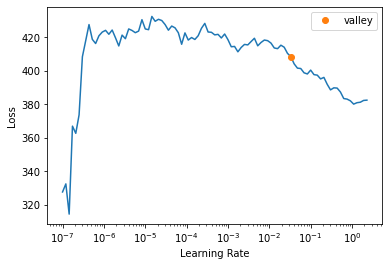

In [10]:
# Initial fit of neural net
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                    splits=splits)
dls = to.dataloaders(bs=64)
layers = [35,35]
config = tabular_config(embed_p=0.4,
                      ps=0.47)
learn = tabular_learner(dls, layers=layers, metrics=mse, config = config)
learn.lr_find()
learn.fit(4,lr=0.05)

In [11]:
# Manual fitting of neural net
learn.fit(1,lr=0.01)

epoch,train_loss,valid_loss,mse,time
0,257.316010,265.301483,265.301483,00:00


In [12]:
# Neural net validation

pdf_net = val_df.copy()
# pdf['spread'] = (pdf['spread'] - df['spread'].mean()) / df['spread'].std()
dl_net = learn.dls.test_dl(pdf_net)
pdf_net['predicted'] = learn.get_preds(dl=dl_net)[0].numpy()
pdf_net['real_spread']=pdf_net['spread'] * df['spread'].std() + df['spread'].mean()
pdf_net['real_margin'] = pdf_net['margin']
pdf_net['real_predicted'] = pdf_net['predicted']

print('Analysis of neural net performance, by difference from spread')

for margin in range(10):
    count = 0
    countTrue = 0
    for i in pdf_net.index:
        prediction_net_minus_spread = pdf_net['real_predicted'][i] - pdf_net['real_spread'][i]

        if prediction_net_minus_spread < -margin:
            prediction = -1
        elif prediction_net_minus_spread > margin:
            prediction = 1
        else:
            continue
        if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):
            countTrue += 1
        count += 1
    print(margin, count, countTrue/count)

Analysis of neural net performance, by difference from spread
0 471 0.5074309978768577
1 398 0.535175879396985
2 327 0.5412844036697247
3 260 0.5615384615384615
4 207 0.5555555555555556
5 175 0.5485714285714286
6 136 0.5441176470588235
7 106 0.5566037735849056
8 80 0.5875
9 57 0.6140350877192983


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/1898021362.py:25: RuntimeWarning: invalid value encountered in scalar divide
  if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):


In [14]:
excluded = ['gid', 'year', 'home_team', 'away_team', 'home_points', 'margin', 'covers', 'away_points', 'home_wins']
cat_features = ['home_conference', 'away_conference', 'neutral_site']
cont_features = [c for c in selected_features_2 if c not in cat_features and c not in excluded]

monotonicity = []
for feature in cont_features:
    corr = train_df[feature].corr(train_df['covers'])
    if corr < -.4:
        monotonicity.append(-1)
    elif corr > .4:
        monotonicity.append(1)
    else:
        monotonicity.append(0)
monotonicity = tuple(monotonicity)

folds = 5

param_grid = {
    'learning_rate': [0.01, 0.05, 0.10, 0.20],  
    'min_child_weight': [1, 5, 10],  
    'gamma': [0.5, 1, 5],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'max_depth': [2, 3, 4],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.5, 1]
}

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=11)

grid = RandomizedSearchCV(
    XGBClassifier(
        objective='binary:logistic', 
        monotone_constraints=monotonicity, 
        use_label_encoder=False
    ), 
    param_grid,
    n_jobs=1,
    cv=skf.split(train_df[cont_features], train_df['covers']),
    scoring='accuracy',
    verbose=3,
    refit=True,
    n_iter=100
)

grid.fit(train_df[cont_features], train_df['covers'], early_stopping_rounds=10, eval_metric="logloss", eval_set=[(train_df[cont_features], train_df['covers'])], verbose=True)

pdf = val_df.copy()
pdf['predicted'] = grid.predict(val_df[cont_features])
pdf['real_spread'] = pdf['spread'] * df['spread'].std() + df['spread'].mean()
pdf['real_margin'] = pdf['margin']
pdf['predicted_prob'] = grid.predict_proba(val_df[cont_features])[:, 1]

count = 0
countTrue = 0

for i in pdf.index:
    if (abs(pdf['predicted_prob'][i] - .5) / (pdf['predicted_prob'][i] - .5)) == (abs(pdf['real_margin'][i] - pdf['real_spread'][i]) / (pdf['real_margin'][i] - pdf['real_spread'][i])):
        countTrue += 1
    count += 1

print('Game accuracy: ', countTrue / count)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-logloss:0.68836
[1]	validation_0-logloss:0.67972
[2]	validation_0-logloss:0.67391
[3]	validation_0-logloss:0.66735
[4]	validation_0-logloss:0.66298
[5]	validation_0-logloss:0.65635
[6]	validation_0-logloss:0.65291
[7]	validation_0-logloss:0.64796
[8]	validation_0-logloss:0.64322
[9]	validation_0-logloss:0.63903
[10]	validation_0-logloss:0.63617
[11]	validation_0-logloss:0.63456
[12]	validation_0-logloss:0.62923
[13]	validation_0-logloss:0.62605


C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.62246
[15]	validation_0-logloss:0.61980
[16]	validation_0-logloss:0.61317
[17]	validation_0-logloss:0.60894
[18]	validation_0-logloss:0.60560
[19]	validation_0-logloss:0.60213
[20]	validation_0-logloss:0.59863
[21]	validation_0-logloss:0.59649
[22]	validation_0-logloss:0.59293
[23]	validation_0-logloss:0.59107
[24]	validation_0-logloss:0.58883
[25]	validation_0-logloss:0.58442
[26]	validation_0-logloss:0.58119
[27]	validation_0-logloss:0.57786
[28]	validation_0-logloss:0.57413
[29]	validation_0-logloss:0.57145
[30]	validation_0-logloss:0.56890
[31]	validation_0-logloss:0.56484
[32]	validation_0-logloss:0.56184
[33]	validation_0-logloss:0.55999
[34]	validation_0-logloss:0.55584
[35]	validation_0-logloss:0.55368
[36]	validation_0-logloss:0.55179
[37]	validation_0-logloss:0.54918
[38]	validation_0-logloss:0.54795
[39]	validation_0-logloss:0.54728
[40]	validation_0-logloss:0.54567
[41]	validation_0-logloss:0.54348
[42]	validation_0-logloss:0.53979
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.61532
[14]	validation_0-logloss:0.61335
[15]	validation_0-logloss:0.60860
[16]	validation_0-logloss:0.60227
[17]	validation_0-logloss:0.59833
[18]	validation_0-logloss:0.59407
[19]	validation_0-logloss:0.59159
[20]	validation_0-logloss:0.58941
[21]	validation_0-logloss:0.58493
[22]	validation_0-logloss:0.58217
[23]	validation_0-logloss:0.57768
[24]	validation_0-logloss:0.57520
[25]	validation_0-logloss:0.57106
[26]	validation_0-logloss:0.56894
[27]	validation_0-logloss:0.56741
[28]	validation_0-logloss:0.56194
[29]	validation_0-logloss:0.55874
[30]	validation_0-logloss:0.55373
[31]	validation_0-logloss:0.55231
[32]	validation_0-logloss:0.54877
[33]	validation_0-logloss:0.54480
[34]	validation_0-logloss:0.54357
[35]	validation_0-logloss:0.54191
[36]	validation_0-logloss:0.54021
[37]	validation_0-logloss:0.53691
[38]	validation_0-logloss:0.53243
[39]	validation_0-logloss:0.52982
[40]	validation_0-logloss:0.52673
[41]	validation_0-logloss:0.52304
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.61650
[16]	validation_0-logloss:0.61287
[17]	validation_0-logloss:0.60979
[18]	validation_0-logloss:0.60560
[19]	validation_0-logloss:0.60509
[20]	validation_0-logloss:0.60323
[21]	validation_0-logloss:0.59855
[22]	validation_0-logloss:0.59573
[23]	validation_0-logloss:0.59028
[24]	validation_0-logloss:0.58783
[25]	validation_0-logloss:0.58424
[26]	validation_0-logloss:0.58225
[27]	validation_0-logloss:0.57846
[28]	validation_0-logloss:0.57667
[29]	validation_0-logloss:0.57415
[30]	validation_0-logloss:0.57209
[31]	validation_0-logloss:0.57033
[32]	validation_0-logloss:0.56764
[33]	validation_0-logloss:0.56408
[34]	validation_0-logloss:0.55981
[35]	validation_0-logloss:0.55576
[36]	validation_0-logloss:0.55448
[37]	validation_0-logloss:0.55225
[38]	validation_0-logloss:0.55044
[39]	validation_0-logloss:0.54767
[40]	validation_0-logloss:0.54510
[41]	validation_0-logloss:0.54264
[42]	validation_0-logloss:0.54043
[43]	validation_0-logloss:0.53836
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.61904
[15]	validation_0-logloss:0.61573
[16]	validation_0-logloss:0.61446
[17]	validation_0-logloss:0.61200
[18]	validation_0-logloss:0.60997
[19]	validation_0-logloss:0.60537
[20]	validation_0-logloss:0.60315
[21]	validation_0-logloss:0.59932
[22]	validation_0-logloss:0.59656
[23]	validation_0-logloss:0.59310
[24]	validation_0-logloss:0.58742
[25]	validation_0-logloss:0.58489
[26]	validation_0-logloss:0.57978
[27]	validation_0-logloss:0.57620
[28]	validation_0-logloss:0.57311
[29]	validation_0-logloss:0.56962
[30]	validation_0-logloss:0.56554
[31]	validation_0-logloss:0.56383
[32]	validation_0-logloss:0.56074
[33]	validation_0-logloss:0.55703
[34]	validation_0-logloss:0.55244
[35]	validation_0-logloss:0.54967
[36]	validation_0-logloss:0.54890
[37]	validation_0-logloss:0.54733
[38]	validation_0-logloss:0.54577
[39]	validation_0-logloss:0.54443
[40]	validation_0-logloss:0.54222
[41]	validation_0-logloss:0.54035
[42]	validation_0-logloss:0.53716
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.60826
[15]	validation_0-logloss:0.60418
[16]	validation_0-logloss:0.59955
[17]	validation_0-logloss:0.59728
[18]	validation_0-logloss:0.59301
[19]	validation_0-logloss:0.58910
[20]	validation_0-logloss:0.58596
[21]	validation_0-logloss:0.58316
[22]	validation_0-logloss:0.58058
[23]	validation_0-logloss:0.57935
[24]	validation_0-logloss:0.57554
[25]	validation_0-logloss:0.57319
[26]	validation_0-logloss:0.57045
[27]	validation_0-logloss:0.56926
[28]	validation_0-logloss:0.56655
[29]	validation_0-logloss:0.56487
[30]	validation_0-logloss:0.56170
[31]	validation_0-logloss:0.55994
[32]	validation_0-logloss:0.55843
[33]	validation_0-logloss:0.55689
[34]	validation_0-logloss:0.55500
[35]	validation_0-logloss:0.55329
[36]	validation_0-logloss:0.55039
[37]	validation_0-logloss:0.54768
[38]	validation_0-logloss:0.54376
[39]	validation_0-logloss:0.54035
[40]	validation_0-logloss:0.53873
[41]	validation_0-logloss:0.53418
[42]	validation_0-logloss:0.53349
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.63604
[18]	validation_0-logloss:0.63432
[19]	validation_0-logloss:0.63260
[20]	validation_0-logloss:0.63026
[21]	validation_0-logloss:0.62833
[22]	validation_0-logloss:0.62647
[23]	validation_0-logloss:0.62549
[24]	validation_0-logloss:0.62285
[25]	validation_0-logloss:0.62292
[26]	validation_0-logloss:0.62263
[27]	validation_0-logloss:0.62215
[28]	validation_0-logloss:0.62215
[29]	validation_0-logloss:0.62052
[30]	validation_0-logloss:0.62052
[31]	validation_0-logloss:0.61864
[32]	validation_0-logloss:0.61864
[33]	validation_0-logloss:0.61405
[34]	validation_0-logloss:0.61405
[35]	validation_0-logloss:0.61405
[36]	validation_0-logloss:0.61325
[37]	validation_0-logloss:0.61150
[38]	validation_0-logloss:0.61051
[39]	validation_0-logloss:0.61052
[40]	validation_0-logloss:0.61053
[41]	validation_0-logloss:0.61053
[42]	validation_0-logloss:0.61052
[43]	validation_0-logloss:0.61053
[44]	validation_0-logloss:0.61051
[45]	validation_0-logloss:0.60934
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.62813
[21]	validation_0-logloss:0.62701
[22]	validation_0-logloss:0.62486
[23]	validation_0-logloss:0.62487
[24]	validation_0-logloss:0.62266
[25]	validation_0-logloss:0.61950
[26]	validation_0-logloss:0.61764
[27]	validation_0-logloss:0.61764
[28]	validation_0-logloss:0.61436
[29]	validation_0-logloss:0.61285
[30]	validation_0-logloss:0.61103
[31]	validation_0-logloss:0.61102
[32]	validation_0-logloss:0.61023
[33]	validation_0-logloss:0.61023
[34]	validation_0-logloss:0.61012
[35]	validation_0-logloss:0.61012
[36]	validation_0-logloss:0.60722
[37]	validation_0-logloss:0.60724
[38]	validation_0-logloss:0.60725
[39]	validation_0-logloss:0.60567
[40]	validation_0-logloss:0.60567
[41]	validation_0-logloss:0.60568
[42]	validation_0-logloss:0.60527
[43]	validation_0-logloss:0.60527
[44]	validation_0-logloss:0.60528
[45]	validation_0-logloss:0.60527
[46]	validation_0-logloss:0.60529
[47]	validation_0-logloss:0.60528
[48]	validation_0-logloss:0.60310
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.63044
[20]	validation_0-logloss:0.63044
[21]	validation_0-logloss:0.62842
[22]	validation_0-logloss:0.62637
[23]	validation_0-logloss:0.62406
[24]	validation_0-logloss:0.61975
[25]	validation_0-logloss:0.61824
[26]	validation_0-logloss:0.61609
[27]	validation_0-logloss:0.61340
[28]	validation_0-logloss:0.61133
[29]	validation_0-logloss:0.61100
[30]	validation_0-logloss:0.61000
[31]	validation_0-logloss:0.60765
[32]	validation_0-logloss:0.60765
[33]	validation_0-logloss:0.60647
[34]	validation_0-logloss:0.60585
[35]	validation_0-logloss:0.60468
[36]	validation_0-logloss:0.60305
[37]	validation_0-logloss:0.60305
[38]	validation_0-logloss:0.60305
[39]	validation_0-logloss:0.60306
[40]	validation_0-logloss:0.60104
[41]	validation_0-logloss:0.60104
[42]	validation_0-logloss:0.60104
[43]	validation_0-logloss:0.59927
[44]	validation_0-logloss:0.59827
[45]	validation_0-logloss:0.59830
[46]	validation_0-logloss:0.59770
[47]	validation_0-logloss:0.59745
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.62970
[26]	validation_0-logloss:0.62884
[27]	validation_0-logloss:0.62885
[28]	validation_0-logloss:0.62882
[29]	validation_0-logloss:0.62614
[30]	validation_0-logloss:0.62434
[31]	validation_0-logloss:0.62434
[32]	validation_0-logloss:0.62230
[33]	validation_0-logloss:0.62229
[34]	validation_0-logloss:0.61955
[35]	validation_0-logloss:0.61925
[36]	validation_0-logloss:0.61585
[37]	validation_0-logloss:0.61440
[38]	validation_0-logloss:0.61440
[39]	validation_0-logloss:0.61110
[40]	validation_0-logloss:0.61110
[41]	validation_0-logloss:0.60944
[42]	validation_0-logloss:0.60659
[43]	validation_0-logloss:0.60659
[44]	validation_0-logloss:0.60660
[45]	validation_0-logloss:0.60599
[46]	validation_0-logloss:0.60598
[47]	validation_0-logloss:0.60597
[48]	validation_0-logloss:0.60597
[49]	validation_0-logloss:0.60599
[50]	validation_0-logloss:0.60504
[51]	validation_0-logloss:0.60503
[52]	validation_0-logloss:0.60503
[53]	validation_0-logloss:0.60504
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63258
[17]	validation_0-logloss:0.63258
[18]	validation_0-logloss:0.63258
[19]	validation_0-logloss:0.63258
[20]	validation_0-logloss:0.63097
[21]	validation_0-logloss:0.62762
[22]	validation_0-logloss:0.62468
[23]	validation_0-logloss:0.62398
[24]	validation_0-logloss:0.62396
[25]	validation_0-logloss:0.62102
[26]	validation_0-logloss:0.62072
[27]	validation_0-logloss:0.62040
[28]	validation_0-logloss:0.61934
[29]	validation_0-logloss:0.61763
[30]	validation_0-logloss:0.61644
[31]	validation_0-logloss:0.61645
[32]	validation_0-logloss:0.61645
[33]	validation_0-logloss:0.61645
[34]	validation_0-logloss:0.61548
[35]	validation_0-logloss:0.61399
[36]	validation_0-logloss:0.61258
[37]	validation_0-logloss:0.61258
[38]	validation_0-logloss:0.61259
[39]	validation_0-logloss:0.61259
[40]	validation_0-logloss:0.61259
[41]	validation_0-logloss:0.61222
[42]	validation_0-logloss:0.61225
[43]	validation_0-logloss:0.61199
[44]	validation_0-logloss:0.61159
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68482
[17]	validation_0-logloss:0.68432
[18]	validation_0-logloss:0.68383
[19]	validation_0-logloss:0.68327
[20]	validation_0-logloss:0.68283
[21]	validation_0-logloss:0.68237
[22]	validation_0-logloss:0.68199
[23]	validation_0-logloss:0.68162
[24]	validation_0-logloss:0.68113
[25]	validation_0-logloss:0.68064
[26]	validation_0-logloss:0.68012
[27]	validation_0-logloss:0.67969
[28]	validation_0-logloss:0.67935
[29]	validation_0-logloss:0.67884
[30]	validation_0-logloss:0.67848
[31]	validation_0-logloss:0.67788
[32]	validation_0-logloss:0.67754
[33]	validation_0-logloss:0.67720
[34]	validation_0-logloss:0.67674
[35]	validation_0-logloss:0.67626
[36]	validation_0-logloss:0.67592
[37]	validation_0-logloss:0.67539
[38]	validation_0-logloss:0.67500
[39]	validation_0-logloss:0.67465
[40]	validation_0-logloss:0.67424
[41]	validation_0-logloss:0.67370
[42]	validation_0-logloss:0.67322
[43]	validation_0-logloss:0.67292
[44]	validation_0-logloss:0.67252
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68470
[16]	validation_0-logloss:0.68419
[17]	validation_0-logloss:0.68362
[18]	validation_0-logloss:0.68305
[19]	validation_0-logloss:0.68249
[20]	validation_0-logloss:0.68197
[21]	validation_0-logloss:0.68140
[22]	validation_0-logloss:0.68092
[23]	validation_0-logloss:0.68041
[24]	validation_0-logloss:0.67984
[25]	validation_0-logloss:0.67931
[26]	validation_0-logloss:0.67887
[27]	validation_0-logloss:0.67828
[28]	validation_0-logloss:0.67781
[29]	validation_0-logloss:0.67736
[30]	validation_0-logloss:0.67690
[31]	validation_0-logloss:0.67652
[32]	validation_0-logloss:0.67631
[33]	validation_0-logloss:0.67589
[34]	validation_0-logloss:0.67561
[35]	validation_0-logloss:0.67493
[36]	validation_0-logloss:0.67446
[37]	validation_0-logloss:0.67415
[38]	validation_0-logloss:0.67356
[39]	validation_0-logloss:0.67301
[40]	validation_0-logloss:0.67250
[41]	validation_0-logloss:0.67213
[42]	validation_0-logloss:0.67149
[43]	validation_0-logloss:0.67084
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.68530
[15]	validation_0-logloss:0.68492
[16]	validation_0-logloss:0.68429
[17]	validation_0-logloss:0.68373
[18]	validation_0-logloss:0.68331
[19]	validation_0-logloss:0.68287
[20]	validation_0-logloss:0.68236
[21]	validation_0-logloss:0.68172
[22]	validation_0-logloss:0.68122
[23]	validation_0-logloss:0.68066
[24]	validation_0-logloss:0.68016
[25]	validation_0-logloss:0.67968
[26]	validation_0-logloss:0.67910
[27]	validation_0-logloss:0.67849
[28]	validation_0-logloss:0.67795
[29]	validation_0-logloss:0.67728
[30]	validation_0-logloss:0.67672
[31]	validation_0-logloss:0.67643
[32]	validation_0-logloss:0.67590
[33]	validation_0-logloss:0.67562
[34]	validation_0-logloss:0.67537
[35]	validation_0-logloss:0.67493
[36]	validation_0-logloss:0.67440
[37]	validation_0-logloss:0.67407
[38]	validation_0-logloss:0.67359
[39]	validation_0-logloss:0.67306
[40]	validation_0-logloss:0.67263
[41]	validation_0-logloss:0.67220
[42]	validation_0-logloss:0.67171
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68419
[16]	validation_0-logloss:0.68355
[17]	validation_0-logloss:0.68312
[18]	validation_0-logloss:0.68265
[19]	validation_0-logloss:0.68210
[20]	validation_0-logloss:0.68149
[21]	validation_0-logloss:0.68095
[22]	validation_0-logloss:0.68023
[23]	validation_0-logloss:0.67982
[24]	validation_0-logloss:0.67929
[25]	validation_0-logloss:0.67888
[26]	validation_0-logloss:0.67855
[27]	validation_0-logloss:0.67812
[28]	validation_0-logloss:0.67760
[29]	validation_0-logloss:0.67707
[30]	validation_0-logloss:0.67657
[31]	validation_0-logloss:0.67602
[32]	validation_0-logloss:0.67546
[33]	validation_0-logloss:0.67506
[34]	validation_0-logloss:0.67455
[35]	validation_0-logloss:0.67400
[36]	validation_0-logloss:0.67371
[37]	validation_0-logloss:0.67347
[38]	validation_0-logloss:0.67291
[39]	validation_0-logloss:0.67247
[40]	validation_0-logloss:0.67216
[41]	validation_0-logloss:0.67181
[42]	validation_0-logloss:0.67130
[43]	validation_0-logloss:0.67073
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68370
[18]	validation_0-logloss:0.68323
[19]	validation_0-logloss:0.68254
[20]	validation_0-logloss:0.68203
[21]	validation_0-logloss:0.68158
[22]	validation_0-logloss:0.68102
[23]	validation_0-logloss:0.68059
[24]	validation_0-logloss:0.68002
[25]	validation_0-logloss:0.67952
[26]	validation_0-logloss:0.67908
[27]	validation_0-logloss:0.67865
[28]	validation_0-logloss:0.67813
[29]	validation_0-logloss:0.67773
[30]	validation_0-logloss:0.67724
[31]	validation_0-logloss:0.67692
[32]	validation_0-logloss:0.67649
[33]	validation_0-logloss:0.67595
[34]	validation_0-logloss:0.67562
[35]	validation_0-logloss:0.67517
[36]	validation_0-logloss:0.67485
[37]	validation_0-logloss:0.67444
[38]	validation_0-logloss:0.67424
[39]	validation_0-logloss:0.67378
[40]	validation_0-logloss:0.67334
[41]	validation_0-logloss:0.67297
[42]	validation_0-logloss:0.67237
[43]	validation_0-logloss:0.67197
[44]	validation_0-logloss:0.67165
[45]	validation_0-logloss:0.67124
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.66187
[25]	validation_0-logloss:0.66039
[26]	validation_0-logloss:0.65888
[27]	validation_0-logloss:0.65808
[28]	validation_0-logloss:0.65681
[29]	validation_0-logloss:0.65590
[30]	validation_0-logloss:0.65531
[31]	validation_0-logloss:0.65428
[32]	validation_0-logloss:0.65351
[33]	validation_0-logloss:0.65288
[34]	validation_0-logloss:0.65177
[35]	validation_0-logloss:0.65115
[36]	validation_0-logloss:0.65079
[37]	validation_0-logloss:0.64977
[38]	validation_0-logloss:0.64957
[39]	validation_0-logloss:0.64907
[40]	validation_0-logloss:0.64820
[41]	validation_0-logloss:0.64712
[42]	validation_0-logloss:0.64599
[43]	validation_0-logloss:0.64531
[44]	validation_0-logloss:0.64456
[45]	validation_0-logloss:0.64405
[46]	validation_0-logloss:0.64355
[47]	validation_0-logloss:0.64282
[48]	validation_0-logloss:0.64196
[49]	validation_0-logloss:0.64135
[50]	validation_0-logloss:0.64023
[51]	validation_0-logloss:0.63987
[52]	validation_0-logloss:0.63937
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.66432
[24]	validation_0-logloss:0.66363
[25]	validation_0-logloss:0.66245
[26]	validation_0-logloss:0.66179
[27]	validation_0-logloss:0.66038
[28]	validation_0-logloss:0.65890
[29]	validation_0-logloss:0.65782
[30]	validation_0-logloss:0.65731
[31]	validation_0-logloss:0.65654
[32]	validation_0-logloss:0.65572
[33]	validation_0-logloss:0.65490
[34]	validation_0-logloss:0.65432
[35]	validation_0-logloss:0.65357
[36]	validation_0-logloss:0.65219
[37]	validation_0-logloss:0.65186
[38]	validation_0-logloss:0.65080
[39]	validation_0-logloss:0.64985
[40]	validation_0-logloss:0.64955
[41]	validation_0-logloss:0.64795
[42]	validation_0-logloss:0.64702
[43]	validation_0-logloss:0.64683
[44]	validation_0-logloss:0.64578
[45]	validation_0-logloss:0.64495
[46]	validation_0-logloss:0.64415
[47]	validation_0-logloss:0.64301
[48]	validation_0-logloss:0.64182
[49]	validation_0-logloss:0.64127
[50]	validation_0-logloss:0.64048
[51]	validation_0-logloss:0.63953
[52]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66504
[21]	validation_0-logloss:0.66415
[22]	validation_0-logloss:0.66334
[23]	validation_0-logloss:0.66240
[24]	validation_0-logloss:0.66177
[25]	validation_0-logloss:0.66103
[26]	validation_0-logloss:0.65989
[27]	validation_0-logloss:0.65899
[28]	validation_0-logloss:0.65830
[29]	validation_0-logloss:0.65709
[30]	validation_0-logloss:0.65599
[31]	validation_0-logloss:0.65525
[32]	validation_0-logloss:0.65406
[33]	validation_0-logloss:0.65338
[34]	validation_0-logloss:0.65194
[35]	validation_0-logloss:0.65110
[36]	validation_0-logloss:0.65005
[37]	validation_0-logloss:0.64952
[38]	validation_0-logloss:0.64803
[39]	validation_0-logloss:0.64734
[40]	validation_0-logloss:0.64708
[41]	validation_0-logloss:0.64621
[42]	validation_0-logloss:0.64542
[43]	validation_0-logloss:0.64485
[44]	validation_0-logloss:0.64423
[45]	validation_0-logloss:0.64304
[46]	validation_0-logloss:0.64229
[47]	validation_0-logloss:0.64114
[48]	validation_0-logloss:0.64084
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.65950
[28]	validation_0-logloss:0.65832
[29]	validation_0-logloss:0.65775
[30]	validation_0-logloss:0.65720
[31]	validation_0-logloss:0.65647
[32]	validation_0-logloss:0.65567
[33]	validation_0-logloss:0.65518
[34]	validation_0-logloss:0.65408
[35]	validation_0-logloss:0.65378
[36]	validation_0-logloss:0.65344
[37]	validation_0-logloss:0.65261
[38]	validation_0-logloss:0.65210
[39]	validation_0-logloss:0.65093
[40]	validation_0-logloss:0.65063
[41]	validation_0-logloss:0.64979
[42]	validation_0-logloss:0.64914
[43]	validation_0-logloss:0.64806
[44]	validation_0-logloss:0.64707
[45]	validation_0-logloss:0.64599
[46]	validation_0-logloss:0.64513
[47]	validation_0-logloss:0.64391
[48]	validation_0-logloss:0.64360
[49]	validation_0-logloss:0.64227
[50]	validation_0-logloss:0.64210
[51]	validation_0-logloss:0.64108
[52]	validation_0-logloss:0.64083
[53]	validation_0-logloss:0.64015
[54]	validation_0-logloss:0.63927
[55]	validation_0-logloss:0.63865
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.66306
[27]	validation_0-logloss:0.66232
[28]	validation_0-logloss:0.66053
[29]	validation_0-logloss:0.65947
[30]	validation_0-logloss:0.65844
[31]	validation_0-logloss:0.65731
[32]	validation_0-logloss:0.65658
[33]	validation_0-logloss:0.65537
[34]	validation_0-logloss:0.65437
[35]	validation_0-logloss:0.65292
[36]	validation_0-logloss:0.65160
[37]	validation_0-logloss:0.65099
[38]	validation_0-logloss:0.65037
[39]	validation_0-logloss:0.64987
[40]	validation_0-logloss:0.64880
[41]	validation_0-logloss:0.64816
[42]	validation_0-logloss:0.64710
[43]	validation_0-logloss:0.64606
[44]	validation_0-logloss:0.64564
[45]	validation_0-logloss:0.64488
[46]	validation_0-logloss:0.64458
[47]	validation_0-logloss:0.64408
[48]	validation_0-logloss:0.64384
[49]	validation_0-logloss:0.64260
[50]	validation_0-logloss:0.64200
[51]	validation_0-logloss:0.64079
[52]	validation_0-logloss:0.64010
[53]	validation_0-logloss:0.63917
[54]	validation_0-logloss:0.63829
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.63155
[22]	validation_0-logloss:0.62833
[23]	validation_0-logloss:0.62674
[24]	validation_0-logloss:0.62597
[25]	validation_0-logloss:0.62271
[26]	validation_0-logloss:0.61977
[27]	validation_0-logloss:0.61658
[28]	validation_0-logloss:0.61663
[29]	validation_0-logloss:0.61659
[30]	validation_0-logloss:0.61589
[31]	validation_0-logloss:0.61480
[32]	validation_0-logloss:0.61256
[33]	validation_0-logloss:0.61118
[34]	validation_0-logloss:0.60957
[35]	validation_0-logloss:0.60588
[36]	validation_0-logloss:0.60580
[37]	validation_0-logloss:0.60580
[38]	validation_0-logloss:0.60384
[39]	validation_0-logloss:0.60373
[40]	validation_0-logloss:0.60291
[41]	validation_0-logloss:0.60005
[42]	validation_0-logloss:0.59941
[43]	validation_0-logloss:0.59764
[44]	validation_0-logloss:0.59448
[45]	validation_0-logloss:0.59413
[46]	validation_0-logloss:0.59412
[47]	validation_0-logloss:0.59364
[48]	validation_0-logloss:0.59198
[49]	validation_0-logloss:0.59197
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.62750
[20]	validation_0-logloss:0.62503
[21]	validation_0-logloss:0.62290
[22]	validation_0-logloss:0.62107
[23]	validation_0-logloss:0.61903
[24]	validation_0-logloss:0.61847
[25]	validation_0-logloss:0.61535
[26]	validation_0-logloss:0.61459
[27]	validation_0-logloss:0.61169
[28]	validation_0-logloss:0.60834
[29]	validation_0-logloss:0.60598
[30]	validation_0-logloss:0.60527
[31]	validation_0-logloss:0.60528
[32]	validation_0-logloss:0.60527
[33]	validation_0-logloss:0.60388
[34]	validation_0-logloss:0.60340
[35]	validation_0-logloss:0.60338
[36]	validation_0-logloss:0.60301
[37]	validation_0-logloss:0.60274
[38]	validation_0-logloss:0.60039
[39]	validation_0-logloss:0.59776
[40]	validation_0-logloss:0.59772
[41]	validation_0-logloss:0.59433
[42]	validation_0-logloss:0.59238
[43]	validation_0-logloss:0.59237
[44]	validation_0-logloss:0.59073
[45]	validation_0-logloss:0.59006
[46]	validation_0-logloss:0.58760
[47]	validation_0-logloss:0.58658
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.63922
[19]	validation_0-logloss:0.63698
[20]	validation_0-logloss:0.63524
[21]	validation_0-logloss:0.63350
[22]	validation_0-logloss:0.63067
[23]	validation_0-logloss:0.62860
[24]	validation_0-logloss:0.62723
[25]	validation_0-logloss:0.62593
[26]	validation_0-logloss:0.62440
[27]	validation_0-logloss:0.62440
[28]	validation_0-logloss:0.62392
[29]	validation_0-logloss:0.62149
[30]	validation_0-logloss:0.61948
[31]	validation_0-logloss:0.61591
[32]	validation_0-logloss:0.61478
[33]	validation_0-logloss:0.61319
[34]	validation_0-logloss:0.61141
[35]	validation_0-logloss:0.60918
[36]	validation_0-logloss:0.60574
[37]	validation_0-logloss:0.60531
[38]	validation_0-logloss:0.60265
[39]	validation_0-logloss:0.59925
[40]	validation_0-logloss:0.59797
[41]	validation_0-logloss:0.59620
[42]	validation_0-logloss:0.59506
[43]	validation_0-logloss:0.59507
[44]	validation_0-logloss:0.59353
[45]	validation_0-logloss:0.59368
[46]	validation_0-logloss:0.59303
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.63405
[20]	validation_0-logloss:0.63150
[21]	validation_0-logloss:0.62937
[22]	validation_0-logloss:0.62827
[23]	validation_0-logloss:0.62709
[24]	validation_0-logloss:0.62560
[25]	validation_0-logloss:0.62440
[26]	validation_0-logloss:0.62301
[27]	validation_0-logloss:0.62070
[28]	validation_0-logloss:0.61880
[29]	validation_0-logloss:0.61543
[30]	validation_0-logloss:0.61367
[31]	validation_0-logloss:0.61261
[32]	validation_0-logloss:0.61218
[33]	validation_0-logloss:0.61019
[34]	validation_0-logloss:0.60863
[35]	validation_0-logloss:0.60863
[36]	validation_0-logloss:0.60865
[37]	validation_0-logloss:0.60746
[38]	validation_0-logloss:0.60584
[39]	validation_0-logloss:0.60375
[40]	validation_0-logloss:0.60249
[41]	validation_0-logloss:0.60156
[42]	validation_0-logloss:0.59894
[43]	validation_0-logloss:0.59708
[44]	validation_0-logloss:0.59611
[45]	validation_0-logloss:0.59535
[46]	validation_0-logloss:0.59407
[47]	validation_0-logloss:0.59197
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.63323
[21]	validation_0-logloss:0.63148
[22]	validation_0-logloss:0.62838
[23]	validation_0-logloss:0.62561
[24]	validation_0-logloss:0.62442
[25]	validation_0-logloss:0.62255
[26]	validation_0-logloss:0.62074
[27]	validation_0-logloss:0.61907
[28]	validation_0-logloss:0.61683
[29]	validation_0-logloss:0.61493
[30]	validation_0-logloss:0.61421
[31]	validation_0-logloss:0.61420
[32]	validation_0-logloss:0.61244
[33]	validation_0-logloss:0.61097
[34]	validation_0-logloss:0.61052
[35]	validation_0-logloss:0.60924
[36]	validation_0-logloss:0.60690
[37]	validation_0-logloss:0.60679
[38]	validation_0-logloss:0.60568
[39]	validation_0-logloss:0.60327
[40]	validation_0-logloss:0.60202
[41]	validation_0-logloss:0.60009
[42]	validation_0-logloss:0.59696
[43]	validation_0-logloss:0.59697
[44]	validation_0-logloss:0.59710
[45]	validation_0-logloss:0.59554
[46]	validation_0-logloss:0.59517
[47]	validation_0-logloss:0.59519
[48]	validation_0-logloss:0.59245
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67567
[27]	validation_0-logloss:0.67475
[28]	validation_0-logloss:0.67420
[29]	validation_0-logloss:0.67364
[30]	validation_0-logloss:0.67311
[31]	validation_0-logloss:0.67260
[32]	validation_0-logloss:0.67215
[33]	validation_0-logloss:0.67145
[34]	validation_0-logloss:0.67103
[35]	validation_0-logloss:0.67057
[36]	validation_0-logloss:0.67025
[37]	validation_0-logloss:0.66993
[38]	validation_0-logloss:0.66946
[39]	validation_0-logloss:0.66906
[40]	validation_0-logloss:0.66851
[41]	validation_0-logloss:0.66813
[42]	validation_0-logloss:0.66772
[43]	validation_0-logloss:0.66737
[44]	validation_0-logloss:0.66687
[45]	validation_0-logloss:0.66640
[46]	validation_0-logloss:0.66586
[47]	validation_0-logloss:0.66537
[48]	validation_0-logloss:0.66491
[49]	validation_0-logloss:0.66442
[50]	validation_0-logloss:0.66382
[51]	validation_0-logloss:0.66317
[52]	validation_0-logloss:0.66258
[53]	validation_0-logloss:0.66228
[54]	validation_0-logloss:0.66195
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67435
[26]	validation_0-logloss:0.67375
[27]	validation_0-logloss:0.67327
[28]	validation_0-logloss:0.67290
[29]	validation_0-logloss:0.67216
[30]	validation_0-logloss:0.67153
[31]	validation_0-logloss:0.67095
[32]	validation_0-logloss:0.67050
[33]	validation_0-logloss:0.67017
[34]	validation_0-logloss:0.66981
[35]	validation_0-logloss:0.66932
[36]	validation_0-logloss:0.66874
[37]	validation_0-logloss:0.66838
[38]	validation_0-logloss:0.66809
[39]	validation_0-logloss:0.66756
[40]	validation_0-logloss:0.66711
[41]	validation_0-logloss:0.66673
[42]	validation_0-logloss:0.66648
[43]	validation_0-logloss:0.66621
[44]	validation_0-logloss:0.66577
[45]	validation_0-logloss:0.66525
[46]	validation_0-logloss:0.66471
[47]	validation_0-logloss:0.66422
[48]	validation_0-logloss:0.66377
[49]	validation_0-logloss:0.66344
[50]	validation_0-logloss:0.66298
[51]	validation_0-logloss:0.66250
[52]	validation_0-logloss:0.66212
[53]	validation_0-logloss:0.66156
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67540
[25]	validation_0-logloss:0.67500
[26]	validation_0-logloss:0.67455
[27]	validation_0-logloss:0.67399
[28]	validation_0-logloss:0.67341
[29]	validation_0-logloss:0.67275
[30]	validation_0-logloss:0.67204
[31]	validation_0-logloss:0.67160
[32]	validation_0-logloss:0.67117
[33]	validation_0-logloss:0.67078
[34]	validation_0-logloss:0.67041
[35]	validation_0-logloss:0.66999
[36]	validation_0-logloss:0.66972
[37]	validation_0-logloss:0.66931
[38]	validation_0-logloss:0.66876
[39]	validation_0-logloss:0.66818
[40]	validation_0-logloss:0.66760
[41]	validation_0-logloss:0.66690
[42]	validation_0-logloss:0.66638
[43]	validation_0-logloss:0.66597
[44]	validation_0-logloss:0.66553
[45]	validation_0-logloss:0.66500
[46]	validation_0-logloss:0.66449
[47]	validation_0-logloss:0.66424
[48]	validation_0-logloss:0.66382
[49]	validation_0-logloss:0.66360
[50]	validation_0-logloss:0.66310
[51]	validation_0-logloss:0.66264
[52]	validation_0-logloss:0.66241
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67388
[27]	validation_0-logloss:0.67335
[28]	validation_0-logloss:0.67269
[29]	validation_0-logloss:0.67208
[30]	validation_0-logloss:0.67156
[31]	validation_0-logloss:0.67126
[32]	validation_0-logloss:0.67081
[33]	validation_0-logloss:0.67038
[34]	validation_0-logloss:0.66968
[35]	validation_0-logloss:0.66944
[36]	validation_0-logloss:0.66913
[37]	validation_0-logloss:0.66874
[38]	validation_0-logloss:0.66825
[39]	validation_0-logloss:0.66797
[40]	validation_0-logloss:0.66774
[41]	validation_0-logloss:0.66740
[42]	validation_0-logloss:0.66671
[43]	validation_0-logloss:0.66628
[44]	validation_0-logloss:0.66589
[45]	validation_0-logloss:0.66531
[46]	validation_0-logloss:0.66487
[47]	validation_0-logloss:0.66441
[48]	validation_0-logloss:0.66393
[49]	validation_0-logloss:0.66345
[50]	validation_0-logloss:0.66313
[51]	validation_0-logloss:0.66257
[52]	validation_0-logloss:0.66210
[53]	validation_0-logloss:0.66164
[54]	validation_0-logloss:0.66114
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67363
[28]	validation_0-logloss:0.67313
[29]	validation_0-logloss:0.67265
[30]	validation_0-logloss:0.67194
[31]	validation_0-logloss:0.67134
[32]	validation_0-logloss:0.67089
[33]	validation_0-logloss:0.67011
[34]	validation_0-logloss:0.66935
[35]	validation_0-logloss:0.66895
[36]	validation_0-logloss:0.66852
[37]	validation_0-logloss:0.66805
[38]	validation_0-logloss:0.66771
[39]	validation_0-logloss:0.66707
[40]	validation_0-logloss:0.66635
[41]	validation_0-logloss:0.66596
[42]	validation_0-logloss:0.66537
[43]	validation_0-logloss:0.66488
[44]	validation_0-logloss:0.66457
[45]	validation_0-logloss:0.66400
[46]	validation_0-logloss:0.66357
[47]	validation_0-logloss:0.66323
[48]	validation_0-logloss:0.66287
[49]	validation_0-logloss:0.66243
[50]	validation_0-logloss:0.66195
[51]	validation_0-logloss:0.66157
[52]	validation_0-logloss:0.66126
[53]	validation_0-logloss:0.66080
[54]	validation_0-logloss:0.66020
[55]	validation_0-logloss:0.65991
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-logloss:0.67467
[2]	validation_0-logloss:0.66813
[3]	validation_0-logloss:0.65704
[4]	validation_0-logloss:0.64872
[5]	validation_0-logloss:0.64463
[6]	validation_0-logloss:0.63469
[7]	validation_0-logloss:0.62630
[8]	validation_0-logloss:0.62028
[9]	validation_0-logloss:0.62028
[10]	validation_0-logloss:0.62028
[11]	validation_0-logloss:0.62028
[12]	validation_0-logloss:0.62028
[13]	validation_0-logloss:0.62028
[14]	validation_0-logloss:0.62028
[15]	validation_0-logloss:0.62028
[16]	validation_0-logloss:0.62028
[17]	validation_0-logloss:0.62028
[18]	validation_0-logloss:0.62028
[19]	validation_0-logloss:0.62028
[20]	validation_0-logloss:0.62028
[21]	validation_0-logloss:0.62028
[22]	validation_0-logloss:0.62028
[23]	validation_0-logloss:0.62028
[24]	validation_0-logloss:0.62028
[25]	validation_0-logloss:0.62028
[26]	validation_0-logloss:0.62028
[27]	validation_0-logloss:0.62028
[28]	validation_0-logloss:0.62028
[29]	validation_0-logloss:0.62028
[30]	validation_0-loglo

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-logloss:0.67333
[2]	validation_0-logloss:0.66415
[3]	validation_0-logloss:0.65569
[4]	validation_0-logloss:0.64750
[5]	validation_0-logloss:0.63939
[6]	validation_0-logloss:0.62958
[7]	validation_0-logloss:0.62958
[8]	validation_0-logloss:0.62691
[9]	validation_0-logloss:0.62655
[10]	validation_0-logloss:0.62655
[11]	validation_0-logloss:0.62613
[12]	validation_0-logloss:0.62613
[13]	validation_0-logloss:0.62613
[14]	validation_0-logloss:0.62613
[15]	validation_0-logloss:0.62613
[16]	validation_0-logloss:0.62613
[17]	validation_0-logloss:0.62613
[18]	validation_0-logloss:0.62613
[19]	validation_0-logloss:0.62613
[20]	validation_0-logloss:0.62613
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=1.0;, score=0.516 total time=   0.0s
[0]	validation_0-logloss:0.68384
[1]	validation_0-logloss:0.67253
[2]	validation_0-logloss:0.66479
[3]	validation_0-logloss:0.65665
[4]	validation_0-logloss:

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-logloss:0.61937
[37]	validation_0-logloss:0.61937
[38]	validation_0-logloss:0.61937
[39]	validation_0-logloss:0.61937
[40]	validation_0-logloss:0.61937
[41]	validation_0-logloss:0.61937
[42]	validation_0-logloss:0.61937
[43]	validation_0-logloss:0.61937
[44]	validation_0-logloss:0.61937
[45]	validation_0-logloss:0.61937
[46]	validation_0-logloss:0.61937
[47]	validation_0-logloss:0.61937
[48]	validation_0-logloss:0.61937
[49]	validation_0-logloss:0.61937
[50]	validation_0-logloss:0.61937
[51]	validation_0-logloss:0.61937
[52]	validation_0-logloss:0.61937
[53]	validation_0-logloss:0.61937
[54]	validation_0-logloss:0.61937
[55]	validation_0-logloss:0.61937
[56]	validation_0-logloss:0.61937
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=1.0;, score=0.508 total time=   0.1s
[0]	validation_0-logloss:0.68945
[1]	validation_0-logloss:0.68664
[2]	validation_0-logloss:0.68466
[3]	validation_

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.64873
[25]	validation_0-logloss:0.64693
[26]	validation_0-logloss:0.64632
[27]	validation_0-logloss:0.64554
[28]	validation_0-logloss:0.64555
[29]	validation_0-logloss:0.64493
[30]	validation_0-logloss:0.64386
[31]	validation_0-logloss:0.64217
[32]	validation_0-logloss:0.64093
[33]	validation_0-logloss:0.63916
[34]	validation_0-logloss:0.63916
[35]	validation_0-logloss:0.63916
[36]	validation_0-logloss:0.63906
[37]	validation_0-logloss:0.63816
[38]	validation_0-logloss:0.63797
[39]	validation_0-logloss:0.63798
[40]	validation_0-logloss:0.63707
[41]	validation_0-logloss:0.63706
[42]	validation_0-logloss:0.63644
[43]	validation_0-logloss:0.63569
[44]	validation_0-logloss:0.63416
[45]	validation_0-logloss:0.63375
[46]	validation_0-logloss:0.63375
[47]	validation_0-logloss:0.63375
[48]	validation_0-logloss:0.63202
[49]	validation_0-logloss:0.63020
[50]	validation_0-logloss:0.63020
[51]	validation_0-logloss:0.63020
[52]	validation_0-logloss:0.62951
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.63880
[30]	validation_0-logloss:0.63760
[31]	validation_0-logloss:0.63662
[32]	validation_0-logloss:0.63563
[33]	validation_0-logloss:0.63495
[34]	validation_0-logloss:0.63437
[35]	validation_0-logloss:0.63436
[36]	validation_0-logloss:0.63245
[37]	validation_0-logloss:0.63246
[38]	validation_0-logloss:0.63247
[39]	validation_0-logloss:0.63170
[40]	validation_0-logloss:0.63171
[41]	validation_0-logloss:0.63171
[42]	validation_0-logloss:0.63123
[43]	validation_0-logloss:0.63123
[44]	validation_0-logloss:0.62945
[45]	validation_0-logloss:0.62871
[46]	validation_0-logloss:0.62874
[47]	validation_0-logloss:0.62872
[48]	validation_0-logloss:0.62870
[49]	validation_0-logloss:0.62870
[50]	validation_0-logloss:0.62766
[51]	validation_0-logloss:0.62706
[52]	validation_0-logloss:0.62571
[53]	validation_0-logloss:0.62571
[54]	validation_0-logloss:0.62473
[55]	validation_0-logloss:0.62338
[56]	validation_0-logloss:0.62338
[57]	validation_0-logloss:0.62213
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.64363
[30]	validation_0-logloss:0.64207
[31]	validation_0-logloss:0.64089
[32]	validation_0-logloss:0.63961
[33]	validation_0-logloss:0.63849
[34]	validation_0-logloss:0.63824
[35]	validation_0-logloss:0.63749
[36]	validation_0-logloss:0.63552
[37]	validation_0-logloss:0.63514
[38]	validation_0-logloss:0.63514
[39]	validation_0-logloss:0.63515
[40]	validation_0-logloss:0.63343
[41]	validation_0-logloss:0.63168
[42]	validation_0-logloss:0.62958
[43]	validation_0-logloss:0.62959
[44]	validation_0-logloss:0.62790
[45]	validation_0-logloss:0.62793
[46]	validation_0-logloss:0.62729
[47]	validation_0-logloss:0.62729
[48]	validation_0-logloss:0.62729
[49]	validation_0-logloss:0.62729
[50]	validation_0-logloss:0.62624
[51]	validation_0-logloss:0.62544
[52]	validation_0-logloss:0.62496
[53]	validation_0-logloss:0.62496
[54]	validation_0-logloss:0.62431
[55]	validation_0-logloss:0.62432
[56]	validation_0-logloss:0.62372
[57]	validation_0-logloss:0.62279
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.64762
[26]	validation_0-logloss:0.64669
[27]	validation_0-logloss:0.64558
[28]	validation_0-logloss:0.64555
[29]	validation_0-logloss:0.64423
[30]	validation_0-logloss:0.64338
[31]	validation_0-logloss:0.64258
[32]	validation_0-logloss:0.64212
[33]	validation_0-logloss:0.64212
[34]	validation_0-logloss:0.64070
[35]	validation_0-logloss:0.64071
[36]	validation_0-logloss:0.63835
[37]	validation_0-logloss:0.63753
[38]	validation_0-logloss:0.63752
[39]	validation_0-logloss:0.63678
[40]	validation_0-logloss:0.63613
[41]	validation_0-logloss:0.63508
[42]	validation_0-logloss:0.63313
[43]	validation_0-logloss:0.63312
[44]	validation_0-logloss:0.63262
[45]	validation_0-logloss:0.63199
[46]	validation_0-logloss:0.63198
[47]	validation_0-logloss:0.63061
[48]	validation_0-logloss:0.63061
[49]	validation_0-logloss:0.63062
[50]	validation_0-logloss:0.63063
[51]	validation_0-logloss:0.63062
[52]	validation_0-logloss:0.63063
[53]	validation_0-logloss:0.62949
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.64125
[30]	validation_0-logloss:0.63968
[31]	validation_0-logloss:0.63853
[32]	validation_0-logloss:0.63785
[33]	validation_0-logloss:0.63579
[34]	validation_0-logloss:0.63579
[35]	validation_0-logloss:0.63476
[36]	validation_0-logloss:0.63325
[37]	validation_0-logloss:0.63307
[38]	validation_0-logloss:0.63307
[39]	validation_0-logloss:0.63275
[40]	validation_0-logloss:0.63233
[41]	validation_0-logloss:0.63176
[42]	validation_0-logloss:0.63045
[43]	validation_0-logloss:0.63049
[44]	validation_0-logloss:0.63040
[45]	validation_0-logloss:0.63032
[46]	validation_0-logloss:0.63028
[47]	validation_0-logloss:0.63021
[48]	validation_0-logloss:0.62992
[49]	validation_0-logloss:0.62993
[50]	validation_0-logloss:0.62992
[51]	validation_0-logloss:0.62964
[52]	validation_0-logloss:0.62964
[53]	validation_0-logloss:0.62964
[54]	validation_0-logloss:0.62809
[55]	validation_0-logloss:0.62809
[56]	validation_0-logloss:0.62809
[57]	validation_0-logloss:0.62710
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68564
[17]	validation_0-logloss:0.68522
[18]	validation_0-logloss:0.68471
[19]	validation_0-logloss:0.68420
[20]	validation_0-logloss:0.68368
[21]	validation_0-logloss:0.68341
[22]	validation_0-logloss:0.68305
[23]	validation_0-logloss:0.68259
[24]	validation_0-logloss:0.68231
[25]	validation_0-logloss:0.68179
[26]	validation_0-logloss:0.68139
[27]	validation_0-logloss:0.68092
[28]	validation_0-logloss:0.68034
[29]	validation_0-logloss:0.67983
[30]	validation_0-logloss:0.67947
[31]	validation_0-logloss:0.67905
[32]	validation_0-logloss:0.67869
[33]	validation_0-logloss:0.67829
[34]	validation_0-logloss:0.67794
[35]	validation_0-logloss:0.67739
[36]	validation_0-logloss:0.67704
[37]	validation_0-logloss:0.67669
[38]	validation_0-logloss:0.67614
[39]	validation_0-logloss:0.67581
[40]	validation_0-logloss:0.67523
[41]	validation_0-logloss:0.67479
[42]	validation_0-logloss:0.67434
[43]	validation_0-logloss:0.67389
[44]	validation_0-logloss:0.67330
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68447
[17]	validation_0-logloss:0.68395
[18]	validation_0-logloss:0.68350
[19]	validation_0-logloss:0.68284
[20]	validation_0-logloss:0.68247
[21]	validation_0-logloss:0.68201
[22]	validation_0-logloss:0.68158
[23]	validation_0-logloss:0.68124
[24]	validation_0-logloss:0.68078
[25]	validation_0-logloss:0.68026
[26]	validation_0-logloss:0.67981
[27]	validation_0-logloss:0.67919
[28]	validation_0-logloss:0.67878
[29]	validation_0-logloss:0.67827
[30]	validation_0-logloss:0.67793
[31]	validation_0-logloss:0.67763
[32]	validation_0-logloss:0.67714
[33]	validation_0-logloss:0.67675
[34]	validation_0-logloss:0.67622
[35]	validation_0-logloss:0.67564
[36]	validation_0-logloss:0.67508
[37]	validation_0-logloss:0.67486
[38]	validation_0-logloss:0.67423
[39]	validation_0-logloss:0.67374
[40]	validation_0-logloss:0.67335
[41]	validation_0-logloss:0.67306
[42]	validation_0-logloss:0.67259
[43]	validation_0-logloss:0.67213
[44]	validation_0-logloss:0.67172
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68495
[17]	validation_0-logloss:0.68434
[18]	validation_0-logloss:0.68376
[19]	validation_0-logloss:0.68333
[20]	validation_0-logloss:0.68297
[21]	validation_0-logloss:0.68250
[22]	validation_0-logloss:0.68203
[23]	validation_0-logloss:0.68147
[24]	validation_0-logloss:0.68078
[25]	validation_0-logloss:0.68030
[26]	validation_0-logloss:0.67979
[27]	validation_0-logloss:0.67922
[28]	validation_0-logloss:0.67871
[29]	validation_0-logloss:0.67818
[30]	validation_0-logloss:0.67772
[31]	validation_0-logloss:0.67734
[32]	validation_0-logloss:0.67688
[33]	validation_0-logloss:0.67655
[34]	validation_0-logloss:0.67607
[35]	validation_0-logloss:0.67574
[36]	validation_0-logloss:0.67537
[37]	validation_0-logloss:0.67494
[38]	validation_0-logloss:0.67450
[39]	validation_0-logloss:0.67408
[40]	validation_0-logloss:0.67374
[41]	validation_0-logloss:0.67338
[42]	validation_0-logloss:0.67281
[43]	validation_0-logloss:0.67228
[44]	validation_0-logloss:0.67185
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68411
[17]	validation_0-logloss:0.68351
[18]	validation_0-logloss:0.68308
[19]	validation_0-logloss:0.68251
[20]	validation_0-logloss:0.68183
[21]	validation_0-logloss:0.68130
[22]	validation_0-logloss:0.68081
[23]	validation_0-logloss:0.68052
[24]	validation_0-logloss:0.68000
[25]	validation_0-logloss:0.67940
[26]	validation_0-logloss:0.67894
[27]	validation_0-logloss:0.67853
[28]	validation_0-logloss:0.67800
[29]	validation_0-logloss:0.67750
[30]	validation_0-logloss:0.67719
[31]	validation_0-logloss:0.67697
[32]	validation_0-logloss:0.67660
[33]	validation_0-logloss:0.67609
[34]	validation_0-logloss:0.67545
[35]	validation_0-logloss:0.67492
[36]	validation_0-logloss:0.67451
[37]	validation_0-logloss:0.67421
[38]	validation_0-logloss:0.67378
[39]	validation_0-logloss:0.67336
[40]	validation_0-logloss:0.67297
[41]	validation_0-logloss:0.67262
[42]	validation_0-logloss:0.67218
[43]	validation_0-logloss:0.67178
[44]	validation_0-logloss:0.67125
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68502
[17]	validation_0-logloss:0.68453
[18]	validation_0-logloss:0.68412
[19]	validation_0-logloss:0.68347
[20]	validation_0-logloss:0.68310
[21]	validation_0-logloss:0.68257
[22]	validation_0-logloss:0.68211
[23]	validation_0-logloss:0.68162
[24]	validation_0-logloss:0.68113
[25]	validation_0-logloss:0.68059
[26]	validation_0-logloss:0.68016
[27]	validation_0-logloss:0.67973
[28]	validation_0-logloss:0.67930
[29]	validation_0-logloss:0.67896
[30]	validation_0-logloss:0.67868
[31]	validation_0-logloss:0.67812
[32]	validation_0-logloss:0.67770
[33]	validation_0-logloss:0.67741
[34]	validation_0-logloss:0.67708
[35]	validation_0-logloss:0.67667
[36]	validation_0-logloss:0.67611
[37]	validation_0-logloss:0.67575
[38]	validation_0-logloss:0.67538
[39]	validation_0-logloss:0.67509
[40]	validation_0-logloss:0.67447
[41]	validation_0-logloss:0.67401
[42]	validation_0-logloss:0.67363
[43]	validation_0-logloss:0.67315
[44]	validation_0-logloss:0.67283
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65242
[17]	validation_0-logloss:0.64996
[18]	validation_0-logloss:0.64790
[19]	validation_0-logloss:0.64637
[20]	validation_0-logloss:0.64396
[21]	validation_0-logloss:0.64178
[22]	validation_0-logloss:0.64031
[23]	validation_0-logloss:0.63871
[24]	validation_0-logloss:0.63676
[25]	validation_0-logloss:0.63547
[26]	validation_0-logloss:0.63359
[27]	validation_0-logloss:0.63102
[28]	validation_0-logloss:0.62878
[29]	validation_0-logloss:0.62753
[30]	validation_0-logloss:0.62572
[31]	validation_0-logloss:0.62411
[32]	validation_0-logloss:0.62197
[33]	validation_0-logloss:0.61972
[34]	validation_0-logloss:0.61868
[35]	validation_0-logloss:0.61684
[36]	validation_0-logloss:0.61532
[37]	validation_0-logloss:0.61378
[38]	validation_0-logloss:0.61288
[39]	validation_0-logloss:0.61162
[40]	validation_0-logloss:0.60973
[41]	validation_0-logloss:0.60893
[42]	validation_0-logloss:0.60746
[43]	validation_0-logloss:0.60620
[44]	validation_0-logloss:0.60462
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65477
[16]	validation_0-logloss:0.65329
[17]	validation_0-logloss:0.65110
[18]	validation_0-logloss:0.64920
[19]	validation_0-logloss:0.64806
[20]	validation_0-logloss:0.64673
[21]	validation_0-logloss:0.64501
[22]	validation_0-logloss:0.64267
[23]	validation_0-logloss:0.64097
[24]	validation_0-logloss:0.63936
[25]	validation_0-logloss:0.63788
[26]	validation_0-logloss:0.63569
[27]	validation_0-logloss:0.63329
[28]	validation_0-logloss:0.63191
[29]	validation_0-logloss:0.62986
[30]	validation_0-logloss:0.62867
[31]	validation_0-logloss:0.62649
[32]	validation_0-logloss:0.62574
[33]	validation_0-logloss:0.62358
[34]	validation_0-logloss:0.62199
[35]	validation_0-logloss:0.62092
[36]	validation_0-logloss:0.61978
[37]	validation_0-logloss:0.61899
[38]	validation_0-logloss:0.61719
[39]	validation_0-logloss:0.61652
[40]	validation_0-logloss:0.61462
[41]	validation_0-logloss:0.61306
[42]	validation_0-logloss:0.61206
[43]	validation_0-logloss:0.60966
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.64776
[17]	validation_0-logloss:0.64516
[18]	validation_0-logloss:0.64349
[19]	validation_0-logloss:0.64202
[20]	validation_0-logloss:0.64051
[21]	validation_0-logloss:0.63814
[22]	validation_0-logloss:0.63660
[23]	validation_0-logloss:0.63496
[24]	validation_0-logloss:0.63276
[25]	validation_0-logloss:0.63142
[26]	validation_0-logloss:0.62949
[27]	validation_0-logloss:0.62789
[28]	validation_0-logloss:0.62688
[29]	validation_0-logloss:0.62500
[30]	validation_0-logloss:0.62384
[31]	validation_0-logloss:0.62274
[32]	validation_0-logloss:0.62070
[33]	validation_0-logloss:0.61970
[34]	validation_0-logloss:0.61878
[35]	validation_0-logloss:0.61662
[36]	validation_0-logloss:0.61512
[37]	validation_0-logloss:0.61326
[38]	validation_0-logloss:0.61227
[39]	validation_0-logloss:0.61093
[40]	validation_0-logloss:0.60895
[41]	validation_0-logloss:0.60841
[42]	validation_0-logloss:0.60757
[43]	validation_0-logloss:0.60639
[44]	validation_0-logloss:0.60555
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64311
[18]	validation_0-logloss:0.64128
[19]	validation_0-logloss:0.63995
[20]	validation_0-logloss:0.63881
[21]	validation_0-logloss:0.63700
[22]	validation_0-logloss:0.63574
[23]	validation_0-logloss:0.63384
[24]	validation_0-logloss:0.63169
[25]	validation_0-logloss:0.62945
[26]	validation_0-logloss:0.62793
[27]	validation_0-logloss:0.62680
[28]	validation_0-logloss:0.62473
[29]	validation_0-logloss:0.62347
[30]	validation_0-logloss:0.62221
[31]	validation_0-logloss:0.62109
[32]	validation_0-logloss:0.61940
[33]	validation_0-logloss:0.61823
[34]	validation_0-logloss:0.61671
[35]	validation_0-logloss:0.61575
[36]	validation_0-logloss:0.61487
[37]	validation_0-logloss:0.61311
[38]	validation_0-logloss:0.61122
[39]	validation_0-logloss:0.61025
[40]	validation_0-logloss:0.60923
[41]	validation_0-logloss:0.60782
[42]	validation_0-logloss:0.60686
[43]	validation_0-logloss:0.60500
[44]	validation_0-logloss:0.60419
[45]	validation_0-logloss:0.60337
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65424
[16]	validation_0-logloss:0.65161
[17]	validation_0-logloss:0.64906
[18]	validation_0-logloss:0.64659
[19]	validation_0-logloss:0.64442
[20]	validation_0-logloss:0.64174
[21]	validation_0-logloss:0.63915
[22]	validation_0-logloss:0.63750
[23]	validation_0-logloss:0.63598
[24]	validation_0-logloss:0.63368
[25]	validation_0-logloss:0.63176
[26]	validation_0-logloss:0.63013
[27]	validation_0-logloss:0.62872
[28]	validation_0-logloss:0.62777
[29]	validation_0-logloss:0.62635
[30]	validation_0-logloss:0.62493
[31]	validation_0-logloss:0.62315
[32]	validation_0-logloss:0.62190
[33]	validation_0-logloss:0.62081
[34]	validation_0-logloss:0.61867
[35]	validation_0-logloss:0.61753
[36]	validation_0-logloss:0.61605
[37]	validation_0-logloss:0.61489
[38]	validation_0-logloss:0.61352
[39]	validation_0-logloss:0.61122
[40]	validation_0-logloss:0.60964
[41]	validation_0-logloss:0.60777
[42]	validation_0-logloss:0.60558
[43]	validation_0-logloss:0.60437
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68785
[20]	validation_0-logloss:0.68752
[21]	validation_0-logloss:0.68734
[22]	validation_0-logloss:0.68716
[23]	validation_0-logloss:0.68692
[24]	validation_0-logloss:0.68673
[25]	validation_0-logloss:0.68637
[26]	validation_0-logloss:0.68610
[27]	validation_0-logloss:0.68587
[28]	validation_0-logloss:0.68551
[29]	validation_0-logloss:0.68525
[30]	validation_0-logloss:0.68510
[31]	validation_0-logloss:0.68489
[32]	validation_0-logloss:0.68469
[33]	validation_0-logloss:0.68451
[34]	validation_0-logloss:0.68432
[35]	validation_0-logloss:0.68399
[36]	validation_0-logloss:0.68382
[37]	validation_0-logloss:0.68363
[38]	validation_0-logloss:0.68331
[39]	validation_0-logloss:0.68309
[40]	validation_0-logloss:0.68280
[41]	validation_0-logloss:0.68245
[42]	validation_0-logloss:0.68217
[43]	validation_0-logloss:0.68190
[44]	validation_0-logloss:0.68165
[45]	validation_0-logloss:0.68137
[46]	validation_0-logloss:0.68123
[47]	validation_0-logloss:0.68093
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68766
[18]	validation_0-logloss:0.68739
[19]	validation_0-logloss:0.68697
[20]	validation_0-logloss:0.68673
[21]	validation_0-logloss:0.68636
[22]	validation_0-logloss:0.68606
[23]	validation_0-logloss:0.68581
[24]	validation_0-logloss:0.68554
[25]	validation_0-logloss:0.68525
[26]	validation_0-logloss:0.68493
[27]	validation_0-logloss:0.68453
[28]	validation_0-logloss:0.68434
[29]	validation_0-logloss:0.68408
[30]	validation_0-logloss:0.68388
[31]	validation_0-logloss:0.68367
[32]	validation_0-logloss:0.68330
[33]	validation_0-logloss:0.68303
[34]	validation_0-logloss:0.68280
[35]	validation_0-logloss:0.68244
[36]	validation_0-logloss:0.68215
[37]	validation_0-logloss:0.68201
[38]	validation_0-logloss:0.68165
[39]	validation_0-logloss:0.68140
[40]	validation_0-logloss:0.68119
[41]	validation_0-logloss:0.68104
[42]	validation_0-logloss:0.68076
[43]	validation_0-logloss:0.68051
[44]	validation_0-logloss:0.68027
[45]	validation_0-logloss:0.68006
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68776
[18]	validation_0-logloss:0.68741
[19]	validation_0-logloss:0.68710
[20]	validation_0-logloss:0.68687
[21]	validation_0-logloss:0.68653
[22]	validation_0-logloss:0.68628
[23]	validation_0-logloss:0.68593
[24]	validation_0-logloss:0.68553
[25]	validation_0-logloss:0.68528
[26]	validation_0-logloss:0.68495
[27]	validation_0-logloss:0.68470
[28]	validation_0-logloss:0.68438
[29]	validation_0-logloss:0.68410
[30]	validation_0-logloss:0.68384
[31]	validation_0-logloss:0.68366
[32]	validation_0-logloss:0.68340
[33]	validation_0-logloss:0.68323
[34]	validation_0-logloss:0.68285
[35]	validation_0-logloss:0.68267
[36]	validation_0-logloss:0.68242
[37]	validation_0-logloss:0.68219
[38]	validation_0-logloss:0.68188
[39]	validation_0-logloss:0.68161
[40]	validation_0-logloss:0.68138
[41]	validation_0-logloss:0.68123
[42]	validation_0-logloss:0.68086
[43]	validation_0-logloss:0.68049
[44]	validation_0-logloss:0.68023
[45]	validation_0-logloss:0.67987
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68665
[20]	validation_0-logloss:0.68623
[21]	validation_0-logloss:0.68585
[22]	validation_0-logloss:0.68554
[23]	validation_0-logloss:0.68531
[24]	validation_0-logloss:0.68502
[25]	validation_0-logloss:0.68466
[26]	validation_0-logloss:0.68441
[27]	validation_0-logloss:0.68416
[28]	validation_0-logloss:0.68385
[29]	validation_0-logloss:0.68353
[30]	validation_0-logloss:0.68329
[31]	validation_0-logloss:0.68314
[32]	validation_0-logloss:0.68292
[33]	validation_0-logloss:0.68270
[34]	validation_0-logloss:0.68232
[35]	validation_0-logloss:0.68199
[36]	validation_0-logloss:0.68174
[37]	validation_0-logloss:0.68154
[38]	validation_0-logloss:0.68133
[39]	validation_0-logloss:0.68112
[40]	validation_0-logloss:0.68089
[41]	validation_0-logloss:0.68069
[42]	validation_0-logloss:0.68038
[43]	validation_0-logloss:0.68011
[44]	validation_0-logloss:0.67971
[45]	validation_0-logloss:0.67942
[46]	validation_0-logloss:0.67919
[47]	validation_0-logloss:0.67894
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68703
[20]	validation_0-logloss:0.68679
[21]	validation_0-logloss:0.68652
[22]	validation_0-logloss:0.68636
[23]	validation_0-logloss:0.68606
[24]	validation_0-logloss:0.68574
[25]	validation_0-logloss:0.68531
[26]	validation_0-logloss:0.68506
[27]	validation_0-logloss:0.68486
[28]	validation_0-logloss:0.68460
[29]	validation_0-logloss:0.68439
[30]	validation_0-logloss:0.68421
[31]	validation_0-logloss:0.68390
[32]	validation_0-logloss:0.68369
[33]	validation_0-logloss:0.68347
[34]	validation_0-logloss:0.68325
[35]	validation_0-logloss:0.68297
[36]	validation_0-logloss:0.68261
[37]	validation_0-logloss:0.68239
[38]	validation_0-logloss:0.68222
[39]	validation_0-logloss:0.68204
[40]	validation_0-logloss:0.68170
[41]	validation_0-logloss:0.68149
[42]	validation_0-logloss:0.68120
[43]	validation_0-logloss:0.68093
[44]	validation_0-logloss:0.68068
[45]	validation_0-logloss:0.68033
[46]	validation_0-logloss:0.68012
[47]	validation_0-logloss:0.67991
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67697
[27]	validation_0-logloss:0.67603
[28]	validation_0-logloss:0.67536
[29]	validation_0-logloss:0.67500
[30]	validation_0-logloss:0.67457
[31]	validation_0-logloss:0.67378
[32]	validation_0-logloss:0.67337
[33]	validation_0-logloss:0.67253
[34]	validation_0-logloss:0.67206
[35]	validation_0-logloss:0.67148
[36]	validation_0-logloss:0.67115
[37]	validation_0-logloss:0.67090
[38]	validation_0-logloss:0.67062
[39]	validation_0-logloss:0.67021
[40]	validation_0-logloss:0.66955
[41]	validation_0-logloss:0.66887
[42]	validation_0-logloss:0.66800
[43]	validation_0-logloss:0.66741
[44]	validation_0-logloss:0.66680
[45]	validation_0-logloss:0.66638
[46]	validation_0-logloss:0.66604
[47]	validation_0-logloss:0.66592
[48]	validation_0-logloss:0.66562
[49]	validation_0-logloss:0.66534
[50]	validation_0-logloss:0.66482
[51]	validation_0-logloss:0.66412
[52]	validation_0-logloss:0.66382
[53]	validation_0-logloss:0.66324
[54]	validation_0-logloss:0.66273
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67537
[25]	validation_0-logloss:0.67488
[26]	validation_0-logloss:0.67424
[27]	validation_0-logloss:0.67351
[28]	validation_0-logloss:0.67281
[29]	validation_0-logloss:0.67217
[30]	validation_0-logloss:0.67163
[31]	validation_0-logloss:0.67163
[32]	validation_0-logloss:0.67106
[33]	validation_0-logloss:0.67036
[34]	validation_0-logloss:0.66968
[35]	validation_0-logloss:0.66922
[36]	validation_0-logloss:0.66867
[37]	validation_0-logloss:0.66827
[38]	validation_0-logloss:0.66793
[39]	validation_0-logloss:0.66743
[40]	validation_0-logloss:0.66716
[41]	validation_0-logloss:0.66672
[42]	validation_0-logloss:0.66620
[43]	validation_0-logloss:0.66578
[44]	validation_0-logloss:0.66516
[45]	validation_0-logloss:0.66461
[46]	validation_0-logloss:0.66413
[47]	validation_0-logloss:0.66382
[48]	validation_0-logloss:0.66342
[49]	validation_0-logloss:0.66343
[50]	validation_0-logloss:0.66292
[51]	validation_0-logloss:0.66254
[52]	validation_0-logloss:0.66203
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67578
[25]	validation_0-logloss:0.67542
[26]	validation_0-logloss:0.67468
[27]	validation_0-logloss:0.67425
[28]	validation_0-logloss:0.67402
[29]	validation_0-logloss:0.67332
[30]	validation_0-logloss:0.67299
[31]	validation_0-logloss:0.67262
[32]	validation_0-logloss:0.67231
[33]	validation_0-logloss:0.67204
[34]	validation_0-logloss:0.67185
[35]	validation_0-logloss:0.67136
[36]	validation_0-logloss:0.67083
[37]	validation_0-logloss:0.67053
[38]	validation_0-logloss:0.67009
[39]	validation_0-logloss:0.66954
[40]	validation_0-logloss:0.66923
[41]	validation_0-logloss:0.66879
[42]	validation_0-logloss:0.66829
[43]	validation_0-logloss:0.66773
[44]	validation_0-logloss:0.66721
[45]	validation_0-logloss:0.66637
[46]	validation_0-logloss:0.66608
[47]	validation_0-logloss:0.66540
[48]	validation_0-logloss:0.66506
[49]	validation_0-logloss:0.66482
[50]	validation_0-logloss:0.66461
[51]	validation_0-logloss:0.66384
[52]	validation_0-logloss:0.66361
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.67653
[24]	validation_0-logloss:0.67622
[25]	validation_0-logloss:0.67581
[26]	validation_0-logloss:0.67531
[27]	validation_0-logloss:0.67492
[28]	validation_0-logloss:0.67417
[29]	validation_0-logloss:0.67376
[30]	validation_0-logloss:0.67317
[31]	validation_0-logloss:0.67276
[32]	validation_0-logloss:0.67231
[33]	validation_0-logloss:0.67188
[34]	validation_0-logloss:0.67102
[35]	validation_0-logloss:0.67038
[36]	validation_0-logloss:0.67026
[37]	validation_0-logloss:0.66996
[38]	validation_0-logloss:0.66919
[39]	validation_0-logloss:0.66862
[40]	validation_0-logloss:0.66831
[41]	validation_0-logloss:0.66781
[42]	validation_0-logloss:0.66719
[43]	validation_0-logloss:0.66665
[44]	validation_0-logloss:0.66617
[45]	validation_0-logloss:0.66561
[46]	validation_0-logloss:0.66505
[47]	validation_0-logloss:0.66441
[48]	validation_0-logloss:0.66418
[49]	validation_0-logloss:0.66351
[50]	validation_0-logloss:0.66335
[51]	validation_0-logloss:0.66292
[52]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67682
[27]	validation_0-logloss:0.67648
[28]	validation_0-logloss:0.67610
[29]	validation_0-logloss:0.67572
[30]	validation_0-logloss:0.67528
[31]	validation_0-logloss:0.67457
[32]	validation_0-logloss:0.67427
[33]	validation_0-logloss:0.67385
[34]	validation_0-logloss:0.67333
[35]	validation_0-logloss:0.67234
[36]	validation_0-logloss:0.67150
[37]	validation_0-logloss:0.67122
[38]	validation_0-logloss:0.67092
[39]	validation_0-logloss:0.67073
[40]	validation_0-logloss:0.67041
[41]	validation_0-logloss:0.66998
[42]	validation_0-logloss:0.66950
[43]	validation_0-logloss:0.66912
[44]	validation_0-logloss:0.66847
[45]	validation_0-logloss:0.66762
[46]	validation_0-logloss:0.66699
[47]	validation_0-logloss:0.66678
[48]	validation_0-logloss:0.66640
[49]	validation_0-logloss:0.66598
[50]	validation_0-logloss:0.66565
[51]	validation_0-logloss:0.66507
[52]	validation_0-logloss:0.66491
[53]	validation_0-logloss:0.66458
[54]	validation_0-logloss:0.66408
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.68709
[21]	validation_0-logloss:0.68684
[22]	validation_0-logloss:0.68660
[23]	validation_0-logloss:0.68640
[24]	validation_0-logloss:0.68608
[25]	validation_0-logloss:0.68578
[26]	validation_0-logloss:0.68551
[27]	validation_0-logloss:0.68525
[28]	validation_0-logloss:0.68505
[29]	validation_0-logloss:0.68469
[30]	validation_0-logloss:0.68447
[31]	validation_0-logloss:0.68416
[32]	validation_0-logloss:0.68396
[33]	validation_0-logloss:0.68376
[34]	validation_0-logloss:0.68351
[35]	validation_0-logloss:0.68316
[36]	validation_0-logloss:0.68301
[37]	validation_0-logloss:0.68268
[38]	validation_0-logloss:0.68242
[39]	validation_0-logloss:0.68220
[40]	validation_0-logloss:0.68196
[41]	validation_0-logloss:0.68167
[42]	validation_0-logloss:0.68139
[43]	validation_0-logloss:0.68116
[44]	validation_0-logloss:0.68096
[45]	validation_0-logloss:0.68071
[46]	validation_0-logloss:0.68042
[47]	validation_0-logloss:0.68019
[48]	validation_0-logloss:0.68003
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[20]	validation_0-logloss:0.68620
[21]	validation_0-logloss:0.68587
[22]	validation_0-logloss:0.68560
[23]	validation_0-logloss:0.68534
[24]	validation_0-logloss:0.68497
[25]	validation_0-logloss:0.68471
[26]	validation_0-logloss:0.68442
[27]	validation_0-logloss:0.68411
[28]	validation_0-logloss:0.68377
[29]	validation_0-logloss:0.68344
[30]	validation_0-logloss:0.68315
[31]	validation_0-logloss:0.68295
[32]	validation_0-logloss:0.68280
[33]	validation_0-logloss:0.68257
[34]	validation_0-logloss:0.68242
[35]	validation_0-logloss:0.68207
[36]	validation_0-logloss:0.68178
[37]	validation_0-logloss:0.68156
[38]	validation_0-logloss:0.68124
[39]	validation_0-logloss:0.68093
[40]	validation_0-logloss:0.68062
[41]	validation_0-logloss:0.68035
[42]	validation_0-logloss:0.68002
[43]	validation_0-logloss:0.67965
[44]	validation_0-logloss:0.67938
[45]	validation_0-logloss:0.67908
[46]	validation_0-logloss:0.67886
[47]	validation_0-logloss:0.67862
[48]	validation_0-logloss:0.67830
[49]	validati

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.68652
[21]	validation_0-logloss:0.68615
[22]	validation_0-logloss:0.68581
[23]	validation_0-logloss:0.68546
[24]	validation_0-logloss:0.68513
[25]	validation_0-logloss:0.68484
[26]	validation_0-logloss:0.68449
[27]	validation_0-logloss:0.68417
[28]	validation_0-logloss:0.68386
[29]	validation_0-logloss:0.68352
[30]	validation_0-logloss:0.68323
[31]	validation_0-logloss:0.68306
[32]	validation_0-logloss:0.68275
[33]	validation_0-logloss:0.68258
[34]	validation_0-logloss:0.68240
[35]	validation_0-logloss:0.68218
[36]	validation_0-logloss:0.68200
[37]	validation_0-logloss:0.68180
[38]	validation_0-logloss:0.68150
[39]	validation_0-logloss:0.68119
[40]	validation_0-logloss:0.68099
[41]	validation_0-logloss:0.68074
[42]	validation_0-logloss:0.68044
[43]	validation_0-logloss:0.68017
[44]	validation_0-logloss:0.67996
[45]	validation_0-logloss:0.67964
[46]	validation_0-logloss:0.67936
[47]	validation_0-logloss:0.67906
[48]	validation_0-logloss:0.67879
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68606
[20]	validation_0-logloss:0.68575
[21]	validation_0-logloss:0.68539
[22]	validation_0-logloss:0.68498
[23]	validation_0-logloss:0.68475
[24]	validation_0-logloss:0.68445
[25]	validation_0-logloss:0.68423
[26]	validation_0-logloss:0.68402
[27]	validation_0-logloss:0.68374
[28]	validation_0-logloss:0.68343
[29]	validation_0-logloss:0.68312
[30]	validation_0-logloss:0.68283
[31]	validation_0-logloss:0.68254
[32]	validation_0-logloss:0.68221
[33]	validation_0-logloss:0.68195
[34]	validation_0-logloss:0.68164
[35]	validation_0-logloss:0.68133
[36]	validation_0-logloss:0.68117
[37]	validation_0-logloss:0.68102
[38]	validation_0-logloss:0.68070
[39]	validation_0-logloss:0.68044
[40]	validation_0-logloss:0.68024
[41]	validation_0-logloss:0.68004
[42]	validation_0-logloss:0.67974
[43]	validation_0-logloss:0.67945
[44]	validation_0-logloss:0.67917
[45]	validation_0-logloss:0.67894
[46]	validation_0-logloss:0.67875
[47]	validation_0-logloss:0.67850
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.68621
[22]	validation_0-logloss:0.68584
[23]	validation_0-logloss:0.68558
[24]	validation_0-logloss:0.68522
[25]	validation_0-logloss:0.68496
[26]	validation_0-logloss:0.68472
[27]	validation_0-logloss:0.68445
[28]	validation_0-logloss:0.68414
[29]	validation_0-logloss:0.68389
[30]	validation_0-logloss:0.68359
[31]	validation_0-logloss:0.68338
[32]	validation_0-logloss:0.68306
[33]	validation_0-logloss:0.68271
[34]	validation_0-logloss:0.68251
[35]	validation_0-logloss:0.68224
[36]	validation_0-logloss:0.68204
[37]	validation_0-logloss:0.68183
[38]	validation_0-logloss:0.68168
[39]	validation_0-logloss:0.68134
[40]	validation_0-logloss:0.68103
[41]	validation_0-logloss:0.68082
[42]	validation_0-logloss:0.68046
[43]	validation_0-logloss:0.68022
[44]	validation_0-logloss:0.67994
[45]	validation_0-logloss:0.67970
[46]	validation_0-logloss:0.67945
[47]	validation_0-logloss:0.67916
[48]	validation_0-logloss:0.67888
[49]	validation_0-logloss:0.67867
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.63888
[28]	validation_0-logloss:0.63701
[29]	validation_0-logloss:0.63489
[30]	validation_0-logloss:0.63304
[31]	validation_0-logloss:0.63136
[32]	validation_0-logloss:0.62983
[33]	validation_0-logloss:0.62914
[34]	validation_0-logloss:0.62864
[35]	validation_0-logloss:0.62795
[36]	validation_0-logloss:0.62719
[37]	validation_0-logloss:0.62582
[38]	validation_0-logloss:0.62424
[39]	validation_0-logloss:0.62306
[40]	validation_0-logloss:0.62193
[41]	validation_0-logloss:0.62113
[42]	validation_0-logloss:0.61986
[43]	validation_0-logloss:0.61944
[44]	validation_0-logloss:0.61819
[45]	validation_0-logloss:0.61696
[46]	validation_0-logloss:0.61661
[47]	validation_0-logloss:0.61545
[48]	validation_0-logloss:0.61479
[49]	validation_0-logloss:0.61352
[50]	validation_0-logloss:0.61208
[51]	validation_0-logloss:0.61149
[52]	validation_0-logloss:0.61050
[53]	validation_0-logloss:0.60954
[54]	validation_0-logloss:0.60920
[55]	validation_0-logloss:0.60806
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64002
[29]	validation_0-logloss:0.63903
[30]	validation_0-logloss:0.63787
[31]	validation_0-logloss:0.63741
[32]	validation_0-logloss:0.63597
[33]	validation_0-logloss:0.63491
[34]	validation_0-logloss:0.63369
[35]	validation_0-logloss:0.63300
[36]	validation_0-logloss:0.63182
[37]	validation_0-logloss:0.63059
[38]	validation_0-logloss:0.62945
[39]	validation_0-logloss:0.62903
[40]	validation_0-logloss:0.62784
[41]	validation_0-logloss:0.62663
[42]	validation_0-logloss:0.62560
[43]	validation_0-logloss:0.62441
[44]	validation_0-logloss:0.62390
[45]	validation_0-logloss:0.62315
[46]	validation_0-logloss:0.62202
[47]	validation_0-logloss:0.62061
[48]	validation_0-logloss:0.61943
[49]	validation_0-logloss:0.61838
[50]	validation_0-logloss:0.61657
[51]	validation_0-logloss:0.61613
[52]	validation_0-logloss:0.61467
[53]	validation_0-logloss:0.61376
[54]	validation_0-logloss:0.61232
[55]	validation_0-logloss:0.61073
[56]	validation_0-logloss:0.60921
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.63689
[30]	validation_0-logloss:0.63545
[31]	validation_0-logloss:0.63480
[32]	validation_0-logloss:0.63366
[33]	validation_0-logloss:0.63209
[34]	validation_0-logloss:0.63135
[35]	validation_0-logloss:0.63073
[36]	validation_0-logloss:0.62955
[37]	validation_0-logloss:0.62888
[38]	validation_0-logloss:0.62767
[39]	validation_0-logloss:0.62606
[40]	validation_0-logloss:0.62449
[41]	validation_0-logloss:0.62377
[42]	validation_0-logloss:0.62241
[43]	validation_0-logloss:0.62069
[44]	validation_0-logloss:0.61956
[45]	validation_0-logloss:0.61856
[46]	validation_0-logloss:0.61820
[47]	validation_0-logloss:0.61695
[48]	validation_0-logloss:0.61616
[49]	validation_0-logloss:0.61532
[50]	validation_0-logloss:0.61366
[51]	validation_0-logloss:0.61331
[52]	validation_0-logloss:0.61211
[53]	validation_0-logloss:0.61039
[54]	validation_0-logloss:0.60935
[55]	validation_0-logloss:0.60829
[56]	validation_0-logloss:0.60728
[57]	validation_0-logloss:0.60655
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64131
[29]	validation_0-logloss:0.63984
[30]	validation_0-logloss:0.63837
[31]	validation_0-logloss:0.63739
[32]	validation_0-logloss:0.63678
[33]	validation_0-logloss:0.63643
[34]	validation_0-logloss:0.63542
[35]	validation_0-logloss:0.63381
[36]	validation_0-logloss:0.63321
[37]	validation_0-logloss:0.63212
[38]	validation_0-logloss:0.63151
[39]	validation_0-logloss:0.63007
[40]	validation_0-logloss:0.62954
[41]	validation_0-logloss:0.62825
[42]	validation_0-logloss:0.62712
[43]	validation_0-logloss:0.62582
[44]	validation_0-logloss:0.62467
[45]	validation_0-logloss:0.62347
[46]	validation_0-logloss:0.62300
[47]	validation_0-logloss:0.62128
[48]	validation_0-logloss:0.61995
[49]	validation_0-logloss:0.61797
[50]	validation_0-logloss:0.61657
[51]	validation_0-logloss:0.61627
[52]	validation_0-logloss:0.61518
[53]	validation_0-logloss:0.61366
[54]	validation_0-logloss:0.61304
[55]	validation_0-logloss:0.61178
[56]	validation_0-logloss:0.61093
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.63922
[30]	validation_0-logloss:0.63881
[31]	validation_0-logloss:0.63807
[32]	validation_0-logloss:0.63682
[33]	validation_0-logloss:0.63528
[34]	validation_0-logloss:0.63478
[35]	validation_0-logloss:0.63344
[36]	validation_0-logloss:0.63214
[37]	validation_0-logloss:0.63177
[38]	validation_0-logloss:0.63039
[39]	validation_0-logloss:0.62906
[40]	validation_0-logloss:0.62787
[41]	validation_0-logloss:0.62654
[42]	validation_0-logloss:0.62591
[43]	validation_0-logloss:0.62444
[44]	validation_0-logloss:0.62275
[45]	validation_0-logloss:0.62197
[46]	validation_0-logloss:0.62159
[47]	validation_0-logloss:0.62057
[48]	validation_0-logloss:0.62020
[49]	validation_0-logloss:0.61935
[50]	validation_0-logloss:0.61803
[51]	validation_0-logloss:0.61751
[52]	validation_0-logloss:0.61683
[53]	validation_0-logloss:0.61614
[54]	validation_0-logloss:0.61543
[55]	validation_0-logloss:0.61337
[56]	validation_0-logloss:0.61247
[57]	validation_0-logloss:0.61128
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.66110
[18]	validation_0-logloss:0.65928
[19]	validation_0-logloss:0.65746
[20]	validation_0-logloss:0.65537
[21]	validation_0-logloss:0.65346
[22]	validation_0-logloss:0.65179
[23]	validation_0-logloss:0.65104
[24]	validation_0-logloss:0.64977
[25]	validation_0-logloss:0.64779
[26]	validation_0-logloss:0.64613
[27]	validation_0-logloss:0.64476
[28]	validation_0-logloss:0.64284
[29]	validation_0-logloss:0.64141
[30]	validation_0-logloss:0.64017
[31]	validation_0-logloss:0.63839
[32]	validation_0-logloss:0.63687
[33]	validation_0-logloss:0.63616
[34]	validation_0-logloss:0.63515
[35]	validation_0-logloss:0.63367
[36]	validation_0-logloss:0.63256
[37]	validation_0-logloss:0.63173
[38]	validation_0-logloss:0.63067
[39]	validation_0-logloss:0.62945
[40]	validation_0-logloss:0.62848
[41]	validation_0-logloss:0.62754
[42]	validation_0-logloss:0.62569
[43]	validation_0-logloss:0.62420
[44]	validation_0-logloss:0.62300
[45]	validation_0-logloss:0.62135
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.66004
[16]	validation_0-logloss:0.65760
[17]	validation_0-logloss:0.65552
[18]	validation_0-logloss:0.65338
[19]	validation_0-logloss:0.65190
[20]	validation_0-logloss:0.65079
[21]	validation_0-logloss:0.64940
[22]	validation_0-logloss:0.64829
[23]	validation_0-logloss:0.64678
[24]	validation_0-logloss:0.64576
[25]	validation_0-logloss:0.64405
[26]	validation_0-logloss:0.64275
[27]	validation_0-logloss:0.64055
[28]	validation_0-logloss:0.63971
[29]	validation_0-logloss:0.63821
[30]	validation_0-logloss:0.63654
[31]	validation_0-logloss:0.63439
[32]	validation_0-logloss:0.63336
[33]	validation_0-logloss:0.63222
[34]	validation_0-logloss:0.63112
[35]	validation_0-logloss:0.63008
[36]	validation_0-logloss:0.62883
[37]	validation_0-logloss:0.62805
[38]	validation_0-logloss:0.62580
[39]	validation_0-logloss:0.62400
[40]	validation_0-logloss:0.62295
[41]	validation_0-logloss:0.62208
[42]	validation_0-logloss:0.62102
[43]	validation_0-logloss:0.62032
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.65895
[18]	validation_0-logloss:0.65686
[19]	validation_0-logloss:0.65558
[20]	validation_0-logloss:0.65327
[21]	validation_0-logloss:0.65149
[22]	validation_0-logloss:0.65045
[23]	validation_0-logloss:0.64916
[24]	validation_0-logloss:0.64754
[25]	validation_0-logloss:0.64633
[26]	validation_0-logloss:0.64413
[27]	validation_0-logloss:0.64239
[28]	validation_0-logloss:0.64160
[29]	validation_0-logloss:0.64014
[30]	validation_0-logloss:0.63849
[31]	validation_0-logloss:0.63681
[32]	validation_0-logloss:0.63497
[33]	validation_0-logloss:0.63411
[34]	validation_0-logloss:0.63275
[35]	validation_0-logloss:0.63110
[36]	validation_0-logloss:0.63041
[37]	validation_0-logloss:0.62927
[38]	validation_0-logloss:0.62802
[39]	validation_0-logloss:0.62650
[40]	validation_0-logloss:0.62572
[41]	validation_0-logloss:0.62436
[42]	validation_0-logloss:0.62305
[43]	validation_0-logloss:0.62305
[44]	validation_0-logloss:0.62162
[45]	validation_0-logloss:0.62080
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.65456
[19]	validation_0-logloss:0.65288
[20]	validation_0-logloss:0.65128
[21]	validation_0-logloss:0.64974
[22]	validation_0-logloss:0.64845
[23]	validation_0-logloss:0.64728
[24]	validation_0-logloss:0.64618
[25]	validation_0-logloss:0.64529
[26]	validation_0-logloss:0.64356
[27]	validation_0-logloss:0.64257
[28]	validation_0-logloss:0.64072
[29]	validation_0-logloss:0.63975
[30]	validation_0-logloss:0.63880
[31]	validation_0-logloss:0.63823
[32]	validation_0-logloss:0.63708
[33]	validation_0-logloss:0.63601
[34]	validation_0-logloss:0.63404
[35]	validation_0-logloss:0.63257
[36]	validation_0-logloss:0.63182
[37]	validation_0-logloss:0.63123
[38]	validation_0-logloss:0.63052
[39]	validation_0-logloss:0.62929
[40]	validation_0-logloss:0.62769
[41]	validation_0-logloss:0.62639
[42]	validation_0-logloss:0.62509
[43]	validation_0-logloss:0.62435
[44]	validation_0-logloss:0.62380
[45]	validation_0-logloss:0.62252
[46]	validation_0-logloss:0.62127
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.65380
[19]	validation_0-logloss:0.65248
[20]	validation_0-logloss:0.65139
[21]	validation_0-logloss:0.65002
[22]	validation_0-logloss:0.64919
[23]	validation_0-logloss:0.64829
[24]	validation_0-logloss:0.64710
[25]	validation_0-logloss:0.64562
[26]	validation_0-logloss:0.64408
[27]	validation_0-logloss:0.64317
[28]	validation_0-logloss:0.64182
[29]	validation_0-logloss:0.64036
[30]	validation_0-logloss:0.63951
[31]	validation_0-logloss:0.63836
[32]	validation_0-logloss:0.63709
[33]	validation_0-logloss:0.63561
[34]	validation_0-logloss:0.63418
[35]	validation_0-logloss:0.63316
[36]	validation_0-logloss:0.63115
[37]	validation_0-logloss:0.63021
[38]	validation_0-logloss:0.62932
[39]	validation_0-logloss:0.62856
[40]	validation_0-logloss:0.62682
[41]	validation_0-logloss:0.62603
[42]	validation_0-logloss:0.62516
[43]	validation_0-logloss:0.62399
[44]	validation_0-logloss:0.62313
[45]	validation_0-logloss:0.62215
[46]	validation_0-logloss:0.62157
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67597
[26]	validation_0-logloss:0.67553
[27]	validation_0-logloss:0.67463
[28]	validation_0-logloss:0.67409
[29]	validation_0-logloss:0.67351
[30]	validation_0-logloss:0.67300
[31]	validation_0-logloss:0.67250
[32]	validation_0-logloss:0.67206
[33]	validation_0-logloss:0.67137
[34]	validation_0-logloss:0.67094
[35]	validation_0-logloss:0.67073
[36]	validation_0-logloss:0.67040
[37]	validation_0-logloss:0.66995
[38]	validation_0-logloss:0.66948
[39]	validation_0-logloss:0.66906
[40]	validation_0-logloss:0.66848
[41]	validation_0-logloss:0.66810
[42]	validation_0-logloss:0.66768
[43]	validation_0-logloss:0.66731
[44]	validation_0-logloss:0.66681
[45]	validation_0-logloss:0.66634
[46]	validation_0-logloss:0.66581
[47]	validation_0-logloss:0.66532
[48]	validation_0-logloss:0.66498
[49]	validation_0-logloss:0.66449
[50]	validation_0-logloss:0.66391
[51]	validation_0-logloss:0.66339
[52]	validation_0-logloss:0.66283
[53]	validation_0-logloss:0.66234
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67391
[27]	validation_0-logloss:0.67343
[28]	validation_0-logloss:0.67301
[29]	validation_0-logloss:0.67250
[30]	validation_0-logloss:0.67198
[31]	validation_0-logloss:0.67137
[32]	validation_0-logloss:0.67094
[33]	validation_0-logloss:0.67049
[34]	validation_0-logloss:0.67014
[35]	validation_0-logloss:0.66964
[36]	validation_0-logloss:0.66907
[37]	validation_0-logloss:0.66859
[38]	validation_0-logloss:0.66824
[39]	validation_0-logloss:0.66770
[40]	validation_0-logloss:0.66724
[41]	validation_0-logloss:0.66685
[42]	validation_0-logloss:0.66657
[43]	validation_0-logloss:0.66613
[44]	validation_0-logloss:0.66569
[45]	validation_0-logloss:0.66518
[46]	validation_0-logloss:0.66472
[47]	validation_0-logloss:0.66432
[48]	validation_0-logloss:0.66385
[49]	validation_0-logloss:0.66345
[50]	validation_0-logloss:0.66300
[51]	validation_0-logloss:0.66254
[52]	validation_0-logloss:0.66212
[53]	validation_0-logloss:0.66157
[54]	validation_0-logloss:0.66095
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67439
[28]	validation_0-logloss:0.67380
[29]	validation_0-logloss:0.67313
[30]	validation_0-logloss:0.67242
[31]	validation_0-logloss:0.67197
[32]	validation_0-logloss:0.67154
[33]	validation_0-logloss:0.67115
[34]	validation_0-logloss:0.67079
[35]	validation_0-logloss:0.67029
[36]	validation_0-logloss:0.66993
[37]	validation_0-logloss:0.66952
[38]	validation_0-logloss:0.66903
[39]	validation_0-logloss:0.66847
[40]	validation_0-logloss:0.66793
[41]	validation_0-logloss:0.66725
[42]	validation_0-logloss:0.66674
[43]	validation_0-logloss:0.66632
[44]	validation_0-logloss:0.66589
[45]	validation_0-logloss:0.66540
[46]	validation_0-logloss:0.66488
[47]	validation_0-logloss:0.66455
[48]	validation_0-logloss:0.66414
[49]	validation_0-logloss:0.66386
[50]	validation_0-logloss:0.66323
[51]	validation_0-logloss:0.66277
[52]	validation_0-logloss:0.66250
[53]	validation_0-logloss:0.66183
[54]	validation_0-logloss:0.66137
[55]	validation_0-logloss:0.66097
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.67247
[29]	validation_0-logloss:0.67186
[30]	validation_0-logloss:0.67135
[31]	validation_0-logloss:0.67106
[32]	validation_0-logloss:0.67075
[33]	validation_0-logloss:0.67030
[34]	validation_0-logloss:0.66960
[35]	validation_0-logloss:0.66926
[36]	validation_0-logloss:0.66877
[37]	validation_0-logloss:0.66839
[38]	validation_0-logloss:0.66783
[39]	validation_0-logloss:0.66740
[40]	validation_0-logloss:0.66703
[41]	validation_0-logloss:0.66669
[42]	validation_0-logloss:0.66603
[43]	validation_0-logloss:0.66561
[44]	validation_0-logloss:0.66523
[45]	validation_0-logloss:0.66468
[46]	validation_0-logloss:0.66423
[47]	validation_0-logloss:0.66373
[48]	validation_0-logloss:0.66323
[49]	validation_0-logloss:0.66276
[50]	validation_0-logloss:0.66244
[51]	validation_0-logloss:0.66187
[52]	validation_0-logloss:0.66149
[53]	validation_0-logloss:0.66128
[54]	validation_0-logloss:0.66093
[55]	validation_0-logloss:0.66055
[56]	validation_0-logloss:0.66011
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67354
[28]	validation_0-logloss:0.67296
[29]	validation_0-logloss:0.67253
[30]	validation_0-logloss:0.67183
[31]	validation_0-logloss:0.67123
[32]	validation_0-logloss:0.67080
[33]	validation_0-logloss:0.67004
[34]	validation_0-logloss:0.66929
[35]	validation_0-logloss:0.66890
[36]	validation_0-logloss:0.66853
[37]	validation_0-logloss:0.66807
[38]	validation_0-logloss:0.66768
[39]	validation_0-logloss:0.66706
[40]	validation_0-logloss:0.66641
[41]	validation_0-logloss:0.66591
[42]	validation_0-logloss:0.66534
[43]	validation_0-logloss:0.66487
[44]	validation_0-logloss:0.66446
[45]	validation_0-logloss:0.66391
[46]	validation_0-logloss:0.66350
[47]	validation_0-logloss:0.66311
[48]	validation_0-logloss:0.66269
[49]	validation_0-logloss:0.66225
[50]	validation_0-logloss:0.66177
[51]	validation_0-logloss:0.66137
[52]	validation_0-logloss:0.66094
[53]	validation_0-logloss:0.66048
[54]	validation_0-logloss:0.65991
[55]	validation_0-logloss:0.65962
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63677
[17]	validation_0-logloss:0.63551
[18]	validation_0-logloss:0.63324
[19]	validation_0-logloss:0.62915
[20]	validation_0-logloss:0.62732
[21]	validation_0-logloss:0.62567
[22]	validation_0-logloss:0.62339
[23]	validation_0-logloss:0.62151
[24]	validation_0-logloss:0.61998
[25]	validation_0-logloss:0.61689
[26]	validation_0-logloss:0.61512
[27]	validation_0-logloss:0.61235
[28]	validation_0-logloss:0.60933
[29]	validation_0-logloss:0.60756
[30]	validation_0-logloss:0.60440
[31]	validation_0-logloss:0.60185
[32]	validation_0-logloss:0.60046
[33]	validation_0-logloss:0.59699
[34]	validation_0-logloss:0.59377
[35]	validation_0-logloss:0.59262
[36]	validation_0-logloss:0.58956
[37]	validation_0-logloss:0.58749
[38]	validation_0-logloss:0.58593
[39]	validation_0-logloss:0.58329
[40]	validation_0-logloss:0.58086
[41]	validation_0-logloss:0.57850
[42]	validation_0-logloss:0.57732
[43]	validation_0-logloss:0.57619
[44]	validation_0-logloss:0.57470
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.62783
[19]	validation_0-logloss:0.62551
[20]	validation_0-logloss:0.62458
[21]	validation_0-logloss:0.62297
[22]	validation_0-logloss:0.62165
[23]	validation_0-logloss:0.61878
[24]	validation_0-logloss:0.61484
[25]	validation_0-logloss:0.61293
[26]	validation_0-logloss:0.61116
[27]	validation_0-logloss:0.60977
[28]	validation_0-logloss:0.60898
[29]	validation_0-logloss:0.60724
[30]	validation_0-logloss:0.60620
[31]	validation_0-logloss:0.60433
[32]	validation_0-logloss:0.60158
[33]	validation_0-logloss:0.60007
[34]	validation_0-logloss:0.59898
[35]	validation_0-logloss:0.59702
[36]	validation_0-logloss:0.59459
[37]	validation_0-logloss:0.59295
[38]	validation_0-logloss:0.59124
[39]	validation_0-logloss:0.58797
[40]	validation_0-logloss:0.58726
[41]	validation_0-logloss:0.58536
[42]	validation_0-logloss:0.58401
[43]	validation_0-logloss:0.58330
[44]	validation_0-logloss:0.58211
[45]	validation_0-logloss:0.58121
[46]	validation_0-logloss:0.57938
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63351
[16]	validation_0-logloss:0.63006
[17]	validation_0-logloss:0.62758
[18]	validation_0-logloss:0.62385
[19]	validation_0-logloss:0.61987
[20]	validation_0-logloss:0.61698
[21]	validation_0-logloss:0.61519
[22]	validation_0-logloss:0.61272
[23]	validation_0-logloss:0.61015
[24]	validation_0-logloss:0.60821
[25]	validation_0-logloss:0.60739
[26]	validation_0-logloss:0.60587
[27]	validation_0-logloss:0.60312
[28]	validation_0-logloss:0.60138
[29]	validation_0-logloss:0.59912
[30]	validation_0-logloss:0.59753
[31]	validation_0-logloss:0.59509
[32]	validation_0-logloss:0.59307
[33]	validation_0-logloss:0.59204
[34]	validation_0-logloss:0.59086
[35]	validation_0-logloss:0.58875
[36]	validation_0-logloss:0.58729
[37]	validation_0-logloss:0.58500
[38]	validation_0-logloss:0.58332
[39]	validation_0-logloss:0.58134
[40]	validation_0-logloss:0.57978
[41]	validation_0-logloss:0.57698
[42]	validation_0-logloss:0.57614
[43]	validation_0-logloss:0.57366
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.63080
[18]	validation_0-logloss:0.62765
[19]	validation_0-logloss:0.62421
[20]	validation_0-logloss:0.62280
[21]	validation_0-logloss:0.62118
[22]	validation_0-logloss:0.62010
[23]	validation_0-logloss:0.61852
[24]	validation_0-logloss:0.61704
[25]	validation_0-logloss:0.61561
[26]	validation_0-logloss:0.61496
[27]	validation_0-logloss:0.61356
[28]	validation_0-logloss:0.61196
[29]	validation_0-logloss:0.61043
[30]	validation_0-logloss:0.60804
[31]	validation_0-logloss:0.60667
[32]	validation_0-logloss:0.60555
[33]	validation_0-logloss:0.60145
[34]	validation_0-logloss:0.59776
[35]	validation_0-logloss:0.59620
[36]	validation_0-logloss:0.59504
[37]	validation_0-logloss:0.59306
[38]	validation_0-logloss:0.59130
[39]	validation_0-logloss:0.58938
[40]	validation_0-logloss:0.58801
[41]	validation_0-logloss:0.58636
[42]	validation_0-logloss:0.58488
[43]	validation_0-logloss:0.58398
[44]	validation_0-logloss:0.58274
[45]	validation_0-logloss:0.58072
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62895
[18]	validation_0-logloss:0.62668
[19]	validation_0-logloss:0.62521
[20]	validation_0-logloss:0.62405
[21]	validation_0-logloss:0.62118
[22]	validation_0-logloss:0.61938
[23]	validation_0-logloss:0.61734
[24]	validation_0-logloss:0.61436
[25]	validation_0-logloss:0.61172
[26]	validation_0-logloss:0.60955
[27]	validation_0-logloss:0.60877
[28]	validation_0-logloss:0.60608
[29]	validation_0-logloss:0.60437
[30]	validation_0-logloss:0.60323
[31]	validation_0-logloss:0.60063
[32]	validation_0-logloss:0.59854
[33]	validation_0-logloss:0.59498
[34]	validation_0-logloss:0.59205
[35]	validation_0-logloss:0.59100
[36]	validation_0-logloss:0.58921
[37]	validation_0-logloss:0.58760
[38]	validation_0-logloss:0.58510
[39]	validation_0-logloss:0.58438
[40]	validation_0-logloss:0.58304
[41]	validation_0-logloss:0.58232
[42]	validation_0-logloss:0.58129
[43]	validation_0-logloss:0.57903
[44]	validation_0-logloss:0.57819
[45]	validation_0-logloss:0.57646
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66375
[22]	validation_0-logloss:0.66264
[23]	validation_0-logloss:0.66168
[24]	validation_0-logloss:0.66066
[25]	validation_0-logloss:0.65901
[26]	validation_0-logloss:0.65819
[27]	validation_0-logloss:0.65694
[28]	validation_0-logloss:0.65552
[29]	validation_0-logloss:0.65439
[30]	validation_0-logloss:0.65323
[31]	validation_0-logloss:0.65201
[32]	validation_0-logloss:0.65094
[33]	validation_0-logloss:0.64964
[34]	validation_0-logloss:0.64850
[35]	validation_0-logloss:0.64814
[36]	validation_0-logloss:0.64753
[37]	validation_0-logloss:0.64659
[38]	validation_0-logloss:0.64538
[39]	validation_0-logloss:0.64445
[40]	validation_0-logloss:0.64344
[41]	validation_0-logloss:0.64264
[42]	validation_0-logloss:0.64175
[43]	validation_0-logloss:0.64092
[44]	validation_0-logloss:0.63958
[45]	validation_0-logloss:0.63844
[46]	validation_0-logloss:0.63715
[47]	validation_0-logloss:0.63613
[48]	validation_0-logloss:0.63508
[49]	validation_0-logloss:0.63407
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66070
[22]	validation_0-logloss:0.65923
[23]	validation_0-logloss:0.65833
[24]	validation_0-logloss:0.65701
[25]	validation_0-logloss:0.65563
[26]	validation_0-logloss:0.65485
[27]	validation_0-logloss:0.65341
[28]	validation_0-logloss:0.65258
[29]	validation_0-logloss:0.65139
[30]	validation_0-logloss:0.64993
[31]	validation_0-logloss:0.64916
[32]	validation_0-logloss:0.64798
[33]	validation_0-logloss:0.64709
[34]	validation_0-logloss:0.64624
[35]	validation_0-logloss:0.64519
[36]	validation_0-logloss:0.64425
[37]	validation_0-logloss:0.64305
[38]	validation_0-logloss:0.64211
[39]	validation_0-logloss:0.64112
[40]	validation_0-logloss:0.64071
[41]	validation_0-logloss:0.63978
[42]	validation_0-logloss:0.63917
[43]	validation_0-logloss:0.63856
[44]	validation_0-logloss:0.63741
[45]	validation_0-logloss:0.63630
[46]	validation_0-logloss:0.63567
[47]	validation_0-logloss:0.63495
[48]	validation_0-logloss:0.63385
[49]	validation_0-logloss:0.63310
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.66428
[20]	validation_0-logloss:0.66315
[21]	validation_0-logloss:0.66137
[22]	validation_0-logloss:0.65995
[23]	validation_0-logloss:0.65857
[24]	validation_0-logloss:0.65760
[25]	validation_0-logloss:0.65686
[26]	validation_0-logloss:0.65568
[27]	validation_0-logloss:0.65442
[28]	validation_0-logloss:0.65314
[29]	validation_0-logloss:0.65170
[30]	validation_0-logloss:0.65028
[31]	validation_0-logloss:0.64910
[32]	validation_0-logloss:0.64802
[33]	validation_0-logloss:0.64685
[34]	validation_0-logloss:0.64618
[35]	validation_0-logloss:0.64514
[36]	validation_0-logloss:0.64431
[37]	validation_0-logloss:0.64385
[38]	validation_0-logloss:0.64296
[39]	validation_0-logloss:0.64207
[40]	validation_0-logloss:0.64073
[41]	validation_0-logloss:0.63958
[42]	validation_0-logloss:0.63857
[43]	validation_0-logloss:0.63769
[44]	validation_0-logloss:0.63659
[45]	validation_0-logloss:0.63522
[46]	validation_0-logloss:0.63409
[47]	validation_0-logloss:0.63349
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.65905
[21]	validation_0-logloss:0.65766
[22]	validation_0-logloss:0.65670
[23]	validation_0-logloss:0.65579
[24]	validation_0-logloss:0.65484
[25]	validation_0-logloss:0.65351
[26]	validation_0-logloss:0.65242
[27]	validation_0-logloss:0.65148
[28]	validation_0-logloss:0.65012
[29]	validation_0-logloss:0.64890
[30]	validation_0-logloss:0.64787
[31]	validation_0-logloss:0.64702
[32]	validation_0-logloss:0.64632
[33]	validation_0-logloss:0.64543
[34]	validation_0-logloss:0.64420
[35]	validation_0-logloss:0.64354
[36]	validation_0-logloss:0.64264
[37]	validation_0-logloss:0.64181
[38]	validation_0-logloss:0.64075
[39]	validation_0-logloss:0.64021
[40]	validation_0-logloss:0.63958
[41]	validation_0-logloss:0.63859
[42]	validation_0-logloss:0.63709
[43]	validation_0-logloss:0.63598
[44]	validation_0-logloss:0.63522
[45]	validation_0-logloss:0.63420
[46]	validation_0-logloss:0.63311
[47]	validation_0-logloss:0.63227
[48]	validation_0-logloss:0.63132
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66114
[21]	validation_0-logloss:0.65988
[22]	validation_0-logloss:0.65820
[23]	validation_0-logloss:0.65689
[24]	validation_0-logloss:0.65594
[25]	validation_0-logloss:0.65479
[26]	validation_0-logloss:0.65348
[27]	validation_0-logloss:0.65287
[28]	validation_0-logloss:0.65201
[29]	validation_0-logloss:0.65055
[30]	validation_0-logloss:0.64925
[31]	validation_0-logloss:0.64818
[32]	validation_0-logloss:0.64681
[33]	validation_0-logloss:0.64535
[34]	validation_0-logloss:0.64457
[35]	validation_0-logloss:0.64351
[36]	validation_0-logloss:0.64218
[37]	validation_0-logloss:0.64134
[38]	validation_0-logloss:0.64034
[39]	validation_0-logloss:0.63963
[40]	validation_0-logloss:0.63836
[41]	validation_0-logloss:0.63741
[42]	validation_0-logloss:0.63624
[43]	validation_0-logloss:0.63514
[44]	validation_0-logloss:0.63451
[45]	validation_0-logloss:0.63334
[46]	validation_0-logloss:0.63238
[47]	validation_0-logloss:0.63191
[48]	validation_0-logloss:0.63093
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-logloss:0.67021
[2]	validation_0-logloss:0.66527
[3]	validation_0-logloss:0.66180
[4]	validation_0-logloss:0.65452
[5]	validation_0-logloss:0.65067
[6]	validation_0-logloss:0.64343
[7]	validation_0-logloss:0.63766
[8]	validation_0-logloss:0.63766
[9]	validation_0-logloss:0.63516
[10]	validation_0-logloss:0.63516
[11]	validation_0-logloss:0.63516
[12]	validation_0-logloss:0.63516
[13]	validation_0-logloss:0.63516
[14]	validation_0-logloss:0.63516
[15]	validation_0-logloss:0.63516
[16]	validation_0-logloss:0.63516
[17]	validation_0-logloss:0.63516
[18]	validation_0-logloss:0.63516
[19]	validation_0-logloss:0.63516
[20]	validation_0-logloss:0.63516
[21]	validation_0-logloss:0.63516
[22]	validation_0-logloss:0.63516
[23]	validation_0-logloss:0.63516
[24]	validation_0-logloss:0.63516
[25]	validation_0-logloss:0.63516
[26]	validation_0-logloss:0.63516
[27]	validation_0-logloss:0.63516
[28]	validation_0-logloss:0.63516
[29]	validation_0-logloss:0.63516
[30]	validation_0-loglo

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=1.0;, score=0.533 total time=   0.1s
[0]	validation_0-logloss:0.68485
[1]	validation_0-logloss:0.67429
[2]	validation_0-logloss:0.66696
[3]	validation_0-logloss:0.65887
[4]	validation_0-logloss:0.65244
[5]	validation_0-logloss:0.64226
[6]	validation_0-logloss:0.63325
[7]	validation_0-logloss:0.63136
[8]	validation_0-logloss:0.62704
[9]	validation_0-logloss:0.62704
[10]	validation_0-logloss:0.62704
[11]	validation_0-logloss:0.62704
[12]	validation_0-logloss:0.62704
[13]	validation_0-logloss:0.62704
[14]	validation_0-logloss:0.62704
[15]	validation_0-logloss:0.62704
[16]	validation_0-logloss:0.62704
[17]	validation_0-logloss:0.62704
[18]	validation_0-logloss:0.62704
[19]	validation_0-logloss:0.62704
[20]	validation_0-logloss:0.62704
[21]	validation_0-logloss:0.62704
[22]	validation_0-logloss:0.62704
[23]	validation_0-logloss:0.62704
[24]	validation_0-log

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-logloss:0.67484
[2]	validation_0-logloss:0.66916
[3]	validation_0-logloss:0.65997
[4]	validation_0-logloss:0.65254
[5]	validation_0-logloss:0.64754
[6]	validation_0-logloss:0.64192
[7]	validation_0-logloss:0.63918
[8]	validation_0-logloss:0.63219
[9]	validation_0-logloss:0.62977
[10]	validation_0-logloss:0.62977
[11]	validation_0-logloss:0.62977
[12]	validation_0-logloss:0.62977
[13]	validation_0-logloss:0.62977
[14]	validation_0-logloss:0.62977
[15]	validation_0-logloss:0.62977
[16]	validation_0-logloss:0.62977
[17]	validation_0-logloss:0.62977
[18]	validation_0-logloss:0.62977
[19]	validation_0-logloss:0.62977
[20]	validation_0-logloss:0.62977
[21]	validation_0-logloss:0.62977
[22]	validation_0-logloss:0.62977
[23]	validation_0-logloss:0.62977
[24]	validation_0-logloss:0.62977
[25]	validation_0-logloss:0.62977
[26]	validation_0-logloss:0.62977
[27]	validation_0-logloss:0.62977
[28]	validation_0-logloss:0.62977
[29]	validation_0-logloss:0.62977
[30]	validation_0-loglo

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.66080
[28]	validation_0-logloss:0.66013
[29]	validation_0-logloss:0.65937
[30]	validation_0-logloss:0.65863
[31]	validation_0-logloss:0.65785
[32]	validation_0-logloss:0.65701
[33]	validation_0-logloss:0.65600
[34]	validation_0-logloss:0.65458
[35]	validation_0-logloss:0.65365
[36]	validation_0-logloss:0.65323
[37]	validation_0-logloss:0.65254
[38]	validation_0-logloss:0.65208
[39]	validation_0-logloss:0.65148
[40]	validation_0-logloss:0.65067
[41]	validation_0-logloss:0.64965
[42]	validation_0-logloss:0.64885
[43]	validation_0-logloss:0.64805
[44]	validation_0-logloss:0.64731
[45]	validation_0-logloss:0.64632
[46]	validation_0-logloss:0.64549
[47]	validation_0-logloss:0.64483
[48]	validation_0-logloss:0.64421
[49]	validation_0-logloss:0.64338
[50]	validation_0-logloss:0.64304
[51]	validation_0-logloss:0.64223
[52]	validation_0-logloss:0.64157
[53]	validation_0-logloss:0.64094
[54]	validation_0-logloss:0.64009
[55]	validation_0-logloss:0.63970
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.66249
[27]	validation_0-logloss:0.66192
[28]	validation_0-logloss:0.66064
[29]	validation_0-logloss:0.65999
[30]	validation_0-logloss:0.65897
[31]	validation_0-logloss:0.65849
[32]	validation_0-logloss:0.65794
[33]	validation_0-logloss:0.65707
[34]	validation_0-logloss:0.65671
[35]	validation_0-logloss:0.65616
[36]	validation_0-logloss:0.65565
[37]	validation_0-logloss:0.65485
[38]	validation_0-logloss:0.65391
[39]	validation_0-logloss:0.65348
[40]	validation_0-logloss:0.65297
[41]	validation_0-logloss:0.65199
[42]	validation_0-logloss:0.65169
[43]	validation_0-logloss:0.65114
[44]	validation_0-logloss:0.65080
[45]	validation_0-logloss:0.65004
[46]	validation_0-logloss:0.64858
[47]	validation_0-logloss:0.64791
[48]	validation_0-logloss:0.64706
[49]	validation_0-logloss:0.64616
[50]	validation_0-logloss:0.64558
[51]	validation_0-logloss:0.64523
[52]	validation_0-logloss:0.64488
[53]	validation_0-logloss:0.64427
[54]	validation_0-logloss:0.64337
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.66152
[26]	validation_0-logloss:0.66042
[27]	validation_0-logloss:0.65963
[28]	validation_0-logloss:0.65919
[29]	validation_0-logloss:0.65805
[30]	validation_0-logloss:0.65673
[31]	validation_0-logloss:0.65606
[32]	validation_0-logloss:0.65557
[33]	validation_0-logloss:0.65520
[34]	validation_0-logloss:0.65437
[35]	validation_0-logloss:0.65347
[36]	validation_0-logloss:0.65255
[37]	validation_0-logloss:0.65161
[38]	validation_0-logloss:0.65071
[39]	validation_0-logloss:0.64987
[40]	validation_0-logloss:0.64906
[41]	validation_0-logloss:0.64834
[42]	validation_0-logloss:0.64787
[43]	validation_0-logloss:0.64747
[44]	validation_0-logloss:0.64678
[45]	validation_0-logloss:0.64648
[46]	validation_0-logloss:0.64584
[47]	validation_0-logloss:0.64513
[48]	validation_0-logloss:0.64413
[49]	validation_0-logloss:0.64346
[50]	validation_0-logloss:0.64299
[51]	validation_0-logloss:0.64202
[52]	validation_0-logloss:0.64126
[53]	validation_0-logloss:0.64020
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.66231
[27]	validation_0-logloss:0.66191
[28]	validation_0-logloss:0.66103
[29]	validation_0-logloss:0.66020
[30]	validation_0-logloss:0.65933
[31]	validation_0-logloss:0.65832
[32]	validation_0-logloss:0.65789
[33]	validation_0-logloss:0.65715
[34]	validation_0-logloss:0.65677
[35]	validation_0-logloss:0.65633
[36]	validation_0-logloss:0.65574
[37]	validation_0-logloss:0.65485
[38]	validation_0-logloss:0.65415
[39]	validation_0-logloss:0.65367
[40]	validation_0-logloss:0.65306
[41]	validation_0-logloss:0.65252
[42]	validation_0-logloss:0.65140
[43]	validation_0-logloss:0.65071
[44]	validation_0-logloss:0.64958
[45]	validation_0-logloss:0.64922
[46]	validation_0-logloss:0.64825
[47]	validation_0-logloss:0.64738
[48]	validation_0-logloss:0.64723
[49]	validation_0-logloss:0.64635
[50]	validation_0-logloss:0.64577
[51]	validation_0-logloss:0.64552
[52]	validation_0-logloss:0.64473
[53]	validation_0-logloss:0.64412
[54]	validation_0-logloss:0.64388
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.65857
[29]	validation_0-logloss:0.65795
[30]	validation_0-logloss:0.65690
[31]	validation_0-logloss:0.65639
[32]	validation_0-logloss:0.65536
[33]	validation_0-logloss:0.65445
[34]	validation_0-logloss:0.65388
[35]	validation_0-logloss:0.65305
[36]	validation_0-logloss:0.65255
[37]	validation_0-logloss:0.65159
[38]	validation_0-logloss:0.65039
[39]	validation_0-logloss:0.64981
[40]	validation_0-logloss:0.64890
[41]	validation_0-logloss:0.64839
[42]	validation_0-logloss:0.64805
[43]	validation_0-logloss:0.64749
[44]	validation_0-logloss:0.64666
[45]	validation_0-logloss:0.64614
[46]	validation_0-logloss:0.64550
[47]	validation_0-logloss:0.64490
[48]	validation_0-logloss:0.64389
[49]	validation_0-logloss:0.64328
[50]	validation_0-logloss:0.64236
[51]	validation_0-logloss:0.64156
[52]	validation_0-logloss:0.64090
[53]	validation_0-logloss:0.64064
[54]	validation_0-logloss:0.64011
[55]	validation_0-logloss:0.63915
[56]	validation_0-logloss:0.63878
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64023
[29]	validation_0-logloss:0.63897
[30]	validation_0-logloss:0.63824
[31]	validation_0-logloss:0.63673
[32]	validation_0-logloss:0.63449
[33]	validation_0-logloss:0.63333
[34]	validation_0-logloss:0.63223
[35]	validation_0-logloss:0.63163
[36]	validation_0-logloss:0.63114
[37]	validation_0-logloss:0.62972
[38]	validation_0-logloss:0.62853
[39]	validation_0-logloss:0.62765
[40]	validation_0-logloss:0.62641
[41]	validation_0-logloss:0.62481
[42]	validation_0-logloss:0.62381
[43]	validation_0-logloss:0.62257
[44]	validation_0-logloss:0.62186
[45]	validation_0-logloss:0.62163
[46]	validation_0-logloss:0.62007
[47]	validation_0-logloss:0.61843
[48]	validation_0-logloss:0.61660
[49]	validation_0-logloss:0.61643
[50]	validation_0-logloss:0.61497
[51]	validation_0-logloss:0.61423
[52]	validation_0-logloss:0.61303
[53]	validation_0-logloss:0.61191
[54]	validation_0-logloss:0.61025
[55]	validation_0-logloss:0.60896
[56]	validation_0-logloss:0.60850
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.63791
[28]	validation_0-logloss:0.63609
[29]	validation_0-logloss:0.63435
[30]	validation_0-logloss:0.63344
[31]	validation_0-logloss:0.63232
[32]	validation_0-logloss:0.63063
[33]	validation_0-logloss:0.62951
[34]	validation_0-logloss:0.62828
[35]	validation_0-logloss:0.62748
[36]	validation_0-logloss:0.62683
[37]	validation_0-logloss:0.62611
[38]	validation_0-logloss:0.62577
[39]	validation_0-logloss:0.62410
[40]	validation_0-logloss:0.62373
[41]	validation_0-logloss:0.62068
[42]	validation_0-logloss:0.61908
[43]	validation_0-logloss:0.61758
[44]	validation_0-logloss:0.61627
[45]	validation_0-logloss:0.61480
[46]	validation_0-logloss:0.61377
[47]	validation_0-logloss:0.61292
[48]	validation_0-logloss:0.61201
[49]	validation_0-logloss:0.61123
[50]	validation_0-logloss:0.60998
[51]	validation_0-logloss:0.60900
[52]	validation_0-logloss:0.60751
[53]	validation_0-logloss:0.60614
[54]	validation_0-logloss:0.60531
[55]	validation_0-logloss:0.60391
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-logloss:0.63962
[29]	validation_0-logloss:0.63832
[30]	validation_0-logloss:0.63672
[31]	validation_0-logloss:0.63428
[32]	validation_0-logloss:0.63311
[33]	validation_0-logloss:0.63181
[34]	validation_0-logloss:0.62987
[35]	validation_0-logloss:0.62940
[36]	validation_0-logloss:0.62886
[37]	validation_0-logloss:0.62715
[38]	validation_0-logloss:0.62527
[39]	validation_0-logloss:0.62446
[40]	validation_0-logloss:0.62310
[41]	validation_0-logloss:0.62162
[42]	validation_0-logloss:0.62004
[43]	validation_0-logloss:0.61833
[44]	validation_0-logloss:0.61721
[45]	validation_0-logloss:0.61627
[46]	validation_0-logloss:0.61478
[47]	validation_0-logloss:0.61426
[48]	validation_0-logloss:0.61321
[49]	validation_0-logloss:0.61254
[50]	validation_0-logloss:0.61168
[51]	validation_0-logloss:0.61059
[52]	validation_0-logloss:0.60964
[53]	validation_0-logloss:0.60800
[54]	validation_0-logloss:0.60693
[55]	validation_0-logloss:0.60572
[56]	validation_0-logloss:0.60500
[57]	validati

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63862
[29]	validation_0-logloss:0.63819
[30]	validation_0-logloss:0.63664
[31]	validation_0-logloss:0.63537
[32]	validation_0-logloss:0.63368
[33]	validation_0-logloss:0.63261
[34]	validation_0-logloss:0.63147
[35]	validation_0-logloss:0.63018
[36]	validation_0-logloss:0.62864
[37]	validation_0-logloss:0.62760
[38]	validation_0-logloss:0.62572
[39]	validation_0-logloss:0.62504
[40]	validation_0-logloss:0.62357
[41]	validation_0-logloss:0.62236
[42]	validation_0-logloss:0.62094
[43]	validation_0-logloss:0.61982
[44]	validation_0-logloss:0.61789
[45]	validation_0-logloss:0.61729
[46]	validation_0-logloss:0.61591
[47]	validation_0-logloss:0.61453
[48]	validation_0-logloss:0.61337
[49]	validation_0-logloss:0.61139
[50]	validation_0-logloss:0.61014
[51]	validation_0-logloss:0.60894
[52]	validation_0-logloss:0.60701
[53]	validation_0-logloss:0.60519
[54]	validation_0-logloss:0.60518
[55]	validation_0-logloss:0.60360
[56]	validation_0-logloss:0.60314
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.64682
[27]	validation_0-logloss:0.64434
[28]	validation_0-logloss:0.64228
[29]	validation_0-logloss:0.64086
[30]	validation_0-logloss:0.63938
[31]	validation_0-logloss:0.63817
[32]	validation_0-logloss:0.63631
[33]	validation_0-logloss:0.63445
[34]	validation_0-logloss:0.63231
[35]	validation_0-logloss:0.63039
[36]	validation_0-logloss:0.62861
[37]	validation_0-logloss:0.62695
[38]	validation_0-logloss:0.62579
[39]	validation_0-logloss:0.62473
[40]	validation_0-logloss:0.62432
[41]	validation_0-logloss:0.62324
[42]	validation_0-logloss:0.62245
[43]	validation_0-logloss:0.62032
[44]	validation_0-logloss:0.61957
[45]	validation_0-logloss:0.61751
[46]	validation_0-logloss:0.61645
[47]	validation_0-logloss:0.61570
[48]	validation_0-logloss:0.61470
[49]	validation_0-logloss:0.61322
[50]	validation_0-logloss:0.61179
[51]	validation_0-logloss:0.61082
[52]	validation_0-logloss:0.60973
[53]	validation_0-logloss:0.60867
[54]	validation_0-logloss:0.60699
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.65694
[15]	validation_0-logloss:0.65461
[16]	validation_0-logloss:0.65321
[17]	validation_0-logloss:0.65159
[18]	validation_0-logloss:0.64949
[19]	validation_0-logloss:0.64803
[20]	validation_0-logloss:0.64650
[21]	validation_0-logloss:0.64479
[22]	validation_0-logloss:0.64228
[23]	validation_0-logloss:0.64022
[24]	validation_0-logloss:0.63816
[25]	validation_0-logloss:0.63688
[26]	validation_0-logloss:0.63505
[27]	validation_0-logloss:0.63262
[28]	validation_0-logloss:0.63095
[29]	validation_0-logloss:0.62862
[30]	validation_0-logloss:0.62683
[31]	validation_0-logloss:0.62531
[32]	validation_0-logloss:0.62403
[33]	validation_0-logloss:0.62185
[34]	validation_0-logloss:0.61962
[35]	validation_0-logloss:0.61831
[36]	validation_0-logloss:0.61684
[37]	validation_0-logloss:0.61530
[38]	validation_0-logloss:0.61405
[39]	validation_0-logloss:0.61244
[40]	validation_0-logloss:0.61068
[41]	validation_0-logloss:0.60927
[42]	validation_0-logloss:0.60754
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65344
[17]	validation_0-logloss:0.65156
[18]	validation_0-logloss:0.64978
[19]	validation_0-logloss:0.64870
[20]	validation_0-logloss:0.64741
[21]	validation_0-logloss:0.64579
[22]	validation_0-logloss:0.64459
[23]	validation_0-logloss:0.64254
[24]	validation_0-logloss:0.64063
[25]	validation_0-logloss:0.63904
[26]	validation_0-logloss:0.63797
[27]	validation_0-logloss:0.63623
[28]	validation_0-logloss:0.63535
[29]	validation_0-logloss:0.63337
[30]	validation_0-logloss:0.63130
[31]	validation_0-logloss:0.63044
[32]	validation_0-logloss:0.62898
[33]	validation_0-logloss:0.62741
[34]	validation_0-logloss:0.62671
[35]	validation_0-logloss:0.62447
[36]	validation_0-logloss:0.62254
[37]	validation_0-logloss:0.62095
[38]	validation_0-logloss:0.61975
[39]	validation_0-logloss:0.61906
[40]	validation_0-logloss:0.61741
[41]	validation_0-logloss:0.61611
[42]	validation_0-logloss:0.61465
[43]	validation_0-logloss:0.61266
[44]	validation_0-logloss:0.61144
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.64439
[19]	validation_0-logloss:0.64198
[20]	validation_0-logloss:0.63971
[21]	validation_0-logloss:0.63750
[22]	validation_0-logloss:0.63605
[23]	validation_0-logloss:0.63444
[24]	validation_0-logloss:0.63281
[25]	validation_0-logloss:0.63155
[26]	validation_0-logloss:0.62930
[27]	validation_0-logloss:0.62784
[28]	validation_0-logloss:0.62679
[29]	validation_0-logloss:0.62457
[30]	validation_0-logloss:0.62311
[31]	validation_0-logloss:0.62193
[32]	validation_0-logloss:0.61973
[33]	validation_0-logloss:0.61877
[34]	validation_0-logloss:0.61676
[35]	validation_0-logloss:0.61527
[36]	validation_0-logloss:0.61419
[37]	validation_0-logloss:0.61272
[38]	validation_0-logloss:0.61168
[39]	validation_0-logloss:0.61110
[40]	validation_0-logloss:0.61061
[41]	validation_0-logloss:0.60979
[42]	validation_0-logloss:0.60893
[43]	validation_0-logloss:0.60704
[44]	validation_0-logloss:0.60600
[45]	validation_0-logloss:0.60441
[46]	validation_0-logloss:0.60344
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64403
[18]	validation_0-logloss:0.64268
[19]	validation_0-logloss:0.64034
[20]	validation_0-logloss:0.63920
[21]	validation_0-logloss:0.63737
[22]	validation_0-logloss:0.63600
[23]	validation_0-logloss:0.63427
[24]	validation_0-logloss:0.63213
[25]	validation_0-logloss:0.62978
[26]	validation_0-logloss:0.62863
[27]	validation_0-logloss:0.62758
[28]	validation_0-logloss:0.62555
[29]	validation_0-logloss:0.62393
[30]	validation_0-logloss:0.62278
[31]	validation_0-logloss:0.62130
[32]	validation_0-logloss:0.61926
[33]	validation_0-logloss:0.61842
[34]	validation_0-logloss:0.61715
[35]	validation_0-logloss:0.61624
[36]	validation_0-logloss:0.61509
[37]	validation_0-logloss:0.61363
[38]	validation_0-logloss:0.61269
[39]	validation_0-logloss:0.61167
[40]	validation_0-logloss:0.61062
[41]	validation_0-logloss:0.60877
[42]	validation_0-logloss:0.60776
[43]	validation_0-logloss:0.60684
[44]	validation_0-logloss:0.60562
[45]	validation_0-logloss:0.60487
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65277
[17]	validation_0-logloss:0.65008
[18]	validation_0-logloss:0.64754
[19]	validation_0-logloss:0.64509
[20]	validation_0-logloss:0.64295
[21]	validation_0-logloss:0.64111
[22]	validation_0-logloss:0.63913
[23]	validation_0-logloss:0.63740
[24]	validation_0-logloss:0.63554
[25]	validation_0-logloss:0.63408
[26]	validation_0-logloss:0.63202
[27]	validation_0-logloss:0.63039
[28]	validation_0-logloss:0.62796
[29]	validation_0-logloss:0.62655
[30]	validation_0-logloss:0.62435
[31]	validation_0-logloss:0.62304
[32]	validation_0-logloss:0.62168
[33]	validation_0-logloss:0.62041
[34]	validation_0-logloss:0.61916
[35]	validation_0-logloss:0.61772
[36]	validation_0-logloss:0.61575
[37]	validation_0-logloss:0.61445
[38]	validation_0-logloss:0.61289
[39]	validation_0-logloss:0.61072
[40]	validation_0-logloss:0.60855
[41]	validation_0-logloss:0.60721
[42]	validation_0-logloss:0.60573
[43]	validation_0-logloss:0.60500
[44]	validation_0-logloss:0.60394
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.68681
[14]	validation_0-logloss:0.68653
[15]	validation_0-logloss:0.68616
[16]	validation_0-logloss:0.68582
[17]	validation_0-logloss:0.68540
[18]	validation_0-logloss:0.68489
[19]	validation_0-logloss:0.68435
[20]	validation_0-logloss:0.68384
[21]	validation_0-logloss:0.68357
[22]	validation_0-logloss:0.68321
[23]	validation_0-logloss:0.68275
[24]	validation_0-logloss:0.68244
[25]	validation_0-logloss:0.68202
[26]	validation_0-logloss:0.68162
[27]	validation_0-logloss:0.68115
[28]	validation_0-logloss:0.68057
[29]	validation_0-logloss:0.68018
[30]	validation_0-logloss:0.67982
[31]	validation_0-logloss:0.67937
[32]	validation_0-logloss:0.67901
[33]	validation_0-logloss:0.67861
[34]	validation_0-logloss:0.67822
[35]	validation_0-logloss:0.67765
[36]	validation_0-logloss:0.67730
[37]	validation_0-logloss:0.67689
[38]	validation_0-logloss:0.67635
[39]	validation_0-logloss:0.67602
[40]	validation_0-logloss:0.67545
[41]	validation_0-logloss:0.67500
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68471
[18]	validation_0-logloss:0.68431
[19]	validation_0-logloss:0.68366
[20]	validation_0-logloss:0.68329
[21]	validation_0-logloss:0.68282
[22]	validation_0-logloss:0.68239
[23]	validation_0-logloss:0.68205
[24]	validation_0-logloss:0.68160
[25]	validation_0-logloss:0.68108
[26]	validation_0-logloss:0.68064
[27]	validation_0-logloss:0.68002
[28]	validation_0-logloss:0.67954
[29]	validation_0-logloss:0.67904
[30]	validation_0-logloss:0.67870
[31]	validation_0-logloss:0.67839
[32]	validation_0-logloss:0.67792
[33]	validation_0-logloss:0.67753
[34]	validation_0-logloss:0.67700
[35]	validation_0-logloss:0.67641
[36]	validation_0-logloss:0.67586
[37]	validation_0-logloss:0.67564
[38]	validation_0-logloss:0.67501
[39]	validation_0-logloss:0.67453
[40]	validation_0-logloss:0.67408
[41]	validation_0-logloss:0.67379
[42]	validation_0-logloss:0.67332
[43]	validation_0-logloss:0.67290
[44]	validation_0-logloss:0.67249
[45]	validation_0-logloss:0.67212
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68431
[18]	validation_0-logloss:0.68374
[19]	validation_0-logloss:0.68335
[20]	validation_0-logloss:0.68298
[21]	validation_0-logloss:0.68250
[22]	validation_0-logloss:0.68204
[23]	validation_0-logloss:0.68148
[24]	validation_0-logloss:0.68078
[25]	validation_0-logloss:0.68031
[26]	validation_0-logloss:0.67980
[27]	validation_0-logloss:0.67923
[28]	validation_0-logloss:0.67873
[29]	validation_0-logloss:0.67814
[30]	validation_0-logloss:0.67769
[31]	validation_0-logloss:0.67732
[32]	validation_0-logloss:0.67684
[33]	validation_0-logloss:0.67654
[34]	validation_0-logloss:0.67607
[35]	validation_0-logloss:0.67575
[36]	validation_0-logloss:0.67538
[37]	validation_0-logloss:0.67507
[38]	validation_0-logloss:0.67462
[39]	validation_0-logloss:0.67421
[40]	validation_0-logloss:0.67386
[41]	validation_0-logloss:0.67351
[42]	validation_0-logloss:0.67297
[43]	validation_0-logloss:0.67244
[44]	validation_0-logloss:0.67201
[45]	validation_0-logloss:0.67145
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68426
[17]	validation_0-logloss:0.68367
[18]	validation_0-logloss:0.68324
[19]	validation_0-logloss:0.68271
[20]	validation_0-logloss:0.68204
[21]	validation_0-logloss:0.68151
[22]	validation_0-logloss:0.68105
[23]	validation_0-logloss:0.68075
[24]	validation_0-logloss:0.68024
[25]	validation_0-logloss:0.67964
[26]	validation_0-logloss:0.67918
[27]	validation_0-logloss:0.67877
[28]	validation_0-logloss:0.67824
[29]	validation_0-logloss:0.67787
[30]	validation_0-logloss:0.67747
[31]	validation_0-logloss:0.67725
[32]	validation_0-logloss:0.67685
[33]	validation_0-logloss:0.67634
[34]	validation_0-logloss:0.67573
[35]	validation_0-logloss:0.67521
[36]	validation_0-logloss:0.67494
[37]	validation_0-logloss:0.67464
[38]	validation_0-logloss:0.67423
[39]	validation_0-logloss:0.67381
[40]	validation_0-logloss:0.67342
[41]	validation_0-logloss:0.67305
[42]	validation_0-logloss:0.67261
[43]	validation_0-logloss:0.67224
[44]	validation_0-logloss:0.67171
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.68642
[14]	validation_0-logloss:0.68587
[15]	validation_0-logloss:0.68549
[16]	validation_0-logloss:0.68513
[17]	validation_0-logloss:0.68464
[18]	validation_0-logloss:0.68424
[19]	validation_0-logloss:0.68360
[20]	validation_0-logloss:0.68322
[21]	validation_0-logloss:0.68267
[22]	validation_0-logloss:0.68228
[23]	validation_0-logloss:0.68192
[24]	validation_0-logloss:0.68144
[25]	validation_0-logloss:0.68089
[26]	validation_0-logloss:0.68050
[27]	validation_0-logloss:0.68005
[28]	validation_0-logloss:0.67962
[29]	validation_0-logloss:0.67928
[30]	validation_0-logloss:0.67900
[31]	validation_0-logloss:0.67856
[32]	validation_0-logloss:0.67814
[33]	validation_0-logloss:0.67785
[34]	validation_0-logloss:0.67752
[35]	validation_0-logloss:0.67711
[36]	validation_0-logloss:0.67656
[37]	validation_0-logloss:0.67620
[38]	validation_0-logloss:0.67582
[39]	validation_0-logloss:0.67553
[40]	validation_0-logloss:0.67491
[41]	validation_0-logloss:0.67445
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63790
[29]	validation_0-logloss:0.63674
[30]	validation_0-logloss:0.63549
[31]	validation_0-logloss:0.63417
[32]	validation_0-logloss:0.63301
[33]	validation_0-logloss:0.63169
[34]	validation_0-logloss:0.63101
[35]	validation_0-logloss:0.62996
[36]	validation_0-logloss:0.62918
[37]	validation_0-logloss:0.62793
[38]	validation_0-logloss:0.62637
[39]	validation_0-logloss:0.62499
[40]	validation_0-logloss:0.62365
[41]	validation_0-logloss:0.62303
[42]	validation_0-logloss:0.62207
[43]	validation_0-logloss:0.62162
[44]	validation_0-logloss:0.61982
[45]	validation_0-logloss:0.61856
[46]	validation_0-logloss:0.61777
[47]	validation_0-logloss:0.61637
[48]	validation_0-logloss:0.61503
[49]	validation_0-logloss:0.61370
[50]	validation_0-logloss:0.61267
[51]	validation_0-logloss:0.61208
[52]	validation_0-logloss:0.61064
[53]	validation_0-logloss:0.60908
[54]	validation_0-logloss:0.60810
[55]	validation_0-logloss:0.60688
[56]	validation_0-logloss:0.60611
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.63746
[27]	validation_0-logloss:0.63582
[28]	validation_0-logloss:0.63421
[29]	validation_0-logloss:0.63150
[30]	validation_0-logloss:0.62919
[31]	validation_0-logloss:0.62807
[32]	validation_0-logloss:0.62718
[33]	validation_0-logloss:0.62612
[34]	validation_0-logloss:0.62514
[35]	validation_0-logloss:0.62367
[36]	validation_0-logloss:0.62204
[37]	validation_0-logloss:0.62032
[38]	validation_0-logloss:0.61847
[39]	validation_0-logloss:0.61768
[40]	validation_0-logloss:0.61697
[41]	validation_0-logloss:0.61566
[42]	validation_0-logloss:0.61473
[43]	validation_0-logloss:0.61372
[44]	validation_0-logloss:0.61187
[45]	validation_0-logloss:0.61125
[46]	validation_0-logloss:0.61052
[47]	validation_0-logloss:0.60897
[48]	validation_0-logloss:0.60745
[49]	validation_0-logloss:0.60637
[50]	validation_0-logloss:0.60477
[51]	validation_0-logloss:0.60336
[52]	validation_0-logloss:0.60219
[53]	validation_0-logloss:0.60043
[54]	validation_0-logloss:0.59987
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63459
[29]	validation_0-logloss:0.63293
[30]	validation_0-logloss:0.63187
[31]	validation_0-logloss:0.63005
[32]	validation_0-logloss:0.62833
[33]	validation_0-logloss:0.62688
[34]	validation_0-logloss:0.62549
[35]	validation_0-logloss:0.62494
[36]	validation_0-logloss:0.62363
[37]	validation_0-logloss:0.62156
[38]	validation_0-logloss:0.61973
[39]	validation_0-logloss:0.61829
[40]	validation_0-logloss:0.61697
[41]	validation_0-logloss:0.61432
[42]	validation_0-logloss:0.61283
[43]	validation_0-logloss:0.61233
[44]	validation_0-logloss:0.61101
[45]	validation_0-logloss:0.60996
[46]	validation_0-logloss:0.60866
[47]	validation_0-logloss:0.60731
[48]	validation_0-logloss:0.60618
[49]	validation_0-logloss:0.60559
[50]	validation_0-logloss:0.60490
[51]	validation_0-logloss:0.60437
[52]	validation_0-logloss:0.60337
[53]	validation_0-logloss:0.60270
[54]	validation_0-logloss:0.60203
[55]	validation_0-logloss:0.60078
[56]	validation_0-logloss:0.59967
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63629
[29]	validation_0-logloss:0.63471
[30]	validation_0-logloss:0.63369
[31]	validation_0-logloss:0.63187
[32]	validation_0-logloss:0.63065
[33]	validation_0-logloss:0.62917
[34]	validation_0-logloss:0.62787
[35]	validation_0-logloss:0.62603
[36]	validation_0-logloss:0.62465
[37]	validation_0-logloss:0.62299
[38]	validation_0-logloss:0.62147
[39]	validation_0-logloss:0.61969
[40]	validation_0-logloss:0.61818
[41]	validation_0-logloss:0.61703
[42]	validation_0-logloss:0.61605
[43]	validation_0-logloss:0.61455
[44]	validation_0-logloss:0.61362
[45]	validation_0-logloss:0.61191
[46]	validation_0-logloss:0.60975
[47]	validation_0-logloss:0.60829
[48]	validation_0-logloss:0.60762
[49]	validation_0-logloss:0.60581
[50]	validation_0-logloss:0.60498
[51]	validation_0-logloss:0.60390
[52]	validation_0-logloss:0.60172
[53]	validation_0-logloss:0.60040
[54]	validation_0-logloss:0.59865
[55]	validation_0-logloss:0.59693
[56]	validation_0-logloss:0.59547
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63465
[29]	validation_0-logloss:0.63389
[30]	validation_0-logloss:0.63341
[31]	validation_0-logloss:0.63276
[32]	validation_0-logloss:0.63204
[33]	validation_0-logloss:0.63060
[34]	validation_0-logloss:0.62863
[35]	validation_0-logloss:0.62667
[36]	validation_0-logloss:0.62492
[37]	validation_0-logloss:0.62380
[38]	validation_0-logloss:0.62289
[39]	validation_0-logloss:0.62183
[40]	validation_0-logloss:0.62035
[41]	validation_0-logloss:0.61953
[42]	validation_0-logloss:0.61836
[43]	validation_0-logloss:0.61667
[44]	validation_0-logloss:0.61644
[45]	validation_0-logloss:0.61523
[46]	validation_0-logloss:0.61320
[47]	validation_0-logloss:0.61226
[48]	validation_0-logloss:0.61180
[49]	validation_0-logloss:0.61099
[50]	validation_0-logloss:0.60980
[51]	validation_0-logloss:0.60935
[52]	validation_0-logloss:0.60832
[53]	validation_0-logloss:0.60714
[54]	validation_0-logloss:0.60560
[55]	validation_0-logloss:0.60379
[56]	validation_0-logloss:0.60275
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.68623
[22]	validation_0-logloss:0.68598
[23]	validation_0-logloss:0.68571
[24]	validation_0-logloss:0.68540
[25]	validation_0-logloss:0.68510
[26]	validation_0-logloss:0.68486
[27]	validation_0-logloss:0.68458
[28]	validation_0-logloss:0.68440
[29]	validation_0-logloss:0.68404
[30]	validation_0-logloss:0.68378
[31]	validation_0-logloss:0.68354
[32]	validation_0-logloss:0.68334
[33]	validation_0-logloss:0.68317
[34]	validation_0-logloss:0.68286
[35]	validation_0-logloss:0.68255
[36]	validation_0-logloss:0.68238
[37]	validation_0-logloss:0.68218
[38]	validation_0-logloss:0.68200
[39]	validation_0-logloss:0.68178
[40]	validation_0-logloss:0.68151
[41]	validation_0-logloss:0.68122
[42]	validation_0-logloss:0.68091
[43]	validation_0-logloss:0.68067
[44]	validation_0-logloss:0.68048
[45]	validation_0-logloss:0.68019
[46]	validation_0-logloss:0.67988
[47]	validation_0-logloss:0.67967
[48]	validation_0-logloss:0.67949
[49]	validation_0-logloss:0.67926
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.68642
[19]	validation_0-logloss:0.68619
[20]	validation_0-logloss:0.68591
[21]	validation_0-logloss:0.68562
[22]	validation_0-logloss:0.68533
[23]	validation_0-logloss:0.68504
[24]	validation_0-logloss:0.68466
[25]	validation_0-logloss:0.68435
[26]	validation_0-logloss:0.68403
[27]	validation_0-logloss:0.68362
[28]	validation_0-logloss:0.68329
[29]	validation_0-logloss:0.68295
[30]	validation_0-logloss:0.68265
[31]	validation_0-logloss:0.68241
[32]	validation_0-logloss:0.68225
[33]	validation_0-logloss:0.68202
[34]	validation_0-logloss:0.68186
[35]	validation_0-logloss:0.68167
[36]	validation_0-logloss:0.68132
[37]	validation_0-logloss:0.68111
[38]	validation_0-logloss:0.68076
[39]	validation_0-logloss:0.68044
[40]	validation_0-logloss:0.68002
[41]	validation_0-logloss:0.67980
[42]	validation_0-logloss:0.67946
[43]	validation_0-logloss:0.67908
[44]	validation_0-logloss:0.67879
[45]	validation_0-logloss:0.67847
[46]	validation_0-logloss:0.67824
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.68623
[21]	validation_0-logloss:0.68586
[22]	validation_0-logloss:0.68551
[23]	validation_0-logloss:0.68513
[24]	validation_0-logloss:0.68473
[25]	validation_0-logloss:0.68445
[26]	validation_0-logloss:0.68405
[27]	validation_0-logloss:0.68370
[28]	validation_0-logloss:0.68337
[29]	validation_0-logloss:0.68306
[30]	validation_0-logloss:0.68274
[31]	validation_0-logloss:0.68249
[32]	validation_0-logloss:0.68214
[33]	validation_0-logloss:0.68196
[34]	validation_0-logloss:0.68178
[35]	validation_0-logloss:0.68151
[36]	validation_0-logloss:0.68133
[37]	validation_0-logloss:0.68108
[38]	validation_0-logloss:0.68074
[39]	validation_0-logloss:0.68042
[40]	validation_0-logloss:0.68021
[41]	validation_0-logloss:0.67996
[42]	validation_0-logloss:0.67964
[43]	validation_0-logloss:0.67935
[44]	validation_0-logloss:0.67914
[45]	validation_0-logloss:0.67882
[46]	validation_0-logloss:0.67846
[47]	validation_0-logloss:0.67826
[48]	validation_0-logloss:0.67791
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68572
[20]	validation_0-logloss:0.68536
[21]	validation_0-logloss:0.68498
[22]	validation_0-logloss:0.68456
[23]	validation_0-logloss:0.68425
[24]	validation_0-logloss:0.68395
[25]	validation_0-logloss:0.68356
[26]	validation_0-logloss:0.68334
[27]	validation_0-logloss:0.68297
[28]	validation_0-logloss:0.68267
[29]	validation_0-logloss:0.68238
[30]	validation_0-logloss:0.68202
[31]	validation_0-logloss:0.68165
[32]	validation_0-logloss:0.68133
[33]	validation_0-logloss:0.68092
[34]	validation_0-logloss:0.68060
[35]	validation_0-logloss:0.68028
[36]	validation_0-logloss:0.68013
[37]	validation_0-logloss:0.67997
[38]	validation_0-logloss:0.67970
[39]	validation_0-logloss:0.67942
[40]	validation_0-logloss:0.67914
[41]	validation_0-logloss:0.67889
[42]	validation_0-logloss:0.67857
[43]	validation_0-logloss:0.67828
[44]	validation_0-logloss:0.67802
[45]	validation_0-logloss:0.67762
[46]	validation_0-logloss:0.67729
[47]	validation_0-logloss:0.67688
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.68499
[23]	validation_0-logloss:0.68470
[24]	validation_0-logloss:0.68432
[25]	validation_0-logloss:0.68401
[26]	validation_0-logloss:0.68369
[27]	validation_0-logloss:0.68345
[28]	validation_0-logloss:0.68314
[29]	validation_0-logloss:0.68290
[30]	validation_0-logloss:0.68258
[31]	validation_0-logloss:0.68237
[32]	validation_0-logloss:0.68206
[33]	validation_0-logloss:0.68168
[34]	validation_0-logloss:0.68147
[35]	validation_0-logloss:0.68122
[36]	validation_0-logloss:0.68101
[37]	validation_0-logloss:0.68072
[38]	validation_0-logloss:0.68050
[39]	validation_0-logloss:0.68011
[40]	validation_0-logloss:0.67985
[41]	validation_0-logloss:0.67951
[42]	validation_0-logloss:0.67914
[43]	validation_0-logloss:0.67888
[44]	validation_0-logloss:0.67855
[45]	validation_0-logloss:0.67831
[46]	validation_0-logloss:0.67806
[47]	validation_0-logloss:0.67776
[48]	validation_0-logloss:0.67751
[49]	validation_0-logloss:0.67728
[50]	validation_0-logloss:0.67700
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.63822
[21]	validation_0-logloss:0.63645
[22]	validation_0-logloss:0.63434
[23]	validation_0-logloss:0.63195
[24]	validation_0-logloss:0.63020
[25]	validation_0-logloss:0.62710
[26]	validation_0-logloss:0.62580
[27]	validation_0-logloss:0.62424
[28]	validation_0-logloss:0.62231
[29]	validation_0-logloss:0.62034
[30]	validation_0-logloss:0.61858
[31]	validation_0-logloss:0.61701
[32]	validation_0-logloss:0.61573
[33]	validation_0-logloss:0.61379
[34]	validation_0-logloss:0.61285
[35]	validation_0-logloss:0.61180
[36]	validation_0-logloss:0.61072
[37]	validation_0-logloss:0.60903
[38]	validation_0-logloss:0.60762
[39]	validation_0-logloss:0.60605
[40]	validation_0-logloss:0.60424
[41]	validation_0-logloss:0.60236
[42]	validation_0-logloss:0.60070
[43]	validation_0-logloss:0.59890
[44]	validation_0-logloss:0.59623
[45]	validation_0-logloss:0.59481
[46]	validation_0-logloss:0.59266
[47]	validation_0-logloss:0.59114
[48]	validation_0-logloss:0.58982
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.64912
[16]	validation_0-logloss:0.64775
[17]	validation_0-logloss:0.64577
[18]	validation_0-logloss:0.64331
[19]	validation_0-logloss:0.64140
[20]	validation_0-logloss:0.63937
[21]	validation_0-logloss:0.63703
[22]	validation_0-logloss:0.63494
[23]	validation_0-logloss:0.63287
[24]	validation_0-logloss:0.63084
[25]	validation_0-logloss:0.62914
[26]	validation_0-logloss:0.62795
[27]	validation_0-logloss:0.62652
[28]	validation_0-logloss:0.62431
[29]	validation_0-logloss:0.62242
[30]	validation_0-logloss:0.62031
[31]	validation_0-logloss:0.61869
[32]	validation_0-logloss:0.61692
[33]	validation_0-logloss:0.61580
[34]	validation_0-logloss:0.61423
[35]	validation_0-logloss:0.61324
[36]	validation_0-logloss:0.61156
[37]	validation_0-logloss:0.61027
[38]	validation_0-logloss:0.60864
[39]	validation_0-logloss:0.60753
[40]	validation_0-logloss:0.60666
[41]	validation_0-logloss:0.60554
[42]	validation_0-logloss:0.60467
[43]	validation_0-logloss:0.60222
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.63736
[22]	validation_0-logloss:0.63465
[23]	validation_0-logloss:0.63167
[24]	validation_0-logloss:0.63026
[25]	validation_0-logloss:0.62864
[26]	validation_0-logloss:0.62641
[27]	validation_0-logloss:0.62460
[28]	validation_0-logloss:0.62235
[29]	validation_0-logloss:0.62023
[30]	validation_0-logloss:0.61770
[31]	validation_0-logloss:0.61600
[32]	validation_0-logloss:0.61388
[33]	validation_0-logloss:0.61214
[34]	validation_0-logloss:0.61008
[35]	validation_0-logloss:0.60845
[36]	validation_0-logloss:0.60703
[37]	validation_0-logloss:0.60612
[38]	validation_0-logloss:0.60419
[39]	validation_0-logloss:0.60328
[40]	validation_0-logloss:0.60133
[41]	validation_0-logloss:0.59934
[42]	validation_0-logloss:0.59767
[43]	validation_0-logloss:0.59502
[44]	validation_0-logloss:0.59287
[45]	validation_0-logloss:0.59126
[46]	validation_0-logloss:0.58945
[47]	validation_0-logloss:0.58821
[48]	validation_0-logloss:0.58634
[49]	validation_0-logloss:0.58518
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64099
[18]	validation_0-logloss:0.63857
[19]	validation_0-logloss:0.63703
[20]	validation_0-logloss:0.63448
[21]	validation_0-logloss:0.63240
[22]	validation_0-logloss:0.63090
[23]	validation_0-logloss:0.62954
[24]	validation_0-logloss:0.62750
[25]	validation_0-logloss:0.62633
[26]	validation_0-logloss:0.62505
[27]	validation_0-logloss:0.62320
[28]	validation_0-logloss:0.62082
[29]	validation_0-logloss:0.61925
[30]	validation_0-logloss:0.61796
[31]	validation_0-logloss:0.61623
[32]	validation_0-logloss:0.61417
[33]	validation_0-logloss:0.61331
[34]	validation_0-logloss:0.61118
[35]	validation_0-logloss:0.61044
[36]	validation_0-logloss:0.60901
[37]	validation_0-logloss:0.60706
[38]	validation_0-logloss:0.60509
[39]	validation_0-logloss:0.60276
[40]	validation_0-logloss:0.60136
[41]	validation_0-logloss:0.59951
[42]	validation_0-logloss:0.59736
[43]	validation_0-logloss:0.59545
[44]	validation_0-logloss:0.59439
[45]	validation_0-logloss:0.59346
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.63632
[21]	validation_0-logloss:0.63469
[22]	validation_0-logloss:0.63174
[23]	validation_0-logloss:0.62995
[24]	validation_0-logloss:0.62816
[25]	validation_0-logloss:0.62712
[26]	validation_0-logloss:0.62535
[27]	validation_0-logloss:0.62461
[28]	validation_0-logloss:0.62268
[29]	validation_0-logloss:0.62086
[30]	validation_0-logloss:0.61914
[31]	validation_0-logloss:0.61834
[32]	validation_0-logloss:0.61616
[33]	validation_0-logloss:0.61468
[34]	validation_0-logloss:0.61307
[35]	validation_0-logloss:0.61081
[36]	validation_0-logloss:0.60875
[37]	validation_0-logloss:0.60751
[38]	validation_0-logloss:0.60616
[39]	validation_0-logloss:0.60467
[40]	validation_0-logloss:0.60323
[41]	validation_0-logloss:0.60193
[42]	validation_0-logloss:0.60055
[43]	validation_0-logloss:0.59872
[44]	validation_0-logloss:0.59791
[45]	validation_0-logloss:0.59671
[46]	validation_0-logloss:0.59452
[47]	validation_0-logloss:0.59401
[48]	validation_0-logloss:0.59262
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.62367
[21]	validation_0-logloss:0.62069
[22]	validation_0-logloss:0.61929
[23]	validation_0-logloss:0.61765
[24]	validation_0-logloss:0.61488
[25]	validation_0-logloss:0.61238
[26]	validation_0-logloss:0.61067
[27]	validation_0-logloss:0.60892
[28]	validation_0-logloss:0.60691
[29]	validation_0-logloss:0.60379
[30]	validation_0-logloss:0.60004
[31]	validation_0-logloss:0.59736
[32]	validation_0-logloss:0.59491
[33]	validation_0-logloss:0.59236
[34]	validation_0-logloss:0.59081
[35]	validation_0-logloss:0.58979
[36]	validation_0-logloss:0.58851
[37]	validation_0-logloss:0.58733
[38]	validation_0-logloss:0.58646
[39]	validation_0-logloss:0.58379
[40]	validation_0-logloss:0.58126
[41]	validation_0-logloss:0.57976
[42]	validation_0-logloss:0.57905
[43]	validation_0-logloss:0.57780
[44]	validation_0-logloss:0.57704
[45]	validation_0-logloss:0.57591
[46]	validation_0-logloss:0.57333
[47]	validation_0-logloss:0.57060
[48]	validation_0-logloss:0.56785
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.62399
[20]	validation_0-logloss:0.62169
[21]	validation_0-logloss:0.61922
[22]	validation_0-logloss:0.61739
[23]	validation_0-logloss:0.61426
[24]	validation_0-logloss:0.61235
[25]	validation_0-logloss:0.60890
[26]	validation_0-logloss:0.60723
[27]	validation_0-logloss:0.60429
[28]	validation_0-logloss:0.60267
[29]	validation_0-logloss:0.60010
[30]	validation_0-logloss:0.59723
[31]	validation_0-logloss:0.59483
[32]	validation_0-logloss:0.59242
[33]	validation_0-logloss:0.59138
[34]	validation_0-logloss:0.59006
[35]	validation_0-logloss:0.58881
[36]	validation_0-logloss:0.58603
[37]	validation_0-logloss:0.58426
[38]	validation_0-logloss:0.58184
[39]	validation_0-logloss:0.58105
[40]	validation_0-logloss:0.57908
[41]	validation_0-logloss:0.57848
[42]	validation_0-logloss:0.57666
[43]	validation_0-logloss:0.57518
[44]	validation_0-logloss:0.57208
[45]	validation_0-logloss:0.56938
[46]	validation_0-logloss:0.56734
[47]	validation_0-logloss:0.56481
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.63978
[15]	validation_0-logloss:0.63648
[16]	validation_0-logloss:0.63347
[17]	validation_0-logloss:0.62988
[18]	validation_0-logloss:0.62629
[19]	validation_0-logloss:0.62504
[20]	validation_0-logloss:0.62240
[21]	validation_0-logloss:0.62098
[22]	validation_0-logloss:0.61848
[23]	validation_0-logloss:0.61585
[24]	validation_0-logloss:0.61144
[25]	validation_0-logloss:0.60912
[26]	validation_0-logloss:0.60651
[27]	validation_0-logloss:0.60340
[28]	validation_0-logloss:0.60054
[29]	validation_0-logloss:0.59854
[30]	validation_0-logloss:0.59734
[31]	validation_0-logloss:0.59423
[32]	validation_0-logloss:0.59235
[33]	validation_0-logloss:0.59077
[34]	validation_0-logloss:0.58922
[35]	validation_0-logloss:0.58711
[36]	validation_0-logloss:0.58325
[37]	validation_0-logloss:0.58101
[38]	validation_0-logloss:0.57867
[39]	validation_0-logloss:0.57500
[40]	validation_0-logloss:0.57301
[41]	validation_0-logloss:0.57211
[42]	validation_0-logloss:0.56956
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.62586
[19]	validation_0-logloss:0.62412
[20]	validation_0-logloss:0.62198
[21]	validation_0-logloss:0.61934
[22]	validation_0-logloss:0.61839
[23]	validation_0-logloss:0.61669
[24]	validation_0-logloss:0.61446
[25]	validation_0-logloss:0.61218
[26]	validation_0-logloss:0.61091
[27]	validation_0-logloss:0.60844
[28]	validation_0-logloss:0.60706
[29]	validation_0-logloss:0.60498
[30]	validation_0-logloss:0.60377
[31]	validation_0-logloss:0.60276
[32]	validation_0-logloss:0.59938
[33]	validation_0-logloss:0.59628
[34]	validation_0-logloss:0.59503
[35]	validation_0-logloss:0.59374
[36]	validation_0-logloss:0.59066
[37]	validation_0-logloss:0.58948
[38]	validation_0-logloss:0.58826
[39]	validation_0-logloss:0.58580
[40]	validation_0-logloss:0.58486
[41]	validation_0-logloss:0.58228
[42]	validation_0-logloss:0.57974
[43]	validation_0-logloss:0.57659
[44]	validation_0-logloss:0.57416
[45]	validation_0-logloss:0.57299
[46]	validation_0-logloss:0.57198
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63457
[16]	validation_0-logloss:0.63297
[17]	validation_0-logloss:0.62994
[18]	validation_0-logloss:0.62695
[19]	validation_0-logloss:0.62583
[20]	validation_0-logloss:0.62215
[21]	validation_0-logloss:0.61918
[22]	validation_0-logloss:0.61461
[23]	validation_0-logloss:0.61343
[24]	validation_0-logloss:0.61215
[25]	validation_0-logloss:0.60714
[26]	validation_0-logloss:0.60643
[27]	validation_0-logloss:0.60552
[28]	validation_0-logloss:0.60301
[29]	validation_0-logloss:0.60098
[30]	validation_0-logloss:0.59946
[31]	validation_0-logloss:0.59799
[32]	validation_0-logloss:0.59649
[33]	validation_0-logloss:0.59411
[34]	validation_0-logloss:0.59122
[35]	validation_0-logloss:0.58919
[36]	validation_0-logloss:0.58754
[37]	validation_0-logloss:0.58627
[38]	validation_0-logloss:0.58552
[39]	validation_0-logloss:0.58441
[40]	validation_0-logloss:0.58262
[41]	validation_0-logloss:0.58108
[42]	validation_0-logloss:0.57858
[43]	validation_0-logloss:0.57578
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64549
[18]	validation_0-logloss:0.64341
[19]	validation_0-logloss:0.64160
[20]	validation_0-logloss:0.63953
[21]	validation_0-logloss:0.63799
[22]	validation_0-logloss:0.63607
[23]	validation_0-logloss:0.63446
[24]	validation_0-logloss:0.63197
[25]	validation_0-logloss:0.62964
[26]	validation_0-logloss:0.62825
[27]	validation_0-logloss:0.62632
[28]	validation_0-logloss:0.62512
[29]	validation_0-logloss:0.62358
[30]	validation_0-logloss:0.62175
[31]	validation_0-logloss:0.61958
[32]	validation_0-logloss:0.61842
[33]	validation_0-logloss:0.61662
[34]	validation_0-logloss:0.61622
[35]	validation_0-logloss:0.61528
[36]	validation_0-logloss:0.61419
[37]	validation_0-logloss:0.61260
[38]	validation_0-logloss:0.61108
[39]	validation_0-logloss:0.60988
[40]	validation_0-logloss:0.60830
[41]	validation_0-logloss:0.60749
[42]	validation_0-logloss:0.60588
[43]	validation_0-logloss:0.60515
[44]	validation_0-logloss:0.60379
[45]	validation_0-logloss:0.60248
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64517
[18]	validation_0-logloss:0.64289
[19]	validation_0-logloss:0.64100
[20]	validation_0-logloss:0.63916
[21]	validation_0-logloss:0.63730
[22]	validation_0-logloss:0.63578
[23]	validation_0-logloss:0.63379
[24]	validation_0-logloss:0.63157
[25]	validation_0-logloss:0.63020
[26]	validation_0-logloss:0.62862
[27]	validation_0-logloss:0.62765
[28]	validation_0-logloss:0.62560
[29]	validation_0-logloss:0.62355
[30]	validation_0-logloss:0.62158
[31]	validation_0-logloss:0.61995
[32]	validation_0-logloss:0.61826
[33]	validation_0-logloss:0.61691
[34]	validation_0-logloss:0.61545
[35]	validation_0-logloss:0.61388
[36]	validation_0-logloss:0.61185
[37]	validation_0-logloss:0.61116
[38]	validation_0-logloss:0.60952
[39]	validation_0-logloss:0.60836
[40]	validation_0-logloss:0.60764
[41]	validation_0-logloss:0.60693
[42]	validation_0-logloss:0.60577
[43]	validation_0-logloss:0.60411
[44]	validation_0-logloss:0.60309
[45]	validation_0-logloss:0.60235
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65004
[17]	validation_0-logloss:0.64840
[18]	validation_0-logloss:0.64544
[19]	validation_0-logloss:0.64352
[20]	validation_0-logloss:0.64130
[21]	validation_0-logloss:0.63848
[22]	validation_0-logloss:0.63595
[23]	validation_0-logloss:0.63355
[24]	validation_0-logloss:0.63152
[25]	validation_0-logloss:0.62982
[26]	validation_0-logloss:0.62714
[27]	validation_0-logloss:0.62485
[28]	validation_0-logloss:0.62270
[29]	validation_0-logloss:0.62109
[30]	validation_0-logloss:0.61851
[31]	validation_0-logloss:0.61707
[32]	validation_0-logloss:0.61540
[33]	validation_0-logloss:0.61327
[34]	validation_0-logloss:0.61180
[35]	validation_0-logloss:0.60984
[36]	validation_0-logloss:0.60751
[37]	validation_0-logloss:0.60597
[38]	validation_0-logloss:0.60395
[39]	validation_0-logloss:0.60333
[40]	validation_0-logloss:0.60177
[41]	validation_0-logloss:0.59909
[42]	validation_0-logloss:0.59730
[43]	validation_0-logloss:0.59595
[44]	validation_0-logloss:0.59426
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.65317
[14]	validation_0-logloss:0.65052
[15]	validation_0-logloss:0.64800
[16]	validation_0-logloss:0.64636
[17]	validation_0-logloss:0.64455
[18]	validation_0-logloss:0.64291
[19]	validation_0-logloss:0.64047
[20]	validation_0-logloss:0.63791
[21]	validation_0-logloss:0.63579
[22]	validation_0-logloss:0.63431
[23]	validation_0-logloss:0.63286
[24]	validation_0-logloss:0.63058
[25]	validation_0-logloss:0.62934
[26]	validation_0-logloss:0.62832
[27]	validation_0-logloss:0.62643
[28]	validation_0-logloss:0.62437
[29]	validation_0-logloss:0.62298
[30]	validation_0-logloss:0.62193
[31]	validation_0-logloss:0.62011
[32]	validation_0-logloss:0.61816
[33]	validation_0-logloss:0.61639
[34]	validation_0-logloss:0.61423
[35]	validation_0-logloss:0.61293
[36]	validation_0-logloss:0.61163
[37]	validation_0-logloss:0.61089
[38]	validation_0-logloss:0.60998
[39]	validation_0-logloss:0.60807
[40]	validation_0-logloss:0.60623
[41]	validation_0-logloss:0.60430
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.65070
[14]	validation_0-logloss:0.64865
[15]	validation_0-logloss:0.64620
[16]	validation_0-logloss:0.64404
[17]	validation_0-logloss:0.64140
[18]	validation_0-logloss:0.63929
[19]	validation_0-logloss:0.63768
[20]	validation_0-logloss:0.63665
[21]	validation_0-logloss:0.63474
[22]	validation_0-logloss:0.63172
[23]	validation_0-logloss:0.63004
[24]	validation_0-logloss:0.62831
[25]	validation_0-logloss:0.62577
[26]	validation_0-logloss:0.62494
[27]	validation_0-logloss:0.62386
[28]	validation_0-logloss:0.62145
[29]	validation_0-logloss:0.61939
[30]	validation_0-logloss:0.61796
[31]	validation_0-logloss:0.61672
[32]	validation_0-logloss:0.61539
[33]	validation_0-logloss:0.61483
[34]	validation_0-logloss:0.61202
[35]	validation_0-logloss:0.60972
[36]	validation_0-logloss:0.60852
[37]	validation_0-logloss:0.60710
[38]	validation_0-logloss:0.60579
[39]	validation_0-logloss:0.60370
[40]	validation_0-logloss:0.60133
[41]	validation_0-logloss:0.60024
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.66887
[20]	validation_0-logloss:0.66730
[21]	validation_0-logloss:0.66594
[22]	validation_0-logloss:0.66503
[23]	validation_0-logloss:0.66419
[24]	validation_0-logloss:0.66356
[25]	validation_0-logloss:0.66209
[26]	validation_0-logloss:0.66079
[27]	validation_0-logloss:0.65947
[28]	validation_0-logloss:0.65784
[29]	validation_0-logloss:0.65654
[30]	validation_0-logloss:0.65564
[31]	validation_0-logloss:0.65450
[32]	validation_0-logloss:0.65367
[33]	validation_0-logloss:0.65243
[34]	validation_0-logloss:0.65171
[35]	validation_0-logloss:0.65096
[36]	validation_0-logloss:0.65047
[37]	validation_0-logloss:0.64989
[38]	validation_0-logloss:0.64885
[39]	validation_0-logloss:0.64816
[40]	validation_0-logloss:0.64684
[41]	validation_0-logloss:0.64572
[42]	validation_0-logloss:0.64444
[43]	validation_0-logloss:0.64333
[44]	validation_0-logloss:0.64228
[45]	validation_0-logloss:0.64150
[46]	validation_0-logloss:0.64091
[47]	validation_0-logloss:0.64030
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.67181
[16]	validation_0-logloss:0.67055
[17]	validation_0-logloss:0.66900
[18]	validation_0-logloss:0.66752
[19]	validation_0-logloss:0.66589
[20]	validation_0-logloss:0.66483
[21]	validation_0-logloss:0.66356
[22]	validation_0-logloss:0.66262
[23]	validation_0-logloss:0.66166
[24]	validation_0-logloss:0.66066
[25]	validation_0-logloss:0.65954
[26]	validation_0-logloss:0.65848
[27]	validation_0-logloss:0.65719
[28]	validation_0-logloss:0.65601
[29]	validation_0-logloss:0.65490
[30]	validation_0-logloss:0.65401
[31]	validation_0-logloss:0.65323
[32]	validation_0-logloss:0.65205
[33]	validation_0-logloss:0.65098
[34]	validation_0-logloss:0.65034
[35]	validation_0-logloss:0.64936
[36]	validation_0-logloss:0.64828
[37]	validation_0-logloss:0.64753
[38]	validation_0-logloss:0.64676
[39]	validation_0-logloss:0.64544
[40]	validation_0-logloss:0.64482
[41]	validation_0-logloss:0.64378
[42]	validation_0-logloss:0.64225
[43]	validation_0-logloss:0.64168
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.67003
[18]	validation_0-logloss:0.66896
[19]	validation_0-logloss:0.66789
[20]	validation_0-logloss:0.66737
[21]	validation_0-logloss:0.66630
[22]	validation_0-logloss:0.66550
[23]	validation_0-logloss:0.66420
[24]	validation_0-logloss:0.66314
[25]	validation_0-logloss:0.66198
[26]	validation_0-logloss:0.66068
[27]	validation_0-logloss:0.65956
[28]	validation_0-logloss:0.65878
[29]	validation_0-logloss:0.65764
[30]	validation_0-logloss:0.65695
[31]	validation_0-logloss:0.65626
[32]	validation_0-logloss:0.65507
[33]	validation_0-logloss:0.65465
[34]	validation_0-logloss:0.65419
[35]	validation_0-logloss:0.65326
[36]	validation_0-logloss:0.65265
[37]	validation_0-logloss:0.65174
[38]	validation_0-logloss:0.65078
[39]	validation_0-logloss:0.64965
[40]	validation_0-logloss:0.64829
[41]	validation_0-logloss:0.64741
[42]	validation_0-logloss:0.64616
[43]	validation_0-logloss:0.64537
[44]	validation_0-logloss:0.64451
[45]	validation_0-logloss:0.64383
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66416
[21]	validation_0-logloss:0.66306
[22]	validation_0-logloss:0.66227
[23]	validation_0-logloss:0.66128
[24]	validation_0-logloss:0.66034
[25]	validation_0-logloss:0.65970
[26]	validation_0-logloss:0.65885
[27]	validation_0-logloss:0.65804
[28]	validation_0-logloss:0.65673
[29]	validation_0-logloss:0.65620
[30]	validation_0-logloss:0.65517
[31]	validation_0-logloss:0.65460
[32]	validation_0-logloss:0.65370
[33]	validation_0-logloss:0.65275
[34]	validation_0-logloss:0.65163
[35]	validation_0-logloss:0.65056
[36]	validation_0-logloss:0.65008
[37]	validation_0-logloss:0.64955
[38]	validation_0-logloss:0.64873
[39]	validation_0-logloss:0.64796
[40]	validation_0-logloss:0.64678
[41]	validation_0-logloss:0.64584
[42]	validation_0-logloss:0.64471
[43]	validation_0-logloss:0.64359
[44]	validation_0-logloss:0.64236
[45]	validation_0-logloss:0.64121
[46]	validation_0-logloss:0.64015
[47]	validation_0-logloss:0.63923
[48]	validation_0-logloss:0.63878
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.66917
[19]	validation_0-logloss:0.66761
[20]	validation_0-logloss:0.66671
[21]	validation_0-logloss:0.66547
[22]	validation_0-logloss:0.66424
[23]	validation_0-logloss:0.66345
[24]	validation_0-logloss:0.66251
[25]	validation_0-logloss:0.66117
[26]	validation_0-logloss:0.66016
[27]	validation_0-logloss:0.65939
[28]	validation_0-logloss:0.65854
[29]	validation_0-logloss:0.65765
[30]	validation_0-logloss:0.65690
[31]	validation_0-logloss:0.65638
[32]	validation_0-logloss:0.65524
[33]	validation_0-logloss:0.65420
[34]	validation_0-logloss:0.65299
[35]	validation_0-logloss:0.65116
[36]	validation_0-logloss:0.64987
[37]	validation_0-logloss:0.64904
[38]	validation_0-logloss:0.64841
[39]	validation_0-logloss:0.64779
[40]	validation_0-logloss:0.64688
[41]	validation_0-logloss:0.64588
[42]	validation_0-logloss:0.64464
[43]	validation_0-logloss:0.64350
[44]	validation_0-logloss:0.64306
[45]	validation_0-logloss:0.64211
[46]	validation_0-logloss:0.64160
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.67673
[23]	validation_0-logloss:0.67626
[24]	validation_0-logloss:0.67578
[25]	validation_0-logloss:0.67486
[26]	validation_0-logloss:0.67427
[27]	validation_0-logloss:0.67362
[28]	validation_0-logloss:0.67295
[29]	validation_0-logloss:0.67251
[30]	validation_0-logloss:0.67216
[31]	validation_0-logloss:0.67133
[32]	validation_0-logloss:0.67087
[33]	validation_0-logloss:0.67059
[34]	validation_0-logloss:0.67004
[35]	validation_0-logloss:0.66903
[36]	validation_0-logloss:0.66875
[37]	validation_0-logloss:0.66838
[38]	validation_0-logloss:0.66775
[39]	validation_0-logloss:0.66724
[40]	validation_0-logloss:0.66656
[41]	validation_0-logloss:0.66595
[42]	validation_0-logloss:0.66507
[43]	validation_0-logloss:0.66454
[44]	validation_0-logloss:0.66392
[45]	validation_0-logloss:0.66349
[46]	validation_0-logloss:0.66308
[47]	validation_0-logloss:0.66267
[48]	validation_0-logloss:0.66236
[49]	validation_0-logloss:0.66201
[50]	validation_0-logloss:0.66150
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67504
[25]	validation_0-logloss:0.67439
[26]	validation_0-logloss:0.67403
[27]	validation_0-logloss:0.67311
[28]	validation_0-logloss:0.67254
[29]	validation_0-logloss:0.67183
[30]	validation_0-logloss:0.67138
[31]	validation_0-logloss:0.67093
[32]	validation_0-logloss:0.67026
[33]	validation_0-logloss:0.66959
[34]	validation_0-logloss:0.66916
[35]	validation_0-logloss:0.66878
[36]	validation_0-logloss:0.66820
[37]	validation_0-logloss:0.66771
[38]	validation_0-logloss:0.66704
[39]	validation_0-logloss:0.66658
[40]	validation_0-logloss:0.66618
[41]	validation_0-logloss:0.66567
[42]	validation_0-logloss:0.66495
[43]	validation_0-logloss:0.66452
[44]	validation_0-logloss:0.66388
[45]	validation_0-logloss:0.66334
[46]	validation_0-logloss:0.66288
[47]	validation_0-logloss:0.66218
[48]	validation_0-logloss:0.66163
[49]	validation_0-logloss:0.66134
[50]	validation_0-logloss:0.66080
[51]	validation_0-logloss:0.66039
[52]	validation_0-logloss:0.65970
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67289
[27]	validation_0-logloss:0.67231
[28]	validation_0-logloss:0.67196
[29]	validation_0-logloss:0.67119
[30]	validation_0-logloss:0.67066
[31]	validation_0-logloss:0.67032
[32]	validation_0-logloss:0.66950
[33]	validation_0-logloss:0.66899
[34]	validation_0-logloss:0.66803
[35]	validation_0-logloss:0.66758
[36]	validation_0-logloss:0.66724
[37]	validation_0-logloss:0.66667
[38]	validation_0-logloss:0.66593
[39]	validation_0-logloss:0.66554
[40]	validation_0-logloss:0.66514
[41]	validation_0-logloss:0.66467
[42]	validation_0-logloss:0.66407
[43]	validation_0-logloss:0.66380
[44]	validation_0-logloss:0.66320
[45]	validation_0-logloss:0.66279
[46]	validation_0-logloss:0.66226
[47]	validation_0-logloss:0.66155
[48]	validation_0-logloss:0.66122
[49]	validation_0-logloss:0.66086
[50]	validation_0-logloss:0.66045
[51]	validation_0-logloss:0.65987
[52]	validation_0-logloss:0.65963
[53]	validation_0-logloss:0.65932
[54]	validation_0-logloss:0.65911
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.67445
[24]	validation_0-logloss:0.67385
[25]	validation_0-logloss:0.67340
[26]	validation_0-logloss:0.67293
[27]	validation_0-logloss:0.67238
[28]	validation_0-logloss:0.67163
[29]	validation_0-logloss:0.67119
[30]	validation_0-logloss:0.67056
[31]	validation_0-logloss:0.67034
[32]	validation_0-logloss:0.66977
[33]	validation_0-logloss:0.66941
[34]	validation_0-logloss:0.66888
[35]	validation_0-logloss:0.66840
[36]	validation_0-logloss:0.66808
[37]	validation_0-logloss:0.66772
[38]	validation_0-logloss:0.66730
[39]	validation_0-logloss:0.66668
[40]	validation_0-logloss:0.66640
[41]	validation_0-logloss:0.66589
[42]	validation_0-logloss:0.66539
[43]	validation_0-logloss:0.66474
[44]	validation_0-logloss:0.66410
[45]	validation_0-logloss:0.66355
[46]	validation_0-logloss:0.66292
[47]	validation_0-logloss:0.66216
[48]	validation_0-logloss:0.66184
[49]	validation_0-logloss:0.66118
[50]	validation_0-logloss:0.66085
[51]	validation_0-logloss:0.66046
[52]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.67615
[24]	validation_0-logloss:0.67560
[25]	validation_0-logloss:0.67488
[26]	validation_0-logloss:0.67435
[27]	validation_0-logloss:0.67385
[28]	validation_0-logloss:0.67319
[29]	validation_0-logloss:0.67270
[30]	validation_0-logloss:0.67226
[31]	validation_0-logloss:0.67194
[32]	validation_0-logloss:0.67146
[33]	validation_0-logloss:0.67098
[34]	validation_0-logloss:0.67029
[35]	validation_0-logloss:0.66988
[36]	validation_0-logloss:0.66908
[37]	validation_0-logloss:0.66864
[38]	validation_0-logloss:0.66839
[39]	validation_0-logloss:0.66796
[40]	validation_0-logloss:0.66736
[41]	validation_0-logloss:0.66688
[42]	validation_0-logloss:0.66627
[43]	validation_0-logloss:0.66560
[44]	validation_0-logloss:0.66524
[45]	validation_0-logloss:0.66461
[46]	validation_0-logloss:0.66427
[47]	validation_0-logloss:0.66375
[48]	validation_0-logloss:0.66337
[49]	validation_0-logloss:0.66296
[50]	validation_0-logloss:0.66250
[51]	validation_0-logloss:0.66216
[52]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.62334
[15]	validation_0-logloss:0.62118
[16]	validation_0-logloss:0.61579
[17]	validation_0-logloss:0.61430
[18]	validation_0-logloss:0.61087
[19]	validation_0-logloss:0.60643
[20]	validation_0-logloss:0.60296
[21]	validation_0-logloss:0.60100
[22]	validation_0-logloss:0.59835
[23]	validation_0-logloss:0.59537
[24]	validation_0-logloss:0.59033
[25]	validation_0-logloss:0.58811
[26]	validation_0-logloss:0.58694
[27]	validation_0-logloss:0.58556
[28]	validation_0-logloss:0.58378
[29]	validation_0-logloss:0.57977
[30]	validation_0-logloss:0.57513
[31]	validation_0-logloss:0.57285
[32]	validation_0-logloss:0.57052
[33]	validation_0-logloss:0.56902
[34]	validation_0-logloss:0.56633
[35]	validation_0-logloss:0.56407
[36]	validation_0-logloss:0.56238
[37]	validation_0-logloss:0.55893
[38]	validation_0-logloss:0.55531
[39]	validation_0-logloss:0.55298
[40]	validation_0-logloss:0.55142
[41]	validation_0-logloss:0.54982
[42]	validation_0-logloss:0.54920
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.61584
[17]	validation_0-logloss:0.61251
[18]	validation_0-logloss:0.61033
[19]	validation_0-logloss:0.60617
[20]	validation_0-logloss:0.60222
[21]	validation_0-logloss:0.60022
[22]	validation_0-logloss:0.59773
[23]	validation_0-logloss:0.59353
[24]	validation_0-logloss:0.59128
[25]	validation_0-logloss:0.58884
[26]	validation_0-logloss:0.58651
[27]	validation_0-logloss:0.58496
[28]	validation_0-logloss:0.58238
[29]	validation_0-logloss:0.58063
[30]	validation_0-logloss:0.57673
[31]	validation_0-logloss:0.57179
[32]	validation_0-logloss:0.56756
[33]	validation_0-logloss:0.56400
[34]	validation_0-logloss:0.56104
[35]	validation_0-logloss:0.55919
[36]	validation_0-logloss:0.55754
[37]	validation_0-logloss:0.55561
[38]	validation_0-logloss:0.55360
[39]	validation_0-logloss:0.55118
[40]	validation_0-logloss:0.55001
[41]	validation_0-logloss:0.54764
[42]	validation_0-logloss:0.54676
[43]	validation_0-logloss:0.54448
[44]	validation_0-logloss:0.54291
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.61914
[16]	validation_0-logloss:0.61527
[17]	validation_0-logloss:0.61190
[18]	validation_0-logloss:0.60957
[19]	validation_0-logloss:0.60809
[20]	validation_0-logloss:0.60456
[21]	validation_0-logloss:0.60146
[22]	validation_0-logloss:0.59753
[23]	validation_0-logloss:0.59424
[24]	validation_0-logloss:0.59121
[25]	validation_0-logloss:0.58933
[26]	validation_0-logloss:0.58756
[27]	validation_0-logloss:0.58453
[28]	validation_0-logloss:0.58250
[29]	validation_0-logloss:0.57941
[30]	validation_0-logloss:0.57654
[31]	validation_0-logloss:0.57510
[32]	validation_0-logloss:0.57338
[33]	validation_0-logloss:0.57092
[34]	validation_0-logloss:0.56713
[35]	validation_0-logloss:0.56454
[36]	validation_0-logloss:0.56229
[37]	validation_0-logloss:0.55987
[38]	validation_0-logloss:0.55842
[39]	validation_0-logloss:0.55626
[40]	validation_0-logloss:0.55449
[41]	validation_0-logloss:0.55279
[42]	validation_0-logloss:0.55134
[43]	validation_0-logloss:0.54879
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.62071
[14]	validation_0-logloss:0.61722
[15]	validation_0-logloss:0.61299
[16]	validation_0-logloss:0.61082
[17]	validation_0-logloss:0.60893
[18]	validation_0-logloss:0.60383
[19]	validation_0-logloss:0.60035
[20]	validation_0-logloss:0.59843
[21]	validation_0-logloss:0.59611
[22]	validation_0-logloss:0.59225
[23]	validation_0-logloss:0.58836
[24]	validation_0-logloss:0.58667
[25]	validation_0-logloss:0.58464
[26]	validation_0-logloss:0.58295
[27]	validation_0-logloss:0.57922
[28]	validation_0-logloss:0.57843
[29]	validation_0-logloss:0.57594
[30]	validation_0-logloss:0.57295
[31]	validation_0-logloss:0.57151
[32]	validation_0-logloss:0.56986
[33]	validation_0-logloss:0.56833
[34]	validation_0-logloss:0.56504
[35]	validation_0-logloss:0.56281
[36]	validation_0-logloss:0.56200
[37]	validation_0-logloss:0.56018
[38]	validation_0-logloss:0.55765
[39]	validation_0-logloss:0.55561
[40]	validation_0-logloss:0.55419
[41]	validation_0-logloss:0.55274
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.62060
[15]	validation_0-logloss:0.61644
[16]	validation_0-logloss:0.61340
[17]	validation_0-logloss:0.61098
[18]	validation_0-logloss:0.60595
[19]	validation_0-logloss:0.60320
[20]	validation_0-logloss:0.60100
[21]	validation_0-logloss:0.59940
[22]	validation_0-logloss:0.59496
[23]	validation_0-logloss:0.59193
[24]	validation_0-logloss:0.58773
[25]	validation_0-logloss:0.58474
[26]	validation_0-logloss:0.58237
[27]	validation_0-logloss:0.58087
[28]	validation_0-logloss:0.57884
[29]	validation_0-logloss:0.57690
[30]	validation_0-logloss:0.57515
[31]	validation_0-logloss:0.57133
[32]	validation_0-logloss:0.56916
[33]	validation_0-logloss:0.56645
[34]	validation_0-logloss:0.56469
[35]	validation_0-logloss:0.56291
[36]	validation_0-logloss:0.56083
[37]	validation_0-logloss:0.55870
[38]	validation_0-logloss:0.55639
[39]	validation_0-logloss:0.55507
[40]	validation_0-logloss:0.55307
[41]	validation_0-logloss:0.54982
[42]	validation_0-logloss:0.54824
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.62622
[17]	validation_0-logloss:0.62209
[18]	validation_0-logloss:0.61945
[19]	validation_0-logloss:0.61535
[20]	validation_0-logloss:0.61224
[21]	validation_0-logloss:0.61034
[22]	validation_0-logloss:0.60664
[23]	validation_0-logloss:0.60319
[24]	validation_0-logloss:0.60046
[25]	validation_0-logloss:0.59829
[26]	validation_0-logloss:0.59429
[27]	validation_0-logloss:0.59166
[28]	validation_0-logloss:0.58716
[29]	validation_0-logloss:0.58420
[30]	validation_0-logloss:0.58248
[31]	validation_0-logloss:0.58059
[32]	validation_0-logloss:0.57819
[33]	validation_0-logloss:0.57727
[34]	validation_0-logloss:0.57510
[35]	validation_0-logloss:0.57322
[36]	validation_0-logloss:0.57186
[37]	validation_0-logloss:0.57031
[38]	validation_0-logloss:0.56890
[39]	validation_0-logloss:0.56648
[40]	validation_0-logloss:0.56364
[41]	validation_0-logloss:0.56051
[42]	validation_0-logloss:0.55796
[43]	validation_0-logloss:0.55548
[44]	validation_0-logloss:0.55317
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.62567
[16]	validation_0-logloss:0.62223
[17]	validation_0-logloss:0.61748
[18]	validation_0-logloss:0.61370
[19]	validation_0-logloss:0.60916
[20]	validation_0-logloss:0.60625
[21]	validation_0-logloss:0.60311
[22]	validation_0-logloss:0.59959
[23]	validation_0-logloss:0.59772
[24]	validation_0-logloss:0.59363
[25]	validation_0-logloss:0.58979
[26]	validation_0-logloss:0.58790
[27]	validation_0-logloss:0.58630
[28]	validation_0-logloss:0.58324
[29]	validation_0-logloss:0.58026
[30]	validation_0-logloss:0.57755
[31]	validation_0-logloss:0.57600
[32]	validation_0-logloss:0.57394
[33]	validation_0-logloss:0.57124
[34]	validation_0-logloss:0.56887
[35]	validation_0-logloss:0.56638
[36]	validation_0-logloss:0.56503
[37]	validation_0-logloss:0.56337
[38]	validation_0-logloss:0.56128
[39]	validation_0-logloss:0.55842
[40]	validation_0-logloss:0.55634
[41]	validation_0-logloss:0.55301
[42]	validation_0-logloss:0.55188
[43]	validation_0-logloss:0.55019
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62245
[18]	validation_0-logloss:0.61927
[19]	validation_0-logloss:0.61724
[20]	validation_0-logloss:0.61481
[21]	validation_0-logloss:0.61070
[22]	validation_0-logloss:0.60749
[23]	validation_0-logloss:0.60303
[24]	validation_0-logloss:0.59992
[25]	validation_0-logloss:0.59695
[26]	validation_0-logloss:0.59387
[27]	validation_0-logloss:0.59030
[28]	validation_0-logloss:0.58782
[29]	validation_0-logloss:0.58508
[30]	validation_0-logloss:0.58196
[31]	validation_0-logloss:0.57886
[32]	validation_0-logloss:0.57632
[33]	validation_0-logloss:0.57430
[34]	validation_0-logloss:0.57299
[35]	validation_0-logloss:0.56937
[36]	validation_0-logloss:0.56807
[37]	validation_0-logloss:0.56554
[38]	validation_0-logloss:0.56266
[39]	validation_0-logloss:0.55970
[40]	validation_0-logloss:0.55687
[41]	validation_0-logloss:0.55409
[42]	validation_0-logloss:0.55164
[43]	validation_0-logloss:0.54985
[44]	validation_0-logloss:0.54745
[45]	validation_0-logloss:0.54566
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62288
[18]	validation_0-logloss:0.62028
[19]	validation_0-logloss:0.61591
[20]	validation_0-logloss:0.61185
[21]	validation_0-logloss:0.60763
[22]	validation_0-logloss:0.60504
[23]	validation_0-logloss:0.60250
[24]	validation_0-logloss:0.59986
[25]	validation_0-logloss:0.59827
[26]	validation_0-logloss:0.59501
[27]	validation_0-logloss:0.59270
[28]	validation_0-logloss:0.58902
[29]	validation_0-logloss:0.58723
[30]	validation_0-logloss:0.58495
[31]	validation_0-logloss:0.58166
[32]	validation_0-logloss:0.57912
[33]	validation_0-logloss:0.57706
[34]	validation_0-logloss:0.57419
[35]	validation_0-logloss:0.57235
[36]	validation_0-logloss:0.57068
[37]	validation_0-logloss:0.56954
[38]	validation_0-logloss:0.56714
[39]	validation_0-logloss:0.56656
[40]	validation_0-logloss:0.56364
[41]	validation_0-logloss:0.56099
[42]	validation_0-logloss:0.55762
[43]	validation_0-logloss:0.55575
[44]	validation_0-logloss:0.55130
[45]	validation_0-logloss:0.54890
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.62541
[17]	validation_0-logloss:0.62116
[18]	validation_0-logloss:0.61850
[19]	validation_0-logloss:0.61455
[20]	validation_0-logloss:0.61123
[21]	validation_0-logloss:0.60803
[22]	validation_0-logloss:0.60536
[23]	validation_0-logloss:0.60235
[24]	validation_0-logloss:0.60035
[25]	validation_0-logloss:0.59851
[26]	validation_0-logloss:0.59530
[27]	validation_0-logloss:0.59353
[28]	validation_0-logloss:0.59137
[29]	validation_0-logloss:0.58854
[30]	validation_0-logloss:0.58627
[31]	validation_0-logloss:0.58450
[32]	validation_0-logloss:0.58163
[33]	validation_0-logloss:0.57891
[34]	validation_0-logloss:0.57669
[35]	validation_0-logloss:0.57292
[36]	validation_0-logloss:0.56966
[37]	validation_0-logloss:0.56716
[38]	validation_0-logloss:0.56502
[39]	validation_0-logloss:0.56355
[40]	validation_0-logloss:0.56113
[41]	validation_0-logloss:0.55944
[42]	validation_0-logloss:0.55695
[43]	validation_0-logloss:0.55428
[44]	validation_0-logloss:0.55318
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.65980
[29]	validation_0-logloss:0.65880
[30]	validation_0-logloss:0.65809
[31]	validation_0-logloss:0.65723
[32]	validation_0-logloss:0.65643
[33]	validation_0-logloss:0.65527
[34]	validation_0-logloss:0.65495
[35]	validation_0-logloss:0.65419
[36]	validation_0-logloss:0.65371
[37]	validation_0-logloss:0.65317
[38]	validation_0-logloss:0.65235
[39]	validation_0-logloss:0.65157
[40]	validation_0-logloss:0.65093
[41]	validation_0-logloss:0.64993
[42]	validation_0-logloss:0.64898
[43]	validation_0-logloss:0.64825
[44]	validation_0-logloss:0.64783
[45]	validation_0-logloss:0.64686
[46]	validation_0-logloss:0.64591
[47]	validation_0-logloss:0.64493
[48]	validation_0-logloss:0.64448
[49]	validation_0-logloss:0.64378
[50]	validation_0-logloss:0.64303
[51]	validation_0-logloss:0.64203
[52]	validation_0-logloss:0.64161
[53]	validation_0-logloss:0.64117
[54]	validation_0-logloss:0.64048
[55]	validation_0-logloss:0.63966
[56]	validation_0-logloss:0.63905
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.65939
[28]	validation_0-logloss:0.65875
[29]	validation_0-logloss:0.65766
[30]	validation_0-logloss:0.65671
[31]	validation_0-logloss:0.65579
[32]	validation_0-logloss:0.65492
[33]	validation_0-logloss:0.65404
[34]	validation_0-logloss:0.65342
[35]	validation_0-logloss:0.65273
[36]	validation_0-logloss:0.65157
[37]	validation_0-logloss:0.65063
[38]	validation_0-logloss:0.65002
[39]	validation_0-logloss:0.64928
[40]	validation_0-logloss:0.64777
[41]	validation_0-logloss:0.64682
[42]	validation_0-logloss:0.64635
[43]	validation_0-logloss:0.64584
[44]	validation_0-logloss:0.64528
[45]	validation_0-logloss:0.64435
[46]	validation_0-logloss:0.64349
[47]	validation_0-logloss:0.64268
[48]	validation_0-logloss:0.64202
[49]	validation_0-logloss:0.64139
[50]	validation_0-logloss:0.64083
[51]	validation_0-logloss:0.64001
[52]	validation_0-logloss:0.63926
[53]	validation_0-logloss:0.63870
[54]	validation_0-logloss:0.63795
[55]	validation_0-logloss:0.63745
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.66352
[23]	validation_0-logloss:0.66266
[24]	validation_0-logloss:0.66180
[25]	validation_0-logloss:0.66097
[26]	validation_0-logloss:0.66005
[27]	validation_0-logloss:0.65961
[28]	validation_0-logloss:0.65868
[29]	validation_0-logloss:0.65771
[30]	validation_0-logloss:0.65695
[31]	validation_0-logloss:0.65567
[32]	validation_0-logloss:0.65468
[33]	validation_0-logloss:0.65400
[34]	validation_0-logloss:0.65349
[35]	validation_0-logloss:0.65235
[36]	validation_0-logloss:0.65186
[37]	validation_0-logloss:0.65072
[38]	validation_0-logloss:0.65001
[39]	validation_0-logloss:0.64932
[40]	validation_0-logloss:0.64822
[41]	validation_0-logloss:0.64716
[42]	validation_0-logloss:0.64621
[43]	validation_0-logloss:0.64560
[44]	validation_0-logloss:0.64494
[45]	validation_0-logloss:0.64426
[46]	validation_0-logloss:0.64387
[47]	validation_0-logloss:0.64275
[48]	validation_0-logloss:0.64204
[49]	validation_0-logloss:0.64116
[50]	validation_0-logloss:0.64026
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.66166
[25]	validation_0-logloss:0.66088
[26]	validation_0-logloss:0.66048
[27]	validation_0-logloss:0.65983
[28]	validation_0-logloss:0.65891
[29]	validation_0-logloss:0.65829
[30]	validation_0-logloss:0.65745
[31]	validation_0-logloss:0.65644
[32]	validation_0-logloss:0.65604
[33]	validation_0-logloss:0.65552
[34]	validation_0-logloss:0.65512
[35]	validation_0-logloss:0.65379
[36]	validation_0-logloss:0.65319
[37]	validation_0-logloss:0.65238
[38]	validation_0-logloss:0.65161
[39]	validation_0-logloss:0.65085
[40]	validation_0-logloss:0.65026
[41]	validation_0-logloss:0.64978
[42]	validation_0-logloss:0.64903
[43]	validation_0-logloss:0.64862
[44]	validation_0-logloss:0.64766
[45]	validation_0-logloss:0.64727
[46]	validation_0-logloss:0.64661
[47]	validation_0-logloss:0.64608
[48]	validation_0-logloss:0.64561
[49]	validation_0-logloss:0.64495
[50]	validation_0-logloss:0.64422
[51]	validation_0-logloss:0.64308
[52]	validation_0-logloss:0.64254
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66386
[21]	validation_0-logloss:0.66257
[22]	validation_0-logloss:0.66200
[23]	validation_0-logloss:0.66113
[24]	validation_0-logloss:0.66014
[25]	validation_0-logloss:0.65925
[26]	validation_0-logloss:0.65841
[27]	validation_0-logloss:0.65773
[28]	validation_0-logloss:0.65687
[29]	validation_0-logloss:0.65572
[30]	validation_0-logloss:0.65506
[31]	validation_0-logloss:0.65460
[32]	validation_0-logloss:0.65384
[33]	validation_0-logloss:0.65311
[34]	validation_0-logloss:0.65238
[35]	validation_0-logloss:0.65189
[36]	validation_0-logloss:0.65119
[37]	validation_0-logloss:0.65046
[38]	validation_0-logloss:0.64938
[39]	validation_0-logloss:0.64906
[40]	validation_0-logloss:0.64846
[41]	validation_0-logloss:0.64776
[42]	validation_0-logloss:0.64713
[43]	validation_0-logloss:0.64615
[44]	validation_0-logloss:0.64511
[45]	validation_0-logloss:0.64413
[46]	validation_0-logloss:0.64353
[47]	validation_0-logloss:0.64299
[48]	validation_0-logloss:0.64261
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.66513
[27]	validation_0-logloss:0.66354
[28]	validation_0-logloss:0.66220
[29]	validation_0-logloss:0.66109
[30]	validation_0-logloss:0.66081
[31]	validation_0-logloss:0.66013
[32]	validation_0-logloss:0.65937
[33]	validation_0-logloss:0.65816
[34]	validation_0-logloss:0.65749
[35]	validation_0-logloss:0.65675
[36]	validation_0-logloss:0.65660
[37]	validation_0-logloss:0.65611
[38]	validation_0-logloss:0.65553
[39]	validation_0-logloss:0.65489
[40]	validation_0-logloss:0.65395
[41]	validation_0-logloss:0.65325
[42]	validation_0-logloss:0.65229
[43]	validation_0-logloss:0.65173
[44]	validation_0-logloss:0.65071
[45]	validation_0-logloss:0.65018
[46]	validation_0-logloss:0.64881
[47]	validation_0-logloss:0.64854
[48]	validation_0-logloss:0.64806
[49]	validation_0-logloss:0.64728
[50]	validation_0-logloss:0.64651
[51]	validation_0-logloss:0.64568
[52]	validation_0-logloss:0.64526
[53]	validation_0-logloss:0.64464
[54]	validation_0-logloss:0.64357
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.66341
[24]	validation_0-logloss:0.66274
[25]	validation_0-logloss:0.66222
[26]	validation_0-logloss:0.66153
[27]	validation_0-logloss:0.66031
[28]	validation_0-logloss:0.65942
[29]	validation_0-logloss:0.65838
[30]	validation_0-logloss:0.65772
[31]	validation_0-logloss:0.65664
[32]	validation_0-logloss:0.65595
[33]	validation_0-logloss:0.65491
[34]	validation_0-logloss:0.65378
[35]	validation_0-logloss:0.65336
[36]	validation_0-logloss:0.65275
[37]	validation_0-logloss:0.65228
[38]	validation_0-logloss:0.65180
[39]	validation_0-logloss:0.65089
[40]	validation_0-logloss:0.65051
[41]	validation_0-logloss:0.64987
[42]	validation_0-logloss:0.64905
[43]	validation_0-logloss:0.64820
[44]	validation_0-logloss:0.64720
[45]	validation_0-logloss:0.64641
[46]	validation_0-logloss:0.64596
[47]	validation_0-logloss:0.64539
[48]	validation_0-logloss:0.64510
[49]	validation_0-logloss:0.64456
[50]	validation_0-logloss:0.64373
[51]	validation_0-logloss:0.64330
[52]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.66361
[25]	validation_0-logloss:0.66291
[26]	validation_0-logloss:0.66174
[27]	validation_0-logloss:0.66101
[28]	validation_0-logloss:0.66033
[29]	validation_0-logloss:0.65915
[30]	validation_0-logloss:0.65816
[31]	validation_0-logloss:0.65751
[32]	validation_0-logloss:0.65692
[33]	validation_0-logloss:0.65634
[34]	validation_0-logloss:0.65596
[35]	validation_0-logloss:0.65556
[36]	validation_0-logloss:0.65495
[37]	validation_0-logloss:0.65406
[38]	validation_0-logloss:0.65346
[39]	validation_0-logloss:0.65208
[40]	validation_0-logloss:0.65114
[41]	validation_0-logloss:0.65032
[42]	validation_0-logloss:0.64934
[43]	validation_0-logloss:0.64796
[44]	validation_0-logloss:0.64769
[45]	validation_0-logloss:0.64644
[46]	validation_0-logloss:0.64571
[47]	validation_0-logloss:0.64460
[48]	validation_0-logloss:0.64410
[49]	validation_0-logloss:0.64354
[50]	validation_0-logloss:0.64323
[51]	validation_0-logloss:0.64263
[52]	validation_0-logloss:0.64227
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.66676
[23]	validation_0-logloss:0.66597
[24]	validation_0-logloss:0.66508
[25]	validation_0-logloss:0.66450
[26]	validation_0-logloss:0.66394
[27]	validation_0-logloss:0.66319
[28]	validation_0-logloss:0.66197
[29]	validation_0-logloss:0.66145
[30]	validation_0-logloss:0.66037
[31]	validation_0-logloss:0.65956
[32]	validation_0-logloss:0.65870
[33]	validation_0-logloss:0.65808
[34]	validation_0-logloss:0.65693
[35]	validation_0-logloss:0.65613
[36]	validation_0-logloss:0.65595
[37]	validation_0-logloss:0.65536
[38]	validation_0-logloss:0.65471
[39]	validation_0-logloss:0.65372
[40]	validation_0-logloss:0.65299
[41]	validation_0-logloss:0.65237
[42]	validation_0-logloss:0.65112
[43]	validation_0-logloss:0.65018
[44]	validation_0-logloss:0.64922
[45]	validation_0-logloss:0.64859
[46]	validation_0-logloss:0.64775
[47]	validation_0-logloss:0.64693
[48]	validation_0-logloss:0.64649
[49]	validation_0-logloss:0.64527
[50]	validation_0-logloss:0.64417
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.67230
[18]	validation_0-logloss:0.67091
[19]	validation_0-logloss:0.66970
[20]	validation_0-logloss:0.66916
[21]	validation_0-logloss:0.66863
[22]	validation_0-logloss:0.66774
[23]	validation_0-logloss:0.66720
[24]	validation_0-logloss:0.66605
[25]	validation_0-logloss:0.66529
[26]	validation_0-logloss:0.66433
[27]	validation_0-logloss:0.66326
[28]	validation_0-logloss:0.66270
[29]	validation_0-logloss:0.66216
[30]	validation_0-logloss:0.66072
[31]	validation_0-logloss:0.66001
[32]	validation_0-logloss:0.65892
[33]	validation_0-logloss:0.65835
[34]	validation_0-logloss:0.65766
[35]	validation_0-logloss:0.65611
[36]	validation_0-logloss:0.65490
[37]	validation_0-logloss:0.65425
[38]	validation_0-logloss:0.65351
[39]	validation_0-logloss:0.65310
[40]	validation_0-logloss:0.65272
[41]	validation_0-logloss:0.65202
[42]	validation_0-logloss:0.65119
[43]	validation_0-logloss:0.65073
[44]	validation_0-logloss:0.64992
[45]	validation_0-logloss:0.64907
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.67426
[29]	validation_0-logloss:0.67369
[30]	validation_0-logloss:0.67302
[31]	validation_0-logloss:0.67240
[32]	validation_0-logloss:0.67187
[33]	validation_0-logloss:0.67142
[34]	validation_0-logloss:0.67095
[35]	validation_0-logloss:0.67051
[36]	validation_0-logloss:0.67003
[37]	validation_0-logloss:0.66944
[38]	validation_0-logloss:0.66895
[39]	validation_0-logloss:0.66855
[40]	validation_0-logloss:0.66806
[41]	validation_0-logloss:0.66766
[42]	validation_0-logloss:0.66730
[43]	validation_0-logloss:0.66687
[44]	validation_0-logloss:0.66630
[45]	validation_0-logloss:0.66590
[46]	validation_0-logloss:0.66534
[47]	validation_0-logloss:0.66493
[48]	validation_0-logloss:0.66460
[49]	validation_0-logloss:0.66416
[50]	validation_0-logloss:0.66376
[51]	validation_0-logloss:0.66340
[52]	validation_0-logloss:0.66306
[53]	validation_0-logloss:0.66267
[54]	validation_0-logloss:0.66230
[55]	validation_0-logloss:0.66181
[56]	validation_0-logloss:0.66145
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67623
[26]	validation_0-logloss:0.67554
[27]	validation_0-logloss:0.67500
[28]	validation_0-logloss:0.67469
[29]	validation_0-logloss:0.67428
[30]	validation_0-logloss:0.67380
[31]	validation_0-logloss:0.67329
[32]	validation_0-logloss:0.67291
[33]	validation_0-logloss:0.67240
[34]	validation_0-logloss:0.67187
[35]	validation_0-logloss:0.67158
[36]	validation_0-logloss:0.67123
[37]	validation_0-logloss:0.67063
[38]	validation_0-logloss:0.67002
[39]	validation_0-logloss:0.66942
[40]	validation_0-logloss:0.66899
[41]	validation_0-logloss:0.66868
[42]	validation_0-logloss:0.66840
[43]	validation_0-logloss:0.66789
[44]	validation_0-logloss:0.66764
[45]	validation_0-logloss:0.66733
[46]	validation_0-logloss:0.66700
[47]	validation_0-logloss:0.66649
[48]	validation_0-logloss:0.66596
[49]	validation_0-logloss:0.66550
[50]	validation_0-logloss:0.66506
[51]	validation_0-logloss:0.66478
[52]	validation_0-logloss:0.66451
[53]	validation_0-logloss:0.66427
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67353
[28]	validation_0-logloss:0.67324
[29]	validation_0-logloss:0.67255
[30]	validation_0-logloss:0.67215
[31]	validation_0-logloss:0.67158
[32]	validation_0-logloss:0.67123
[33]	validation_0-logloss:0.67095
[34]	validation_0-logloss:0.67032
[35]	validation_0-logloss:0.66962
[36]	validation_0-logloss:0.66918
[37]	validation_0-logloss:0.66875
[38]	validation_0-logloss:0.66838
[39]	validation_0-logloss:0.66775
[40]	validation_0-logloss:0.66751
[41]	validation_0-logloss:0.66698
[42]	validation_0-logloss:0.66644
[43]	validation_0-logloss:0.66584
[44]	validation_0-logloss:0.66528
[45]	validation_0-logloss:0.66489
[46]	validation_0-logloss:0.66447
[47]	validation_0-logloss:0.66420
[48]	validation_0-logloss:0.66375
[49]	validation_0-logloss:0.66311
[50]	validation_0-logloss:0.66290
[51]	validation_0-logloss:0.66249
[52]	validation_0-logloss:0.66220
[53]	validation_0-logloss:0.66178
[54]	validation_0-logloss:0.66124
[55]	validation_0-logloss:0.66094
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67362
[27]	validation_0-logloss:0.67330
[28]	validation_0-logloss:0.67263
[29]	validation_0-logloss:0.67215
[30]	validation_0-logloss:0.67174
[31]	validation_0-logloss:0.67141
[32]	validation_0-logloss:0.67088
[33]	validation_0-logloss:0.67028
[34]	validation_0-logloss:0.66979
[35]	validation_0-logloss:0.66946
[36]	validation_0-logloss:0.66894
[37]	validation_0-logloss:0.66855
[38]	validation_0-logloss:0.66786
[39]	validation_0-logloss:0.66757
[40]	validation_0-logloss:0.66706
[41]	validation_0-logloss:0.66664
[42]	validation_0-logloss:0.66626
[43]	validation_0-logloss:0.66597
[44]	validation_0-logloss:0.66555
[45]	validation_0-logloss:0.66516
[46]	validation_0-logloss:0.66471
[47]	validation_0-logloss:0.66428
[48]	validation_0-logloss:0.66398
[49]	validation_0-logloss:0.66346
[50]	validation_0-logloss:0.66304
[51]	validation_0-logloss:0.66278
[52]	validation_0-logloss:0.66236
[53]	validation_0-logloss:0.66217
[54]	validation_0-logloss:0.66179
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67318
[28]	validation_0-logloss:0.67239
[29]	validation_0-logloss:0.67184
[30]	validation_0-logloss:0.67139
[31]	validation_0-logloss:0.67078
[32]	validation_0-logloss:0.67016
[33]	validation_0-logloss:0.66946
[34]	validation_0-logloss:0.66886
[35]	validation_0-logloss:0.66815
[36]	validation_0-logloss:0.66772
[37]	validation_0-logloss:0.66732
[38]	validation_0-logloss:0.66700
[39]	validation_0-logloss:0.66664
[40]	validation_0-logloss:0.66616
[41]	validation_0-logloss:0.66576
[42]	validation_0-logloss:0.66541
[43]	validation_0-logloss:0.66506
[44]	validation_0-logloss:0.66468
[45]	validation_0-logloss:0.66406
[46]	validation_0-logloss:0.66375
[47]	validation_0-logloss:0.66327
[48]	validation_0-logloss:0.66300
[49]	validation_0-logloss:0.66237
[50]	validation_0-logloss:0.66208
[51]	validation_0-logloss:0.66167
[52]	validation_0-logloss:0.66142
[53]	validation_0-logloss:0.66107
[54]	validation_0-logloss:0.66067
[55]	validation_0-logloss:0.66017
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66420
[21]	validation_0-logloss:0.66317
[22]	validation_0-logloss:0.66204
[23]	validation_0-logloss:0.66109
[24]	validation_0-logloss:0.66011
[25]	validation_0-logloss:0.65867
[26]	validation_0-logloss:0.65757
[27]	validation_0-logloss:0.65657
[28]	validation_0-logloss:0.65559
[29]	validation_0-logloss:0.65417
[30]	validation_0-logloss:0.65323
[31]	validation_0-logloss:0.65218
[32]	validation_0-logloss:0.65130
[33]	validation_0-logloss:0.64997
[34]	validation_0-logloss:0.64923
[35]	validation_0-logloss:0.64835
[36]	validation_0-logloss:0.64745
[37]	validation_0-logloss:0.64677
[38]	validation_0-logloss:0.64569
[39]	validation_0-logloss:0.64477
[40]	validation_0-logloss:0.64390
[41]	validation_0-logloss:0.64268
[42]	validation_0-logloss:0.64198
[43]	validation_0-logloss:0.64109
[44]	validation_0-logloss:0.64040
[45]	validation_0-logloss:0.63940
[46]	validation_0-logloss:0.63804
[47]	validation_0-logloss:0.63727
[48]	validation_0-logloss:0.63635
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-logloss:0.66446
[20]	validation_0-logloss:0.66358
[21]	validation_0-logloss:0.66258
[22]	validation_0-logloss:0.66147
[23]	validation_0-logloss:0.66070
[24]	validation_0-logloss:0.65920
[25]	validation_0-logloss:0.65804
[26]	validation_0-logloss:0.65742
[27]	validation_0-logloss:0.65613
[28]	validation_0-logloss:0.65461
[29]	validation_0-logloss:0.65341
[30]	validation_0-logloss:0.65239
[31]	validation_0-logloss:0.65151
[32]	validation_0-logloss:0.65107
[33]	validation_0-logloss:0.65038
[34]	validation_0-logloss:0.64973
[35]	validation_0-logloss:0.64878
[36]	validation_0-logloss:0.64775
[37]	validation_0-logloss:0.64683
[38]	validation_0-logloss:0.64601
[39]	validation_0-logloss:0.64534
[40]	validation_0-logloss:0.64469
[41]	validation_0-logloss:0.64387
[42]	validation_0-logloss:0.64311
[43]	validation_0-logloss:0.64214
[44]	validation_0-logloss:0.64104
[45]	validation_0-logloss:0.64001
[46]	validation_0-logloss:0.63898
[47]	validation_0-logloss:0.63793
[48]	validati

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66320
[22]	validation_0-logloss:0.66192
[23]	validation_0-logloss:0.66063
[24]	validation_0-logloss:0.65969
[25]	validation_0-logloss:0.65899
[26]	validation_0-logloss:0.65765
[27]	validation_0-logloss:0.65623
[28]	validation_0-logloss:0.65534
[29]	validation_0-logloss:0.65401
[30]	validation_0-logloss:0.65300
[31]	validation_0-logloss:0.65240
[32]	validation_0-logloss:0.65145
[33]	validation_0-logloss:0.65080
[34]	validation_0-logloss:0.64995
[35]	validation_0-logloss:0.64885
[36]	validation_0-logloss:0.64767
[37]	validation_0-logloss:0.64718
[38]	validation_0-logloss:0.64601
[39]	validation_0-logloss:0.64486
[40]	validation_0-logloss:0.64362
[41]	validation_0-logloss:0.64261
[42]	validation_0-logloss:0.64146
[43]	validation_0-logloss:0.63996
[44]	validation_0-logloss:0.63866
[45]	validation_0-logloss:0.63731
[46]	validation_0-logloss:0.63646
[47]	validation_0-logloss:0.63603
[48]	validation_0-logloss:0.63505
[49]	validation_0-logloss:0.63447
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66082
[21]	validation_0-logloss:0.65967
[22]	validation_0-logloss:0.65798
[23]	validation_0-logloss:0.65752
[24]	validation_0-logloss:0.65619
[25]	validation_0-logloss:0.65500
[26]	validation_0-logloss:0.65412
[27]	validation_0-logloss:0.65310
[28]	validation_0-logloss:0.65175
[29]	validation_0-logloss:0.65074
[30]	validation_0-logloss:0.64972
[31]	validation_0-logloss:0.64907
[32]	validation_0-logloss:0.64765
[33]	validation_0-logloss:0.64689
[34]	validation_0-logloss:0.64559
[35]	validation_0-logloss:0.64450
[36]	validation_0-logloss:0.64398
[37]	validation_0-logloss:0.64343
[38]	validation_0-logloss:0.64250
[39]	validation_0-logloss:0.64159
[40]	validation_0-logloss:0.64069
[41]	validation_0-logloss:0.63951
[42]	validation_0-logloss:0.63834
[43]	validation_0-logloss:0.63737
[44]	validation_0-logloss:0.63662
[45]	validation_0-logloss:0.63565
[46]	validation_0-logloss:0.63475
[47]	validation_0-logloss:0.63410
[48]	validation_0-logloss:0.63363
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.66626
[18]	validation_0-logloss:0.66529
[19]	validation_0-logloss:0.66410
[20]	validation_0-logloss:0.66298
[21]	validation_0-logloss:0.66165
[22]	validation_0-logloss:0.65993
[23]	validation_0-logloss:0.65885
[24]	validation_0-logloss:0.65765
[25]	validation_0-logloss:0.65625
[26]	validation_0-logloss:0.65532
[27]	validation_0-logloss:0.65430
[28]	validation_0-logloss:0.65353
[29]	validation_0-logloss:0.65260
[30]	validation_0-logloss:0.65181
[31]	validation_0-logloss:0.65097
[32]	validation_0-logloss:0.64990
[33]	validation_0-logloss:0.64853
[34]	validation_0-logloss:0.64791
[35]	validation_0-logloss:0.64694
[36]	validation_0-logloss:0.64602
[37]	validation_0-logloss:0.64521
[38]	validation_0-logloss:0.64463
[39]	validation_0-logloss:0.64408
[40]	validation_0-logloss:0.64309
[41]	validation_0-logloss:0.64233
[42]	validation_0-logloss:0.64108
[43]	validation_0-logloss:0.63989
[44]	validation_0-logloss:0.63926
[45]	validation_0-logloss:0.63813
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63564
[17]	validation_0-logloss:0.63208
[18]	validation_0-logloss:0.62904
[19]	validation_0-logloss:0.62641
[20]	validation_0-logloss:0.62465
[21]	validation_0-logloss:0.62397
[22]	validation_0-logloss:0.62243
[23]	validation_0-logloss:0.62048
[24]	validation_0-logloss:0.61900
[25]	validation_0-logloss:0.61641
[26]	validation_0-logloss:0.61572
[27]	validation_0-logloss:0.61572
[28]	validation_0-logloss:0.61258
[29]	validation_0-logloss:0.61049
[30]	validation_0-logloss:0.60961
[31]	validation_0-logloss:0.60783
[32]	validation_0-logloss:0.60475
[33]	validation_0-logloss:0.60290
[34]	validation_0-logloss:0.60179
[35]	validation_0-logloss:0.59869
[36]	validation_0-logloss:0.59741
[37]	validation_0-logloss:0.59622
[38]	validation_0-logloss:0.59498
[39]	validation_0-logloss:0.59499
[40]	validation_0-logloss:0.59501
[41]	validation_0-logloss:0.59288
[42]	validation_0-logloss:0.59058
[43]	validation_0-logloss:0.59032
[44]	validation_0-logloss:0.59033
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.62175
[22]	validation_0-logloss:0.62035
[23]	validation_0-logloss:0.61692
[24]	validation_0-logloss:0.61588
[25]	validation_0-logloss:0.61363
[26]	validation_0-logloss:0.61225
[27]	validation_0-logloss:0.60917
[28]	validation_0-logloss:0.60776
[29]	validation_0-logloss:0.60532
[30]	validation_0-logloss:0.60333
[31]	validation_0-logloss:0.60049
[32]	validation_0-logloss:0.60052
[33]	validation_0-logloss:0.59890
[34]	validation_0-logloss:0.59776
[35]	validation_0-logloss:0.59595
[36]	validation_0-logloss:0.59281
[37]	validation_0-logloss:0.59219
[38]	validation_0-logloss:0.58991
[39]	validation_0-logloss:0.58989
[40]	validation_0-logloss:0.58990
[41]	validation_0-logloss:0.58748
[42]	validation_0-logloss:0.58493
[43]	validation_0-logloss:0.58389
[44]	validation_0-logloss:0.58225
[45]	validation_0-logloss:0.58014
[46]	validation_0-logloss:0.57910
[47]	validation_0-logloss:0.57845
[48]	validation_0-logloss:0.57688
[49]	validation_0-logloss:0.57627
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.63072
[21]	validation_0-logloss:0.62805
[22]	validation_0-logloss:0.62601
[23]	validation_0-logloss:0.62279
[24]	validation_0-logloss:0.62071
[25]	validation_0-logloss:0.61921
[26]	validation_0-logloss:0.61624
[27]	validation_0-logloss:0.61624
[28]	validation_0-logloss:0.61432
[29]	validation_0-logloss:0.61172
[30]	validation_0-logloss:0.61106
[31]	validation_0-logloss:0.60855
[32]	validation_0-logloss:0.60715
[33]	validation_0-logloss:0.60603
[34]	validation_0-logloss:0.60521
[35]	validation_0-logloss:0.60416
[36]	validation_0-logloss:0.60211
[37]	validation_0-logloss:0.59876
[38]	validation_0-logloss:0.59668
[39]	validation_0-logloss:0.59521
[40]	validation_0-logloss:0.59305
[41]	validation_0-logloss:0.59119
[42]	validation_0-logloss:0.58953
[43]	validation_0-logloss:0.58798
[44]	validation_0-logloss:0.58647
[45]	validation_0-logloss:0.58511
[46]	validation_0-logloss:0.58459
[47]	validation_0-logloss:0.58419
[48]	validation_0-logloss:0.58419
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.62503
[23]	validation_0-logloss:0.62164
[24]	validation_0-logloss:0.61744
[25]	validation_0-logloss:0.61622
[26]	validation_0-logloss:0.61257
[27]	validation_0-logloss:0.61095
[28]	validation_0-logloss:0.60917
[29]	validation_0-logloss:0.60714
[30]	validation_0-logloss:0.60363
[31]	validation_0-logloss:0.60226
[32]	validation_0-logloss:0.60167
[33]	validation_0-logloss:0.59901
[34]	validation_0-logloss:0.59676
[35]	validation_0-logloss:0.59676
[36]	validation_0-logloss:0.59676
[37]	validation_0-logloss:0.59437
[38]	validation_0-logloss:0.59268
[39]	validation_0-logloss:0.59079
[40]	validation_0-logloss:0.59069
[41]	validation_0-logloss:0.58908
[42]	validation_0-logloss:0.58761
[43]	validation_0-logloss:0.58582
[44]	validation_0-logloss:0.58536
[45]	validation_0-logloss:0.58384
[46]	validation_0-logloss:0.58292
[47]	validation_0-logloss:0.58000
[48]	validation_0-logloss:0.58002
[49]	validation_0-logloss:0.57927
[50]	validation_0-logloss:0.57927
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.62040
[22]	validation_0-logloss:0.61872
[23]	validation_0-logloss:0.61810
[24]	validation_0-logloss:0.61586
[25]	validation_0-logloss:0.61375
[26]	validation_0-logloss:0.61363
[27]	validation_0-logloss:0.61014
[28]	validation_0-logloss:0.60848
[29]	validation_0-logloss:0.60736
[30]	validation_0-logloss:0.60442
[31]	validation_0-logloss:0.60442
[32]	validation_0-logloss:0.60276
[33]	validation_0-logloss:0.60270
[34]	validation_0-logloss:0.60238
[35]	validation_0-logloss:0.60128
[36]	validation_0-logloss:0.59791
[37]	validation_0-logloss:0.59780
[38]	validation_0-logloss:0.59781
[39]	validation_0-logloss:0.59626
[40]	validation_0-logloss:0.59503
[41]	validation_0-logloss:0.59239
[42]	validation_0-logloss:0.59127
[43]	validation_0-logloss:0.59127
[44]	validation_0-logloss:0.59013
[45]	validation_0-logloss:0.58878
[46]	validation_0-logloss:0.58737
[47]	validation_0-logloss:0.58738
[48]	validation_0-logloss:0.58578
[49]	validation_0-logloss:0.58342
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.66815
[17]	validation_0-logloss:0.66622
[18]	validation_0-logloss:0.66457
[19]	validation_0-logloss:0.66297
[20]	validation_0-logloss:0.66142
[21]	validation_0-logloss:0.66022
[22]	validation_0-logloss:0.65925
[23]	validation_0-logloss:0.65827
[24]	validation_0-logloss:0.65731
[25]	validation_0-logloss:0.65565
[26]	validation_0-logloss:0.65344
[27]	validation_0-logloss:0.65181
[28]	validation_0-logloss:0.64973
[29]	validation_0-logloss:0.64809
[30]	validation_0-logloss:0.64722
[31]	validation_0-logloss:0.64582
[32]	validation_0-logloss:0.64447
[33]	validation_0-logloss:0.64354
[34]	validation_0-logloss:0.64250
[35]	validation_0-logloss:0.64113
[36]	validation_0-logloss:0.64038
[37]	validation_0-logloss:0.63914
[38]	validation_0-logloss:0.63767
[39]	validation_0-logloss:0.63699
[40]	validation_0-logloss:0.63568
[41]	validation_0-logloss:0.63440
[42]	validation_0-logloss:0.63322
[43]	validation_0-logloss:0.63176
[44]	validation_0-logloss:0.63007
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.66254
[18]	validation_0-logloss:0.66054
[19]	validation_0-logloss:0.65855
[20]	validation_0-logloss:0.65772
[21]	validation_0-logloss:0.65622
[22]	validation_0-logloss:0.65433
[23]	validation_0-logloss:0.65274
[24]	validation_0-logloss:0.65113
[25]	validation_0-logloss:0.64971
[26]	validation_0-logloss:0.64809
[27]	validation_0-logloss:0.64607
[28]	validation_0-logloss:0.64509
[29]	validation_0-logloss:0.64395
[30]	validation_0-logloss:0.64269
[31]	validation_0-logloss:0.64168
[32]	validation_0-logloss:0.63968
[33]	validation_0-logloss:0.63864
[34]	validation_0-logloss:0.63777
[35]	validation_0-logloss:0.63672
[36]	validation_0-logloss:0.63583
[37]	validation_0-logloss:0.63536
[38]	validation_0-logloss:0.63348
[39]	validation_0-logloss:0.63199
[40]	validation_0-logloss:0.63119
[41]	validation_0-logloss:0.63034
[42]	validation_0-logloss:0.62874
[43]	validation_0-logloss:0.62753
[44]	validation_0-logloss:0.62614
[45]	validation_0-logloss:0.62497
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.66491
[16]	validation_0-logloss:0.66388
[17]	validation_0-logloss:0.66179
[18]	validation_0-logloss:0.66014
[19]	validation_0-logloss:0.65823
[20]	validation_0-logloss:0.65618
[21]	validation_0-logloss:0.65487
[22]	validation_0-logloss:0.65295
[23]	validation_0-logloss:0.65151
[24]	validation_0-logloss:0.65003
[25]	validation_0-logloss:0.64884
[26]	validation_0-logloss:0.64731
[27]	validation_0-logloss:0.64565
[28]	validation_0-logloss:0.64453
[29]	validation_0-logloss:0.64282
[30]	validation_0-logloss:0.64138
[31]	validation_0-logloss:0.64001
[32]	validation_0-logloss:0.63838
[33]	validation_0-logloss:0.63716
[34]	validation_0-logloss:0.63565
[35]	validation_0-logloss:0.63437
[36]	validation_0-logloss:0.63369
[37]	validation_0-logloss:0.63243
[38]	validation_0-logloss:0.63131
[39]	validation_0-logloss:0.63033
[40]	validation_0-logloss:0.62968
[41]	validation_0-logloss:0.62889
[42]	validation_0-logloss:0.62814
[43]	validation_0-logloss:0.62628
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.66597
[15]	validation_0-logloss:0.66470
[16]	validation_0-logloss:0.66278
[17]	validation_0-logloss:0.66136
[18]	validation_0-logloss:0.66002
[19]	validation_0-logloss:0.65849
[20]	validation_0-logloss:0.65689
[21]	validation_0-logloss:0.65576
[22]	validation_0-logloss:0.65441
[23]	validation_0-logloss:0.65372
[24]	validation_0-logloss:0.65216
[25]	validation_0-logloss:0.65066
[26]	validation_0-logloss:0.64974
[27]	validation_0-logloss:0.64877
[28]	validation_0-logloss:0.64728
[29]	validation_0-logloss:0.64631
[30]	validation_0-logloss:0.64538
[31]	validation_0-logloss:0.64435
[32]	validation_0-logloss:0.64331
[33]	validation_0-logloss:0.64170
[34]	validation_0-logloss:0.64014
[35]	validation_0-logloss:0.63903
[36]	validation_0-logloss:0.63821
[37]	validation_0-logloss:0.63752
[38]	validation_0-logloss:0.63684
[39]	validation_0-logloss:0.63564
[40]	validation_0-logloss:0.63472
[41]	validation_0-logloss:0.63380
[42]	validation_0-logloss:0.63271
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.66147
[18]	validation_0-logloss:0.65959
[19]	validation_0-logloss:0.65829
[20]	validation_0-logloss:0.65733
[21]	validation_0-logloss:0.65578
[22]	validation_0-logloss:0.65408
[23]	validation_0-logloss:0.65278
[24]	validation_0-logloss:0.65135
[25]	validation_0-logloss:0.65000
[26]	validation_0-logloss:0.64881
[27]	validation_0-logloss:0.64775
[28]	validation_0-logloss:0.64666
[29]	validation_0-logloss:0.64542
[30]	validation_0-logloss:0.64472
[31]	validation_0-logloss:0.64408
[32]	validation_0-logloss:0.64290
[33]	validation_0-logloss:0.64194
[34]	validation_0-logloss:0.64055
[35]	validation_0-logloss:0.63871
[36]	validation_0-logloss:0.63728
[37]	validation_0-logloss:0.63653
[38]	validation_0-logloss:0.63595
[39]	validation_0-logloss:0.63549
[40]	validation_0-logloss:0.63409
[41]	validation_0-logloss:0.63257
[42]	validation_0-logloss:0.63168
[43]	validation_0-logloss:0.63052
[44]	validation_0-logloss:0.62945
[45]	validation_0-logloss:0.62817
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.57766
[18]	validation_0-logloss:0.57249
[19]	validation_0-logloss:0.57113
[20]	validation_0-logloss:0.56893
[21]	validation_0-logloss:0.56442
[22]	validation_0-logloss:0.55849
[23]	validation_0-logloss:0.55552
[24]	validation_0-logloss:0.55281
[25]	validation_0-logloss:0.54958
[26]	validation_0-logloss:0.54774
[27]	validation_0-logloss:0.54120
[28]	validation_0-logloss:0.53889
[29]	validation_0-logloss:0.53187
[30]	validation_0-logloss:0.52870
[31]	validation_0-logloss:0.52657
[32]	validation_0-logloss:0.52394
[33]	validation_0-logloss:0.51905
[34]	validation_0-logloss:0.51501
[35]	validation_0-logloss:0.50961
[36]	validation_0-logloss:0.50513
[37]	validation_0-logloss:0.50340
[38]	validation_0-logloss:0.50187
[39]	validation_0-logloss:0.49826
[40]	validation_0-logloss:0.49411
[41]	validation_0-logloss:0.49264
[42]	validation_0-logloss:0.48951
[43]	validation_0-logloss:0.48657
[44]	validation_0-logloss:0.48255
[45]	validation_0-logloss:0.48029
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.59164
[16]	validation_0-logloss:0.58743
[17]	validation_0-logloss:0.58505
[18]	validation_0-logloss:0.58176
[19]	validation_0-logloss:0.57536
[20]	validation_0-logloss:0.56894
[21]	validation_0-logloss:0.56403
[22]	validation_0-logloss:0.56028
[23]	validation_0-logloss:0.55509
[24]	validation_0-logloss:0.55391
[25]	validation_0-logloss:0.55212
[26]	validation_0-logloss:0.55009
[27]	validation_0-logloss:0.54680
[28]	validation_0-logloss:0.54151
[29]	validation_0-logloss:0.54040
[30]	validation_0-logloss:0.53561
[31]	validation_0-logloss:0.53095
[32]	validation_0-logloss:0.52954
[33]	validation_0-logloss:0.52756
[34]	validation_0-logloss:0.52532
[35]	validation_0-logloss:0.52240
[36]	validation_0-logloss:0.52097
[37]	validation_0-logloss:0.51920
[38]	validation_0-logloss:0.51426
[39]	validation_0-logloss:0.51081
[40]	validation_0-logloss:0.50768
[41]	validation_0-logloss:0.50406
[42]	validation_0-logloss:0.50029
[43]	validation_0-logloss:0.49497
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.58231
[17]	validation_0-logloss:0.57739
[18]	validation_0-logloss:0.57050
[19]	validation_0-logloss:0.56749
[20]	validation_0-logloss:0.56310
[21]	validation_0-logloss:0.55962
[22]	validation_0-logloss:0.55809
[23]	validation_0-logloss:0.55355
[24]	validation_0-logloss:0.55112
[25]	validation_0-logloss:0.54824
[26]	validation_0-logloss:0.54306
[27]	validation_0-logloss:0.54116
[28]	validation_0-logloss:0.53952
[29]	validation_0-logloss:0.53622
[30]	validation_0-logloss:0.53128
[31]	validation_0-logloss:0.52855
[32]	validation_0-logloss:0.52513
[33]	validation_0-logloss:0.52338
[34]	validation_0-logloss:0.52049
[35]	validation_0-logloss:0.51719
[36]	validation_0-logloss:0.51181
[37]	validation_0-logloss:0.50729
[38]	validation_0-logloss:0.50420
[39]	validation_0-logloss:0.50263
[40]	validation_0-logloss:0.49807
[41]	validation_0-logloss:0.49647
[42]	validation_0-logloss:0.49061
[43]	validation_0-logloss:0.48787
[44]	validation_0-logloss:0.48621
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.58113
[18]	validation_0-logloss:0.57786
[19]	validation_0-logloss:0.57523
[20]	validation_0-logloss:0.57138
[21]	validation_0-logloss:0.56692
[22]	validation_0-logloss:0.56405
[23]	validation_0-logloss:0.56034
[24]	validation_0-logloss:0.55521
[25]	validation_0-logloss:0.55292
[26]	validation_0-logloss:0.54843
[27]	validation_0-logloss:0.54667
[28]	validation_0-logloss:0.54145
[29]	validation_0-logloss:0.53892
[30]	validation_0-logloss:0.53605
[31]	validation_0-logloss:0.52880
[32]	validation_0-logloss:0.52323
[33]	validation_0-logloss:0.52051
[34]	validation_0-logloss:0.51640
[35]	validation_0-logloss:0.51381
[36]	validation_0-logloss:0.50962
[37]	validation_0-logloss:0.50860
[38]	validation_0-logloss:0.50592
[39]	validation_0-logloss:0.50448
[40]	validation_0-logloss:0.50110
[41]	validation_0-logloss:0.49990
[42]	validation_0-logloss:0.49687
[43]	validation_0-logloss:0.49561
[44]	validation_0-logloss:0.49284
[45]	validation_0-logloss:0.48845
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.57556
[17]	validation_0-logloss:0.57289
[18]	validation_0-logloss:0.56973
[19]	validation_0-logloss:0.56738
[20]	validation_0-logloss:0.56343
[21]	validation_0-logloss:0.55929
[22]	validation_0-logloss:0.55516
[23]	validation_0-logloss:0.55246
[24]	validation_0-logloss:0.54851
[25]	validation_0-logloss:0.54496
[26]	validation_0-logloss:0.54334
[27]	validation_0-logloss:0.54204
[28]	validation_0-logloss:0.53720
[29]	validation_0-logloss:0.53175
[30]	validation_0-logloss:0.52760
[31]	validation_0-logloss:0.52605
[32]	validation_0-logloss:0.52419
[33]	validation_0-logloss:0.52197
[34]	validation_0-logloss:0.51935
[35]	validation_0-logloss:0.51639
[36]	validation_0-logloss:0.51151
[37]	validation_0-logloss:0.50473
[38]	validation_0-logloss:0.50152
[39]	validation_0-logloss:0.49975
[40]	validation_0-logloss:0.49845
[41]	validation_0-logloss:0.49164
[42]	validation_0-logloss:0.48915
[43]	validation_0-logloss:0.48600
[44]	validation_0-logloss:0.48126
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.68552
[22]	validation_0-logloss:0.68524
[23]	validation_0-logloss:0.68492
[24]	validation_0-logloss:0.68463
[25]	validation_0-logloss:0.68426
[26]	validation_0-logloss:0.68398
[27]	validation_0-logloss:0.68360
[28]	validation_0-logloss:0.68336
[29]	validation_0-logloss:0.68296
[30]	validation_0-logloss:0.68265
[31]	validation_0-logloss:0.68240
[32]	validation_0-logloss:0.68214
[33]	validation_0-logloss:0.68193
[34]	validation_0-logloss:0.68155
[35]	validation_0-logloss:0.68118
[36]	validation_0-logloss:0.68094
[37]	validation_0-logloss:0.68069
[38]	validation_0-logloss:0.68045
[39]	validation_0-logloss:0.68016
[40]	validation_0-logloss:0.67983
[41]	validation_0-logloss:0.67955
[42]	validation_0-logloss:0.67925
[43]	validation_0-logloss:0.67895
[44]	validation_0-logloss:0.67866
[45]	validation_0-logloss:0.67836
[46]	validation_0-logloss:0.67800
[47]	validation_0-logloss:0.67777
[48]	validation_0-logloss:0.67756
[49]	validation_0-logloss:0.67739
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68637
[17]	validation_0-logloss:0.68597
[18]	validation_0-logloss:0.68562
[19]	validation_0-logloss:0.68539
[20]	validation_0-logloss:0.68509
[21]	validation_0-logloss:0.68479
[22]	validation_0-logloss:0.68447
[23]	validation_0-logloss:0.68415
[24]	validation_0-logloss:0.68370
[25]	validation_0-logloss:0.68330
[26]	validation_0-logloss:0.68294
[27]	validation_0-logloss:0.68249
[28]	validation_0-logloss:0.68210
[29]	validation_0-logloss:0.68168
[30]	validation_0-logloss:0.68132
[31]	validation_0-logloss:0.68098
[32]	validation_0-logloss:0.68080
[33]	validation_0-logloss:0.68054
[34]	validation_0-logloss:0.68029
[35]	validation_0-logloss:0.68003
[36]	validation_0-logloss:0.67965
[37]	validation_0-logloss:0.67938
[38]	validation_0-logloss:0.67920
[39]	validation_0-logloss:0.67881
[40]	validation_0-logloss:0.67844
[41]	validation_0-logloss:0.67815
[42]	validation_0-logloss:0.67781
[43]	validation_0-logloss:0.67740
[44]	validation_0-logloss:0.67711
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68594
[20]	validation_0-logloss:0.68567
[21]	validation_0-logloss:0.68529
[22]	validation_0-logloss:0.68493
[23]	validation_0-logloss:0.68453
[24]	validation_0-logloss:0.68412
[25]	validation_0-logloss:0.68380
[26]	validation_0-logloss:0.68339
[27]	validation_0-logloss:0.68299
[28]	validation_0-logloss:0.68267
[29]	validation_0-logloss:0.68232
[30]	validation_0-logloss:0.68194
[31]	validation_0-logloss:0.68167
[32]	validation_0-logloss:0.68133
[33]	validation_0-logloss:0.68109
[34]	validation_0-logloss:0.68086
[35]	validation_0-logloss:0.68059
[36]	validation_0-logloss:0.68031
[37]	validation_0-logloss:0.68003
[38]	validation_0-logloss:0.67967
[39]	validation_0-logloss:0.67932
[40]	validation_0-logloss:0.67907
[41]	validation_0-logloss:0.67875
[42]	validation_0-logloss:0.67841
[43]	validation_0-logloss:0.67814
[44]	validation_0-logloss:0.67793
[45]	validation_0-logloss:0.67755
[46]	validation_0-logloss:0.67724
[47]	validation_0-logloss:0.67701
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68519
[20]	validation_0-logloss:0.68482
[21]	validation_0-logloss:0.68441
[22]	validation_0-logloss:0.68399
[23]	validation_0-logloss:0.68365
[24]	validation_0-logloss:0.68335
[25]	validation_0-logloss:0.68291
[26]	validation_0-logloss:0.68259
[27]	validation_0-logloss:0.68221
[28]	validation_0-logloss:0.68183
[29]	validation_0-logloss:0.68140
[30]	validation_0-logloss:0.68104
[31]	validation_0-logloss:0.68067
[32]	validation_0-logloss:0.68030
[33]	validation_0-logloss:0.67985
[34]	validation_0-logloss:0.67951
[35]	validation_0-logloss:0.67917
[36]	validation_0-logloss:0.67893
[37]	validation_0-logloss:0.67869
[38]	validation_0-logloss:0.67842
[39]	validation_0-logloss:0.67809
[40]	validation_0-logloss:0.67779
[41]	validation_0-logloss:0.67750
[42]	validation_0-logloss:0.67717
[43]	validation_0-logloss:0.67686
[44]	validation_0-logloss:0.67652
[45]	validation_0-logloss:0.67609
[46]	validation_0-logloss:0.67574
[47]	validation_0-logloss:0.67533
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68544
[20]	validation_0-logloss:0.68513
[21]	validation_0-logloss:0.68479
[22]	validation_0-logloss:0.68453
[23]	validation_0-logloss:0.68424
[24]	validation_0-logloss:0.68384
[25]	validation_0-logloss:0.68353
[26]	validation_0-logloss:0.68318
[27]	validation_0-logloss:0.68291
[28]	validation_0-logloss:0.68259
[29]	validation_0-logloss:0.68231
[30]	validation_0-logloss:0.68195
[31]	validation_0-logloss:0.68165
[32]	validation_0-logloss:0.68135
[33]	validation_0-logloss:0.68097
[34]	validation_0-logloss:0.68076
[35]	validation_0-logloss:0.68052
[36]	validation_0-logloss:0.68028
[37]	validation_0-logloss:0.67992
[38]	validation_0-logloss:0.67965
[39]	validation_0-logloss:0.67926
[40]	validation_0-logloss:0.67890
[41]	validation_0-logloss:0.67859
[42]	validation_0-logloss:0.67822
[43]	validation_0-logloss:0.67792
[44]	validation_0-logloss:0.67766
[45]	validation_0-logloss:0.67731
[46]	validation_0-logloss:0.67693
[47]	validation_0-logloss:0.67662
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67624
[28]	validation_0-logloss:0.67549
[29]	validation_0-logloss:0.67504
[30]	validation_0-logloss:0.67472
[31]	validation_0-logloss:0.67400
[32]	validation_0-logloss:0.67365
[33]	validation_0-logloss:0.67315
[34]	validation_0-logloss:0.67280
[35]	validation_0-logloss:0.67251
[36]	validation_0-logloss:0.67205
[37]	validation_0-logloss:0.67160
[38]	validation_0-logloss:0.67108
[39]	validation_0-logloss:0.67049
[40]	validation_0-logloss:0.67012
[41]	validation_0-logloss:0.66977
[42]	validation_0-logloss:0.66924
[43]	validation_0-logloss:0.66884
[44]	validation_0-logloss:0.66848
[45]	validation_0-logloss:0.66799
[46]	validation_0-logloss:0.66753
[47]	validation_0-logloss:0.66739
[48]	validation_0-logloss:0.66687
[49]	validation_0-logloss:0.66621
[50]	validation_0-logloss:0.66581
[51]	validation_0-logloss:0.66551
[52]	validation_0-logloss:0.66509
[53]	validation_0-logloss:0.66487
[54]	validation_0-logloss:0.66449
[55]	validation_0-logloss:0.66412
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67482
[28]	validation_0-logloss:0.67435
[29]	validation_0-logloss:0.67383
[30]	validation_0-logloss:0.67336
[31]	validation_0-logloss:0.67269
[32]	validation_0-logloss:0.67214
[33]	validation_0-logloss:0.67170
[34]	validation_0-logloss:0.67128
[35]	validation_0-logloss:0.67074
[36]	validation_0-logloss:0.67010
[37]	validation_0-logloss:0.66970
[38]	validation_0-logloss:0.66930
[39]	validation_0-logloss:0.66879
[40]	validation_0-logloss:0.66831
[41]	validation_0-logloss:0.66791
[42]	validation_0-logloss:0.66756
[43]	validation_0-logloss:0.66697
[44]	validation_0-logloss:0.66646
[45]	validation_0-logloss:0.66596
[46]	validation_0-logloss:0.66550
[47]	validation_0-logloss:0.66494
[48]	validation_0-logloss:0.66454
[49]	validation_0-logloss:0.66390
[50]	validation_0-logloss:0.66355
[51]	validation_0-logloss:0.66313
[52]	validation_0-logloss:0.66268
[53]	validation_0-logloss:0.66220
[54]	validation_0-logloss:0.66185
[55]	validation_0-logloss:0.66146
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67551
[26]	validation_0-logloss:0.67487
[27]	validation_0-logloss:0.67439
[28]	validation_0-logloss:0.67392
[29]	validation_0-logloss:0.67354
[30]	validation_0-logloss:0.67286
[31]	validation_0-logloss:0.67216
[32]	validation_0-logloss:0.67169
[33]	validation_0-logloss:0.67134
[34]	validation_0-logloss:0.67106
[35]	validation_0-logloss:0.67058
[36]	validation_0-logloss:0.67024
[37]	validation_0-logloss:0.66961
[38]	validation_0-logloss:0.66907
[39]	validation_0-logloss:0.66877
[40]	validation_0-logloss:0.66830
[41]	validation_0-logloss:0.66773
[42]	validation_0-logloss:0.66720
[43]	validation_0-logloss:0.66682
[44]	validation_0-logloss:0.66646
[45]	validation_0-logloss:0.66614
[46]	validation_0-logloss:0.66596
[47]	validation_0-logloss:0.66564
[48]	validation_0-logloss:0.66509
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66415
[51]	validation_0-logloss:0.66378
[52]	validation_0-logloss:0.66321
[53]	validation_0-logloss:0.66283
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67595
[25]	validation_0-logloss:0.67549
[26]	validation_0-logloss:0.67515
[27]	validation_0-logloss:0.67461
[28]	validation_0-logloss:0.67407
[29]	validation_0-logloss:0.67356
[30]	validation_0-logloss:0.67314
[31]	validation_0-logloss:0.67261
[32]	validation_0-logloss:0.67214
[33]	validation_0-logloss:0.67164
[34]	validation_0-logloss:0.67135
[35]	validation_0-logloss:0.67088
[36]	validation_0-logloss:0.67055
[37]	validation_0-logloss:0.67002
[38]	validation_0-logloss:0.66954
[39]	validation_0-logloss:0.66909
[40]	validation_0-logloss:0.66869
[41]	validation_0-logloss:0.66821
[42]	validation_0-logloss:0.66796
[43]	validation_0-logloss:0.66765
[44]	validation_0-logloss:0.66734
[45]	validation_0-logloss:0.66699
[46]	validation_0-logloss:0.66675
[47]	validation_0-logloss:0.66627
[48]	validation_0-logloss:0.66610
[49]	validation_0-logloss:0.66571
[50]	validation_0-logloss:0.66515
[51]	validation_0-logloss:0.66484
[52]	validation_0-logloss:0.66442
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67578
[25]	validation_0-logloss:0.67527
[26]	validation_0-logloss:0.67465
[27]	validation_0-logloss:0.67401
[28]	validation_0-logloss:0.67340
[29]	validation_0-logloss:0.67263
[30]	validation_0-logloss:0.67210
[31]	validation_0-logloss:0.67128
[32]	validation_0-logloss:0.67086
[33]	validation_0-logloss:0.67025
[34]	validation_0-logloss:0.66967
[35]	validation_0-logloss:0.66909
[36]	validation_0-logloss:0.66858
[37]	validation_0-logloss:0.66826
[38]	validation_0-logloss:0.66763
[39]	validation_0-logloss:0.66716
[40]	validation_0-logloss:0.66682
[41]	validation_0-logloss:0.66642
[42]	validation_0-logloss:0.66597
[43]	validation_0-logloss:0.66572
[44]	validation_0-logloss:0.66526
[45]	validation_0-logloss:0.66487
[46]	validation_0-logloss:0.66451
[47]	validation_0-logloss:0.66408
[48]	validation_0-logloss:0.66385
[49]	validation_0-logloss:0.66344
[50]	validation_0-logloss:0.66304
[51]	validation_0-logloss:0.66268
[52]	validation_0-logloss:0.66217
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.60706
[22]	validation_0-logloss:0.60427
[23]	validation_0-logloss:0.60133
[24]	validation_0-logloss:0.59874
[25]	validation_0-logloss:0.59636
[26]	validation_0-logloss:0.59486
[27]	validation_0-logloss:0.59028
[28]	validation_0-logloss:0.58782
[29]	validation_0-logloss:0.58551
[30]	validation_0-logloss:0.58407
[31]	validation_0-logloss:0.58129
[32]	validation_0-logloss:0.57988
[33]	validation_0-logloss:0.57641
[34]	validation_0-logloss:0.57501
[35]	validation_0-logloss:0.57329
[36]	validation_0-logloss:0.57164
[37]	validation_0-logloss:0.56849
[38]	validation_0-logloss:0.56757
[39]	validation_0-logloss:0.56488
[40]	validation_0-logloss:0.56340
[41]	validation_0-logloss:0.56160
[42]	validation_0-logloss:0.55759
[43]	validation_0-logloss:0.55584
[44]	validation_0-logloss:0.55250
[45]	validation_0-logloss:0.55119
[46]	validation_0-logloss:0.54971
[47]	validation_0-logloss:0.54769
[48]	validation_0-logloss:0.54479
[49]	validation_0-logloss:0.54265
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62508
[18]	validation_0-logloss:0.62332
[19]	validation_0-logloss:0.61957
[20]	validation_0-logloss:0.61647
[21]	validation_0-logloss:0.61502
[22]	validation_0-logloss:0.61099
[23]	validation_0-logloss:0.60908
[24]	validation_0-logloss:0.60663
[25]	validation_0-logloss:0.60572
[26]	validation_0-logloss:0.60316
[27]	validation_0-logloss:0.60195
[28]	validation_0-logloss:0.60062
[29]	validation_0-logloss:0.59721
[30]	validation_0-logloss:0.59620
[31]	validation_0-logloss:0.59531
[32]	validation_0-logloss:0.59440
[33]	validation_0-logloss:0.59240
[34]	validation_0-logloss:0.59175
[35]	validation_0-logloss:0.58840
[36]	validation_0-logloss:0.58620
[37]	validation_0-logloss:0.58271
[38]	validation_0-logloss:0.58071
[39]	validation_0-logloss:0.57995
[40]	validation_0-logloss:0.57867
[41]	validation_0-logloss:0.57414
[42]	validation_0-logloss:0.57300
[43]	validation_0-logloss:0.56826
[44]	validation_0-logloss:0.56510
[45]	validation_0-logloss:0.56194
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.62257
[17]	validation_0-logloss:0.61821
[18]	validation_0-logloss:0.61593
[19]	validation_0-logloss:0.61457
[20]	validation_0-logloss:0.61187
[21]	validation_0-logloss:0.60904
[22]	validation_0-logloss:0.60651
[23]	validation_0-logloss:0.60571
[24]	validation_0-logloss:0.60308
[25]	validation_0-logloss:0.60002
[26]	validation_0-logloss:0.59615
[27]	validation_0-logloss:0.59399
[28]	validation_0-logloss:0.59097
[29]	validation_0-logloss:0.58932
[30]	validation_0-logloss:0.58671
[31]	validation_0-logloss:0.58342
[32]	validation_0-logloss:0.58121
[33]	validation_0-logloss:0.57966
[34]	validation_0-logloss:0.57608
[35]	validation_0-logloss:0.57348
[36]	validation_0-logloss:0.56906
[37]	validation_0-logloss:0.56771
[38]	validation_0-logloss:0.56514
[39]	validation_0-logloss:0.56277
[40]	validation_0-logloss:0.55868
[41]	validation_0-logloss:0.55741
[42]	validation_0-logloss:0.55422
[43]	validation_0-logloss:0.55283
[44]	validation_0-logloss:0.54926
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.61202
[21]	validation_0-logloss:0.60870
[22]	validation_0-logloss:0.60470
[23]	validation_0-logloss:0.60110
[24]	validation_0-logloss:0.60006
[25]	validation_0-logloss:0.59669
[26]	validation_0-logloss:0.59439
[27]	validation_0-logloss:0.59197
[28]	validation_0-logloss:0.58968
[29]	validation_0-logloss:0.58676
[30]	validation_0-logloss:0.58404
[31]	validation_0-logloss:0.58257
[32]	validation_0-logloss:0.58088
[33]	validation_0-logloss:0.57669
[34]	validation_0-logloss:0.57421
[35]	validation_0-logloss:0.57361
[36]	validation_0-logloss:0.57142
[37]	validation_0-logloss:0.56993
[38]	validation_0-logloss:0.56868
[39]	validation_0-logloss:0.56727
[40]	validation_0-logloss:0.56558
[41]	validation_0-logloss:0.56373
[42]	validation_0-logloss:0.56160
[43]	validation_0-logloss:0.55949
[44]	validation_0-logloss:0.55588
[45]	validation_0-logloss:0.55416
[46]	validation_0-logloss:0.55282
[47]	validation_0-logloss:0.55025
[48]	validation_0-logloss:0.54762
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.61305
[19]	validation_0-logloss:0.61071
[20]	validation_0-logloss:0.60802
[21]	validation_0-logloss:0.60548
[22]	validation_0-logloss:0.60270
[23]	validation_0-logloss:0.60071
[24]	validation_0-logloss:0.59782
[25]	validation_0-logloss:0.59486
[26]	validation_0-logloss:0.59325
[27]	validation_0-logloss:0.59168
[28]	validation_0-logloss:0.59043
[29]	validation_0-logloss:0.58830
[30]	validation_0-logloss:0.58593
[31]	validation_0-logloss:0.58280
[32]	validation_0-logloss:0.58105
[33]	validation_0-logloss:0.57801
[34]	validation_0-logloss:0.57629
[35]	validation_0-logloss:0.57445
[36]	validation_0-logloss:0.57230
[37]	validation_0-logloss:0.57064
[38]	validation_0-logloss:0.56682
[39]	validation_0-logloss:0.56561
[40]	validation_0-logloss:0.56172
[41]	validation_0-logloss:0.55759
[42]	validation_0-logloss:0.55490
[43]	validation_0-logloss:0.55145
[44]	validation_0-logloss:0.54934
[45]	validation_0-logloss:0.54745
[46]	validation_0-logloss:0.54646
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.66051
[15]	validation_0-logloss:0.65866
[16]	validation_0-logloss:0.65623
[17]	validation_0-logloss:0.65360
[18]	validation_0-logloss:0.65206
[19]	validation_0-logloss:0.65004
[20]	validation_0-logloss:0.64762
[21]	validation_0-logloss:0.64572
[22]	validation_0-logloss:0.64411
[23]	validation_0-logloss:0.64179
[24]	validation_0-logloss:0.64021
[25]	validation_0-logloss:0.63887
[26]	validation_0-logloss:0.63692
[27]	validation_0-logloss:0.63478
[28]	validation_0-logloss:0.63211
[29]	validation_0-logloss:0.63015
[30]	validation_0-logloss:0.62899
[31]	validation_0-logloss:0.62711
[32]	validation_0-logloss:0.62567
[33]	validation_0-logloss:0.62414
[34]	validation_0-logloss:0.62284
[35]	validation_0-logloss:0.62126
[36]	validation_0-logloss:0.62044
[37]	validation_0-logloss:0.61933
[38]	validation_0-logloss:0.61801
[39]	validation_0-logloss:0.61636
[40]	validation_0-logloss:0.61452
[41]	validation_0-logloss:0.61261
[42]	validation_0-logloss:0.61066
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65759
[16]	validation_0-logloss:0.65519
[17]	validation_0-logloss:0.65259
[18]	validation_0-logloss:0.65031
[19]	validation_0-logloss:0.64746
[20]	validation_0-logloss:0.64594
[21]	validation_0-logloss:0.64369
[22]	validation_0-logloss:0.64228
[23]	validation_0-logloss:0.64052
[24]	validation_0-logloss:0.63934
[25]	validation_0-logloss:0.63709
[26]	validation_0-logloss:0.63582
[27]	validation_0-logloss:0.63347
[28]	validation_0-logloss:0.63160
[29]	validation_0-logloss:0.62977
[30]	validation_0-logloss:0.62819
[31]	validation_0-logloss:0.62683
[32]	validation_0-logloss:0.62497
[33]	validation_0-logloss:0.62304
[34]	validation_0-logloss:0.62159
[35]	validation_0-logloss:0.61974
[36]	validation_0-logloss:0.61811
[37]	validation_0-logloss:0.61688
[38]	validation_0-logloss:0.61559
[39]	validation_0-logloss:0.61334
[40]	validation_0-logloss:0.61227
[41]	validation_0-logloss:0.61052
[42]	validation_0-logloss:0.60827
[43]	validation_0-logloss:0.60733
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65640
[17]	validation_0-logloss:0.65409
[18]	validation_0-logloss:0.65236
[19]	validation_0-logloss:0.65059
[20]	validation_0-logloss:0.64911
[21]	validation_0-logloss:0.64636
[22]	validation_0-logloss:0.64466
[23]	validation_0-logloss:0.64274
[24]	validation_0-logloss:0.64092
[25]	validation_0-logloss:0.63887
[26]	validation_0-logloss:0.63675
[27]	validation_0-logloss:0.63466
[28]	validation_0-logloss:0.63269
[29]	validation_0-logloss:0.63052
[30]	validation_0-logloss:0.62885
[31]	validation_0-logloss:0.62709
[32]	validation_0-logloss:0.62537
[33]	validation_0-logloss:0.62437
[34]	validation_0-logloss:0.62366
[35]	validation_0-logloss:0.62183
[36]	validation_0-logloss:0.62067
[37]	validation_0-logloss:0.61928
[38]	validation_0-logloss:0.61745
[39]	validation_0-logloss:0.61502
[40]	validation_0-logloss:0.61325
[41]	validation_0-logloss:0.61194
[42]	validation_0-logloss:0.61007
[43]	validation_0-logloss:0.60847
[44]	validation_0-logloss:0.60668
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.65972
[14]	validation_0-logloss:0.65753
[15]	validation_0-logloss:0.65608
[16]	validation_0-logloss:0.65387
[17]	validation_0-logloss:0.65173
[18]	validation_0-logloss:0.65006
[19]	validation_0-logloss:0.64775
[20]	validation_0-logloss:0.64528
[21]	validation_0-logloss:0.64290
[22]	validation_0-logloss:0.64142
[23]	validation_0-logloss:0.63989
[24]	validation_0-logloss:0.63843
[25]	validation_0-logloss:0.63726
[26]	validation_0-logloss:0.63515
[27]	validation_0-logloss:0.63372
[28]	validation_0-logloss:0.63174
[29]	validation_0-logloss:0.63009
[30]	validation_0-logloss:0.62838
[31]	validation_0-logloss:0.62730
[32]	validation_0-logloss:0.62574
[33]	validation_0-logloss:0.62395
[34]	validation_0-logloss:0.62140
[35]	validation_0-logloss:0.62001
[36]	validation_0-logloss:0.61875
[37]	validation_0-logloss:0.61758
[38]	validation_0-logloss:0.61591
[39]	validation_0-logloss:0.61428
[40]	validation_0-logloss:0.61246
[41]	validation_0-logloss:0.61098
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65711
[16]	validation_0-logloss:0.65529
[17]	validation_0-logloss:0.65296
[18]	validation_0-logloss:0.65129
[19]	validation_0-logloss:0.64884
[20]	validation_0-logloss:0.64719
[21]	validation_0-logloss:0.64522
[22]	validation_0-logloss:0.64306
[23]	validation_0-logloss:0.64125
[24]	validation_0-logloss:0.63917
[25]	validation_0-logloss:0.63807
[26]	validation_0-logloss:0.63630
[27]	validation_0-logloss:0.63456
[28]	validation_0-logloss:0.63318
[29]	validation_0-logloss:0.63123
[30]	validation_0-logloss:0.62997
[31]	validation_0-logloss:0.62893
[32]	validation_0-logloss:0.62720
[33]	validation_0-logloss:0.62493
[34]	validation_0-logloss:0.62282
[35]	validation_0-logloss:0.62015
[36]	validation_0-logloss:0.61824
[37]	validation_0-logloss:0.61664
[38]	validation_0-logloss:0.61564
[39]	validation_0-logloss:0.61454
[40]	validation_0-logloss:0.61297
[41]	validation_0-logloss:0.61094
[42]	validation_0-logloss:0.60900
[43]	validation_0-logloss:0.60710
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.65963
[27]	validation_0-logloss:0.65885
[28]	validation_0-logloss:0.65759
[29]	validation_0-logloss:0.65670
[30]	validation_0-logloss:0.65611
[31]	validation_0-logloss:0.65511
[32]	validation_0-logloss:0.65434
[33]	validation_0-logloss:0.65372
[34]	validation_0-logloss:0.65261
[35]	validation_0-logloss:0.65201
[36]	validation_0-logloss:0.65166
[37]	validation_0-logloss:0.65063
[38]	validation_0-logloss:0.64954
[39]	validation_0-logloss:0.64906
[40]	validation_0-logloss:0.64817
[41]	validation_0-logloss:0.64701
[42]	validation_0-logloss:0.64586
[43]	validation_0-logloss:0.64521
[44]	validation_0-logloss:0.64394
[45]	validation_0-logloss:0.64333
[46]	validation_0-logloss:0.64282
[47]	validation_0-logloss:0.64215
[48]	validation_0-logloss:0.64129
[49]	validation_0-logloss:0.64061
[50]	validation_0-logloss:0.63952
[51]	validation_0-logloss:0.63895
[52]	validation_0-logloss:0.63845
[53]	validation_0-logloss:0.63814
[54]	validation_0-logloss:0.63723
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.66211
[27]	validation_0-logloss:0.66070
[28]	validation_0-logloss:0.65923
[29]	validation_0-logloss:0.65815
[30]	validation_0-logloss:0.65764
[31]	validation_0-logloss:0.65686
[32]	validation_0-logloss:0.65604
[33]	validation_0-logloss:0.65523
[34]	validation_0-logloss:0.65460
[35]	validation_0-logloss:0.65386
[36]	validation_0-logloss:0.65286
[37]	validation_0-logloss:0.65230
[38]	validation_0-logloss:0.65122
[39]	validation_0-logloss:0.65025
[40]	validation_0-logloss:0.64997
[41]	validation_0-logloss:0.64832
[42]	validation_0-logloss:0.64762
[43]	validation_0-logloss:0.64739
[44]	validation_0-logloss:0.64637
[45]	validation_0-logloss:0.64553
[46]	validation_0-logloss:0.64474
[47]	validation_0-logloss:0.64357
[48]	validation_0-logloss:0.64227
[49]	validation_0-logloss:0.64169
[50]	validation_0-logloss:0.64094
[51]	validation_0-logloss:0.64000
[52]	validation_0-logloss:0.63939
[53]	validation_0-logloss:0.63880
[54]	validation_0-logloss:0.63763
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.66116
[26]	validation_0-logloss:0.66047
[27]	validation_0-logloss:0.65958
[28]	validation_0-logloss:0.65903
[29]	validation_0-logloss:0.65785
[30]	validation_0-logloss:0.65674
[31]	validation_0-logloss:0.65602
[32]	validation_0-logloss:0.65486
[33]	validation_0-logloss:0.65431
[34]	validation_0-logloss:0.65287
[35]	validation_0-logloss:0.65208
[36]	validation_0-logloss:0.65068
[37]	validation_0-logloss:0.65001
[38]	validation_0-logloss:0.64904
[39]	validation_0-logloss:0.64837
[40]	validation_0-logloss:0.64807
[41]	validation_0-logloss:0.64696
[42]	validation_0-logloss:0.64618
[43]	validation_0-logloss:0.64563
[44]	validation_0-logloss:0.64488
[45]	validation_0-logloss:0.64389
[46]	validation_0-logloss:0.64323
[47]	validation_0-logloss:0.64265
[48]	validation_0-logloss:0.64233
[49]	validation_0-logloss:0.64182
[50]	validation_0-logloss:0.64163
[51]	validation_0-logloss:0.64087
[52]	validation_0-logloss:0.64031
[53]	validation_0-logloss:0.63975
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.66201
[26]	validation_0-logloss:0.66074
[27]	validation_0-logloss:0.66033
[28]	validation_0-logloss:0.65914
[29]	validation_0-logloss:0.65856
[30]	validation_0-logloss:0.65819
[31]	validation_0-logloss:0.65746
[32]	validation_0-logloss:0.65668
[33]	validation_0-logloss:0.65621
[34]	validation_0-logloss:0.65512
[35]	validation_0-logloss:0.65480
[36]	validation_0-logloss:0.65460
[37]	validation_0-logloss:0.65392
[38]	validation_0-logloss:0.65351
[39]	validation_0-logloss:0.65236
[40]	validation_0-logloss:0.65205
[41]	validation_0-logloss:0.65124
[42]	validation_0-logloss:0.65051
[43]	validation_0-logloss:0.64976
[44]	validation_0-logloss:0.64912
[45]	validation_0-logloss:0.64839
[46]	validation_0-logloss:0.64748
[47]	validation_0-logloss:0.64671
[48]	validation_0-logloss:0.64641
[49]	validation_0-logloss:0.64509
[50]	validation_0-logloss:0.64492
[51]	validation_0-logloss:0.64382
[52]	validation_0-logloss:0.64357
[53]	validation_0-logloss:0.64291
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.66455
[26]	validation_0-logloss:0.66362
[27]	validation_0-logloss:0.66287
[28]	validation_0-logloss:0.66109
[29]	validation_0-logloss:0.66002
[30]	validation_0-logloss:0.65899
[31]	validation_0-logloss:0.65785
[32]	validation_0-logloss:0.65711
[33]	validation_0-logloss:0.65590
[34]	validation_0-logloss:0.65526
[35]	validation_0-logloss:0.65381
[36]	validation_0-logloss:0.65248
[37]	validation_0-logloss:0.65196
[38]	validation_0-logloss:0.65134
[39]	validation_0-logloss:0.65084
[40]	validation_0-logloss:0.64978
[41]	validation_0-logloss:0.64914
[42]	validation_0-logloss:0.64808
[43]	validation_0-logloss:0.64704
[44]	validation_0-logloss:0.64662
[45]	validation_0-logloss:0.64587
[46]	validation_0-logloss:0.64557
[47]	validation_0-logloss:0.64506
[48]	validation_0-logloss:0.64482
[49]	validation_0-logloss:0.64358
[50]	validation_0-logloss:0.64297
[51]	validation_0-logloss:0.64175
[52]	validation_0-logloss:0.64106
[53]	validation_0-logloss:0.64012
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.66792
[17]	validation_0-logloss:0.66601
[18]	validation_0-logloss:0.66444
[19]	validation_0-logloss:0.66282
[20]	validation_0-logloss:0.66119
[21]	validation_0-logloss:0.66021
[22]	validation_0-logloss:0.65933
[23]	validation_0-logloss:0.65830
[24]	validation_0-logloss:0.65771
[25]	validation_0-logloss:0.65604
[26]	validation_0-logloss:0.65415
[27]	validation_0-logloss:0.65312
[28]	validation_0-logloss:0.65091
[29]	validation_0-logloss:0.64952
[30]	validation_0-logloss:0.64859
[31]	validation_0-logloss:0.64731
[32]	validation_0-logloss:0.64595
[33]	validation_0-logloss:0.64523
[34]	validation_0-logloss:0.64438
[35]	validation_0-logloss:0.64286
[36]	validation_0-logloss:0.64206
[37]	validation_0-logloss:0.64083
[38]	validation_0-logloss:0.63974
[39]	validation_0-logloss:0.63935
[40]	validation_0-logloss:0.63804
[41]	validation_0-logloss:0.63703
[42]	validation_0-logloss:0.63579
[43]	validation_0-logloss:0.63439
[44]	validation_0-logloss:0.63271
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-logloss:0.67398
[12]	validation_0-logloss:0.67198
[13]	validation_0-logloss:0.67074
[14]	validation_0-logloss:0.67005
[15]	validation_0-logloss:0.66814
[16]	validation_0-logloss:0.66586
[17]	validation_0-logloss:0.66393
[18]	validation_0-logloss:0.66191
[19]	validation_0-logloss:0.65978
[20]	validation_0-logloss:0.65895
[21]	validation_0-logloss:0.65768
[22]	validation_0-logloss:0.65579
[23]	validation_0-logloss:0.65409
[24]	validation_0-logloss:0.65315
[25]	validation_0-logloss:0.65164
[26]	validation_0-logloss:0.65051
[27]	validation_0-logloss:0.64858
[28]	validation_0-logloss:0.64765
[29]	validation_0-logloss:0.64641
[30]	validation_0-logloss:0.64535
[31]	validation_0-logloss:0.64428
[32]	validation_0-logloss:0.64263
[33]	validation_0-logloss:0.64177
[34]	validation_0-logloss:0.64099
[35]	validation_0-logloss:0.64001
[36]	validation_0-logloss:0.63922
[37]	validation_0-logloss:0.63869
[38]	validation_0-logloss:0.63682
[39]	validation_0-logloss:0.63541
[40]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.66679
[16]	validation_0-logloss:0.66611
[17]	validation_0-logloss:0.66460
[18]	validation_0-logloss:0.66302
[19]	validation_0-logloss:0.66151
[20]	validation_0-logloss:0.65975
[21]	validation_0-logloss:0.65846
[22]	validation_0-logloss:0.65746
[23]	validation_0-logloss:0.65615
[24]	validation_0-logloss:0.65493
[25]	validation_0-logloss:0.65365
[26]	validation_0-logloss:0.65208
[27]	validation_0-logloss:0.65055
[28]	validation_0-logloss:0.64970
[29]	validation_0-logloss:0.64798
[30]	validation_0-logloss:0.64659
[31]	validation_0-logloss:0.64512
[32]	validation_0-logloss:0.64397
[33]	validation_0-logloss:0.64307
[34]	validation_0-logloss:0.64146
[35]	validation_0-logloss:0.64026
[36]	validation_0-logloss:0.63957
[37]	validation_0-logloss:0.63841
[38]	validation_0-logloss:0.63691
[39]	validation_0-logloss:0.63583
[40]	validation_0-logloss:0.63416
[41]	validation_0-logloss:0.63369
[42]	validation_0-logloss:0.63241
[43]	validation_0-logloss:0.63069
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.66493
[16]	validation_0-logloss:0.66301
[17]	validation_0-logloss:0.66146
[18]	validation_0-logloss:0.66042
[19]	validation_0-logloss:0.65888
[20]	validation_0-logloss:0.65741
[21]	validation_0-logloss:0.65633
[22]	validation_0-logloss:0.65564
[23]	validation_0-logloss:0.65500
[24]	validation_0-logloss:0.65348
[25]	validation_0-logloss:0.65201
[26]	validation_0-logloss:0.65053
[27]	validation_0-logloss:0.64979
[28]	validation_0-logloss:0.64849
[29]	validation_0-logloss:0.64742
[30]	validation_0-logloss:0.64651
[31]	validation_0-logloss:0.64560
[32]	validation_0-logloss:0.64447
[33]	validation_0-logloss:0.64289
[34]	validation_0-logloss:0.64146
[35]	validation_0-logloss:0.63990
[36]	validation_0-logloss:0.63981
[37]	validation_0-logloss:0.63918
[38]	validation_0-logloss:0.63859
[39]	validation_0-logloss:0.63718
[40]	validation_0-logloss:0.63632
[41]	validation_0-logloss:0.63548
[42]	validation_0-logloss:0.63361
[43]	validation_0-logloss:0.63281
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.66883
[14]	validation_0-logloss:0.66684
[15]	validation_0-logloss:0.66574
[16]	validation_0-logloss:0.66452
[17]	validation_0-logloss:0.66376
[18]	validation_0-logloss:0.66216
[19]	validation_0-logloss:0.66078
[20]	validation_0-logloss:0.65975
[21]	validation_0-logloss:0.65808
[22]	validation_0-logloss:0.65626
[23]	validation_0-logloss:0.65503
[24]	validation_0-logloss:0.65418
[25]	validation_0-logloss:0.65311
[26]	validation_0-logloss:0.65222
[27]	validation_0-logloss:0.65087
[28]	validation_0-logloss:0.65024
[29]	validation_0-logloss:0.64896
[30]	validation_0-logloss:0.64846
[31]	validation_0-logloss:0.64742
[32]	validation_0-logloss:0.64617
[33]	validation_0-logloss:0.64515
[34]	validation_0-logloss:0.64395
[35]	validation_0-logloss:0.64279
[36]	validation_0-logloss:0.64121
[37]	validation_0-logloss:0.64108
[38]	validation_0-logloss:0.64050
[39]	validation_0-logloss:0.64008
[40]	validation_0-logloss:0.63859
[41]	validation_0-logloss:0.63712
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.64827
[15]	validation_0-logloss:0.64482
[16]	validation_0-logloss:0.64482
[17]	validation_0-logloss:0.64482
[18]	validation_0-logloss:0.64482
[19]	validation_0-logloss:0.64482
[20]	validation_0-logloss:0.64482
[21]	validation_0-logloss:0.64482
[22]	validation_0-logloss:0.64482
[23]	validation_0-logloss:0.64482
[24]	validation_0-logloss:0.64482
[25]	validation_0-logloss:0.64482
[26]	validation_0-logloss:0.64482
[27]	validation_0-logloss:0.64482
[28]	validation_0-logloss:0.64482
[29]	validation_0-logloss:0.64482
[30]	validation_0-logloss:0.64482
[31]	validation_0-logloss:0.64482
[32]	validation_0-logloss:0.64482
[33]	validation_0-logloss:0.64482
[34]	validation_0-logloss:0.64482
[35]	validation_0-logloss:0.64482
[36]	validation_0-logloss:0.64482
[37]	validation_0-logloss:0.64482
[38]	validation_0-logloss:0.64482
[39]	validation_0-logloss:0.64482
[40]	validation_0-logloss:0.64482
[41]	validation_0-logloss:0.64482
[42]	validation_0-logloss:0.64482
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.64111
[15]	validation_0-logloss:0.64111
[16]	validation_0-logloss:0.64111
[17]	validation_0-logloss:0.64111
[18]	validation_0-logloss:0.64111
[19]	validation_0-logloss:0.64111
[20]	validation_0-logloss:0.64005
[21]	validation_0-logloss:0.64005
[22]	validation_0-logloss:0.64005
[23]	validation_0-logloss:0.64005
[24]	validation_0-logloss:0.64005
[25]	validation_0-logloss:0.64005
[26]	validation_0-logloss:0.64005
[27]	validation_0-logloss:0.64005
[28]	validation_0-logloss:0.64005
[29]	validation_0-logloss:0.64005
[30]	validation_0-logloss:0.64005
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=1.0;, score=0.515 total time=   0.1s
[0]	validation_0-logloss:0.68818
[1]	validation_0-logloss:0.68331
[2]	validation_0-logloss:0.67983
[3]	validation_0-logloss:0.67629
[4]	validation_0-logloss:0.67196
[5]	validation_0-logloss:0.66833
[6]	validation_0-logloss:0.66256
[7]	validation_0-l

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.64032
[17]	validation_0-logloss:0.64032
[18]	validation_0-logloss:0.64032
[19]	validation_0-logloss:0.64032
[20]	validation_0-logloss:0.64032
[21]	validation_0-logloss:0.64032
[22]	validation_0-logloss:0.64032
[23]	validation_0-logloss:0.64032
[24]	validation_0-logloss:0.64032
[25]	validation_0-logloss:0.64032
[26]	validation_0-logloss:0.64032
[27]	validation_0-logloss:0.64032
[28]	validation_0-logloss:0.64032
[29]	validation_0-logloss:0.64032
[30]	validation_0-logloss:0.64032
[31]	validation_0-logloss:0.64032
[32]	validation_0-logloss:0.64032
[33]	validation_0-logloss:0.64032
[34]	validation_0-logloss:0.64032
[35]	validation_0-logloss:0.64032
[36]	validation_0-logloss:0.64032
[37]	validation_0-logloss:0.64032
[38]	validation_0-logloss:0.64032
[39]	validation_0-logloss:0.64032
[40]	validation_0-logloss:0.64032
[41]	validation_0-logloss:0.64032
[42]	validation_0-logloss:0.64032
[43]	validation_0-logloss:0.64032
[44]	validation_0-logloss:0.64032
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63948
[16]	validation_0-logloss:0.63948
[17]	validation_0-logloss:0.63948
[18]	validation_0-logloss:0.63948
[19]	validation_0-logloss:0.63948
[20]	validation_0-logloss:0.63948
[21]	validation_0-logloss:0.63948
[22]	validation_0-logloss:0.63948
[23]	validation_0-logloss:0.63948
[24]	validation_0-logloss:0.63948
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=1.0;, score=0.508 total time=   0.1s
[0]	validation_0-logloss:0.68952
[1]	validation_0-logloss:0.68319
[2]	validation_0-logloss:0.68026
[3]	validation_0-logloss:0.67752
[4]	validation_0-logloss:0.67285
[5]	validation_0-logloss:0.66918
[6]	validation_0-logloss:0.66667
[7]	validation_0-logloss:0.66331
[8]	validation_0-logloss:0.65997
[9]	validation_0-logloss:0.65839
[10]	validation_0-logloss:0.65438
[11]	validation_0-logloss:0.65219
[12]	validation_0-logloss:0.64815
[13]	validation_0-logloss:0.64696
[14]	validation_0-log

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.64493
[16]	validation_0-logloss:0.64493
[17]	validation_0-logloss:0.64493
[18]	validation_0-logloss:0.64493
[19]	validation_0-logloss:0.64493
[20]	validation_0-logloss:0.64334
[21]	validation_0-logloss:0.64334
[22]	validation_0-logloss:0.64334
[23]	validation_0-logloss:0.64334
[24]	validation_0-logloss:0.64334
[25]	validation_0-logloss:0.64334
[26]	validation_0-logloss:0.64334
[27]	validation_0-logloss:0.64334
[28]	validation_0-logloss:0.64334
[29]	validation_0-logloss:0.64334
[30]	validation_0-logloss:0.64334
[31]	validation_0-logloss:0.64334
[32]	validation_0-logloss:0.64334
[33]	validation_0-logloss:0.64334
[34]	validation_0-logloss:0.64334
[35]	validation_0-logloss:0.64334
[36]	validation_0-logloss:0.64334
[37]	validation_0-logloss:0.64334
[38]	validation_0-logloss:0.64334
[39]	validation_0-logloss:0.64334
[40]	validation_0-logloss:0.64334
[41]	validation_0-logloss:0.64334
[42]	validation_0-logloss:0.64334
[43]	validation_0-logloss:0.64334
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68089
[16]	validation_0-logloss:0.68011
[17]	validation_0-logloss:0.67947
[18]	validation_0-logloss:0.67902
[19]	validation_0-logloss:0.67845
[20]	validation_0-logloss:0.67782
[21]	validation_0-logloss:0.67722
[22]	validation_0-logloss:0.67649
[23]	validation_0-logloss:0.67584
[24]	validation_0-logloss:0.67526
[25]	validation_0-logloss:0.67473
[26]	validation_0-logloss:0.67416
[27]	validation_0-logloss:0.67338
[28]	validation_0-logloss:0.67282
[29]	validation_0-logloss:0.67234
[30]	validation_0-logloss:0.67177
[31]	validation_0-logloss:0.67136
[32]	validation_0-logloss:0.67073
[33]	validation_0-logloss:0.67010
[34]	validation_0-logloss:0.66969
[35]	validation_0-logloss:0.66910
[36]	validation_0-logloss:0.66860
[37]	validation_0-logloss:0.66807
[38]	validation_0-logloss:0.66779
[39]	validation_0-logloss:0.66730
[40]	validation_0-logloss:0.66676
[41]	validation_0-logloss:0.66633
[42]	validation_0-logloss:0.66587
[43]	validation_0-logloss:0.66524
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.67697
[23]	validation_0-logloss:0.67638
[24]	validation_0-logloss:0.67578
[25]	validation_0-logloss:0.67523
[26]	validation_0-logloss:0.67457
[27]	validation_0-logloss:0.67397
[28]	validation_0-logloss:0.67351
[29]	validation_0-logloss:0.67318
[30]	validation_0-logloss:0.67270
[31]	validation_0-logloss:0.67219
[32]	validation_0-logloss:0.67159
[33]	validation_0-logloss:0.67120
[34]	validation_0-logloss:0.67056
[35]	validation_0-logloss:0.67009
[36]	validation_0-logloss:0.66942
[37]	validation_0-logloss:0.66876
[38]	validation_0-logloss:0.66833
[39]	validation_0-logloss:0.66800
[40]	validation_0-logloss:0.66769
[41]	validation_0-logloss:0.66718
[42]	validation_0-logloss:0.66683
[43]	validation_0-logloss:0.66652
[44]	validation_0-logloss:0.66596
[45]	validation_0-logloss:0.66555
[46]	validation_0-logloss:0.66499
[47]	validation_0-logloss:0.66456
[48]	validation_0-logloss:0.66427
[49]	validation_0-logloss:0.66403
[50]	validation_0-logloss:0.66376
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.67606
[22]	validation_0-logloss:0.67551
[23]	validation_0-logloss:0.67472
[24]	validation_0-logloss:0.67402
[25]	validation_0-logloss:0.67356
[26]	validation_0-logloss:0.67325
[27]	validation_0-logloss:0.67276
[28]	validation_0-logloss:0.67212
[29]	validation_0-logloss:0.67155
[30]	validation_0-logloss:0.67083
[31]	validation_0-logloss:0.67019
[32]	validation_0-logloss:0.66967
[33]	validation_0-logloss:0.66940
[34]	validation_0-logloss:0.66878
[35]	validation_0-logloss:0.66840
[36]	validation_0-logloss:0.66774
[37]	validation_0-logloss:0.66707
[38]	validation_0-logloss:0.66635
[39]	validation_0-logloss:0.66592
[40]	validation_0-logloss:0.66561
[41]	validation_0-logloss:0.66502
[42]	validation_0-logloss:0.66477
[43]	validation_0-logloss:0.66435
[44]	validation_0-logloss:0.66411
[45]	validation_0-logloss:0.66347
[46]	validation_0-logloss:0.66312
[47]	validation_0-logloss:0.66268
[48]	validation_0-logloss:0.66234
[49]	validation_0-logloss:0.66177
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.67665
[21]	validation_0-logloss:0.67585
[22]	validation_0-logloss:0.67532
[23]	validation_0-logloss:0.67479
[24]	validation_0-logloss:0.67418
[25]	validation_0-logloss:0.67377
[26]	validation_0-logloss:0.67322
[27]	validation_0-logloss:0.67258
[28]	validation_0-logloss:0.67208
[29]	validation_0-logloss:0.67173
[30]	validation_0-logloss:0.67109
[31]	validation_0-logloss:0.67055
[32]	validation_0-logloss:0.66985
[33]	validation_0-logloss:0.66937
[34]	validation_0-logloss:0.66904
[35]	validation_0-logloss:0.66846
[36]	validation_0-logloss:0.66791
[37]	validation_0-logloss:0.66738
[38]	validation_0-logloss:0.66692
[39]	validation_0-logloss:0.66668
[40]	validation_0-logloss:0.66627
[41]	validation_0-logloss:0.66566
[42]	validation_0-logloss:0.66535
[43]	validation_0-logloss:0.66488
[44]	validation_0-logloss:0.66455
[45]	validation_0-logloss:0.66408
[46]	validation_0-logloss:0.66360
[47]	validation_0-logloss:0.66306
[48]	validation_0-logloss:0.66258
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67262
[27]	validation_0-logloss:0.67178
[28]	validation_0-logloss:0.67124
[29]	validation_0-logloss:0.67063
[30]	validation_0-logloss:0.67002
[31]	validation_0-logloss:0.66943
[32]	validation_0-logloss:0.66906
[33]	validation_0-logloss:0.66862
[34]	validation_0-logloss:0.66789
[35]	validation_0-logloss:0.66715
[36]	validation_0-logloss:0.66660
[37]	validation_0-logloss:0.66619
[38]	validation_0-logloss:0.66573
[39]	validation_0-logloss:0.66538
[40]	validation_0-logloss:0.66501
[41]	validation_0-logloss:0.66447
[42]	validation_0-logloss:0.66403
[43]	validation_0-logloss:0.66335
[44]	validation_0-logloss:0.66305
[45]	validation_0-logloss:0.66265
[46]	validation_0-logloss:0.66205
[47]	validation_0-logloss:0.66167
[48]	validation_0-logloss:0.66109
[49]	validation_0-logloss:0.66070
[50]	validation_0-logloss:0.66042
[51]	validation_0-logloss:0.66011
[52]	validation_0-logloss:0.65969
[53]	validation_0-logloss:0.65909
[54]	validation_0-logloss:0.65876
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.65726
[15]	validation_0-logloss:0.65526
[16]	validation_0-logloss:0.65336
[17]	validation_0-logloss:0.65158
[18]	validation_0-logloss:0.65016
[19]	validation_0-logloss:0.64740
[20]	validation_0-logloss:0.64522
[21]	validation_0-logloss:0.64356
[22]	validation_0-logloss:0.64198
[23]	validation_0-logloss:0.64080
[24]	validation_0-logloss:0.63857
[25]	validation_0-logloss:0.63640
[26]	validation_0-logloss:0.63523
[27]	validation_0-logloss:0.63374
[28]	validation_0-logloss:0.63175
[29]	validation_0-logloss:0.62969
[30]	validation_0-logloss:0.62780
[31]	validation_0-logloss:0.62568
[32]	validation_0-logloss:0.62425
[33]	validation_0-logloss:0.62213
[34]	validation_0-logloss:0.62084
[35]	validation_0-logloss:0.61988
[36]	validation_0-logloss:0.61874
[37]	validation_0-logloss:0.61733
[38]	validation_0-logloss:0.61560
[39]	validation_0-logloss:0.61417
[40]	validation_0-logloss:0.61273
[41]	validation_0-logloss:0.61071
[42]	validation_0-logloss:0.60949
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65505
[16]	validation_0-logloss:0.65266
[17]	validation_0-logloss:0.65084
[18]	validation_0-logloss:0.64855
[19]	validation_0-logloss:0.64716
[20]	validation_0-logloss:0.64550
[21]	validation_0-logloss:0.64350
[22]	validation_0-logloss:0.64133
[23]	validation_0-logloss:0.63915
[24]	validation_0-logloss:0.63776
[25]	validation_0-logloss:0.63549
[26]	validation_0-logloss:0.63403
[27]	validation_0-logloss:0.63306
[28]	validation_0-logloss:0.63112
[29]	validation_0-logloss:0.62933
[30]	validation_0-logloss:0.62712
[31]	validation_0-logloss:0.62573
[32]	validation_0-logloss:0.62480
[33]	validation_0-logloss:0.62370
[34]	validation_0-logloss:0.62255
[35]	validation_0-logloss:0.62041
[36]	validation_0-logloss:0.61857
[37]	validation_0-logloss:0.61698
[38]	validation_0-logloss:0.61468
[39]	validation_0-logloss:0.61326
[40]	validation_0-logloss:0.61211
[41]	validation_0-logloss:0.61080
[42]	validation_0-logloss:0.60959
[43]	validation_0-logloss:0.60878
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65383
[17]	validation_0-logloss:0.65151
[18]	validation_0-logloss:0.64928
[19]	validation_0-logloss:0.64801
[20]	validation_0-logloss:0.64604
[21]	validation_0-logloss:0.64429
[22]	validation_0-logloss:0.64202
[23]	validation_0-logloss:0.63948
[24]	validation_0-logloss:0.63788
[25]	validation_0-logloss:0.63656
[26]	validation_0-logloss:0.63483
[27]	validation_0-logloss:0.63264
[28]	validation_0-logloss:0.63106
[29]	validation_0-logloss:0.62840
[30]	validation_0-logloss:0.62634
[31]	validation_0-logloss:0.62528
[32]	validation_0-logloss:0.62338
[33]	validation_0-logloss:0.62193
[34]	validation_0-logloss:0.62049
[35]	validation_0-logloss:0.61917
[36]	validation_0-logloss:0.61780
[37]	validation_0-logloss:0.61664
[38]	validation_0-logloss:0.61497
[39]	validation_0-logloss:0.61376
[40]	validation_0-logloss:0.61158
[41]	validation_0-logloss:0.60998
[42]	validation_0-logloss:0.60776
[43]	validation_0-logloss:0.60645
[44]	validation_0-logloss:0.60470
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65155
[16]	validation_0-logloss:0.64926
[17]	validation_0-logloss:0.64734
[18]	validation_0-logloss:0.64543
[19]	validation_0-logloss:0.64314
[20]	validation_0-logloss:0.64108
[21]	validation_0-logloss:0.63921
[22]	validation_0-logloss:0.63808
[23]	validation_0-logloss:0.63692
[24]	validation_0-logloss:0.63468
[25]	validation_0-logloss:0.63301
[26]	validation_0-logloss:0.63158
[27]	validation_0-logloss:0.63010
[28]	validation_0-logloss:0.62796
[29]	validation_0-logloss:0.62655
[30]	validation_0-logloss:0.62481
[31]	validation_0-logloss:0.62340
[32]	validation_0-logloss:0.62173
[33]	validation_0-logloss:0.62024
[34]	validation_0-logloss:0.61804
[35]	validation_0-logloss:0.61645
[36]	validation_0-logloss:0.61450
[37]	validation_0-logloss:0.61364
[38]	validation_0-logloss:0.61247
[39]	validation_0-logloss:0.61081
[40]	validation_0-logloss:0.60932
[41]	validation_0-logloss:0.60749
[42]	validation_0-logloss:0.60571
[43]	validation_0-logloss:0.60415
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64956
[18]	validation_0-logloss:0.64809
[19]	validation_0-logloss:0.64533
[20]	validation_0-logloss:0.64369
[21]	validation_0-logloss:0.64174
[22]	validation_0-logloss:0.63933
[23]	validation_0-logloss:0.63764
[24]	validation_0-logloss:0.63604
[25]	validation_0-logloss:0.63421
[26]	validation_0-logloss:0.63229
[27]	validation_0-logloss:0.63073
[28]	validation_0-logloss:0.62945
[29]	validation_0-logloss:0.62780
[30]	validation_0-logloss:0.62647
[31]	validation_0-logloss:0.62505
[32]	validation_0-logloss:0.62295
[33]	validation_0-logloss:0.62111
[34]	validation_0-logloss:0.61964
[35]	validation_0-logloss:0.61797
[36]	validation_0-logloss:0.61641
[37]	validation_0-logloss:0.61489
[38]	validation_0-logloss:0.61371
[39]	validation_0-logloss:0.61261
[40]	validation_0-logloss:0.61108
[41]	validation_0-logloss:0.61001
[42]	validation_0-logloss:0.60793
[43]	validation_0-logloss:0.60611
[44]	validation_0-logloss:0.60538
[45]	validation_0-logloss:0.60411
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.65159
[17]	validation_0-logloss:0.64952
[18]	validation_0-logloss:0.64802
[19]	validation_0-logloss:0.64588
[20]	validation_0-logloss:0.64372
[21]	validation_0-logloss:0.64194
[22]	validation_0-logloss:0.64008
[23]	validation_0-logloss:0.63799
[24]	validation_0-logloss:0.63599
[25]	validation_0-logloss:0.63478
[26]	validation_0-logloss:0.63322
[27]	validation_0-logloss:0.63078
[28]	validation_0-logloss:0.62850
[29]	validation_0-logloss:0.62628
[30]	validation_0-logloss:0.62436
[31]	validation_0-logloss:0.62207
[32]	validation_0-logloss:0.62046
[33]	validation_0-logloss:0.61832
[34]	validation_0-logloss:0.61723
[35]	validation_0-logloss:0.61638
[36]	validation_0-logloss:0.61535
[37]	validation_0-logloss:0.61375
[38]	validation_0-logloss:0.61175
[39]	validation_0-logloss:0.61025
[40]	validation_0-logloss:0.60880
[41]	validation_0-logloss:0.60723
[42]	validation_0-logloss:0.60587
[43]	validation_0-logloss:0.60458
[44]	validation_0-logloss:0.60303
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64599
[18]	validation_0-logloss:0.64339
[19]	validation_0-logloss:0.64158
[20]	validation_0-logloss:0.63978
[21]	validation_0-logloss:0.63750
[22]	validation_0-logloss:0.63540
[23]	validation_0-logloss:0.63383
[24]	validation_0-logloss:0.63216
[25]	validation_0-logloss:0.62960
[26]	validation_0-logloss:0.62750
[27]	validation_0-logloss:0.62489
[28]	validation_0-logloss:0.62375
[29]	validation_0-logloss:0.62159
[30]	validation_0-logloss:0.61921
[31]	validation_0-logloss:0.61794
[32]	validation_0-logloss:0.61652
[33]	validation_0-logloss:0.61553
[34]	validation_0-logloss:0.61445
[35]	validation_0-logloss:0.61155
[36]	validation_0-logloss:0.60979
[37]	validation_0-logloss:0.60916
[38]	validation_0-logloss:0.60749
[39]	validation_0-logloss:0.60609
[40]	validation_0-logloss:0.60449
[41]	validation_0-logloss:0.60298
[42]	validation_0-logloss:0.60218
[43]	validation_0-logloss:0.60125
[44]	validation_0-logloss:0.59998
[45]	validation_0-logloss:0.59801
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65306
[16]	validation_0-logloss:0.65096
[17]	validation_0-logloss:0.64839
[18]	validation_0-logloss:0.64664
[19]	validation_0-logloss:0.64543
[20]	validation_0-logloss:0.64372
[21]	validation_0-logloss:0.64083
[22]	validation_0-logloss:0.63881
[23]	validation_0-logloss:0.63628
[24]	validation_0-logloss:0.63441
[25]	validation_0-logloss:0.63319
[26]	validation_0-logloss:0.63129
[27]	validation_0-logloss:0.62947
[28]	validation_0-logloss:0.62791
[29]	validation_0-logloss:0.62575
[30]	validation_0-logloss:0.62382
[31]	validation_0-logloss:0.62264
[32]	validation_0-logloss:0.62019
[33]	validation_0-logloss:0.61861
[34]	validation_0-logloss:0.61728
[35]	validation_0-logloss:0.61561
[36]	validation_0-logloss:0.61368
[37]	validation_0-logloss:0.61256
[38]	validation_0-logloss:0.61097
[39]	validation_0-logloss:0.60900
[40]	validation_0-logloss:0.60703
[41]	validation_0-logloss:0.60510
[42]	validation_0-logloss:0.60348
[43]	validation_0-logloss:0.60254
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.64693
[17]	validation_0-logloss:0.64477
[18]	validation_0-logloss:0.64281
[19]	validation_0-logloss:0.64022
[20]	validation_0-logloss:0.63831
[21]	validation_0-logloss:0.63636
[22]	validation_0-logloss:0.63513
[23]	validation_0-logloss:0.63361
[24]	validation_0-logloss:0.63199
[25]	validation_0-logloss:0.63001
[26]	validation_0-logloss:0.62836
[27]	validation_0-logloss:0.62690
[28]	validation_0-logloss:0.62443
[29]	validation_0-logloss:0.62289
[30]	validation_0-logloss:0.62103
[31]	validation_0-logloss:0.61913
[32]	validation_0-logloss:0.61754
[33]	validation_0-logloss:0.61584
[34]	validation_0-logloss:0.61393
[35]	validation_0-logloss:0.61291
[36]	validation_0-logloss:0.61193
[37]	validation_0-logloss:0.61050
[38]	validation_0-logloss:0.60905
[39]	validation_0-logloss:0.60812
[40]	validation_0-logloss:0.60727
[41]	validation_0-logloss:0.60544
[42]	validation_0-logloss:0.60325
[43]	validation_0-logloss:0.60169
[44]	validation_0-logloss:0.60069
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.65554
[14]	validation_0-logloss:0.65275
[15]	validation_0-logloss:0.65037
[16]	validation_0-logloss:0.64805
[17]	validation_0-logloss:0.64526
[18]	validation_0-logloss:0.64344
[19]	validation_0-logloss:0.64116
[20]	validation_0-logloss:0.63951
[21]	validation_0-logloss:0.63728
[22]	validation_0-logloss:0.63487
[23]	validation_0-logloss:0.63300
[24]	validation_0-logloss:0.63147
[25]	validation_0-logloss:0.62946
[26]	validation_0-logloss:0.62732
[27]	validation_0-logloss:0.62645
[28]	validation_0-logloss:0.62398
[29]	validation_0-logloss:0.62210
[30]	validation_0-logloss:0.62041
[31]	validation_0-logloss:0.61862
[32]	validation_0-logloss:0.61626
[33]	validation_0-logloss:0.61419
[34]	validation_0-logloss:0.61309
[35]	validation_0-logloss:0.61098
[36]	validation_0-logloss:0.60909
[37]	validation_0-logloss:0.60790
[38]	validation_0-logloss:0.60668
[39]	validation_0-logloss:0.60545
[40]	validation_0-logloss:0.60323
[41]	validation_0-logloss:0.60180
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.64118
[22]	validation_0-logloss:0.63988
[23]	validation_0-logloss:0.63889
[24]	validation_0-logloss:0.63674
[25]	validation_0-logloss:0.63485
[26]	validation_0-logloss:0.63412
[27]	validation_0-logloss:0.63222
[28]	validation_0-logloss:0.63035
[29]	validation_0-logloss:0.62827
[30]	validation_0-logloss:0.62713
[31]	validation_0-logloss:0.62554
[32]	validation_0-logloss:0.62494
[33]	validation_0-logloss:0.62350
[34]	validation_0-logloss:0.62187
[35]	validation_0-logloss:0.62032
[36]	validation_0-logloss:0.61955
[37]	validation_0-logloss:0.61860
[38]	validation_0-logloss:0.61742
[39]	validation_0-logloss:0.61656
[40]	validation_0-logloss:0.61543
[41]	validation_0-logloss:0.61452
[42]	validation_0-logloss:0.61310
[43]	validation_0-logloss:0.61248
[44]	validation_0-logloss:0.61057
[45]	validation_0-logloss:0.60953
[46]	validation_0-logloss:0.60827
[47]	validation_0-logloss:0.60671
[48]	validation_0-logloss:0.60564
[49]	validation_0-logloss:0.60443
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.64223
[22]	validation_0-logloss:0.64094
[23]	validation_0-logloss:0.63966
[24]	validation_0-logloss:0.63710
[25]	validation_0-logloss:0.63466
[26]	validation_0-logloss:0.63245
[27]	validation_0-logloss:0.63073
[28]	validation_0-logloss:0.62921
[29]	validation_0-logloss:0.62812
[30]	validation_0-logloss:0.62586
[31]	validation_0-logloss:0.62380
[32]	validation_0-logloss:0.62275
[33]	validation_0-logloss:0.62102
[34]	validation_0-logloss:0.61992
[35]	validation_0-logloss:0.61887
[36]	validation_0-logloss:0.61727
[37]	validation_0-logloss:0.61604
[38]	validation_0-logloss:0.61451
[39]	validation_0-logloss:0.61333
[40]	validation_0-logloss:0.61077
[41]	validation_0-logloss:0.60945
[42]	validation_0-logloss:0.60862
[43]	validation_0-logloss:0.60677
[44]	validation_0-logloss:0.60551
[45]	validation_0-logloss:0.60408
[46]	validation_0-logloss:0.60219
[47]	validation_0-logloss:0.60046
[48]	validation_0-logloss:0.59904
[49]	validation_0-logloss:0.59733
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.64322
[22]	validation_0-logloss:0.64165
[23]	validation_0-logloss:0.63960
[24]	validation_0-logloss:0.63785
[25]	validation_0-logloss:0.63634
[26]	validation_0-logloss:0.63501
[27]	validation_0-logloss:0.63282
[28]	validation_0-logloss:0.63155
[29]	validation_0-logloss:0.63029
[30]	validation_0-logloss:0.62911
[31]	validation_0-logloss:0.62771
[32]	validation_0-logloss:0.62569
[33]	validation_0-logloss:0.62442
[34]	validation_0-logloss:0.62321
[35]	validation_0-logloss:0.62159
[36]	validation_0-logloss:0.62043
[37]	validation_0-logloss:0.61910
[38]	validation_0-logloss:0.61756
[39]	validation_0-logloss:0.61534
[40]	validation_0-logloss:0.61373
[41]	validation_0-logloss:0.61104
[42]	validation_0-logloss:0.60911
[43]	validation_0-logloss:0.60712
[44]	validation_0-logloss:0.60598
[45]	validation_0-logloss:0.60345
[46]	validation_0-logloss:0.60167
[47]	validation_0-logloss:0.60078
[48]	validation_0-logloss:0.59999
[49]	validation_0-logloss:0.59914
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.65127
[19]	validation_0-logloss:0.65019
[20]	validation_0-logloss:0.64804
[21]	validation_0-logloss:0.64597
[22]	validation_0-logloss:0.64415
[23]	validation_0-logloss:0.64336
[24]	validation_0-logloss:0.64111
[25]	validation_0-logloss:0.63947
[26]	validation_0-logloss:0.63741
[27]	validation_0-logloss:0.63631
[28]	validation_0-logloss:0.63479
[29]	validation_0-logloss:0.63327
[30]	validation_0-logloss:0.63222
[31]	validation_0-logloss:0.63150
[32]	validation_0-logloss:0.63052
[33]	validation_0-logloss:0.62971
[34]	validation_0-logloss:0.62714
[35]	validation_0-logloss:0.62641
[36]	validation_0-logloss:0.62537
[37]	validation_0-logloss:0.62432
[38]	validation_0-logloss:0.62278
[39]	validation_0-logloss:0.62141
[40]	validation_0-logloss:0.61965
[41]	validation_0-logloss:0.61782
[42]	validation_0-logloss:0.61582
[43]	validation_0-logloss:0.61411
[44]	validation_0-logloss:0.61316
[45]	validation_0-logloss:0.61168
[46]	validation_0-logloss:0.61070
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.64128
[20]	validation_0-logloss:0.64004
[21]	validation_0-logloss:0.63820
[22]	validation_0-logloss:0.63749
[23]	validation_0-logloss:0.63609
[24]	validation_0-logloss:0.63382
[25]	validation_0-logloss:0.63095
[26]	validation_0-logloss:0.62993
[27]	validation_0-logloss:0.62925
[28]	validation_0-logloss:0.62590
[29]	validation_0-logloss:0.62446
[30]	validation_0-logloss:0.62269
[31]	validation_0-logloss:0.62166
[32]	validation_0-logloss:0.62030
[33]	validation_0-logloss:0.61786
[34]	validation_0-logloss:0.61685
[35]	validation_0-logloss:0.61509
[36]	validation_0-logloss:0.61348
[37]	validation_0-logloss:0.61273
[38]	validation_0-logloss:0.61187
[39]	validation_0-logloss:0.61150
[40]	validation_0-logloss:0.61037
[41]	validation_0-logloss:0.60914
[42]	validation_0-logloss:0.60692
[43]	validation_0-logloss:0.60489
[44]	validation_0-logloss:0.60386
[45]	validation_0-logloss:0.60238
[46]	validation_0-logloss:0.60117
[47]	validation_0-logloss:0.59926
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.64689
[26]	validation_0-logloss:0.64518
[27]	validation_0-logloss:0.64401
[28]	validation_0-logloss:0.64175
[29]	validation_0-logloss:0.64143
[30]	validation_0-logloss:0.64124
[31]	validation_0-logloss:0.63939
[32]	validation_0-logloss:0.63806
[33]	validation_0-logloss:0.63657
[34]	validation_0-logloss:0.63574
[35]	validation_0-logloss:0.63467
[36]	validation_0-logloss:0.63434
[37]	validation_0-logloss:0.63365
[38]	validation_0-logloss:0.63254
[39]	validation_0-logloss:0.63208
[40]	validation_0-logloss:0.63013
[41]	validation_0-logloss:0.62859
[42]	validation_0-logloss:0.62783
[43]	validation_0-logloss:0.62760
[44]	validation_0-logloss:0.62663
[45]	validation_0-logloss:0.62657
[46]	validation_0-logloss:0.62377
[47]	validation_0-logloss:0.62351
[48]	validation_0-logloss:0.62209
[49]	validation_0-logloss:0.62118
[50]	validation_0-logloss:0.62013
[51]	validation_0-logloss:0.61947
[52]	validation_0-logloss:0.61887
[53]	validation_0-logloss:0.61839
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.64970
[23]	validation_0-logloss:0.64850
[24]	validation_0-logloss:0.64770
[25]	validation_0-logloss:0.64683
[26]	validation_0-logloss:0.64633
[27]	validation_0-logloss:0.64437
[28]	validation_0-logloss:0.64259
[29]	validation_0-logloss:0.64119
[30]	validation_0-logloss:0.64003
[31]	validation_0-logloss:0.63937
[32]	validation_0-logloss:0.63825
[33]	validation_0-logloss:0.63685
[34]	validation_0-logloss:0.63496
[35]	validation_0-logloss:0.63391
[36]	validation_0-logloss:0.63299
[37]	validation_0-logloss:0.63195
[38]	validation_0-logloss:0.63091
[39]	validation_0-logloss:0.62909
[40]	validation_0-logloss:0.62875
[41]	validation_0-logloss:0.62567
[42]	validation_0-logloss:0.62533
[43]	validation_0-logloss:0.62391
[44]	validation_0-logloss:0.62203
[45]	validation_0-logloss:0.62122
[46]	validation_0-logloss:0.62018
[47]	validation_0-logloss:0.61915
[48]	validation_0-logloss:0.61835
[49]	validation_0-logloss:0.61717
[50]	validation_0-logloss:0.61624
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.65088
[25]	validation_0-logloss:0.64976
[26]	validation_0-logloss:0.64876
[27]	validation_0-logloss:0.64810
[28]	validation_0-logloss:0.64759
[29]	validation_0-logloss:0.64730
[30]	validation_0-logloss:0.64560
[31]	validation_0-logloss:0.64347
[32]	validation_0-logloss:0.64226
[33]	validation_0-logloss:0.64148
[34]	validation_0-logloss:0.64065
[35]	validation_0-logloss:0.63923
[36]	validation_0-logloss:0.63794
[37]	validation_0-logloss:0.63720
[38]	validation_0-logloss:0.63638
[39]	validation_0-logloss:0.63560
[40]	validation_0-logloss:0.63403
[41]	validation_0-logloss:0.63336
[42]	validation_0-logloss:0.63158
[43]	validation_0-logloss:0.63029
[44]	validation_0-logloss:0.62991
[45]	validation_0-logloss:0.62808
[46]	validation_0-logloss:0.62674
[47]	validation_0-logloss:0.62592
[48]	validation_0-logloss:0.62495
[49]	validation_0-logloss:0.62421
[50]	validation_0-logloss:0.62305
[51]	validation_0-logloss:0.62235
[52]	validation_0-logloss:0.62183
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.64957
[26]	validation_0-logloss:0.64854
[27]	validation_0-logloss:0.64685
[28]	validation_0-logloss:0.64523
[29]	validation_0-logloss:0.64398
[30]	validation_0-logloss:0.64205
[31]	validation_0-logloss:0.64058
[32]	validation_0-logloss:0.63947
[33]	validation_0-logloss:0.63893
[34]	validation_0-logloss:0.63722
[35]	validation_0-logloss:0.63595
[36]	validation_0-logloss:0.63558
[37]	validation_0-logloss:0.63492
[38]	validation_0-logloss:0.63403
[39]	validation_0-logloss:0.63394
[40]	validation_0-logloss:0.63286
[41]	validation_0-logloss:0.63215
[42]	validation_0-logloss:0.63068
[43]	validation_0-logloss:0.62938
[44]	validation_0-logloss:0.62771
[45]	validation_0-logloss:0.62686
[46]	validation_0-logloss:0.62632
[47]	validation_0-logloss:0.62441
[48]	validation_0-logloss:0.62315
[49]	validation_0-logloss:0.62092
[50]	validation_0-logloss:0.61900
[51]	validation_0-logloss:0.61782
[52]	validation_0-logloss:0.61613
[53]	validation_0-logloss:0.61512
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.65256
[25]	validation_0-logloss:0.65213
[26]	validation_0-logloss:0.64974
[27]	validation_0-logloss:0.64722
[28]	validation_0-logloss:0.64646
[29]	validation_0-logloss:0.64557
[30]	validation_0-logloss:0.64401
[31]	validation_0-logloss:0.64301
[32]	validation_0-logloss:0.64109
[33]	validation_0-logloss:0.63863
[34]	validation_0-logloss:0.63780
[35]	validation_0-logloss:0.63598
[36]	validation_0-logloss:0.63416
[37]	validation_0-logloss:0.63292
[38]	validation_0-logloss:0.63193
[39]	validation_0-logloss:0.63153
[40]	validation_0-logloss:0.63114
[41]	validation_0-logloss:0.62972
[42]	validation_0-logloss:0.62990
[43]	validation_0-logloss:0.62883
[44]	validation_0-logloss:0.62821
[45]	validation_0-logloss:0.62674
[46]	validation_0-logloss:0.62601
[47]	validation_0-logloss:0.62550
[48]	validation_0-logloss:0.62360
[49]	validation_0-logloss:0.62341
[50]	validation_0-logloss:0.62228
[51]	validation_0-logloss:0.62132
[52]	validation_0-logloss:0.61953
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[24]	validation_0-logloss:0.66173
[25]	validation_0-logloss:0.66014
[26]	validation_0-logloss:0.65903
[27]	validation_0-logloss:0.65826
[28]	validation_0-logloss:0.65720
[29]	validation_0-logloss:0.65629
[30]	validation_0-logloss:0.65574
[31]	validation_0-logloss:0.65489
[32]	validation_0-logloss:0.65418
[33]	validation_0-logloss:0.65358
[34]	validation_0-logloss:0.65315
[35]	validation_0-logloss:0.65140
[36]	validation_0-logloss:0.65077
[37]	validation_0-logloss:0.64998
[38]	validation_0-logloss:0.64891
[39]	validation_0-logloss:0.64796
[40]	validation_0-logloss:0.64697
[41]	validation_0-logloss:0.64621
[42]	validation_0-logloss:0.64518
[43]	validation_0-logloss:0.64413
[44]	validation_0-logloss:0.64337
[45]	validation_0-logloss:0.64285
[46]	validation_0-logloss:0.64210
[47]	validation_0-logloss:0.64139
[48]	validation_0-logloss:0.64038
[49]	validation_0-logloss:0.63969
[50]	validation_0-logloss:0.63859
[51]	validation_0-logloss:0.63777
[52]	validation_0-logloss:0.63706
[53]	validati

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.66233
[23]	validation_0-logloss:0.66129
[24]	validation_0-logloss:0.66013
[25]	validation_0-logloss:0.65902
[26]	validation_0-logloss:0.65817
[27]	validation_0-logloss:0.65674
[28]	validation_0-logloss:0.65609
[29]	validation_0-logloss:0.65509
[30]	validation_0-logloss:0.65416
[31]	validation_0-logloss:0.65294
[32]	validation_0-logloss:0.65175
[33]	validation_0-logloss:0.65071
[34]	validation_0-logloss:0.64991
[35]	validation_0-logloss:0.64921
[36]	validation_0-logloss:0.64803
[37]	validation_0-logloss:0.64733
[38]	validation_0-logloss:0.64616
[39]	validation_0-logloss:0.64523
[40]	validation_0-logloss:0.64485
[41]	validation_0-logloss:0.64430
[42]	validation_0-logloss:0.64301
[43]	validation_0-logloss:0.64220
[44]	validation_0-logloss:0.64097
[45]	validation_0-logloss:0.64005
[46]	validation_0-logloss:0.63938
[47]	validation_0-logloss:0.63890
[48]	validation_0-logloss:0.63811
[49]	validation_0-logloss:0.63765
[50]	validation_0-logloss:0.63687
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.65872
[26]	validation_0-logloss:0.65801
[27]	validation_0-logloss:0.65726
[28]	validation_0-logloss:0.65650
[29]	validation_0-logloss:0.65529
[30]	validation_0-logloss:0.65453
[31]	validation_0-logloss:0.65349
[32]	validation_0-logloss:0.65233
[33]	validation_0-logloss:0.65170
[34]	validation_0-logloss:0.65019
[35]	validation_0-logloss:0.64939
[36]	validation_0-logloss:0.64881
[37]	validation_0-logloss:0.64771
[38]	validation_0-logloss:0.64656
[39]	validation_0-logloss:0.64553
[40]	validation_0-logloss:0.64511
[41]	validation_0-logloss:0.64408
[42]	validation_0-logloss:0.64315
[43]	validation_0-logloss:0.64242
[44]	validation_0-logloss:0.64145
[45]	validation_0-logloss:0.64070
[46]	validation_0-logloss:0.63977
[47]	validation_0-logloss:0.63939
[48]	validation_0-logloss:0.63896
[49]	validation_0-logloss:0.63855
[50]	validation_0-logloss:0.63776
[51]	validation_0-logloss:0.63698
[52]	validation_0-logloss:0.63623
[53]	validation_0-logloss:0.63550
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.65937
[26]	validation_0-logloss:0.65897
[27]	validation_0-logloss:0.65805
[28]	validation_0-logloss:0.65689
[29]	validation_0-logloss:0.65628
[30]	validation_0-logloss:0.65550
[31]	validation_0-logloss:0.65465
[32]	validation_0-logloss:0.65356
[33]	validation_0-logloss:0.65273
[34]	validation_0-logloss:0.65207
[35]	validation_0-logloss:0.65156
[36]	validation_0-logloss:0.65078
[37]	validation_0-logloss:0.64974
[38]	validation_0-logloss:0.64888
[39]	validation_0-logloss:0.64819
[40]	validation_0-logloss:0.64780
[41]	validation_0-logloss:0.64689
[42]	validation_0-logloss:0.64591
[43]	validation_0-logloss:0.64475
[44]	validation_0-logloss:0.64365
[45]	validation_0-logloss:0.64301
[46]	validation_0-logloss:0.64173
[47]	validation_0-logloss:0.64064
[48]	validation_0-logloss:0.64007
[49]	validation_0-logloss:0.63896
[50]	validation_0-logloss:0.63826
[51]	validation_0-logloss:0.63781
[52]	validation_0-logloss:0.63714
[53]	validation_0-logloss:0.63644
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.66237
[25]	validation_0-logloss:0.66163
[26]	validation_0-logloss:0.66069
[27]	validation_0-logloss:0.65974
[28]	validation_0-logloss:0.65843
[29]	validation_0-logloss:0.65791
[30]	validation_0-logloss:0.65711
[31]	validation_0-logloss:0.65601
[32]	validation_0-logloss:0.65489
[33]	validation_0-logloss:0.65367
[34]	validation_0-logloss:0.65253
[35]	validation_0-logloss:0.65191
[36]	validation_0-logloss:0.65055
[37]	validation_0-logloss:0.64954
[38]	validation_0-logloss:0.64870
[39]	validation_0-logloss:0.64807
[40]	validation_0-logloss:0.64762
[41]	validation_0-logloss:0.64683
[42]	validation_0-logloss:0.64564
[43]	validation_0-logloss:0.64497
[44]	validation_0-logloss:0.64439
[45]	validation_0-logloss:0.64337
[46]	validation_0-logloss:0.64243
[47]	validation_0-logloss:0.64204
[48]	validation_0-logloss:0.64143
[49]	validation_0-logloss:0.64074
[50]	validation_0-logloss:0.64029
[51]	validation_0-logloss:0.63896
[52]	validation_0-logloss:0.63786
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63879
[16]	validation_0-logloss:0.63653
[17]	validation_0-logloss:0.63421
[18]	validation_0-logloss:0.63159
[19]	validation_0-logloss:0.62838
[20]	validation_0-logloss:0.62426
[21]	validation_0-logloss:0.62200
[22]	validation_0-logloss:0.61973
[23]	validation_0-logloss:0.61847
[24]	validation_0-logloss:0.61597
[25]	validation_0-logloss:0.61287
[26]	validation_0-logloss:0.61131
[27]	validation_0-logloss:0.61025
[28]	validation_0-logloss:0.60835
[29]	validation_0-logloss:0.60501
[30]	validation_0-logloss:0.60350
[31]	validation_0-logloss:0.60159
[32]	validation_0-logloss:0.60024
[33]	validation_0-logloss:0.59837
[34]	validation_0-logloss:0.59519
[35]	validation_0-logloss:0.59308
[36]	validation_0-logloss:0.59190
[37]	validation_0-logloss:0.58973
[38]	validation_0-logloss:0.58768
[39]	validation_0-logloss:0.58695
[40]	validation_0-logloss:0.58550
[41]	validation_0-logloss:0.58311
[42]	validation_0-logloss:0.58078
[43]	validation_0-logloss:0.57996
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-logloss:0.64581
[13]	validation_0-logloss:0.64123
[14]	validation_0-logloss:0.63806
[15]	validation_0-logloss:0.63586
[16]	validation_0-logloss:0.63351
[17]	validation_0-logloss:0.63169
[18]	validation_0-logloss:0.62780
[19]	validation_0-logloss:0.62668
[20]	validation_0-logloss:0.62472
[21]	validation_0-logloss:0.62326
[22]	validation_0-logloss:0.62147
[23]	validation_0-logloss:0.61921
[24]	validation_0-logloss:0.61665
[25]	validation_0-logloss:0.61279
[26]	validation_0-logloss:0.61104
[27]	validation_0-logloss:0.61017
[28]	validation_0-logloss:0.60865
[29]	validation_0-logloss:0.60730
[30]	validation_0-logloss:0.60461
[31]	validation_0-logloss:0.60225
[32]	validation_0-logloss:0.60141
[33]	validation_0-logloss:0.59960
[34]	validation_0-logloss:0.59751
[35]	validation_0-logloss:0.59624
[36]	validation_0-logloss:0.59329
[37]	validation_0-logloss:0.59202
[38]	validation_0-logloss:0.58965
[39]	validation_0-logloss:0.58809
[40]	validation_0-logloss:0.58640
[41]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-logloss:0.63753
[17]	validation_0-logloss:0.63548
[18]	validation_0-logloss:0.63295
[19]	validation_0-logloss:0.63080
[20]	validation_0-logloss:0.62780
[21]	validation_0-logloss:0.62545
[22]	validation_0-logloss:0.62366
[23]	validation_0-logloss:0.62041
[24]	validation_0-logloss:0.61715
[25]	validation_0-logloss:0.61483
[26]	validation_0-logloss:0.61333
[27]	validation_0-logloss:0.60919
[28]	validation_0-logloss:0.60700
[29]	validation_0-logloss:0.60442
[30]	validation_0-logloss:0.60290
[31]	validation_0-logloss:0.60038
[32]	validation_0-logloss:0.59866
[33]	validation_0-logloss:0.59702
[34]	validation_0-logloss:0.59598
[35]	validation_0-logloss:0.59382
[36]	validation_0-logloss:0.59048
[37]	validation_0-logloss:0.58904
[38]	validation_0-logloss:0.58759
[39]	validation_0-logloss:0.58527
[40]	validation_0-logloss:0.58345
[41]	validation_0-logloss:0.58191
[42]	validation_0-logloss:0.57890
[43]	validation_0-logloss:0.57518
[44]	validation_0-logloss:0.57267
[45]	validati

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.63999
[15]	validation_0-logloss:0.63657
[16]	validation_0-logloss:0.63435
[17]	validation_0-logloss:0.63321
[18]	validation_0-logloss:0.63149
[19]	validation_0-logloss:0.62821
[20]	validation_0-logloss:0.62577
[21]	validation_0-logloss:0.62397
[22]	validation_0-logloss:0.62156
[23]	validation_0-logloss:0.62034
[24]	validation_0-logloss:0.61791
[25]	validation_0-logloss:0.61489
[26]	validation_0-logloss:0.61282
[27]	validation_0-logloss:0.61100
[28]	validation_0-logloss:0.60936
[29]	validation_0-logloss:0.60794
[30]	validation_0-logloss:0.60624
[31]	validation_0-logloss:0.60443
[32]	validation_0-logloss:0.60114
[33]	validation_0-logloss:0.59924
[34]	validation_0-logloss:0.59491
[35]	validation_0-logloss:0.59355
[36]	validation_0-logloss:0.59086
[37]	validation_0-logloss:0.58976
[38]	validation_0-logloss:0.58792
[39]	validation_0-logloss:0.58508
[40]	validation_0-logloss:0.58218
[41]	validation_0-logloss:0.58012
[42]	validation_0-logloss:0.57724
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63137
[16]	validation_0-logloss:0.62984
[17]	validation_0-logloss:0.62880
[18]	validation_0-logloss:0.62601
[19]	validation_0-logloss:0.62397
[20]	validation_0-logloss:0.62186
[21]	validation_0-logloss:0.61910
[22]	validation_0-logloss:0.61755
[23]	validation_0-logloss:0.61580
[24]	validation_0-logloss:0.61314
[25]	validation_0-logloss:0.60887
[26]	validation_0-logloss:0.60644
[27]	validation_0-logloss:0.60354
[28]	validation_0-logloss:0.60057
[29]	validation_0-logloss:0.59904
[30]	validation_0-logloss:0.59706
[31]	validation_0-logloss:0.59546
[32]	validation_0-logloss:0.59323
[33]	validation_0-logloss:0.59197
[34]	validation_0-logloss:0.59034
[35]	validation_0-logloss:0.58856
[36]	validation_0-logloss:0.58715
[37]	validation_0-logloss:0.58595
[38]	validation_0-logloss:0.58506
[39]	validation_0-logloss:0.58377
[40]	validation_0-logloss:0.58128
[41]	validation_0-logloss:0.58052
[42]	validation_0-logloss:0.57941
[43]	validation_0-logloss:0.57725
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.67714
[23]	validation_0-logloss:0.67655
[24]	validation_0-logloss:0.67591
[25]	validation_0-logloss:0.67522
[26]	validation_0-logloss:0.67482
[27]	validation_0-logloss:0.67384
[28]	validation_0-logloss:0.67344
[29]	validation_0-logloss:0.67284
[30]	validation_0-logloss:0.67231
[31]	validation_0-logloss:0.67175
[32]	validation_0-logloss:0.67131
[33]	validation_0-logloss:0.67068
[34]	validation_0-logloss:0.67024
[35]	validation_0-logloss:0.66959
[36]	validation_0-logloss:0.66925
[37]	validation_0-logloss:0.66881
[38]	validation_0-logloss:0.66836
[39]	validation_0-logloss:0.66787
[40]	validation_0-logloss:0.66740
[41]	validation_0-logloss:0.66692
[42]	validation_0-logloss:0.66652
[43]	validation_0-logloss:0.66603
[44]	validation_0-logloss:0.66567
[45]	validation_0-logloss:0.66529
[46]	validation_0-logloss:0.66474
[47]	validation_0-logloss:0.66424
[48]	validation_0-logloss:0.66369
[49]	validation_0-logloss:0.66324
[50]	validation_0-logloss:0.66263
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67350
[27]	validation_0-logloss:0.67310
[28]	validation_0-logloss:0.67242
[29]	validation_0-logloss:0.67191
[30]	validation_0-logloss:0.67125
[31]	validation_0-logloss:0.67076
[32]	validation_0-logloss:0.67032
[33]	validation_0-logloss:0.66987
[34]	validation_0-logloss:0.66940
[35]	validation_0-logloss:0.66895
[36]	validation_0-logloss:0.66845
[37]	validation_0-logloss:0.66799
[38]	validation_0-logloss:0.66754
[39]	validation_0-logloss:0.66697
[40]	validation_0-logloss:0.66656
[41]	validation_0-logloss:0.66610
[42]	validation_0-logloss:0.66529
[43]	validation_0-logloss:0.66491
[44]	validation_0-logloss:0.66447
[45]	validation_0-logloss:0.66397
[46]	validation_0-logloss:0.66350
[47]	validation_0-logloss:0.66302
[48]	validation_0-logloss:0.66257
[49]	validation_0-logloss:0.66201
[50]	validation_0-logloss:0.66158
[51]	validation_0-logloss:0.66117
[52]	validation_0-logloss:0.66079
[53]	validation_0-logloss:0.66013
[54]	validation_0-logloss:0.65949
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.67280
[30]	validation_0-logloss:0.67219
[31]	validation_0-logloss:0.67177
[32]	validation_0-logloss:0.67119
[33]	validation_0-logloss:0.67066
[34]	validation_0-logloss:0.67019
[35]	validation_0-logloss:0.66966
[36]	validation_0-logloss:0.66934
[37]	validation_0-logloss:0.66889
[38]	validation_0-logloss:0.66837
[39]	validation_0-logloss:0.66788
[40]	validation_0-logloss:0.66734
[41]	validation_0-logloss:0.66666
[42]	validation_0-logloss:0.66615
[43]	validation_0-logloss:0.66574
[44]	validation_0-logloss:0.66503
[45]	validation_0-logloss:0.66453
[46]	validation_0-logloss:0.66381
[47]	validation_0-logloss:0.66349
[48]	validation_0-logloss:0.66310
[49]	validation_0-logloss:0.66283
[50]	validation_0-logloss:0.66246
[51]	validation_0-logloss:0.66196
[52]	validation_0-logloss:0.66172
[53]	validation_0-logloss:0.66102
[54]	validation_0-logloss:0.66054
[55]	validation_0-logloss:0.66013
[56]	validation_0-logloss:0.65957
[57]	validation_0-logloss:0.65914
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67352
[27]	validation_0-logloss:0.67298
[28]	validation_0-logloss:0.67227
[29]	validation_0-logloss:0.67170
[30]	validation_0-logloss:0.67119
[31]	validation_0-logloss:0.67072
[32]	validation_0-logloss:0.67020
[33]	validation_0-logloss:0.66963
[34]	validation_0-logloss:0.66893
[35]	validation_0-logloss:0.66834
[36]	validation_0-logloss:0.66788
[37]	validation_0-logloss:0.66741
[38]	validation_0-logloss:0.66692
[39]	validation_0-logloss:0.66638
[40]	validation_0-logloss:0.66590
[41]	validation_0-logloss:0.66555
[42]	validation_0-logloss:0.66482
[43]	validation_0-logloss:0.66431
[44]	validation_0-logloss:0.66386
[45]	validation_0-logloss:0.66330
[46]	validation_0-logloss:0.66282
[47]	validation_0-logloss:0.66223
[48]	validation_0-logloss:0.66184
[49]	validation_0-logloss:0.66138
[50]	validation_0-logloss:0.66106
[51]	validation_0-logloss:0.66073
[52]	validation_0-logloss:0.66029
[53]	validation_0-logloss:0.65986
[54]	validation_0-logloss:0.65936
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.67709
[22]	validation_0-logloss:0.67621
[23]	validation_0-logloss:0.67536
[24]	validation_0-logloss:0.67472
[25]	validation_0-logloss:0.67396
[26]	validation_0-logloss:0.67352
[27]	validation_0-logloss:0.67302
[28]	validation_0-logloss:0.67256
[29]	validation_0-logloss:0.67203
[30]	validation_0-logloss:0.67163
[31]	validation_0-logloss:0.67115
[32]	validation_0-logloss:0.67055
[33]	validation_0-logloss:0.66977
[34]	validation_0-logloss:0.66908
[35]	validation_0-logloss:0.66858
[36]	validation_0-logloss:0.66819
[37]	validation_0-logloss:0.66771
[38]	validation_0-logloss:0.66731
[39]	validation_0-logloss:0.66656
[40]	validation_0-logloss:0.66602
[41]	validation_0-logloss:0.66549
[42]	validation_0-logloss:0.66489
[43]	validation_0-logloss:0.66444
[44]	validation_0-logloss:0.66404
[45]	validation_0-logloss:0.66366
[46]	validation_0-logloss:0.66321
[47]	validation_0-logloss:0.66294
[48]	validation_0-logloss:0.66259
[49]	validation_0-logloss:0.66210
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.64025
[17]	validation_0-logloss:0.64025
[18]	validation_0-logloss:0.64025
[19]	validation_0-logloss:0.64025
[20]	validation_0-logloss:0.64025
[21]	validation_0-logloss:0.64025
[22]	validation_0-logloss:0.64025
[23]	validation_0-logloss:0.64025
[24]	validation_0-logloss:0.64025
[25]	validation_0-logloss:0.64025
[26]	validation_0-logloss:0.64025
[27]	validation_0-logloss:0.64025
[28]	validation_0-logloss:0.64025
[29]	validation_0-logloss:0.64025
[30]	validation_0-logloss:0.64025
[31]	validation_0-logloss:0.64025
[32]	validation_0-logloss:0.64025
[33]	validation_0-logloss:0.64025
[34]	validation_0-logloss:0.64025
[35]	validation_0-logloss:0.64025
[36]	validation_0-logloss:0.64025
[37]	validation_0-logloss:0.64025
[38]	validation_0-logloss:0.64025
[39]	validation_0-logloss:0.64025
[40]	validation_0-logloss:0.64025
[41]	validation_0-logloss:0.64025
[42]	validation_0-logloss:0.64025
[43]	validation_0-logloss:0.64025
[44]	validation_0-logloss:0.64025
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.64296
[15]	validation_0-logloss:0.64296
[16]	validation_0-logloss:0.64296
[17]	validation_0-logloss:0.64296
[18]	validation_0-logloss:0.64296
[19]	validation_0-logloss:0.64296
[20]	validation_0-logloss:0.64296
[21]	validation_0-logloss:0.64296
[22]	validation_0-logloss:0.64296
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.512 total time=   0.1s
[0]	validation_0-logloss:0.68698
[1]	validation_0-logloss:0.68148
[2]	validation_0-logloss:0.67626
[3]	validation_0-logloss:0.67305
[4]	validation_0-logloss:0.66704
[5]	validation_0-logloss:0.66434
[6]	validation_0-logloss:0.66088
[7]	validation_0-logloss:0.65774
[8]	validation_0-logloss:0.65402
[9]	validation_0-logloss:0.65191
[10]	validation_0-logloss:0.64976
[11]	validation_0-logloss:0.64759
[12]	validation_0-logloss:0.64392


C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.64392
[14]	validation_0-logloss:0.64392
[15]	validation_0-logloss:0.64392
[16]	validation_0-logloss:0.64392
[17]	validation_0-logloss:0.64392
[18]	validation_0-logloss:0.64392
[19]	validation_0-logloss:0.64392
[20]	validation_0-logloss:0.64392
[21]	validation_0-logloss:0.64392
[22]	validation_0-logloss:0.64392
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.533 total time=   0.2s
[0]	validation_0-logloss:0.68843
[1]	validation_0-logloss:0.68127
[2]	validation_0-logloss:0.67804
[3]	validation_0-logloss:0.67247
[4]	validation_0-logloss:0.66750
[5]	validation_0-logloss:0.66346
[6]	validation_0-logloss:0.65844
[7]	validation_0-logloss:0.65506
[8]	validation_0-logloss:0.65201
[9]	validation_0-logloss:0.64959
[10]	validation_0-logloss:0.64589
[11]	validation_0-logloss:0.64262


C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-logloss:0.64005
[13]	validation_0-logloss:0.63701
[14]	validation_0-logloss:0.63486
[15]	validation_0-logloss:0.63486
[16]	validation_0-logloss:0.63486
[17]	validation_0-logloss:0.63486
[18]	validation_0-logloss:0.63486
[19]	validation_0-logloss:0.63486
[20]	validation_0-logloss:0.63486
[21]	validation_0-logloss:0.63486
[22]	validation_0-logloss:0.63486
[23]	validation_0-logloss:0.63486
[24]	validation_0-logloss:0.63486
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.551 total time=   0.2s
[0]	validation_0-logloss:0.68745
[1]	validation_0-logloss:0.68222
[2]	validation_0-logloss:0.67856
[3]	validation_0-logloss:0.67391
[4]	validation_0-logloss:0.66896
[5]	validation_0-logloss:0.66550
[6]	validation_0-logloss:0.66058
[7]	validation_0-logloss:0.65571
[8]	validation_0-logloss:0.65284
[9]	validation_0-logloss:0.64954
[10]	validation_0-logloss:0.64538
[11]	validation_0-logl

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.508 total time=   0.1s
[0]	validation_0-logloss:0.69274
[1]	validation_0-logloss:0.69252
[2]	validation_0-logloss:0.69236
[3]	validation_0-logloss:0.69222
[4]	validation_0-logloss:0.69208
[5]	validation_0-logloss:0.69198
[6]	validation_0-logloss:0.69187
[7]	validation_0-logloss:0.69175
[8]	validation_0-logloss:0.69156
[9]	validation_0-logloss:0.69139
[10]	validation_0-logloss:0.69121
[11]	validation_0-logloss:0.69111
[12]	validation_0-logloss:0.69094
[13]	validation_0-logloss:0.69073
[14]	validation_0-logloss:0.69065
[15]	validation_0-logloss:0.69052
[16]	validation_0-logloss:0.69038
[17]	validation_0-logloss:0.69024
[18]	validation_0-logloss:0.69008
[19]	validation_0-logloss:0.68987
[20]	validation_0-logloss:0.68965
[21]	validation_0-logloss:0.68953
[22]	validation_0-logloss:0.68939
[23]	validation_0-logloss:0.68924


C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.68911
[25]	validation_0-logloss:0.68891
[26]	validation_0-logloss:0.68876
[27]	validation_0-logloss:0.68861
[28]	validation_0-logloss:0.68844
[29]	validation_0-logloss:0.68833
[30]	validation_0-logloss:0.68821
[31]	validation_0-logloss:0.68808
[32]	validation_0-logloss:0.68796
[33]	validation_0-logloss:0.68784
[34]	validation_0-logloss:0.68775
[35]	validation_0-logloss:0.68755
[36]	validation_0-logloss:0.68746
[37]	validation_0-logloss:0.68731
[38]	validation_0-logloss:0.68713
[39]	validation_0-logloss:0.68700
[40]	validation_0-logloss:0.68682
[41]	validation_0-logloss:0.68660
[42]	validation_0-logloss:0.68642
[43]	validation_0-logloss:0.68627
[44]	validation_0-logloss:0.68611
[45]	validation_0-logloss:0.68596
[46]	validation_0-logloss:0.68586
[47]	validation_0-logloss:0.68570
[48]	validation_0-logloss:0.68561
[49]	validation_0-logloss:0.68547
[50]	validation_0-logloss:0.68530
[51]	validation_0-logloss:0.68511
[52]	validation_0-logloss:0.68499
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.68784
[29]	validation_0-logloss:0.68766
[30]	validation_0-logloss:0.68753
[31]	validation_0-logloss:0.68739
[32]	validation_0-logloss:0.68717
[33]	validation_0-logloss:0.68698
[34]	validation_0-logloss:0.68683
[35]	validation_0-logloss:0.68667
[36]	validation_0-logloss:0.68650
[37]	validation_0-logloss:0.68640
[38]	validation_0-logloss:0.68618
[39]	validation_0-logloss:0.68600
[40]	validation_0-logloss:0.68585
[41]	validation_0-logloss:0.68574
[42]	validation_0-logloss:0.68557
[43]	validation_0-logloss:0.68546
[44]	validation_0-logloss:0.68528
[45]	validation_0-logloss:0.68514
[46]	validation_0-logloss:0.68498
[47]	validation_0-logloss:0.68478
[48]	validation_0-logloss:0.68458
[49]	validation_0-logloss:0.68451
[50]	validation_0-logloss:0.68437
[51]	validation_0-logloss:0.68424
[52]	validation_0-logloss:0.68407
[53]	validation_0-logloss:0.68391
[54]	validation_0-logloss:0.68373
[55]	validation_0-logloss:0.68355
[56]	validation_0-logloss:0.68338
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68828
[26]	validation_0-logloss:0.68813
[27]	validation_0-logloss:0.68799
[28]	validation_0-logloss:0.68783
[29]	validation_0-logloss:0.68763
[30]	validation_0-logloss:0.68744
[31]	validation_0-logloss:0.68736
[32]	validation_0-logloss:0.68717
[33]	validation_0-logloss:0.68706
[34]	validation_0-logloss:0.68683
[35]	validation_0-logloss:0.68673
[36]	validation_0-logloss:0.68659
[37]	validation_0-logloss:0.68645
[38]	validation_0-logloss:0.68624
[39]	validation_0-logloss:0.68606
[40]	validation_0-logloss:0.68591
[41]	validation_0-logloss:0.68579
[42]	validation_0-logloss:0.68557
[43]	validation_0-logloss:0.68539
[44]	validation_0-logloss:0.68526
[45]	validation_0-logloss:0.68505
[46]	validation_0-logloss:0.68493
[47]	validation_0-logloss:0.68474
[48]	validation_0-logloss:0.68465
[49]	validation_0-logloss:0.68452
[50]	validation_0-logloss:0.68442
[51]	validation_0-logloss:0.68430
[52]	validation_0-logloss:0.68415
[53]	validation_0-logloss:0.68403
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68798
[27]	validation_0-logloss:0.68780
[28]	validation_0-logloss:0.68760
[29]	validation_0-logloss:0.68743
[30]	validation_0-logloss:0.68728
[31]	validation_0-logloss:0.68721
[32]	validation_0-logloss:0.68708
[33]	validation_0-logloss:0.68693
[34]	validation_0-logloss:0.68667
[35]	validation_0-logloss:0.68644
[36]	validation_0-logloss:0.68626
[37]	validation_0-logloss:0.68611
[38]	validation_0-logloss:0.68588
[39]	validation_0-logloss:0.68572
[40]	validation_0-logloss:0.68554
[41]	validation_0-logloss:0.68542
[42]	validation_0-logloss:0.68526
[43]	validation_0-logloss:0.68506
[44]	validation_0-logloss:0.68486
[45]	validation_0-logloss:0.68467
[46]	validation_0-logloss:0.68453
[47]	validation_0-logloss:0.68436
[48]	validation_0-logloss:0.68425
[49]	validation_0-logloss:0.68407
[50]	validation_0-logloss:0.68397
[51]	validation_0-logloss:0.68383
[52]	validation_0-logloss:0.68371
[53]	validation_0-logloss:0.68358
[54]	validation_0-logloss:0.68336
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.68787
[30]	validation_0-logloss:0.68777
[31]	validation_0-logloss:0.68763
[32]	validation_0-logloss:0.68748
[33]	validation_0-logloss:0.68734
[34]	validation_0-logloss:0.68719
[35]	validation_0-logloss:0.68704
[36]	validation_0-logloss:0.68682
[37]	validation_0-logloss:0.68669
[38]	validation_0-logloss:0.68660
[39]	validation_0-logloss:0.68649
[40]	validation_0-logloss:0.68632
[41]	validation_0-logloss:0.68617
[42]	validation_0-logloss:0.68598
[43]	validation_0-logloss:0.68586
[44]	validation_0-logloss:0.68570
[45]	validation_0-logloss:0.68552
[46]	validation_0-logloss:0.68542
[47]	validation_0-logloss:0.68528
[48]	validation_0-logloss:0.68517
[49]	validation_0-logloss:0.68507
[50]	validation_0-logloss:0.68495
[51]	validation_0-logloss:0.68485
[52]	validation_0-logloss:0.68471
[53]	validation_0-logloss:0.68459
[54]	validation_0-logloss:0.68442
[55]	validation_0-logloss:0.68428
[56]	validation_0-logloss:0.68412
[57]	validation_0-logloss:0.68398
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.64219
[22]	validation_0-logloss:0.64047
[23]	validation_0-logloss:0.63915
[24]	validation_0-logloss:0.63659
[25]	validation_0-logloss:0.63416
[26]	validation_0-logloss:0.63309
[27]	validation_0-logloss:0.63128
[28]	validation_0-logloss:0.62979
[29]	validation_0-logloss:0.62806
[30]	validation_0-logloss:0.62686
[31]	validation_0-logloss:0.62524
[32]	validation_0-logloss:0.62426
[33]	validation_0-logloss:0.62265
[34]	validation_0-logloss:0.62159
[35]	validation_0-logloss:0.61976
[36]	validation_0-logloss:0.61898
[37]	validation_0-logloss:0.61760
[38]	validation_0-logloss:0.61631
[39]	validation_0-logloss:0.61515
[40]	validation_0-logloss:0.61406
[41]	validation_0-logloss:0.61352
[42]	validation_0-logloss:0.61209
[43]	validation_0-logloss:0.61125
[44]	validation_0-logloss:0.60951
[45]	validation_0-logloss:0.60798
[46]	validation_0-logloss:0.60618
[47]	validation_0-logloss:0.60473
[48]	validation_0-logloss:0.60332
[49]	validation_0-logloss:0.60186
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.64195
[21]	validation_0-logloss:0.64008
[22]	validation_0-logloss:0.63916
[23]	validation_0-logloss:0.63752
[24]	validation_0-logloss:0.63567
[25]	validation_0-logloss:0.63312
[26]	validation_0-logloss:0.63193
[27]	validation_0-logloss:0.63089
[28]	validation_0-logloss:0.62899
[29]	validation_0-logloss:0.62792
[30]	validation_0-logloss:0.62600
[31]	validation_0-logloss:0.62436
[32]	validation_0-logloss:0.62308
[33]	validation_0-logloss:0.62204
[34]	validation_0-logloss:0.62071
[35]	validation_0-logloss:0.61979
[36]	validation_0-logloss:0.61829
[37]	validation_0-logloss:0.61659
[38]	validation_0-logloss:0.61524
[39]	validation_0-logloss:0.61441
[40]	validation_0-logloss:0.61381
[41]	validation_0-logloss:0.61192
[42]	validation_0-logloss:0.61112
[43]	validation_0-logloss:0.60882
[44]	validation_0-logloss:0.60797
[45]	validation_0-logloss:0.60735
[46]	validation_0-logloss:0.60582
[47]	validation_0-logloss:0.60479
[48]	validation_0-logloss:0.60351
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64890
[18]	validation_0-logloss:0.64655
[19]	validation_0-logloss:0.64551
[20]	validation_0-logloss:0.64340
[21]	validation_0-logloss:0.64214
[22]	validation_0-logloss:0.63990
[23]	validation_0-logloss:0.63740
[24]	validation_0-logloss:0.63528
[25]	validation_0-logloss:0.63403
[26]	validation_0-logloss:0.63255
[27]	validation_0-logloss:0.63014
[28]	validation_0-logloss:0.62888
[29]	validation_0-logloss:0.62746
[30]	validation_0-logloss:0.62546
[31]	validation_0-logloss:0.62403
[32]	validation_0-logloss:0.62242
[33]	validation_0-logloss:0.62099
[34]	validation_0-logloss:0.61973
[35]	validation_0-logloss:0.61822
[36]	validation_0-logloss:0.61736
[37]	validation_0-logloss:0.61640
[38]	validation_0-logloss:0.61440
[39]	validation_0-logloss:0.61282
[40]	validation_0-logloss:0.61099
[41]	validation_0-logloss:0.60820
[42]	validation_0-logloss:0.60620
[43]	validation_0-logloss:0.60511
[44]	validation_0-logloss:0.60410
[45]	validation_0-logloss:0.60249
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65022
[16]	validation_0-logloss:0.64857
[17]	validation_0-logloss:0.64690
[18]	validation_0-logloss:0.64506
[19]	validation_0-logloss:0.64278
[20]	validation_0-logloss:0.64043
[21]	validation_0-logloss:0.63868
[22]	validation_0-logloss:0.63753
[23]	validation_0-logloss:0.63668
[24]	validation_0-logloss:0.63446
[25]	validation_0-logloss:0.63338
[26]	validation_0-logloss:0.63180
[27]	validation_0-logloss:0.63018
[28]	validation_0-logloss:0.62789
[29]	validation_0-logloss:0.62668
[30]	validation_0-logloss:0.62531
[31]	validation_0-logloss:0.62405
[32]	validation_0-logloss:0.62277
[33]	validation_0-logloss:0.62203
[34]	validation_0-logloss:0.61966
[35]	validation_0-logloss:0.61920
[36]	validation_0-logloss:0.61849
[37]	validation_0-logloss:0.61728
[38]	validation_0-logloss:0.61614
[39]	validation_0-logloss:0.61499
[40]	validation_0-logloss:0.61363
[41]	validation_0-logloss:0.61231
[42]	validation_0-logloss:0.61038
[43]	validation_0-logloss:0.60876
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.63800
[22]	validation_0-logloss:0.63643
[23]	validation_0-logloss:0.63523
[24]	validation_0-logloss:0.63275
[25]	validation_0-logloss:0.63081
[26]	validation_0-logloss:0.62987
[27]	validation_0-logloss:0.62928
[28]	validation_0-logloss:0.62823
[29]	validation_0-logloss:0.62681
[30]	validation_0-logloss:0.62518
[31]	validation_0-logloss:0.62381
[32]	validation_0-logloss:0.62239
[33]	validation_0-logloss:0.62022
[34]	validation_0-logloss:0.61896
[35]	validation_0-logloss:0.61651
[36]	validation_0-logloss:0.61557
[37]	validation_0-logloss:0.61470
[38]	validation_0-logloss:0.61340
[39]	validation_0-logloss:0.61258
[40]	validation_0-logloss:0.61056
[41]	validation_0-logloss:0.60997
[42]	validation_0-logloss:0.60839
[43]	validation_0-logloss:0.60673
[44]	validation_0-logloss:0.60619
[45]	validation_0-logloss:0.60520
[46]	validation_0-logloss:0.60328
[47]	validation_0-logloss:0.60283
[48]	validation_0-logloss:0.60222
[49]	validation_0-logloss:0.60090
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.61731
[18]	validation_0-logloss:0.61320
[19]	validation_0-logloss:0.60820
[20]	validation_0-logloss:0.60485
[21]	validation_0-logloss:0.60285
[22]	validation_0-logloss:0.59965
[23]	validation_0-logloss:0.59725
[24]	validation_0-logloss:0.59476
[25]	validation_0-logloss:0.59109
[26]	validation_0-logloss:0.58778
[27]	validation_0-logloss:0.58494
[28]	validation_0-logloss:0.58135
[29]	validation_0-logloss:0.57812
[30]	validation_0-logloss:0.57569
[31]	validation_0-logloss:0.57323
[32]	validation_0-logloss:0.57121
[33]	validation_0-logloss:0.56866
[34]	validation_0-logloss:0.56586
[35]	validation_0-logloss:0.56220
[36]	validation_0-logloss:0.55952
[37]	validation_0-logloss:0.55699
[38]	validation_0-logloss:0.55513
[39]	validation_0-logloss:0.55333
[40]	validation_0-logloss:0.55109
[41]	validation_0-logloss:0.54786
[42]	validation_0-logloss:0.54499
[43]	validation_0-logloss:0.54226
[44]	validation_0-logloss:0.53984
[45]	validation_0-logloss:0.53746
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.61573
[17]	validation_0-logloss:0.61181
[18]	validation_0-logloss:0.60838
[19]	validation_0-logloss:0.60366
[20]	validation_0-logloss:0.60086
[21]	validation_0-logloss:0.59729
[22]	validation_0-logloss:0.59500
[23]	validation_0-logloss:0.59310
[24]	validation_0-logloss:0.59100
[25]	validation_0-logloss:0.58803
[26]	validation_0-logloss:0.58603
[27]	validation_0-logloss:0.58255
[28]	validation_0-logloss:0.57961
[29]	validation_0-logloss:0.57617
[30]	validation_0-logloss:0.57351
[31]	validation_0-logloss:0.57042
[32]	validation_0-logloss:0.56834
[33]	validation_0-logloss:0.56547
[34]	validation_0-logloss:0.56392
[35]	validation_0-logloss:0.56159
[36]	validation_0-logloss:0.55862
[37]	validation_0-logloss:0.55648
[38]	validation_0-logloss:0.55350
[39]	validation_0-logloss:0.55057
[40]	validation_0-logloss:0.54901
[41]	validation_0-logloss:0.54551
[42]	validation_0-logloss:0.54301
[43]	validation_0-logloss:0.54160
[44]	validation_0-logloss:0.53976
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.61607
[18]	validation_0-logloss:0.61320
[19]	validation_0-logloss:0.60983
[20]	validation_0-logloss:0.60758
[21]	validation_0-logloss:0.60367
[22]	validation_0-logloss:0.60046
[23]	validation_0-logloss:0.59704
[24]	validation_0-logloss:0.59419
[25]	validation_0-logloss:0.59125
[26]	validation_0-logloss:0.58759
[27]	validation_0-logloss:0.58446
[28]	validation_0-logloss:0.58232
[29]	validation_0-logloss:0.57957
[30]	validation_0-logloss:0.57715
[31]	validation_0-logloss:0.57388
[32]	validation_0-logloss:0.57104
[33]	validation_0-logloss:0.56857
[34]	validation_0-logloss:0.56552
[35]	validation_0-logloss:0.56237
[36]	validation_0-logloss:0.56039
[37]	validation_0-logloss:0.55714
[38]	validation_0-logloss:0.55541
[39]	validation_0-logloss:0.55273
[40]	validation_0-logloss:0.54974
[41]	validation_0-logloss:0.54709
[42]	validation_0-logloss:0.54442
[43]	validation_0-logloss:0.54154
[44]	validation_0-logloss:0.53905
[45]	validation_0-logloss:0.53738
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.61978
[18]	validation_0-logloss:0.61661
[19]	validation_0-logloss:0.61279
[20]	validation_0-logloss:0.60942
[21]	validation_0-logloss:0.60530
[22]	validation_0-logloss:0.60288
[23]	validation_0-logloss:0.60059
[24]	validation_0-logloss:0.59740
[25]	validation_0-logloss:0.59311
[26]	validation_0-logloss:0.58935
[27]	validation_0-logloss:0.58724
[28]	validation_0-logloss:0.58396
[29]	validation_0-logloss:0.57979
[30]	validation_0-logloss:0.57602
[31]	validation_0-logloss:0.57438
[32]	validation_0-logloss:0.57115
[33]	validation_0-logloss:0.56891
[34]	validation_0-logloss:0.56547
[35]	validation_0-logloss:0.56298
[36]	validation_0-logloss:0.56155
[37]	validation_0-logloss:0.55870
[38]	validation_0-logloss:0.55606
[39]	validation_0-logloss:0.55425
[40]	validation_0-logloss:0.55086
[41]	validation_0-logloss:0.54776
[42]	validation_0-logloss:0.54502
[43]	validation_0-logloss:0.54219
[44]	validation_0-logloss:0.53869
[45]	validation_0-logloss:0.53650
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.61443
[18]	validation_0-logloss:0.61170
[19]	validation_0-logloss:0.60835
[20]	validation_0-logloss:0.60516
[21]	validation_0-logloss:0.60166
[22]	validation_0-logloss:0.59966
[23]	validation_0-logloss:0.59748
[24]	validation_0-logloss:0.59505
[25]	validation_0-logloss:0.59286
[26]	validation_0-logloss:0.58978
[27]	validation_0-logloss:0.58536
[28]	validation_0-logloss:0.58167
[29]	validation_0-logloss:0.57797
[30]	validation_0-logloss:0.57512
[31]	validation_0-logloss:0.57348
[32]	validation_0-logloss:0.57099
[33]	validation_0-logloss:0.56786
[34]	validation_0-logloss:0.56508
[35]	validation_0-logloss:0.56305
[36]	validation_0-logloss:0.55905
[37]	validation_0-logloss:0.55712
[38]	validation_0-logloss:0.55555
[39]	validation_0-logloss:0.55298
[40]	validation_0-logloss:0.54992
[41]	validation_0-logloss:0.54784
[42]	validation_0-logloss:0.54501
[43]	validation_0-logloss:0.54213
[44]	validation_0-logloss:0.54102
[45]	validation_0-logloss:0.53799
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68534
[16]	validation_0-logloss:0.68491
[17]	validation_0-logloss:0.68446
[18]	validation_0-logloss:0.68392
[19]	validation_0-logloss:0.68332
[20]	validation_0-logloss:0.68284
[21]	validation_0-logloss:0.68254
[22]	validation_0-logloss:0.68200
[23]	validation_0-logloss:0.68152
[24]	validation_0-logloss:0.68120
[25]	validation_0-logloss:0.68066
[26]	validation_0-logloss:0.68016
[27]	validation_0-logloss:0.67969
[28]	validation_0-logloss:0.67906
[29]	validation_0-logloss:0.67866
[30]	validation_0-logloss:0.67828
[31]	validation_0-logloss:0.67786
[32]	validation_0-logloss:0.67747
[33]	validation_0-logloss:0.67713
[34]	validation_0-logloss:0.67669
[35]	validation_0-logloss:0.67609
[36]	validation_0-logloss:0.67574
[37]	validation_0-logloss:0.67542
[38]	validation_0-logloss:0.67484
[39]	validation_0-logloss:0.67447
[40]	validation_0-logloss:0.67388
[41]	validation_0-logloss:0.67346
[42]	validation_0-logloss:0.67295
[43]	validation_0-logloss:0.67249
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68392
[18]	validation_0-logloss:0.68331
[19]	validation_0-logloss:0.68274
[20]	validation_0-logloss:0.68242
[21]	validation_0-logloss:0.68189
[22]	validation_0-logloss:0.68146
[23]	validation_0-logloss:0.68104
[24]	validation_0-logloss:0.68057
[25]	validation_0-logloss:0.68007
[26]	validation_0-logloss:0.67956
[27]	validation_0-logloss:0.67890
[28]	validation_0-logloss:0.67841
[29]	validation_0-logloss:0.67789
[30]	validation_0-logloss:0.67730
[31]	validation_0-logloss:0.67689
[32]	validation_0-logloss:0.67642
[33]	validation_0-logloss:0.67603
[34]	validation_0-logloss:0.67555
[35]	validation_0-logloss:0.67515
[36]	validation_0-logloss:0.67455
[37]	validation_0-logloss:0.67423
[38]	validation_0-logloss:0.67367
[39]	validation_0-logloss:0.67318
[40]	validation_0-logloss:0.67276
[41]	validation_0-logloss:0.67239
[42]	validation_0-logloss:0.67186
[43]	validation_0-logloss:0.67142
[44]	validation_0-logloss:0.67098
[45]	validation_0-logloss:0.67060
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68488
[16]	validation_0-logloss:0.68446
[17]	validation_0-logloss:0.68393
[18]	validation_0-logloss:0.68335
[19]	validation_0-logloss:0.68298
[20]	validation_0-logloss:0.68260
[21]	validation_0-logloss:0.68211
[22]	validation_0-logloss:0.68159
[23]	validation_0-logloss:0.68119
[24]	validation_0-logloss:0.68056
[25]	validation_0-logloss:0.68001
[26]	validation_0-logloss:0.67936
[27]	validation_0-logloss:0.67875
[28]	validation_0-logloss:0.67824
[29]	validation_0-logloss:0.67780
[30]	validation_0-logloss:0.67729
[31]	validation_0-logloss:0.67673
[32]	validation_0-logloss:0.67618
[33]	validation_0-logloss:0.67585
[34]	validation_0-logloss:0.67535
[35]	validation_0-logloss:0.67500
[36]	validation_0-logloss:0.67463
[37]	validation_0-logloss:0.67415
[38]	validation_0-logloss:0.67362
[39]	validation_0-logloss:0.67324
[40]	validation_0-logloss:0.67278
[41]	validation_0-logloss:0.67233
[42]	validation_0-logloss:0.67189
[43]	validation_0-logloss:0.67135
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.68259
[19]	validation_0-logloss:0.68201
[20]	validation_0-logloss:0.68159
[21]	validation_0-logloss:0.68098
[22]	validation_0-logloss:0.68049
[23]	validation_0-logloss:0.67993
[24]	validation_0-logloss:0.67939
[25]	validation_0-logloss:0.67882
[26]	validation_0-logloss:0.67833
[27]	validation_0-logloss:0.67788
[28]	validation_0-logloss:0.67732
[29]	validation_0-logloss:0.67691
[30]	validation_0-logloss:0.67648
[31]	validation_0-logloss:0.67611
[32]	validation_0-logloss:0.67575
[33]	validation_0-logloss:0.67523
[34]	validation_0-logloss:0.67457
[35]	validation_0-logloss:0.67407
[36]	validation_0-logloss:0.67378
[37]	validation_0-logloss:0.67347
[38]	validation_0-logloss:0.67304
[39]	validation_0-logloss:0.67247
[40]	validation_0-logloss:0.67207
[41]	validation_0-logloss:0.67169
[42]	validation_0-logloss:0.67123
[43]	validation_0-logloss:0.67083
[44]	validation_0-logloss:0.67028
[45]	validation_0-logloss:0.66989
[46]	validation_0-logloss:0.66940
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68324
[18]	validation_0-logloss:0.68285
[19]	validation_0-logloss:0.68245
[20]	validation_0-logloss:0.68204
[21]	validation_0-logloss:0.68145
[22]	validation_0-logloss:0.68106
[23]	validation_0-logloss:0.68069
[24]	validation_0-logloss:0.68019
[25]	validation_0-logloss:0.67959
[26]	validation_0-logloss:0.67915
[27]	validation_0-logloss:0.67880
[28]	validation_0-logloss:0.67836
[29]	validation_0-logloss:0.67795
[30]	validation_0-logloss:0.67762
[31]	validation_0-logloss:0.67710
[32]	validation_0-logloss:0.67666
[33]	validation_0-logloss:0.67618
[34]	validation_0-logloss:0.67576
[35]	validation_0-logloss:0.67535
[36]	validation_0-logloss:0.67470
[37]	validation_0-logloss:0.67424
[38]	validation_0-logloss:0.67375
[39]	validation_0-logloss:0.67342
[40]	validation_0-logloss:0.67287
[41]	validation_0-logloss:0.67243
[42]	validation_0-logloss:0.67204
[43]	validation_0-logloss:0.67157
[44]	validation_0-logloss:0.67118
[45]	validation_0-logloss:0.67065
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.63110
[18]	validation_0-logloss:0.62840
[19]	validation_0-logloss:0.62461
[20]	validation_0-logloss:0.62217
[21]	validation_0-logloss:0.61979
[22]	validation_0-logloss:0.61695
[23]	validation_0-logloss:0.61478
[24]	validation_0-logloss:0.61312
[25]	validation_0-logloss:0.60944
[26]	validation_0-logloss:0.60664
[27]	validation_0-logloss:0.60445
[28]	validation_0-logloss:0.60157
[29]	validation_0-logloss:0.59885
[30]	validation_0-logloss:0.59759
[31]	validation_0-logloss:0.59512
[32]	validation_0-logloss:0.59290
[33]	validation_0-logloss:0.59103
[34]	validation_0-logloss:0.58941
[35]	validation_0-logloss:0.58732
[36]	validation_0-logloss:0.58592
[37]	validation_0-logloss:0.58461
[38]	validation_0-logloss:0.58194
[39]	validation_0-logloss:0.58061
[40]	validation_0-logloss:0.57769
[41]	validation_0-logloss:0.57444
[42]	validation_0-logloss:0.57196
[43]	validation_0-logloss:0.56886
[44]	validation_0-logloss:0.56598
[45]	validation_0-logloss:0.56309
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.63148
[18]	validation_0-logloss:0.62882
[19]	validation_0-logloss:0.62483
[20]	validation_0-logloss:0.62209
[21]	validation_0-logloss:0.61875
[22]	validation_0-logloss:0.61662
[23]	validation_0-logloss:0.61397
[24]	validation_0-logloss:0.61243
[25]	validation_0-logloss:0.60935
[26]	validation_0-logloss:0.60729
[27]	validation_0-logloss:0.60359
[28]	validation_0-logloss:0.60061
[29]	validation_0-logloss:0.59691
[30]	validation_0-logloss:0.59492
[31]	validation_0-logloss:0.59353
[32]	validation_0-logloss:0.59235
[33]	validation_0-logloss:0.59048
[34]	validation_0-logloss:0.58939
[35]	validation_0-logloss:0.58556
[36]	validation_0-logloss:0.58255
[37]	validation_0-logloss:0.58146
[38]	validation_0-logloss:0.57835
[39]	validation_0-logloss:0.57489
[40]	validation_0-logloss:0.57370
[41]	validation_0-logloss:0.57031
[42]	validation_0-logloss:0.56770
[43]	validation_0-logloss:0.56689
[44]	validation_0-logloss:0.56494
[45]	validation_0-logloss:0.56192
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63888
[16]	validation_0-logloss:0.63583
[17]	validation_0-logloss:0.63244
[18]	validation_0-logloss:0.62946
[19]	validation_0-logloss:0.62531
[20]	validation_0-logloss:0.62087
[21]	validation_0-logloss:0.61690
[22]	validation_0-logloss:0.61491
[23]	validation_0-logloss:0.61205
[24]	validation_0-logloss:0.60933
[25]	validation_0-logloss:0.60699
[26]	validation_0-logloss:0.60464
[27]	validation_0-logloss:0.60168
[28]	validation_0-logloss:0.59905
[29]	validation_0-logloss:0.59621
[30]	validation_0-logloss:0.59386
[31]	validation_0-logloss:0.59244
[32]	validation_0-logloss:0.59020
[33]	validation_0-logloss:0.58767
[34]	validation_0-logloss:0.58430
[35]	validation_0-logloss:0.58281
[36]	validation_0-logloss:0.58155
[37]	validation_0-logloss:0.57932
[38]	validation_0-logloss:0.57686
[39]	validation_0-logloss:0.57434
[40]	validation_0-logloss:0.57207
[41]	validation_0-logloss:0.57052
[42]	validation_0-logloss:0.56874
[43]	validation_0-logloss:0.56635
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63178
[17]	validation_0-logloss:0.62903
[18]	validation_0-logloss:0.62708
[19]	validation_0-logloss:0.62283
[20]	validation_0-logloss:0.61953
[21]	validation_0-logloss:0.61691
[22]	validation_0-logloss:0.61404
[23]	validation_0-logloss:0.61289
[24]	validation_0-logloss:0.61028
[25]	validation_0-logloss:0.60788
[26]	validation_0-logloss:0.60510
[27]	validation_0-logloss:0.60349
[28]	validation_0-logloss:0.59993
[29]	validation_0-logloss:0.59609
[30]	validation_0-logloss:0.59436
[31]	validation_0-logloss:0.59117
[32]	validation_0-logloss:0.58833
[33]	validation_0-logloss:0.58528
[34]	validation_0-logloss:0.58305
[35]	validation_0-logloss:0.58048
[36]	validation_0-logloss:0.57971
[37]	validation_0-logloss:0.57828
[38]	validation_0-logloss:0.57698
[39]	validation_0-logloss:0.57559
[40]	validation_0-logloss:0.57283
[41]	validation_0-logloss:0.57088
[42]	validation_0-logloss:0.56826
[43]	validation_0-logloss:0.56647
[44]	validation_0-logloss:0.56333
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63363
[17]	validation_0-logloss:0.63050
[18]	validation_0-logloss:0.62789
[19]	validation_0-logloss:0.62435
[20]	validation_0-logloss:0.62193
[21]	validation_0-logloss:0.61973
[22]	validation_0-logloss:0.61635
[23]	validation_0-logloss:0.61291
[24]	validation_0-logloss:0.61002
[25]	validation_0-logloss:0.60754
[26]	validation_0-logloss:0.60395
[27]	validation_0-logloss:0.60247
[28]	validation_0-logloss:0.60026
[29]	validation_0-logloss:0.59824
[30]	validation_0-logloss:0.59535
[31]	validation_0-logloss:0.59425
[32]	validation_0-logloss:0.59228
[33]	validation_0-logloss:0.58906
[34]	validation_0-logloss:0.58660
[35]	validation_0-logloss:0.58484
[36]	validation_0-logloss:0.58144
[37]	validation_0-logloss:0.57936
[38]	validation_0-logloss:0.57776
[39]	validation_0-logloss:0.57625
[40]	validation_0-logloss:0.57370
[41]	validation_0-logloss:0.57226
[42]	validation_0-logloss:0.56983
[43]	validation_0-logloss:0.56707
[44]	validation_0-logloss:0.56631
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68622
[18]	validation_0-logloss:0.68573
[19]	validation_0-logloss:0.68534
[20]	validation_0-logloss:0.68488
[21]	validation_0-logloss:0.68465
[22]	validation_0-logloss:0.68433
[23]	validation_0-logloss:0.68386
[24]	validation_0-logloss:0.68360
[25]	validation_0-logloss:0.68329
[26]	validation_0-logloss:0.68286
[27]	validation_0-logloss:0.68240
[28]	validation_0-logloss:0.68171
[29]	validation_0-logloss:0.68138
[30]	validation_0-logloss:0.68114
[31]	validation_0-logloss:0.68079
[32]	validation_0-logloss:0.68051
[33]	validation_0-logloss:0.68000
[34]	validation_0-logloss:0.67974
[35]	validation_0-logloss:0.67938
[36]	validation_0-logloss:0.67900
[37]	validation_0-logloss:0.67869
[38]	validation_0-logloss:0.67841
[39]	validation_0-logloss:0.67806
[40]	validation_0-logloss:0.67761
[41]	validation_0-logloss:0.67723
[42]	validation_0-logloss:0.67680
[43]	validation_0-logloss:0.67632
[44]	validation_0-logloss:0.67589
[45]	validation_0-logloss:0.67547
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68584
[17]	validation_0-logloss:0.68536
[18]	validation_0-logloss:0.68489
[19]	validation_0-logloss:0.68424
[20]	validation_0-logloss:0.68383
[21]	validation_0-logloss:0.68330
[22]	validation_0-logloss:0.68283
[23]	validation_0-logloss:0.68250
[24]	validation_0-logloss:0.68215
[25]	validation_0-logloss:0.68165
[26]	validation_0-logloss:0.68125
[27]	validation_0-logloss:0.68063
[28]	validation_0-logloss:0.68012
[29]	validation_0-logloss:0.67961
[30]	validation_0-logloss:0.67930
[31]	validation_0-logloss:0.67907
[32]	validation_0-logloss:0.67862
[33]	validation_0-logloss:0.67820
[34]	validation_0-logloss:0.67770
[35]	validation_0-logloss:0.67714
[36]	validation_0-logloss:0.67658
[37]	validation_0-logloss:0.67627
[38]	validation_0-logloss:0.67609
[39]	validation_0-logloss:0.67571
[40]	validation_0-logloss:0.67542
[41]	validation_0-logloss:0.67509
[42]	validation_0-logloss:0.67464
[43]	validation_0-logloss:0.67440
[44]	validation_0-logloss:0.67397
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68503
[18]	validation_0-logloss:0.68460
[19]	validation_0-logloss:0.68415
[20]	validation_0-logloss:0.68398
[21]	validation_0-logloss:0.68351
[22]	validation_0-logloss:0.68308
[23]	validation_0-logloss:0.68254
[24]	validation_0-logloss:0.68201
[25]	validation_0-logloss:0.68156
[26]	validation_0-logloss:0.68105
[27]	validation_0-logloss:0.68056
[28]	validation_0-logloss:0.68014
[29]	validation_0-logloss:0.67963
[30]	validation_0-logloss:0.67931
[31]	validation_0-logloss:0.67902
[32]	validation_0-logloss:0.67852
[33]	validation_0-logloss:0.67840
[34]	validation_0-logloss:0.67791
[35]	validation_0-logloss:0.67763
[36]	validation_0-logloss:0.67738
[37]	validation_0-logloss:0.67710
[38]	validation_0-logloss:0.67668
[39]	validation_0-logloss:0.67613
[40]	validation_0-logloss:0.67573
[41]	validation_0-logloss:0.67546
[42]	validation_0-logloss:0.67495
[43]	validation_0-logloss:0.67464
[44]	validation_0-logloss:0.67421
[45]	validation_0-logloss:0.67368
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68461
[18]	validation_0-logloss:0.68430
[19]	validation_0-logloss:0.68379
[20]	validation_0-logloss:0.68327
[21]	validation_0-logloss:0.68279
[22]	validation_0-logloss:0.68242
[23]	validation_0-logloss:0.68217
[24]	validation_0-logloss:0.68181
[25]	validation_0-logloss:0.68156
[26]	validation_0-logloss:0.68112
[27]	validation_0-logloss:0.68082
[28]	validation_0-logloss:0.68028
[29]	validation_0-logloss:0.67987
[30]	validation_0-logloss:0.67952
[31]	validation_0-logloss:0.67927
[32]	validation_0-logloss:0.67887
[33]	validation_0-logloss:0.67857
[34]	validation_0-logloss:0.67793
[35]	validation_0-logloss:0.67755
[36]	validation_0-logloss:0.67713
[37]	validation_0-logloss:0.67690
[38]	validation_0-logloss:0.67657
[39]	validation_0-logloss:0.67617
[40]	validation_0-logloss:0.67583
[41]	validation_0-logloss:0.67553
[42]	validation_0-logloss:0.67506
[43]	validation_0-logloss:0.67473
[44]	validation_0-logloss:0.67432
[45]	validation_0-logloss:0.67396
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.68509
[19]	validation_0-logloss:0.68466
[20]	validation_0-logloss:0.68429
[21]	validation_0-logloss:0.68379
[22]	validation_0-logloss:0.68348
[23]	validation_0-logloss:0.68307
[24]	validation_0-logloss:0.68256
[25]	validation_0-logloss:0.68215
[26]	validation_0-logloss:0.68179
[27]	validation_0-logloss:0.68142
[28]	validation_0-logloss:0.68100
[29]	validation_0-logloss:0.68077
[30]	validation_0-logloss:0.68047
[31]	validation_0-logloss:0.67992
[32]	validation_0-logloss:0.67957
[33]	validation_0-logloss:0.67924
[34]	validation_0-logloss:0.67891
[35]	validation_0-logloss:0.67851
[36]	validation_0-logloss:0.67791
[37]	validation_0-logloss:0.67758
[38]	validation_0-logloss:0.67721
[39]	validation_0-logloss:0.67696
[40]	validation_0-logloss:0.67644
[41]	validation_0-logloss:0.67603
[42]	validation_0-logloss:0.67543
[43]	validation_0-logloss:0.67504
[44]	validation_0-logloss:0.67471
[45]	validation_0-logloss:0.67424
[46]	validation_0-logloss:0.67402
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-logloss:0.68548
[2]	validation_0-logloss:0.68169
[3]	validation_0-logloss:0.67865
[4]	validation_0-logloss:0.67598
[5]	validation_0-logloss:0.67404
[6]	validation_0-logloss:0.67113
[7]	validation_0-logloss:0.66832
[8]	validation_0-logloss:0.66684
[9]	validation_0-logloss:0.66422
[10]	validation_0-logloss:0.66171
[11]	validation_0-logloss:0.66060
[12]	validation_0-logloss:0.65909
[13]	validation_0-logloss:0.65650
[14]	validation_0-logloss:0.65475
[15]	validation_0-logloss:0.65200
[16]	validation_0-logloss:0.65002
[17]	validation_0-logloss:0.65002
[18]	validation_0-logloss:0.65002
[19]	validation_0-logloss:0.65002
[20]	validation_0-logloss:0.65002
[21]	validation_0-logloss:0.65002
[22]	validation_0-logloss:0.65002
[23]	validation_0-logloss:0.65002
[24]	validation_0-logloss:0.65002
[25]	validation_0-logloss:0.65002
[26]	validation_0-logloss:0.65002
[27]	validation_0-logloss:0.65002
[28]	validation_0-logloss:0.65002
[29]	validation_0-logloss:0.65002
[30]	validation_0-loglo

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68832
[1]	validation_0-logloss:0.68460
[2]	validation_0-logloss:0.68092
[3]	validation_0-logloss:0.67691
[4]	validation_0-logloss:0.67310
[5]	validation_0-logloss:0.67026
[6]	validation_0-logloss:0.66676
[7]	validation_0-logloss:0.66402
[8]	validation_0-logloss:0.66139
[9]	validation_0-logloss:0.65971
[10]	validation_0-logloss:0.65747
[11]	validation_0-logloss:0.65574
[12]	validation_0-logloss:0.65447
[13]	validation_0-logloss:0.65188
[14]	validation_0-logloss:0.65008
[15]	validation_0-logloss:0.64886
[16]	validation_0-logloss:0.64867
[17]	validation_0-logloss:0.64867
[18]	validation_0-logloss:0.64867
[19]	validation_0-logloss:0.64867
[20]	validation_0-logloss:0.64867
[21]	validation_0-logloss:0.64867
[22]	validation_0-logloss:0.64867
[23]	validation_0-logloss:0.64867


C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.64867
[25]	validation_0-logloss:0.64867
[26]	validation_0-logloss:0.64867
[CV 4/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=1.5, subsample=1.0;, score=0.577 total time=   0.1s
[0]	validation_0-logloss:0.69026
[1]	validation_0-logloss:0.68635
[2]	validation_0-logloss:0.68308
[3]	validation_0-logloss:0.67946
[4]	validation_0-logloss:0.67688
[5]	validation_0-logloss:0.67469
[6]	validation_0-logloss:0.67151
[7]	validation_0-logloss:0.66798
[8]	validation_0-logloss:0.66577
[9]	validation_0-logloss:0.66174
[10]	validation_0-logloss:0.65922
[11]	validation_0-logloss:0.65564
[12]	validation_0-logloss:0.65376
[13]	validation_0-logloss:0.65212
[14]	validation_0-logloss:0.64966
[15]	validation_0-logloss:0.64755
[16]	validation_0-logloss:0.64755
[17]	validation_0-logloss:0.64755
[18]	validation_0-logloss:0.64755
[19]	validation_0-logloss:0.64755
[20]	validation_0-logloss:0.64755
[21]	validation_0-logl

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-logloss:0.64755
[32]	validation_0-logloss:0.64755
[33]	validation_0-logloss:0.64755
[34]	validation_0-logloss:0.64755
[35]	validation_0-logloss:0.64755
[36]	validation_0-logloss:0.64755
[37]	validation_0-logloss:0.64755
[38]	validation_0-logloss:0.64755
[39]	validation_0-logloss:0.64755
[40]	validation_0-logloss:0.64755
[41]	validation_0-logloss:0.64755
[42]	validation_0-logloss:0.64755
[43]	validation_0-logloss:0.64755
[44]	validation_0-logloss:0.64755
[45]	validation_0-logloss:0.64755
[46]	validation_0-logloss:0.64755
[47]	validation_0-logloss:0.64755
[48]	validation_0-logloss:0.64755
[49]	validation_0-logloss:0.64755
[50]	validation_0-logloss:0.64755
[51]	validation_0-logloss:0.64755
[52]	validation_0-logloss:0.64755
[53]	validation_0-logloss:0.64755
[54]	validation_0-logloss:0.64755
[55]	validation_0-logloss:0.64755
[56]	validation_0-logloss:0.64755
[57]	validation_0-logloss:0.64755
[58]	validation_0-logloss:0.64755
[59]	validation_0-logloss:0.64755
[60]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.68737
[15]	validation_0-logloss:0.68706
[16]	validation_0-logloss:0.68677
[17]	validation_0-logloss:0.68644
[18]	validation_0-logloss:0.68604
[19]	validation_0-logloss:0.68565
[20]	validation_0-logloss:0.68532
[21]	validation_0-logloss:0.68492
[22]	validation_0-logloss:0.68450
[23]	validation_0-logloss:0.68424
[24]	validation_0-logloss:0.68398
[25]	validation_0-logloss:0.68353
[26]	validation_0-logloss:0.68319
[27]	validation_0-logloss:0.68287
[28]	validation_0-logloss:0.68224
[29]	validation_0-logloss:0.68187
[30]	validation_0-logloss:0.68167
[31]	validation_0-logloss:0.68120
[32]	validation_0-logloss:0.68082
[33]	validation_0-logloss:0.68055
[34]	validation_0-logloss:0.68020
[35]	validation_0-logloss:0.67982
[36]	validation_0-logloss:0.67954
[37]	validation_0-logloss:0.67917
[38]	validation_0-logloss:0.67876
[39]	validation_0-logloss:0.67850
[40]	validation_0-logloss:0.67809
[41]	validation_0-logloss:0.67765
[42]	validation_0-logloss:0.67727
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68666
[16]	validation_0-logloss:0.68614
[17]	validation_0-logloss:0.68573
[18]	validation_0-logloss:0.68529
[19]	validation_0-logloss:0.68482
[20]	validation_0-logloss:0.68446
[21]	validation_0-logloss:0.68401
[22]	validation_0-logloss:0.68358
[23]	validation_0-logloss:0.68313
[24]	validation_0-logloss:0.68277
[25]	validation_0-logloss:0.68225
[26]	validation_0-logloss:0.68185
[27]	validation_0-logloss:0.68133
[28]	validation_0-logloss:0.68105
[29]	validation_0-logloss:0.68072
[30]	validation_0-logloss:0.68024
[31]	validation_0-logloss:0.67986
[32]	validation_0-logloss:0.67932
[33]	validation_0-logloss:0.67901
[34]	validation_0-logloss:0.67871
[35]	validation_0-logloss:0.67824
[36]	validation_0-logloss:0.67781
[37]	validation_0-logloss:0.67762
[38]	validation_0-logloss:0.67710
[39]	validation_0-logloss:0.67676
[40]	validation_0-logloss:0.67645
[41]	validation_0-logloss:0.67624
[42]	validation_0-logloss:0.67578
[43]	validation_0-logloss:0.67546
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68582
[16]	validation_0-logloss:0.68553
[17]	validation_0-logloss:0.68512
[18]	validation_0-logloss:0.68461
[19]	validation_0-logloss:0.68418
[20]	validation_0-logloss:0.68387
[21]	validation_0-logloss:0.68340
[22]	validation_0-logloss:0.68301
[23]	validation_0-logloss:0.68262
[24]	validation_0-logloss:0.68206
[25]	validation_0-logloss:0.68163
[26]	validation_0-logloss:0.68114
[27]	validation_0-logloss:0.68069
[28]	validation_0-logloss:0.68018
[29]	validation_0-logloss:0.67978
[30]	validation_0-logloss:0.67939
[31]	validation_0-logloss:0.67905
[32]	validation_0-logloss:0.67856
[33]	validation_0-logloss:0.67831
[34]	validation_0-logloss:0.67787
[35]	validation_0-logloss:0.67760
[36]	validation_0-logloss:0.67731
[37]	validation_0-logloss:0.67695
[38]	validation_0-logloss:0.67648
[39]	validation_0-logloss:0.67606
[40]	validation_0-logloss:0.67572
[41]	validation_0-logloss:0.67550
[42]	validation_0-logloss:0.67518
[43]	validation_0-logloss:0.67470
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68455
[18]	validation_0-logloss:0.68415
[19]	validation_0-logloss:0.68369
[20]	validation_0-logloss:0.68326
[21]	validation_0-logloss:0.68281
[22]	validation_0-logloss:0.68234
[23]	validation_0-logloss:0.68180
[24]	validation_0-logloss:0.68145
[25]	validation_0-logloss:0.68100
[26]	validation_0-logloss:0.68060
[27]	validation_0-logloss:0.68030
[28]	validation_0-logloss:0.67986
[29]	validation_0-logloss:0.67939
[30]	validation_0-logloss:0.67907
[31]	validation_0-logloss:0.67855
[32]	validation_0-logloss:0.67832
[33]	validation_0-logloss:0.67796
[34]	validation_0-logloss:0.67742
[35]	validation_0-logloss:0.67696
[36]	validation_0-logloss:0.67679
[37]	validation_0-logloss:0.67643
[38]	validation_0-logloss:0.67618
[39]	validation_0-logloss:0.67572
[40]	validation_0-logloss:0.67535
[41]	validation_0-logloss:0.67505
[42]	validation_0-logloss:0.67461
[43]	validation_0-logloss:0.67425
[44]	validation_0-logloss:0.67387
[45]	validation_0-logloss:0.67348
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68561
[16]	validation_0-logloss:0.68526
[17]	validation_0-logloss:0.68488
[18]	validation_0-logloss:0.68435
[19]	validation_0-logloss:0.68403
[20]	validation_0-logloss:0.68370
[21]	validation_0-logloss:0.68325
[22]	validation_0-logloss:0.68290
[23]	validation_0-logloss:0.68261
[24]	validation_0-logloss:0.68223
[25]	validation_0-logloss:0.68172
[26]	validation_0-logloss:0.68138
[27]	validation_0-logloss:0.68103
[28]	validation_0-logloss:0.68063
[29]	validation_0-logloss:0.68028
[30]	validation_0-logloss:0.68004
[31]	validation_0-logloss:0.67967
[32]	validation_0-logloss:0.67929
[33]	validation_0-logloss:0.67893
[34]	validation_0-logloss:0.67864
[35]	validation_0-logloss:0.67828
[36]	validation_0-logloss:0.67781
[37]	validation_0-logloss:0.67749
[38]	validation_0-logloss:0.67723
[39]	validation_0-logloss:0.67694
[40]	validation_0-logloss:0.67653
[41]	validation_0-logloss:0.67624
[42]	validation_0-logloss:0.67592
[43]	validation_0-logloss:0.67566
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66672
[22]	validation_0-logloss:0.66573
[23]	validation_0-logloss:0.66508
[24]	validation_0-logloss:0.66399
[25]	validation_0-logloss:0.66316
[26]	validation_0-logloss:0.66211
[27]	validation_0-logloss:0.66150
[28]	validation_0-logloss:0.66039
[29]	validation_0-logloss:0.65939
[30]	validation_0-logloss:0.65861
[31]	validation_0-logloss:0.65758
[32]	validation_0-logloss:0.65690
[33]	validation_0-logloss:0.65627
[34]	validation_0-logloss:0.65519
[35]	validation_0-logloss:0.65425
[36]	validation_0-logloss:0.65360
[37]	validation_0-logloss:0.65268
[38]	validation_0-logloss:0.65162
[39]	validation_0-logloss:0.65070
[40]	validation_0-logloss:0.65019
[41]	validation_0-logloss:0.64967
[42]	validation_0-logloss:0.64895
[43]	validation_0-logloss:0.64803
[44]	validation_0-logloss:0.64698
[45]	validation_0-logloss:0.64597
[46]	validation_0-logloss:0.64509
[47]	validation_0-logloss:0.64427
[48]	validation_0-logloss:0.64368
[49]	validation_0-logloss:0.64317
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66589
[22]	validation_0-logloss:0.66498
[23]	validation_0-logloss:0.66415
[24]	validation_0-logloss:0.66286
[25]	validation_0-logloss:0.66176
[26]	validation_0-logloss:0.66063
[27]	validation_0-logloss:0.65985
[28]	validation_0-logloss:0.65943
[29]	validation_0-logloss:0.65805
[30]	validation_0-logloss:0.65728
[31]	validation_0-logloss:0.65688
[32]	validation_0-logloss:0.65632
[33]	validation_0-logloss:0.65497
[34]	validation_0-logloss:0.65441
[35]	validation_0-logloss:0.65361
[36]	validation_0-logloss:0.65296
[37]	validation_0-logloss:0.65228
[38]	validation_0-logloss:0.65126
[39]	validation_0-logloss:0.65009
[40]	validation_0-logloss:0.64944
[41]	validation_0-logloss:0.64870
[42]	validation_0-logloss:0.64817
[43]	validation_0-logloss:0.64743
[44]	validation_0-logloss:0.64688
[45]	validation_0-logloss:0.64609
[46]	validation_0-logloss:0.64582
[47]	validation_0-logloss:0.64504
[48]	validation_0-logloss:0.64395
[49]	validation_0-logloss:0.64362
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66261
[22]	validation_0-logloss:0.66178
[23]	validation_0-logloss:0.66071
[24]	validation_0-logloss:0.65986
[25]	validation_0-logloss:0.65906
[26]	validation_0-logloss:0.65818
[27]	validation_0-logloss:0.65743
[28]	validation_0-logloss:0.65677
[29]	validation_0-logloss:0.65569
[30]	validation_0-logloss:0.65456
[31]	validation_0-logloss:0.65309
[32]	validation_0-logloss:0.65228
[33]	validation_0-logloss:0.65162
[34]	validation_0-logloss:0.65057
[35]	validation_0-logloss:0.64982
[36]	validation_0-logloss:0.64924
[37]	validation_0-logloss:0.64848
[38]	validation_0-logloss:0.64743
[39]	validation_0-logloss:0.64664
[40]	validation_0-logloss:0.64616
[41]	validation_0-logloss:0.64552
[42]	validation_0-logloss:0.64461
[43]	validation_0-logloss:0.64366
[44]	validation_0-logloss:0.64262
[45]	validation_0-logloss:0.64204
[46]	validation_0-logloss:0.64148
[47]	validation_0-logloss:0.64056
[48]	validation_0-logloss:0.64015
[49]	validation_0-logloss:0.63953
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.66226
[21]	validation_0-logloss:0.66145
[22]	validation_0-logloss:0.66036
[23]	validation_0-logloss:0.65930
[24]	validation_0-logloss:0.65781
[25]	validation_0-logloss:0.65702
[26]	validation_0-logloss:0.65635
[27]	validation_0-logloss:0.65545
[28]	validation_0-logloss:0.65440
[29]	validation_0-logloss:0.65359
[30]	validation_0-logloss:0.65294
[31]	validation_0-logloss:0.65191
[32]	validation_0-logloss:0.65116
[33]	validation_0-logloss:0.65053
[34]	validation_0-logloss:0.64937
[35]	validation_0-logloss:0.64891
[36]	validation_0-logloss:0.64797
[37]	validation_0-logloss:0.64733
[38]	validation_0-logloss:0.64688
[39]	validation_0-logloss:0.64643
[40]	validation_0-logloss:0.64584
[41]	validation_0-logloss:0.64484
[42]	validation_0-logloss:0.64434
[43]	validation_0-logloss:0.64398
[44]	validation_0-logloss:0.64359
[45]	validation_0-logloss:0.64320
[46]	validation_0-logloss:0.64245
[47]	validation_0-logloss:0.64164
[48]	validation_0-logloss:0.64136
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.66385
[22]	validation_0-logloss:0.66209
[23]	validation_0-logloss:0.66103
[24]	validation_0-logloss:0.66022
[25]	validation_0-logloss:0.65921
[26]	validation_0-logloss:0.65818
[27]	validation_0-logloss:0.65752
[28]	validation_0-logloss:0.65656
[29]	validation_0-logloss:0.65513
[30]	validation_0-logloss:0.65452
[31]	validation_0-logloss:0.65297
[32]	validation_0-logloss:0.65231
[33]	validation_0-logloss:0.65149
[34]	validation_0-logloss:0.65042
[35]	validation_0-logloss:0.64978
[36]	validation_0-logloss:0.64860
[37]	validation_0-logloss:0.64795
[38]	validation_0-logloss:0.64726
[39]	validation_0-logloss:0.64628
[40]	validation_0-logloss:0.64566
[41]	validation_0-logloss:0.64491
[42]	validation_0-logloss:0.64446
[43]	validation_0-logloss:0.64382
[44]	validation_0-logloss:0.64334
[45]	validation_0-logloss:0.64253
[46]	validation_0-logloss:0.64184
[47]	validation_0-logloss:0.64087
[48]	validation_0-logloss:0.64030
[49]	validation_0-logloss:0.63991
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68871
[27]	validation_0-logloss:0.68849
[28]	validation_0-logloss:0.68831
[29]	validation_0-logloss:0.68814
[30]	validation_0-logloss:0.68797
[31]	validation_0-logloss:0.68780
[32]	validation_0-logloss:0.68767
[33]	validation_0-logloss:0.68745
[34]	validation_0-logloss:0.68730
[35]	validation_0-logloss:0.68714
[36]	validation_0-logloss:0.68703
[37]	validation_0-logloss:0.68688
[38]	validation_0-logloss:0.68677
[39]	validation_0-logloss:0.68658
[40]	validation_0-logloss:0.68640
[41]	validation_0-logloss:0.68616
[42]	validation_0-logloss:0.68596
[43]	validation_0-logloss:0.68580
[44]	validation_0-logloss:0.68563
[45]	validation_0-logloss:0.68548
[46]	validation_0-logloss:0.68531
[47]	validation_0-logloss:0.68520
[48]	validation_0-logloss:0.68504
[49]	validation_0-logloss:0.68492
[50]	validation_0-logloss:0.68476
[51]	validation_0-logloss:0.68459
[52]	validation_0-logloss:0.68440
[53]	validation_0-logloss:0.68423
[54]	validation_0-logloss:0.68408
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.68842
[25]	validation_0-logloss:0.68832
[26]	validation_0-logloss:0.68815
[27]	validation_0-logloss:0.68792
[28]	validation_0-logloss:0.68772
[29]	validation_0-logloss:0.68754
[30]	validation_0-logloss:0.68740
[31]	validation_0-logloss:0.68729
[32]	validation_0-logloss:0.68712
[33]	validation_0-logloss:0.68691
[34]	validation_0-logloss:0.68675
[35]	validation_0-logloss:0.68656
[36]	validation_0-logloss:0.68639
[37]	validation_0-logloss:0.68624
[38]	validation_0-logloss:0.68607
[39]	validation_0-logloss:0.68588
[40]	validation_0-logloss:0.68576
[41]	validation_0-logloss:0.68563
[42]	validation_0-logloss:0.68548
[43]	validation_0-logloss:0.68535
[44]	validation_0-logloss:0.68516
[45]	validation_0-logloss:0.68500
[46]	validation_0-logloss:0.68483
[47]	validation_0-logloss:0.68464
[48]	validation_0-logloss:0.68446
[49]	validation_0-logloss:0.68439
[50]	validation_0-logloss:0.68424
[51]	validation_0-logloss:0.68409
[52]	validation_0-logloss:0.68392
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68773
[28]	validation_0-logloss:0.68756
[29]	validation_0-logloss:0.68734
[30]	validation_0-logloss:0.68721
[31]	validation_0-logloss:0.68711
[32]	validation_0-logloss:0.68694
[33]	validation_0-logloss:0.68681
[34]	validation_0-logloss:0.68668
[35]	validation_0-logloss:0.68654
[36]	validation_0-logloss:0.68638
[37]	validation_0-logloss:0.68625
[38]	validation_0-logloss:0.68607
[39]	validation_0-logloss:0.68588
[40]	validation_0-logloss:0.68576
[41]	validation_0-logloss:0.68561
[42]	validation_0-logloss:0.68538
[43]	validation_0-logloss:0.68525
[44]	validation_0-logloss:0.68511
[45]	validation_0-logloss:0.68490
[46]	validation_0-logloss:0.68474
[47]	validation_0-logloss:0.68456
[48]	validation_0-logloss:0.68442
[49]	validation_0-logloss:0.68430
[50]	validation_0-logloss:0.68415
[51]	validation_0-logloss:0.68397
[52]	validation_0-logloss:0.68380
[53]	validation_0-logloss:0.68366
[54]	validation_0-logloss:0.68354
[55]	validation_0-logloss:0.68343
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.68917
[21]	validation_0-logloss:0.68894
[22]	validation_0-logloss:0.68879
[23]	validation_0-logloss:0.68864
[24]	validation_0-logloss:0.68847
[25]	validation_0-logloss:0.68833
[26]	validation_0-logloss:0.68817
[27]	validation_0-logloss:0.68799
[28]	validation_0-logloss:0.68777
[29]	validation_0-logloss:0.68764
[30]	validation_0-logloss:0.68743
[31]	validation_0-logloss:0.68735
[32]	validation_0-logloss:0.68718
[33]	validation_0-logloss:0.68701
[34]	validation_0-logloss:0.68673
[35]	validation_0-logloss:0.68660
[36]	validation_0-logloss:0.68639
[37]	validation_0-logloss:0.68626
[38]	validation_0-logloss:0.68609
[39]	validation_0-logloss:0.68600
[40]	validation_0-logloss:0.68586
[41]	validation_0-logloss:0.68570
[42]	validation_0-logloss:0.68553
[43]	validation_0-logloss:0.68537
[44]	validation_0-logloss:0.68518
[45]	validation_0-logloss:0.68497
[46]	validation_0-logloss:0.68482
[47]	validation_0-logloss:0.68459
[48]	validation_0-logloss:0.68445
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68797
[28]	validation_0-logloss:0.68782
[29]	validation_0-logloss:0.68770
[30]	validation_0-logloss:0.68752
[31]	validation_0-logloss:0.68740
[32]	validation_0-logloss:0.68724
[33]	validation_0-logloss:0.68708
[34]	validation_0-logloss:0.68688
[35]	validation_0-logloss:0.68672
[36]	validation_0-logloss:0.68651
[37]	validation_0-logloss:0.68634
[38]	validation_0-logloss:0.68624
[39]	validation_0-logloss:0.68613
[40]	validation_0-logloss:0.68594
[41]	validation_0-logloss:0.68580
[42]	validation_0-logloss:0.68563
[43]	validation_0-logloss:0.68547
[44]	validation_0-logloss:0.68533
[45]	validation_0-logloss:0.68511
[46]	validation_0-logloss:0.68499
[47]	validation_0-logloss:0.68477
[48]	validation_0-logloss:0.68464
[49]	validation_0-logloss:0.68450
[50]	validation_0-logloss:0.68431
[51]	validation_0-logloss:0.68422
[52]	validation_0-logloss:0.68408
[53]	validation_0-logloss:0.68394
[54]	validation_0-logloss:0.68377
[55]	validation_0-logloss:0.68363
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68527
[17]	validation_0-logloss:0.68485
[18]	validation_0-logloss:0.68438
[19]	validation_0-logloss:0.68385
[20]	validation_0-logloss:0.68337
[21]	validation_0-logloss:0.68297
[22]	validation_0-logloss:0.68258
[23]	validation_0-logloss:0.68225
[24]	validation_0-logloss:0.68176
[25]	validation_0-logloss:0.68129
[26]	validation_0-logloss:0.68080
[27]	validation_0-logloss:0.68037
[28]	validation_0-logloss:0.68009
[29]	validation_0-logloss:0.67959
[30]	validation_0-logloss:0.67929
[31]	validation_0-logloss:0.67871
[32]	validation_0-logloss:0.67837
[33]	validation_0-logloss:0.67806
[34]	validation_0-logloss:0.67758
[35]	validation_0-logloss:0.67713
[36]	validation_0-logloss:0.67679
[37]	validation_0-logloss:0.67630
[38]	validation_0-logloss:0.67594
[39]	validation_0-logloss:0.67564
[40]	validation_0-logloss:0.67527
[41]	validation_0-logloss:0.67480
[42]	validation_0-logloss:0.67435
[43]	validation_0-logloss:0.67403
[44]	validation_0-logloss:0.67365
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68486
[16]	validation_0-logloss:0.68438
[17]	validation_0-logloss:0.68383
[18]	validation_0-logloss:0.68331
[19]	validation_0-logloss:0.68271
[20]	validation_0-logloss:0.68217
[21]	validation_0-logloss:0.68160
[22]	validation_0-logloss:0.68115
[23]	validation_0-logloss:0.68065
[24]	validation_0-logloss:0.68007
[25]	validation_0-logloss:0.67956
[26]	validation_0-logloss:0.67907
[27]	validation_0-logloss:0.67862
[28]	validation_0-logloss:0.67820
[29]	validation_0-logloss:0.67777
[30]	validation_0-logloss:0.67727
[31]	validation_0-logloss:0.67691
[32]	validation_0-logloss:0.67667
[33]	validation_0-logloss:0.67622
[34]	validation_0-logloss:0.67596
[35]	validation_0-logloss:0.67527
[36]	validation_0-logloss:0.67484
[37]	validation_0-logloss:0.67454
[38]	validation_0-logloss:0.67398
[39]	validation_0-logloss:0.67342
[40]	validation_0-logloss:0.67290
[41]	validation_0-logloss:0.67254
[42]	validation_0-logloss:0.67192
[43]	validation_0-logloss:0.67136
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68424
[17]	validation_0-logloss:0.68373
[18]	validation_0-logloss:0.68335
[19]	validation_0-logloss:0.68294
[20]	validation_0-logloss:0.68247
[21]	validation_0-logloss:0.68183
[22]	validation_0-logloss:0.68135
[23]	validation_0-logloss:0.68078
[24]	validation_0-logloss:0.68032
[25]	validation_0-logloss:0.67986
[26]	validation_0-logloss:0.67928
[27]	validation_0-logloss:0.67874
[28]	validation_0-logloss:0.67825
[29]	validation_0-logloss:0.67759
[30]	validation_0-logloss:0.67703
[31]	validation_0-logloss:0.67677
[32]	validation_0-logloss:0.67626
[33]	validation_0-logloss:0.67603
[34]	validation_0-logloss:0.67581
[35]	validation_0-logloss:0.67541
[36]	validation_0-logloss:0.67490
[37]	validation_0-logloss:0.67467
[38]	validation_0-logloss:0.67422
[39]	validation_0-logloss:0.67372
[40]	validation_0-logloss:0.67333
[41]	validation_0-logloss:0.67298
[42]	validation_0-logloss:0.67252
[43]	validation_0-logloss:0.67204
[44]	validation_0-logloss:0.67171
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.68285
[19]	validation_0-logloss:0.68231
[20]	validation_0-logloss:0.68173
[21]	validation_0-logloss:0.68127
[22]	validation_0-logloss:0.68057
[23]	validation_0-logloss:0.68039
[24]	validation_0-logloss:0.67990
[25]	validation_0-logloss:0.67951
[26]	validation_0-logloss:0.67923
[27]	validation_0-logloss:0.67891
[28]	validation_0-logloss:0.67840
[29]	validation_0-logloss:0.67790
[30]	validation_0-logloss:0.67746
[31]	validation_0-logloss:0.67692
[32]	validation_0-logloss:0.67635
[33]	validation_0-logloss:0.67595
[34]	validation_0-logloss:0.67547
[35]	validation_0-logloss:0.67493
[36]	validation_0-logloss:0.67470
[37]	validation_0-logloss:0.67450
[38]	validation_0-logloss:0.67396
[39]	validation_0-logloss:0.67354
[40]	validation_0-logloss:0.67329
[41]	validation_0-logloss:0.67278
[42]	validation_0-logloss:0.67227
[43]	validation_0-logloss:0.67173
[44]	validation_0-logloss:0.67127
[45]	validation_0-logloss:0.67087
[46]	validation_0-logloss:0.67042
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68409
[18]	validation_0-logloss:0.68367
[19]	validation_0-logloss:0.68297
[20]	validation_0-logloss:0.68249
[21]	validation_0-logloss:0.68208
[22]	validation_0-logloss:0.68156
[23]	validation_0-logloss:0.68113
[24]	validation_0-logloss:0.68057
[25]	validation_0-logloss:0.68010
[26]	validation_0-logloss:0.67962
[27]	validation_0-logloss:0.67924
[28]	validation_0-logloss:0.67871
[29]	validation_0-logloss:0.67839
[30]	validation_0-logloss:0.67791
[31]	validation_0-logloss:0.67763
[32]	validation_0-logloss:0.67722
[33]	validation_0-logloss:0.67674
[34]	validation_0-logloss:0.67640
[35]	validation_0-logloss:0.67616
[36]	validation_0-logloss:0.67585
[37]	validation_0-logloss:0.67540
[38]	validation_0-logloss:0.67516
[39]	validation_0-logloss:0.67469
[40]	validation_0-logloss:0.67427
[41]	validation_0-logloss:0.67390
[42]	validation_0-logloss:0.67331
[43]	validation_0-logloss:0.67284
[44]	validation_0-logloss:0.67252
[45]	validation_0-logloss:0.67214
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.63995
[23]	validation_0-logloss:0.63804
[24]	validation_0-logloss:0.63648
[25]	validation_0-logloss:0.63467
[26]	validation_0-logloss:0.63351
[27]	validation_0-logloss:0.63227
[28]	validation_0-logloss:0.62998
[29]	validation_0-logloss:0.62871
[30]	validation_0-logloss:0.62755
[31]	validation_0-logloss:0.62584
[32]	validation_0-logloss:0.62404
[33]	validation_0-logloss:0.62256
[34]	validation_0-logloss:0.62128
[35]	validation_0-logloss:0.62018
[36]	validation_0-logloss:0.61913
[37]	validation_0-logloss:0.61776
[38]	validation_0-logloss:0.61585
[39]	validation_0-logloss:0.61483
[40]	validation_0-logloss:0.61275
[41]	validation_0-logloss:0.61102
[42]	validation_0-logloss:0.60911
[43]	validation_0-logloss:0.60685
[44]	validation_0-logloss:0.60465
[45]	validation_0-logloss:0.60347
[46]	validation_0-logloss:0.60239
[47]	validation_0-logloss:0.60114
[48]	validation_0-logloss:0.59939
[49]	validation_0-logloss:0.59700
[50]	validation_0-logloss:0.59534
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65293
[16]	validation_0-logloss:0.65049
[17]	validation_0-logloss:0.64839
[18]	validation_0-logloss:0.64572
[19]	validation_0-logloss:0.64246
[20]	validation_0-logloss:0.64061
[21]	validation_0-logloss:0.63826
[22]	validation_0-logloss:0.63634
[23]	validation_0-logloss:0.63440
[24]	validation_0-logloss:0.63270
[25]	validation_0-logloss:0.63101
[26]	validation_0-logloss:0.62988
[27]	validation_0-logloss:0.62837
[28]	validation_0-logloss:0.62677
[29]	validation_0-logloss:0.62481
[30]	validation_0-logloss:0.62355
[31]	validation_0-logloss:0.62206
[32]	validation_0-logloss:0.62120
[33]	validation_0-logloss:0.61920
[34]	validation_0-logloss:0.61779
[35]	validation_0-logloss:0.61668
[36]	validation_0-logloss:0.61480
[37]	validation_0-logloss:0.61405
[38]	validation_0-logloss:0.61230
[39]	validation_0-logloss:0.61003
[40]	validation_0-logloss:0.60902
[41]	validation_0-logloss:0.60656
[42]	validation_0-logloss:0.60514
[43]	validation_0-logloss:0.60412
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.64456
[20]	validation_0-logloss:0.64199
[21]	validation_0-logloss:0.64000
[22]	validation_0-logloss:0.63819
[23]	validation_0-logloss:0.63538
[24]	validation_0-logloss:0.63281
[25]	validation_0-logloss:0.63101
[26]	validation_0-logloss:0.62982
[27]	validation_0-logloss:0.62802
[28]	validation_0-logloss:0.62637
[29]	validation_0-logloss:0.62436
[30]	validation_0-logloss:0.62228
[31]	validation_0-logloss:0.62028
[32]	validation_0-logloss:0.61858
[33]	validation_0-logloss:0.61722
[34]	validation_0-logloss:0.61498
[35]	validation_0-logloss:0.61322
[36]	validation_0-logloss:0.61245
[37]	validation_0-logloss:0.61086
[38]	validation_0-logloss:0.60893
[39]	validation_0-logloss:0.60729
[40]	validation_0-logloss:0.60596
[41]	validation_0-logloss:0.60367
[42]	validation_0-logloss:0.60205
[43]	validation_0-logloss:0.60076
[44]	validation_0-logloss:0.59900
[45]	validation_0-logloss:0.59765
[46]	validation_0-logloss:0.59594
[47]	validation_0-logloss:0.59467
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.64195
[21]	validation_0-logloss:0.64020
[22]	validation_0-logloss:0.63887
[23]	validation_0-logloss:0.63724
[24]	validation_0-logloss:0.63571
[25]	validation_0-logloss:0.63382
[26]	validation_0-logloss:0.63231
[27]	validation_0-logloss:0.63086
[28]	validation_0-logloss:0.62895
[29]	validation_0-logloss:0.62779
[30]	validation_0-logloss:0.62591
[31]	validation_0-logloss:0.62476
[32]	validation_0-logloss:0.62248
[33]	validation_0-logloss:0.62091
[34]	validation_0-logloss:0.61905
[35]	validation_0-logloss:0.61811
[36]	validation_0-logloss:0.61707
[37]	validation_0-logloss:0.61560
[38]	validation_0-logloss:0.61348
[39]	validation_0-logloss:0.61309
[40]	validation_0-logloss:0.61128
[41]	validation_0-logloss:0.61007
[42]	validation_0-logloss:0.60824
[43]	validation_0-logloss:0.60654
[44]	validation_0-logloss:0.60441
[45]	validation_0-logloss:0.60289
[46]	validation_0-logloss:0.60141
[47]	validation_0-logloss:0.59991
[48]	validation_0-logloss:0.59853
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.63987
[23]	validation_0-logloss:0.63858
[24]	validation_0-logloss:0.63754
[25]	validation_0-logloss:0.63620
[26]	validation_0-logloss:0.63473
[27]	validation_0-logloss:0.63272
[28]	validation_0-logloss:0.63131
[29]	validation_0-logloss:0.62928
[30]	validation_0-logloss:0.62691
[31]	validation_0-logloss:0.62524
[32]	validation_0-logloss:0.62341
[33]	validation_0-logloss:0.62115
[34]	validation_0-logloss:0.61870
[35]	validation_0-logloss:0.61654
[36]	validation_0-logloss:0.61413
[37]	validation_0-logloss:0.61246
[38]	validation_0-logloss:0.61125
[39]	validation_0-logloss:0.60950
[40]	validation_0-logloss:0.60802
[41]	validation_0-logloss:0.60716
[42]	validation_0-logloss:0.60501
[43]	validation_0-logloss:0.60335
[44]	validation_0-logloss:0.60242
[45]	validation_0-logloss:0.60069
[46]	validation_0-logloss:0.59927
[47]	validation_0-logloss:0.59872
[48]	validation_0-logloss:0.59750
[49]	validation_0-logloss:0.59598
[50]	validation_0-logloss:0.59350
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.61347
[18]	validation_0-logloss:0.61080
[19]	validation_0-logloss:0.60604
[20]	validation_0-logloss:0.60295
[21]	validation_0-logloss:0.59943
[22]	validation_0-logloss:0.59571
[23]	validation_0-logloss:0.59283
[24]	validation_0-logloss:0.58753
[25]	validation_0-logloss:0.58469
[26]	validation_0-logloss:0.58146
[27]	validation_0-logloss:0.57936
[28]	validation_0-logloss:0.57742
[29]	validation_0-logloss:0.57515
[30]	validation_0-logloss:0.57215
[31]	validation_0-logloss:0.56868
[32]	validation_0-logloss:0.56691
[33]	validation_0-logloss:0.56453
[34]	validation_0-logloss:0.56102
[35]	validation_0-logloss:0.55937
[36]	validation_0-logloss:0.55780
[37]	validation_0-logloss:0.55383
[38]	validation_0-logloss:0.55088
[39]	validation_0-logloss:0.54924
[40]	validation_0-logloss:0.54624
[41]	validation_0-logloss:0.54241
[42]	validation_0-logloss:0.53933
[43]	validation_0-logloss:0.53728
[44]	validation_0-logloss:0.53405
[45]	validation_0-logloss:0.53203
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.60990
[17]	validation_0-logloss:0.60764
[18]	validation_0-logloss:0.60426
[19]	validation_0-logloss:0.60121
[20]	validation_0-logloss:0.59828
[21]	validation_0-logloss:0.59453
[22]	validation_0-logloss:0.59200
[23]	validation_0-logloss:0.58864
[24]	validation_0-logloss:0.58466
[25]	validation_0-logloss:0.58257
[26]	validation_0-logloss:0.58007
[27]	validation_0-logloss:0.57729
[28]	validation_0-logloss:0.57352
[29]	validation_0-logloss:0.57029
[30]	validation_0-logloss:0.56635
[31]	validation_0-logloss:0.56228
[32]	validation_0-logloss:0.55903
[33]	validation_0-logloss:0.55757
[34]	validation_0-logloss:0.55460
[35]	validation_0-logloss:0.55193
[36]	validation_0-logloss:0.54996
[37]	validation_0-logloss:0.54765
[38]	validation_0-logloss:0.54460
[39]	validation_0-logloss:0.54235
[40]	validation_0-logloss:0.54098
[41]	validation_0-logloss:0.53958
[42]	validation_0-logloss:0.53745
[43]	validation_0-logloss:0.53297
[44]	validation_0-logloss:0.53173
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61607
[16]	validation_0-logloss:0.61065
[17]	validation_0-logloss:0.60841
[18]	validation_0-logloss:0.60487
[19]	validation_0-logloss:0.60307
[20]	validation_0-logloss:0.59835
[21]	validation_0-logloss:0.59513
[22]	validation_0-logloss:0.59124
[23]	validation_0-logloss:0.58688
[24]	validation_0-logloss:0.58347
[25]	validation_0-logloss:0.58020
[26]	validation_0-logloss:0.57627
[27]	validation_0-logloss:0.57270
[28]	validation_0-logloss:0.56899
[29]	validation_0-logloss:0.56561
[30]	validation_0-logloss:0.56198
[31]	validation_0-logloss:0.55904
[32]	validation_0-logloss:0.55610
[33]	validation_0-logloss:0.55255
[34]	validation_0-logloss:0.55041
[35]	validation_0-logloss:0.54764
[36]	validation_0-logloss:0.54416
[37]	validation_0-logloss:0.54161
[38]	validation_0-logloss:0.53835
[39]	validation_0-logloss:0.53635
[40]	validation_0-logloss:0.53322
[41]	validation_0-logloss:0.53009
[42]	validation_0-logloss:0.52734
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.60525
[18]	validation_0-logloss:0.60246
[19]	validation_0-logloss:0.59795
[20]	validation_0-logloss:0.59550
[21]	validation_0-logloss:0.59170
[22]	validation_0-logloss:0.58999
[23]	validation_0-logloss:0.58813
[24]	validation_0-logloss:0.58340
[25]	validation_0-logloss:0.58114
[26]	validation_0-logloss:0.57819
[27]	validation_0-logloss:0.57544
[28]	validation_0-logloss:0.57151
[29]	validation_0-logloss:0.56937
[30]	validation_0-logloss:0.56648
[31]	validation_0-logloss:0.56446
[32]	validation_0-logloss:0.56036
[33]	validation_0-logloss:0.55646
[34]	validation_0-logloss:0.55158
[35]	validation_0-logloss:0.54920
[36]	validation_0-logloss:0.54651
[37]	validation_0-logloss:0.54451
[38]	validation_0-logloss:0.54284
[39]	validation_0-logloss:0.53979
[40]	validation_0-logloss:0.53625
[41]	validation_0-logloss:0.53313
[42]	validation_0-logloss:0.52877
[43]	validation_0-logloss:0.52755
[44]	validation_0-logloss:0.52584
[45]	validation_0-logloss:0.52413
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.62090
[14]	validation_0-logloss:0.61637
[15]	validation_0-logloss:0.61118
[16]	validation_0-logloss:0.60750
[17]	validation_0-logloss:0.60476
[18]	validation_0-logloss:0.60173
[19]	validation_0-logloss:0.59707
[20]	validation_0-logloss:0.59476
[21]	validation_0-logloss:0.59084
[22]	validation_0-logloss:0.58748
[23]	validation_0-logloss:0.58443
[24]	validation_0-logloss:0.58110
[25]	validation_0-logloss:0.57681
[26]	validation_0-logloss:0.57520
[27]	validation_0-logloss:0.57429
[28]	validation_0-logloss:0.56904
[29]	validation_0-logloss:0.56713
[30]	validation_0-logloss:0.56495
[31]	validation_0-logloss:0.56202
[32]	validation_0-logloss:0.55854
[33]	validation_0-logloss:0.55791
[34]	validation_0-logloss:0.55632
[35]	validation_0-logloss:0.55421
[36]	validation_0-logloss:0.55164
[37]	validation_0-logloss:0.54968
[38]	validation_0-logloss:0.54663
[39]	validation_0-logloss:0.54467
[40]	validation_0-logloss:0.54255
[41]	validation_0-logloss:0.53794
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.68826
[30]	validation_0-logloss:0.68814
[31]	validation_0-logloss:0.68795
[32]	validation_0-logloss:0.68783
[33]	validation_0-logloss:0.68765
[34]	validation_0-logloss:0.68751
[35]	validation_0-logloss:0.68740
[36]	validation_0-logloss:0.68731
[37]	validation_0-logloss:0.68718
[38]	validation_0-logloss:0.68702
[39]	validation_0-logloss:0.68690
[40]	validation_0-logloss:0.68674
[41]	validation_0-logloss:0.68663
[42]	validation_0-logloss:0.68644
[43]	validation_0-logloss:0.68630
[44]	validation_0-logloss:0.68617
[45]	validation_0-logloss:0.68605
[46]	validation_0-logloss:0.68593
[47]	validation_0-logloss:0.68579
[48]	validation_0-logloss:0.68569
[49]	validation_0-logloss:0.68555
[50]	validation_0-logloss:0.68543
[51]	validation_0-logloss:0.68528
[52]	validation_0-logloss:0.68512
[53]	validation_0-logloss:0.68498
[54]	validation_0-logloss:0.68483
[55]	validation_0-logloss:0.68470
[56]	validation_0-logloss:0.68456
[57]	validation_0-logloss:0.68440
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.68779
[30]	validation_0-logloss:0.68762
[31]	validation_0-logloss:0.68750
[32]	validation_0-logloss:0.68734
[33]	validation_0-logloss:0.68718
[34]	validation_0-logloss:0.68708
[35]	validation_0-logloss:0.68691
[36]	validation_0-logloss:0.68674
[37]	validation_0-logloss:0.68657
[38]	validation_0-logloss:0.68645
[39]	validation_0-logloss:0.68629
[40]	validation_0-logloss:0.68618
[41]	validation_0-logloss:0.68605
[42]	validation_0-logloss:0.68589
[43]	validation_0-logloss:0.68575
[44]	validation_0-logloss:0.68561
[45]	validation_0-logloss:0.68546
[46]	validation_0-logloss:0.68535
[47]	validation_0-logloss:0.68520
[48]	validation_0-logloss:0.68507
[49]	validation_0-logloss:0.68493
[50]	validation_0-logloss:0.68477
[51]	validation_0-logloss:0.68461
[52]	validation_0-logloss:0.68447
[53]	validation_0-logloss:0.68431
[54]	validation_0-logloss:0.68418
[55]	validation_0-logloss:0.68404
[56]	validation_0-logloss:0.68389
[57]	validation_0-logloss:0.68374
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.68881
[25]	validation_0-logloss:0.68870
[26]	validation_0-logloss:0.68852
[27]	validation_0-logloss:0.68836
[28]	validation_0-logloss:0.68823
[29]	validation_0-logloss:0.68807
[30]	validation_0-logloss:0.68789
[31]	validation_0-logloss:0.68779
[32]	validation_0-logloss:0.68765
[33]	validation_0-logloss:0.68747
[34]	validation_0-logloss:0.68736
[35]	validation_0-logloss:0.68728
[36]	validation_0-logloss:0.68716
[37]	validation_0-logloss:0.68705
[38]	validation_0-logloss:0.68689
[39]	validation_0-logloss:0.68672
[40]	validation_0-logloss:0.68660
[41]	validation_0-logloss:0.68642
[42]	validation_0-logloss:0.68624
[43]	validation_0-logloss:0.68611
[44]	validation_0-logloss:0.68598
[45]	validation_0-logloss:0.68582
[46]	validation_0-logloss:0.68565
[47]	validation_0-logloss:0.68547
[48]	validation_0-logloss:0.68529
[49]	validation_0-logloss:0.68513
[50]	validation_0-logloss:0.68501
[51]	validation_0-logloss:0.68489
[52]	validation_0-logloss:0.68475
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68821
[26]	validation_0-logloss:0.68806
[27]	validation_0-logloss:0.68790
[28]	validation_0-logloss:0.68771
[29]	validation_0-logloss:0.68755
[30]	validation_0-logloss:0.68740
[31]	validation_0-logloss:0.68724
[32]	validation_0-logloss:0.68711
[33]	validation_0-logloss:0.68695
[34]	validation_0-logloss:0.68680
[35]	validation_0-logloss:0.68666
[36]	validation_0-logloss:0.68653
[37]	validation_0-logloss:0.68642
[38]	validation_0-logloss:0.68627
[39]	validation_0-logloss:0.68608
[40]	validation_0-logloss:0.68595
[41]	validation_0-logloss:0.68581
[42]	validation_0-logloss:0.68561
[43]	validation_0-logloss:0.68549
[44]	validation_0-logloss:0.68538
[45]	validation_0-logloss:0.68520
[46]	validation_0-logloss:0.68506
[47]	validation_0-logloss:0.68488
[48]	validation_0-logloss:0.68473
[49]	validation_0-logloss:0.68457
[50]	validation_0-logloss:0.68444
[51]	validation_0-logloss:0.68429
[52]	validation_0-logloss:0.68414
[53]	validation_0-logloss:0.68402
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68827
[28]	validation_0-logloss:0.68808
[29]	validation_0-logloss:0.68793
[30]	validation_0-logloss:0.68778
[31]	validation_0-logloss:0.68763
[32]	validation_0-logloss:0.68749
[33]	validation_0-logloss:0.68729
[34]	validation_0-logloss:0.68716
[35]	validation_0-logloss:0.68706
[36]	validation_0-logloss:0.68692
[37]	validation_0-logloss:0.68678
[38]	validation_0-logloss:0.68666
[39]	validation_0-logloss:0.68648
[40]	validation_0-logloss:0.68629
[41]	validation_0-logloss:0.68612
[42]	validation_0-logloss:0.68594
[43]	validation_0-logloss:0.68576
[44]	validation_0-logloss:0.68564
[45]	validation_0-logloss:0.68547
[46]	validation_0-logloss:0.68530
[47]	validation_0-logloss:0.68517
[48]	validation_0-logloss:0.68503
[49]	validation_0-logloss:0.68486
[50]	validation_0-logloss:0.68470
[51]	validation_0-logloss:0.68457
[52]	validation_0-logloss:0.68444
[53]	validation_0-logloss:0.68426
[54]	validation_0-logloss:0.68408
[55]	validation_0-logloss:0.68398
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68888
[28]	validation_0-logloss:0.68870
[29]	validation_0-logloss:0.68859
[30]	validation_0-logloss:0.68843
[31]	validation_0-logloss:0.68825
[32]	validation_0-logloss:0.68815
[33]	validation_0-logloss:0.68798
[34]	validation_0-logloss:0.68782
[35]	validation_0-logloss:0.68772
[36]	validation_0-logloss:0.68756
[37]	validation_0-logloss:0.68739
[38]	validation_0-logloss:0.68729
[39]	validation_0-logloss:0.68713
[40]	validation_0-logloss:0.68697
[41]	validation_0-logloss:0.68686
[42]	validation_0-logloss:0.68671
[43]	validation_0-logloss:0.68656
[44]	validation_0-logloss:0.68646
[45]	validation_0-logloss:0.68631
[46]	validation_0-logloss:0.68616
[47]	validation_0-logloss:0.68605
[48]	validation_0-logloss:0.68591
[49]	validation_0-logloss:0.68575
[50]	validation_0-logloss:0.68566
[51]	validation_0-logloss:0.68551
[52]	validation_0-logloss:0.68536
[53]	validation_0-logloss:0.68526
[54]	validation_0-logloss:0.68515
[55]	validation_0-logloss:0.68504
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.68841
[29]	validation_0-logloss:0.68828
[30]	validation_0-logloss:0.68815
[31]	validation_0-logloss:0.68802
[32]	validation_0-logloss:0.68789
[33]	validation_0-logloss:0.68777
[34]	validation_0-logloss:0.68764
[35]	validation_0-logloss:0.68751
[36]	validation_0-logloss:0.68737
[37]	validation_0-logloss:0.68722
[38]	validation_0-logloss:0.68709
[39]	validation_0-logloss:0.68697
[40]	validation_0-logloss:0.68682
[41]	validation_0-logloss:0.68670
[42]	validation_0-logloss:0.68655
[43]	validation_0-logloss:0.68642
[44]	validation_0-logloss:0.68628
[45]	validation_0-logloss:0.68617
[46]	validation_0-logloss:0.68604
[47]	validation_0-logloss:0.68590
[48]	validation_0-logloss:0.68577
[49]	validation_0-logloss:0.68562
[50]	validation_0-logloss:0.68551
[51]	validation_0-logloss:0.68539
[52]	validation_0-logloss:0.68526
[53]	validation_0-logloss:0.68513
[54]	validation_0-logloss:0.68502
[55]	validation_0-logloss:0.68487
[56]	validation_0-logloss:0.68476
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68797
[28]	validation_0-logloss:0.68780
[29]	validation_0-logloss:0.68763
[30]	validation_0-logloss:0.68751
[31]	validation_0-logloss:0.68734
[32]	validation_0-logloss:0.68717
[33]	validation_0-logloss:0.68700
[34]	validation_0-logloss:0.68687
[35]	validation_0-logloss:0.68673
[36]	validation_0-logloss:0.68656
[37]	validation_0-logloss:0.68640
[38]	validation_0-logloss:0.68630
[39]	validation_0-logloss:0.68614
[40]	validation_0-logloss:0.68600
[41]	validation_0-logloss:0.68588
[42]	validation_0-logloss:0.68573
[43]	validation_0-logloss:0.68562
[44]	validation_0-logloss:0.68550
[45]	validation_0-logloss:0.68534
[46]	validation_0-logloss:0.68523
[47]	validation_0-logloss:0.68514
[48]	validation_0-logloss:0.68503
[49]	validation_0-logloss:0.68489
[50]	validation_0-logloss:0.68478
[51]	validation_0-logloss:0.68467
[52]	validation_0-logloss:0.68456
[53]	validation_0-logloss:0.68442
[54]	validation_0-logloss:0.68432
[55]	validation_0-logloss:0.68422
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.68794
[30]	validation_0-logloss:0.68778
[31]	validation_0-logloss:0.68760
[32]	validation_0-logloss:0.68746
[33]	validation_0-logloss:0.68731
[34]	validation_0-logloss:0.68716
[35]	validation_0-logloss:0.68698
[36]	validation_0-logloss:0.68686
[37]	validation_0-logloss:0.68669
[38]	validation_0-logloss:0.68652
[39]	validation_0-logloss:0.68638
[40]	validation_0-logloss:0.68621
[41]	validation_0-logloss:0.68607
[42]	validation_0-logloss:0.68593
[43]	validation_0-logloss:0.68576
[44]	validation_0-logloss:0.68563
[45]	validation_0-logloss:0.68546
[46]	validation_0-logloss:0.68529
[47]	validation_0-logloss:0.68515
[48]	validation_0-logloss:0.68503
[49]	validation_0-logloss:0.68490
[50]	validation_0-logloss:0.68477
[51]	validation_0-logloss:0.68461
[52]	validation_0-logloss:0.68443
[53]	validation_0-logloss:0.68429
[54]	validation_0-logloss:0.68416
[55]	validation_0-logloss:0.68400
[56]	validation_0-logloss:0.68383
[57]	validation_0-logloss:0.68371
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68885
[26]	validation_0-logloss:0.68867
[27]	validation_0-logloss:0.68849
[28]	validation_0-logloss:0.68830
[29]	validation_0-logloss:0.68814
[30]	validation_0-logloss:0.68796
[31]	validation_0-logloss:0.68782
[32]	validation_0-logloss:0.68771
[33]	validation_0-logloss:0.68756
[34]	validation_0-logloss:0.68742
[35]	validation_0-logloss:0.68725
[36]	validation_0-logloss:0.68706
[37]	validation_0-logloss:0.68689
[38]	validation_0-logloss:0.68675
[39]	validation_0-logloss:0.68658
[40]	validation_0-logloss:0.68644
[41]	validation_0-logloss:0.68630
[42]	validation_0-logloss:0.68613
[43]	validation_0-logloss:0.68595
[44]	validation_0-logloss:0.68578
[45]	validation_0-logloss:0.68565
[46]	validation_0-logloss:0.68552
[47]	validation_0-logloss:0.68536
[48]	validation_0-logloss:0.68524
[49]	validation_0-logloss:0.68510
[50]	validation_0-logloss:0.68492
[51]	validation_0-logloss:0.68482
[52]	validation_0-logloss:0.68470
[53]	validation_0-logloss:0.68458
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63020
[16]	validation_0-logloss:0.62694
[17]	validation_0-logloss:0.62390
[18]	validation_0-logloss:0.62173
[19]	validation_0-logloss:0.61886
[20]	validation_0-logloss:0.61496
[21]	validation_0-logloss:0.61237
[22]	validation_0-logloss:0.60949
[23]	validation_0-logloss:0.60693
[24]	validation_0-logloss:0.60469
[25]	validation_0-logloss:0.60199
[26]	validation_0-logloss:0.60056
[27]	validation_0-logloss:0.59682
[28]	validation_0-logloss:0.59435
[29]	validation_0-logloss:0.59021
[30]	validation_0-logloss:0.58806
[31]	validation_0-logloss:0.58515
[32]	validation_0-logloss:0.58423
[33]	validation_0-logloss:0.58212
[34]	validation_0-logloss:0.58071
[35]	validation_0-logloss:0.57848
[36]	validation_0-logloss:0.57701
[37]	validation_0-logloss:0.57506
[38]	validation_0-logloss:0.57373
[39]	validation_0-logloss:0.57196
[40]	validation_0-logloss:0.57008
[41]	validation_0-logloss:0.56733
[42]	validation_0-logloss:0.56437
[43]	validation_0-logloss:0.56318
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62025
[18]	validation_0-logloss:0.61717
[19]	validation_0-logloss:0.61565
[20]	validation_0-logloss:0.61340
[21]	validation_0-logloss:0.60964
[22]	validation_0-logloss:0.60842
[23]	validation_0-logloss:0.60708
[24]	validation_0-logloss:0.60459
[25]	validation_0-logloss:0.60104
[26]	validation_0-logloss:0.59825
[27]	validation_0-logloss:0.59672
[28]	validation_0-logloss:0.59412
[29]	validation_0-logloss:0.59254
[30]	validation_0-logloss:0.58912
[31]	validation_0-logloss:0.58568
[32]	validation_0-logloss:0.58446
[33]	validation_0-logloss:0.58351
[34]	validation_0-logloss:0.58121
[35]	validation_0-logloss:0.57850
[36]	validation_0-logloss:0.57661
[37]	validation_0-logloss:0.57488
[38]	validation_0-logloss:0.57213
[39]	validation_0-logloss:0.57070
[40]	validation_0-logloss:0.56950
[41]	validation_0-logloss:0.56696
[42]	validation_0-logloss:0.56590
[43]	validation_0-logloss:0.56367
[44]	validation_0-logloss:0.56275
[45]	validation_0-logloss:0.56133
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.62735
[17]	validation_0-logloss:0.62394
[18]	validation_0-logloss:0.62046
[19]	validation_0-logloss:0.61879
[20]	validation_0-logloss:0.61513
[21]	validation_0-logloss:0.61337
[22]	validation_0-logloss:0.61039
[23]	validation_0-logloss:0.60794
[24]	validation_0-logloss:0.60476
[25]	validation_0-logloss:0.60336
[26]	validation_0-logloss:0.60139
[27]	validation_0-logloss:0.59751
[28]	validation_0-logloss:0.59475
[29]	validation_0-logloss:0.59200
[30]	validation_0-logloss:0.58967
[31]	validation_0-logloss:0.58808
[32]	validation_0-logloss:0.58542
[33]	validation_0-logloss:0.58330
[34]	validation_0-logloss:0.58180
[35]	validation_0-logloss:0.57901
[36]	validation_0-logloss:0.57699
[37]	validation_0-logloss:0.57526
[38]	validation_0-logloss:0.57390
[39]	validation_0-logloss:0.57053
[40]	validation_0-logloss:0.56692
[41]	validation_0-logloss:0.56513
[42]	validation_0-logloss:0.56180
[43]	validation_0-logloss:0.55949
[44]	validation_0-logloss:0.55834
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.62078
[17]	validation_0-logloss:0.61715
[18]	validation_0-logloss:0.61375
[19]	validation_0-logloss:0.61046
[20]	validation_0-logloss:0.60706
[21]	validation_0-logloss:0.60351
[22]	validation_0-logloss:0.60183
[23]	validation_0-logloss:0.60055
[24]	validation_0-logloss:0.59904
[25]	validation_0-logloss:0.59562
[26]	validation_0-logloss:0.59340
[27]	validation_0-logloss:0.59061
[28]	validation_0-logloss:0.58681
[29]	validation_0-logloss:0.58545
[30]	validation_0-logloss:0.58381
[31]	validation_0-logloss:0.58291
[32]	validation_0-logloss:0.58135
[33]	validation_0-logloss:0.57954
[34]	validation_0-logloss:0.57662
[35]	validation_0-logloss:0.57569
[36]	validation_0-logloss:0.57291
[37]	validation_0-logloss:0.57216
[38]	validation_0-logloss:0.57051
[39]	validation_0-logloss:0.56848
[40]	validation_0-logloss:0.56696
[41]	validation_0-logloss:0.56498
[42]	validation_0-logloss:0.56191
[43]	validation_0-logloss:0.55917
[44]	validation_0-logloss:0.55801
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-logloss:0.63874
[13]	validation_0-logloss:0.63623
[14]	validation_0-logloss:0.63365
[15]	validation_0-logloss:0.63095
[16]	validation_0-logloss:0.62865
[17]	validation_0-logloss:0.62577
[18]	validation_0-logloss:0.62371
[19]	validation_0-logloss:0.62023
[20]	validation_0-logloss:0.61833
[21]	validation_0-logloss:0.61603
[22]	validation_0-logloss:0.61341
[23]	validation_0-logloss:0.61012
[24]	validation_0-logloss:0.60696
[25]	validation_0-logloss:0.60354
[26]	validation_0-logloss:0.60081
[27]	validation_0-logloss:0.60011
[28]	validation_0-logloss:0.59881
[29]	validation_0-logloss:0.59540
[30]	validation_0-logloss:0.59214
[31]	validation_0-logloss:0.59063
[32]	validation_0-logloss:0.58808
[33]	validation_0-logloss:0.58471
[34]	validation_0-logloss:0.58361
[35]	validation_0-logloss:0.58094
[36]	validation_0-logloss:0.57816
[37]	validation_0-logloss:0.57641
[38]	validation_0-logloss:0.57445
[39]	validation_0-logloss:0.57299
[40]	validation_0-logloss:0.57063
[41]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.68827
[21]	validation_0-logloss:0.68807
[22]	validation_0-logloss:0.68794
[23]	validation_0-logloss:0.68775
[24]	validation_0-logloss:0.68743
[25]	validation_0-logloss:0.68714
[26]	validation_0-logloss:0.68688
[27]	validation_0-logloss:0.68666
[28]	validation_0-logloss:0.68652
[29]	validation_0-logloss:0.68637
[30]	validation_0-logloss:0.68608
[31]	validation_0-logloss:0.68587
[32]	validation_0-logloss:0.68575
[33]	validation_0-logloss:0.68546
[34]	validation_0-logloss:0.68535
[35]	validation_0-logloss:0.68503
[36]	validation_0-logloss:0.68468
[37]	validation_0-logloss:0.68457
[38]	validation_0-logloss:0.68433
[39]	validation_0-logloss:0.68404
[40]	validation_0-logloss:0.68373
[41]	validation_0-logloss:0.68362
[42]	validation_0-logloss:0.68333
[43]	validation_0-logloss:0.68304
[44]	validation_0-logloss:0.68294
[45]	validation_0-logloss:0.68263
[46]	validation_0-logloss:0.68242
[47]	validation_0-logloss:0.68214
[48]	validation_0-logloss:0.68186
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68617
[20]	validation_0-logloss:0.68589
[21]	validation_0-logloss:0.68563
[22]	validation_0-logloss:0.68532
[23]	validation_0-logloss:0.68500
[24]	validation_0-logloss:0.68474
[25]	validation_0-logloss:0.68441
[26]	validation_0-logloss:0.68420
[27]	validation_0-logloss:0.68394
[28]	validation_0-logloss:0.68372
[29]	validation_0-logloss:0.68340
[30]	validation_0-logloss:0.68309
[31]	validation_0-logloss:0.68283
[32]	validation_0-logloss:0.68258
[33]	validation_0-logloss:0.68228
[34]	validation_0-logloss:0.68197
[35]	validation_0-logloss:0.68167
[36]	validation_0-logloss:0.68147
[37]	validation_0-logloss:0.68125
[38]	validation_0-logloss:0.68095
[39]	validation_0-logloss:0.68069
[40]	validation_0-logloss:0.68045
[41]	validation_0-logloss:0.68017
[42]	validation_0-logloss:0.67991
[43]	validation_0-logloss:0.67956
[44]	validation_0-logloss:0.67937
[45]	validation_0-logloss:0.67918
[46]	validation_0-logloss:0.67891
[47]	validation_0-logloss:0.67865
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68581
[20]	validation_0-logloss:0.68545
[21]	validation_0-logloss:0.68513
[22]	validation_0-logloss:0.68479
[23]	validation_0-logloss:0.68459
[24]	validation_0-logloss:0.68425
[25]	validation_0-logloss:0.68394
[26]	validation_0-logloss:0.68376
[27]	validation_0-logloss:0.68345
[28]	validation_0-logloss:0.68319
[29]	validation_0-logloss:0.68286
[30]	validation_0-logloss:0.68251
[31]	validation_0-logloss:0.68232
[32]	validation_0-logloss:0.68199
[33]	validation_0-logloss:0.68171
[34]	validation_0-logloss:0.68145
[35]	validation_0-logloss:0.68111
[36]	validation_0-logloss:0.68093
[37]	validation_0-logloss:0.68073
[38]	validation_0-logloss:0.68041
[39]	validation_0-logloss:0.68022
[40]	validation_0-logloss:0.67994
[41]	validation_0-logloss:0.67976
[42]	validation_0-logloss:0.67944
[43]	validation_0-logloss:0.67922
[44]	validation_0-logloss:0.67897
[45]	validation_0-logloss:0.67879
[46]	validation_0-logloss:0.67862
[47]	validation_0-logloss:0.67835
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68631
[20]	validation_0-logloss:0.68604
[21]	validation_0-logloss:0.68571
[22]	validation_0-logloss:0.68531
[23]	validation_0-logloss:0.68501
[24]	validation_0-logloss:0.68478
[25]	validation_0-logloss:0.68445
[26]	validation_0-logloss:0.68416
[27]	validation_0-logloss:0.68389
[28]	validation_0-logloss:0.68365
[29]	validation_0-logloss:0.68330
[30]	validation_0-logloss:0.68298
[31]	validation_0-logloss:0.68271
[32]	validation_0-logloss:0.68242
[33]	validation_0-logloss:0.68214
[34]	validation_0-logloss:0.68175
[35]	validation_0-logloss:0.68144
[36]	validation_0-logloss:0.68115
[37]	validation_0-logloss:0.68078
[38]	validation_0-logloss:0.68047
[39]	validation_0-logloss:0.68024
[40]	validation_0-logloss:0.68003
[41]	validation_0-logloss:0.67965
[42]	validation_0-logloss:0.67929
[43]	validation_0-logloss:0.67900
[44]	validation_0-logloss:0.67870
[45]	validation_0-logloss:0.67849
[46]	validation_0-logloss:0.67825
[47]	validation_0-logloss:0.67800
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68700
[20]	validation_0-logloss:0.68680
[21]	validation_0-logloss:0.68641
[22]	validation_0-logloss:0.68615
[23]	validation_0-logloss:0.68575
[24]	validation_0-logloss:0.68536
[25]	validation_0-logloss:0.68496
[26]	validation_0-logloss:0.68478
[27]	validation_0-logloss:0.68449
[28]	validation_0-logloss:0.68424
[29]	validation_0-logloss:0.68387
[30]	validation_0-logloss:0.68349
[31]	validation_0-logloss:0.68331
[32]	validation_0-logloss:0.68309
[33]	validation_0-logloss:0.68273
[34]	validation_0-logloss:0.68245
[35]	validation_0-logloss:0.68227
[36]	validation_0-logloss:0.68191
[37]	validation_0-logloss:0.68173
[38]	validation_0-logloss:0.68138
[39]	validation_0-logloss:0.68114
[40]	validation_0-logloss:0.68096
[41]	validation_0-logloss:0.68074
[42]	validation_0-logloss:0.68041
[43]	validation_0-logloss:0.68015
[44]	validation_0-logloss:0.67994
[45]	validation_0-logloss:0.67973
[46]	validation_0-logloss:0.67956
[47]	validation_0-logloss:0.67938
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.60542
[17]	validation_0-logloss:0.59827
[18]	validation_0-logloss:0.59442
[19]	validation_0-logloss:0.58993
[20]	validation_0-logloss:0.58601
[21]	validation_0-logloss:0.58392
[22]	validation_0-logloss:0.58110
[23]	validation_0-logloss:0.57643
[24]	validation_0-logloss:0.57369
[25]	validation_0-logloss:0.57266
[26]	validation_0-logloss:0.56807
[27]	validation_0-logloss:0.56272
[28]	validation_0-logloss:0.55895
[29]	validation_0-logloss:0.55563
[30]	validation_0-logloss:0.55329
[31]	validation_0-logloss:0.55013
[32]	validation_0-logloss:0.54579
[33]	validation_0-logloss:0.54222
[34]	validation_0-logloss:0.53823
[35]	validation_0-logloss:0.53365
[36]	validation_0-logloss:0.53200
[37]	validation_0-logloss:0.53040
[38]	validation_0-logloss:0.52747
[39]	validation_0-logloss:0.52573
[40]	validation_0-logloss:0.52325
[41]	validation_0-logloss:0.51864
[42]	validation_0-logloss:0.51677
[43]	validation_0-logloss:0.51494
[44]	validation_0-logloss:0.51179
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.59700
[17]	validation_0-logloss:0.58990
[18]	validation_0-logloss:0.58557
[19]	validation_0-logloss:0.58084
[20]	validation_0-logloss:0.57839
[21]	validation_0-logloss:0.57375
[22]	validation_0-logloss:0.57119
[23]	validation_0-logloss:0.56688
[24]	validation_0-logloss:0.56466
[25]	validation_0-logloss:0.56088
[26]	validation_0-logloss:0.55759
[27]	validation_0-logloss:0.55581
[28]	validation_0-logloss:0.55346
[29]	validation_0-logloss:0.54862
[30]	validation_0-logloss:0.54513
[31]	validation_0-logloss:0.54338
[32]	validation_0-logloss:0.54163
[33]	validation_0-logloss:0.53783
[34]	validation_0-logloss:0.53420
[35]	validation_0-logloss:0.53117
[36]	validation_0-logloss:0.52798
[37]	validation_0-logloss:0.52548
[38]	validation_0-logloss:0.52360
[39]	validation_0-logloss:0.51922
[40]	validation_0-logloss:0.51611
[41]	validation_0-logloss:0.51262
[42]	validation_0-logloss:0.50969
[43]	validation_0-logloss:0.50887
[44]	validation_0-logloss:0.50716
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.59602
[18]	validation_0-logloss:0.59122
[19]	validation_0-logloss:0.58755
[20]	validation_0-logloss:0.58542
[21]	validation_0-logloss:0.58089
[22]	validation_0-logloss:0.57748
[23]	validation_0-logloss:0.57337
[24]	validation_0-logloss:0.57049
[25]	validation_0-logloss:0.56700
[26]	validation_0-logloss:0.56228
[27]	validation_0-logloss:0.55796
[28]	validation_0-logloss:0.55578
[29]	validation_0-logloss:0.55199
[30]	validation_0-logloss:0.54885
[31]	validation_0-logloss:0.54442
[32]	validation_0-logloss:0.54218
[33]	validation_0-logloss:0.54030
[34]	validation_0-logloss:0.53776
[35]	validation_0-logloss:0.53455
[36]	validation_0-logloss:0.53216
[37]	validation_0-logloss:0.52972
[38]	validation_0-logloss:0.52848
[39]	validation_0-logloss:0.52515
[40]	validation_0-logloss:0.52250
[41]	validation_0-logloss:0.52038
[42]	validation_0-logloss:0.51733
[43]	validation_0-logloss:0.51303
[44]	validation_0-logloss:0.51077
[45]	validation_0-logloss:0.50924
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.59632
[18]	validation_0-logloss:0.59275
[19]	validation_0-logloss:0.58776
[20]	validation_0-logloss:0.58245
[21]	validation_0-logloss:0.57935
[22]	validation_0-logloss:0.57622
[23]	validation_0-logloss:0.57479
[24]	validation_0-logloss:0.57032
[25]	validation_0-logloss:0.56870
[26]	validation_0-logloss:0.56537
[27]	validation_0-logloss:0.56200
[28]	validation_0-logloss:0.55653
[29]	validation_0-logloss:0.55366
[30]	validation_0-logloss:0.54949
[31]	validation_0-logloss:0.54521
[32]	validation_0-logloss:0.54142
[33]	validation_0-logloss:0.53831
[34]	validation_0-logloss:0.53457
[35]	validation_0-logloss:0.53219
[36]	validation_0-logloss:0.53032
[37]	validation_0-logloss:0.52841
[38]	validation_0-logloss:0.52491
[39]	validation_0-logloss:0.52353
[40]	validation_0-logloss:0.52078
[41]	validation_0-logloss:0.51793
[42]	validation_0-logloss:0.51587
[43]	validation_0-logloss:0.51367
[44]	validation_0-logloss:0.51069
[45]	validation_0-logloss:0.50828
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.60669
[17]	validation_0-logloss:0.60134
[18]	validation_0-logloss:0.59852
[19]	validation_0-logloss:0.59315
[20]	validation_0-logloss:0.59177
[21]	validation_0-logloss:0.58510
[22]	validation_0-logloss:0.58298
[23]	validation_0-logloss:0.57781
[24]	validation_0-logloss:0.57536
[25]	validation_0-logloss:0.57336
[26]	validation_0-logloss:0.56865
[27]	validation_0-logloss:0.56656
[28]	validation_0-logloss:0.56539
[29]	validation_0-logloss:0.56215
[30]	validation_0-logloss:0.55677
[31]	validation_0-logloss:0.55448
[32]	validation_0-logloss:0.55175
[33]	validation_0-logloss:0.54735
[34]	validation_0-logloss:0.54469
[35]	validation_0-logloss:0.54080
[36]	validation_0-logloss:0.53542
[37]	validation_0-logloss:0.53322
[38]	validation_0-logloss:0.53069
[39]	validation_0-logloss:0.52837
[40]	validation_0-logloss:0.52606
[41]	validation_0-logloss:0.52237
[42]	validation_0-logloss:0.51966
[43]	validation_0-logloss:0.51684
[44]	validation_0-logloss:0.51564
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.61470
[21]	validation_0-logloss:0.61347
[22]	validation_0-logloss:0.61136
[23]	validation_0-logloss:0.60959
[24]	validation_0-logloss:0.60806
[25]	validation_0-logloss:0.60424
[26]	validation_0-logloss:0.59917
[27]	validation_0-logloss:0.59676
[28]	validation_0-logloss:0.59247
[29]	validation_0-logloss:0.59052
[30]	validation_0-logloss:0.58856
[31]	validation_0-logloss:0.58677
[32]	validation_0-logloss:0.58510
[33]	validation_0-logloss:0.58254
[34]	validation_0-logloss:0.58028
[35]	validation_0-logloss:0.57906
[36]	validation_0-logloss:0.57813
[37]	validation_0-logloss:0.57599
[38]	validation_0-logloss:0.57436
[39]	validation_0-logloss:0.57336
[40]	validation_0-logloss:0.56934
[41]	validation_0-logloss:0.56663
[42]	validation_0-logloss:0.56421
[43]	validation_0-logloss:0.56291
[44]	validation_0-logloss:0.55989
[45]	validation_0-logloss:0.55775
[46]	validation_0-logloss:0.55618
[47]	validation_0-logloss:0.55410
[48]	validation_0-logloss:0.55179
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.61243
[21]	validation_0-logloss:0.60795
[22]	validation_0-logloss:0.60617
[23]	validation_0-logloss:0.60280
[24]	validation_0-logloss:0.60100
[25]	validation_0-logloss:0.59651
[26]	validation_0-logloss:0.59491
[27]	validation_0-logloss:0.59190
[28]	validation_0-logloss:0.58810
[29]	validation_0-logloss:0.58484
[30]	validation_0-logloss:0.58251
[31]	validation_0-logloss:0.58134
[32]	validation_0-logloss:0.57778
[33]	validation_0-logloss:0.57534
[34]	validation_0-logloss:0.57382
[35]	validation_0-logloss:0.57160
[36]	validation_0-logloss:0.56893
[37]	validation_0-logloss:0.56756
[38]	validation_0-logloss:0.56358
[39]	validation_0-logloss:0.55978
[40]	validation_0-logloss:0.55896
[41]	validation_0-logloss:0.55465
[42]	validation_0-logloss:0.55262
[43]	validation_0-logloss:0.55121
[44]	validation_0-logloss:0.54849
[45]	validation_0-logloss:0.54599
[46]	validation_0-logloss:0.54402
[47]	validation_0-logloss:0.54145
[48]	validation_0-logloss:0.53923
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.61537
[22]	validation_0-logloss:0.61208
[23]	validation_0-logloss:0.60832
[24]	validation_0-logloss:0.60663
[25]	validation_0-logloss:0.60441
[26]	validation_0-logloss:0.60267
[27]	validation_0-logloss:0.60003
[28]	validation_0-logloss:0.59832
[29]	validation_0-logloss:0.59703
[30]	validation_0-logloss:0.59475
[31]	validation_0-logloss:0.59212
[32]	validation_0-logloss:0.59001
[33]	validation_0-logloss:0.58783
[34]	validation_0-logloss:0.58498
[35]	validation_0-logloss:0.58279
[36]	validation_0-logloss:0.58156
[37]	validation_0-logloss:0.57930
[38]	validation_0-logloss:0.57887
[39]	validation_0-logloss:0.57660
[40]	validation_0-logloss:0.57538
[41]	validation_0-logloss:0.57249
[42]	validation_0-logloss:0.56992
[43]	validation_0-logloss:0.56768
[44]	validation_0-logloss:0.56543
[45]	validation_0-logloss:0.56465
[46]	validation_0-logloss:0.56305
[47]	validation_0-logloss:0.56209
[48]	validation_0-logloss:0.56170
[49]	validation_0-logloss:0.56083
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.61346
[22]	validation_0-logloss:0.61007
[23]	validation_0-logloss:0.60638
[24]	validation_0-logloss:0.60366
[25]	validation_0-logloss:0.60161
[26]	validation_0-logloss:0.60004
[27]	validation_0-logloss:0.59830
[28]	validation_0-logloss:0.59629
[29]	validation_0-logloss:0.59344
[30]	validation_0-logloss:0.59036
[31]	validation_0-logloss:0.58898
[32]	validation_0-logloss:0.58764
[33]	validation_0-logloss:0.58455
[34]	validation_0-logloss:0.58178
[35]	validation_0-logloss:0.57966
[36]	validation_0-logloss:0.57813
[37]	validation_0-logloss:0.57529
[38]	validation_0-logloss:0.57247
[39]	validation_0-logloss:0.57154
[40]	validation_0-logloss:0.56877
[41]	validation_0-logloss:0.56699
[42]	validation_0-logloss:0.56473
[43]	validation_0-logloss:0.56180
[44]	validation_0-logloss:0.55897
[45]	validation_0-logloss:0.55680
[46]	validation_0-logloss:0.55481
[47]	validation_0-logloss:0.55265
[48]	validation_0-logloss:0.55061
[49]	validation_0-logloss:0.54731
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.61858
[20]	validation_0-logloss:0.61546
[21]	validation_0-logloss:0.61184
[22]	validation_0-logloss:0.60838
[23]	validation_0-logloss:0.60659
[24]	validation_0-logloss:0.60540
[25]	validation_0-logloss:0.60328
[26]	validation_0-logloss:0.60236
[27]	validation_0-logloss:0.59896
[28]	validation_0-logloss:0.59662
[29]	validation_0-logloss:0.59454
[30]	validation_0-logloss:0.59220
[31]	validation_0-logloss:0.59072
[32]	validation_0-logloss:0.58763
[33]	validation_0-logloss:0.58616
[34]	validation_0-logloss:0.58426
[35]	validation_0-logloss:0.58059
[36]	validation_0-logloss:0.57769
[37]	validation_0-logloss:0.57398
[38]	validation_0-logloss:0.57175
[39]	validation_0-logloss:0.57074
[40]	validation_0-logloss:0.56860
[41]	validation_0-logloss:0.56578
[42]	validation_0-logloss:0.56420
[43]	validation_0-logloss:0.56162
[44]	validation_0-logloss:0.56129
[45]	validation_0-logloss:0.55838
[46]	validation_0-logloss:0.55738
[47]	validation_0-logloss:0.55640
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68673
[16]	validation_0-logloss:0.68639
[17]	validation_0-logloss:0.68574
[18]	validation_0-logloss:0.68541
[19]	validation_0-logloss:0.68481
[20]	validation_0-logloss:0.68428
[21]	validation_0-logloss:0.68399
[22]	validation_0-logloss:0.68370
[23]	validation_0-logloss:0.68328
[24]	validation_0-logloss:0.68275
[25]	validation_0-logloss:0.68220
[26]	validation_0-logloss:0.68176
[27]	validation_0-logloss:0.68136
[28]	validation_0-logloss:0.68107
[29]	validation_0-logloss:0.68075
[30]	validation_0-logloss:0.68026
[31]	validation_0-logloss:0.67990
[32]	validation_0-logloss:0.67963
[33]	validation_0-logloss:0.67931
[34]	validation_0-logloss:0.67885
[35]	validation_0-logloss:0.67857
[36]	validation_0-logloss:0.67816
[37]	validation_0-logloss:0.67786
[38]	validation_0-logloss:0.67742
[39]	validation_0-logloss:0.67695
[40]	validation_0-logloss:0.67651
[41]	validation_0-logloss:0.67628
[42]	validation_0-logloss:0.67601
[43]	validation_0-logloss:0.67556
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-logloss:0.68281
[18]	validation_0-logloss:0.68226
[19]	validation_0-logloss:0.68170
[20]	validation_0-logloss:0.68112
[21]	validation_0-logloss:0.68065
[22]	validation_0-logloss:0.68012
[23]	validation_0-logloss:0.67961
[24]	validation_0-logloss:0.67907
[25]	validation_0-logloss:0.67858
[26]	validation_0-logloss:0.67818
[27]	validation_0-logloss:0.67771
[28]	validation_0-logloss:0.67735
[29]	validation_0-logloss:0.67677
[30]	validation_0-logloss:0.67617
[31]	validation_0-logloss:0.67571
[32]	validation_0-logloss:0.67513
[33]	validation_0-logloss:0.67474
[34]	validation_0-logloss:0.67437
[35]	validation_0-logloss:0.67385
[36]	validation_0-logloss:0.67350
[37]	validation_0-logloss:0.67311
[38]	validation_0-logloss:0.67258
[39]	validation_0-logloss:0.67222
[40]	validation_0-logloss:0.67172
[41]	validation_0-logloss:0.67138
[42]	validation_0-logloss:0.67081
[43]	validation_0-logloss:0.67033
[44]	validation_0-logloss:0.66994
[45]	validation_0-logloss:0.66966
[46]	validati

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.68291
[19]	validation_0-logloss:0.68233
[20]	validation_0-logloss:0.68166
[21]	validation_0-logloss:0.68120
[22]	validation_0-logloss:0.68070
[23]	validation_0-logloss:0.68025
[24]	validation_0-logloss:0.67977
[25]	validation_0-logloss:0.67924
[26]	validation_0-logloss:0.67895
[27]	validation_0-logloss:0.67854
[28]	validation_0-logloss:0.67809
[29]	validation_0-logloss:0.67747
[30]	validation_0-logloss:0.67695
[31]	validation_0-logloss:0.67653
[32]	validation_0-logloss:0.67586
[33]	validation_0-logloss:0.67538
[34]	validation_0-logloss:0.67486
[35]	validation_0-logloss:0.67433
[36]	validation_0-logloss:0.67393
[37]	validation_0-logloss:0.67349
[38]	validation_0-logloss:0.67283
[39]	validation_0-logloss:0.67253
[40]	validation_0-logloss:0.67208
[41]	validation_0-logloss:0.67171
[42]	validation_0-logloss:0.67135
[43]	validation_0-logloss:0.67089
[44]	validation_0-logloss:0.67049
[45]	validation_0-logloss:0.67021
[46]	validation_0-logloss:0.66990
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.68364
[17]	validation_0-logloss:0.68303
[18]	validation_0-logloss:0.68267
[19]	validation_0-logloss:0.68206
[20]	validation_0-logloss:0.68166
[21]	validation_0-logloss:0.68127
[22]	validation_0-logloss:0.68073
[23]	validation_0-logloss:0.68039
[24]	validation_0-logloss:0.67981
[25]	validation_0-logloss:0.67924
[26]	validation_0-logloss:0.67892
[27]	validation_0-logloss:0.67846
[28]	validation_0-logloss:0.67805
[29]	validation_0-logloss:0.67746
[30]	validation_0-logloss:0.67697
[31]	validation_0-logloss:0.67649
[32]	validation_0-logloss:0.67604
[33]	validation_0-logloss:0.67563
[34]	validation_0-logloss:0.67523
[35]	validation_0-logloss:0.67481
[36]	validation_0-logloss:0.67441
[37]	validation_0-logloss:0.67383
[38]	validation_0-logloss:0.67332
[39]	validation_0-logloss:0.67287
[40]	validation_0-logloss:0.67254
[41]	validation_0-logloss:0.67204
[42]	validation_0-logloss:0.67163
[43]	validation_0-logloss:0.67104
[44]	validation_0-logloss:0.67050
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.68571
[16]	validation_0-logloss:0.68513
[17]	validation_0-logloss:0.68477
[18]	validation_0-logloss:0.68435
[19]	validation_0-logloss:0.68375
[20]	validation_0-logloss:0.68313
[21]	validation_0-logloss:0.68258
[22]	validation_0-logloss:0.68195
[23]	validation_0-logloss:0.68146
[24]	validation_0-logloss:0.68091
[25]	validation_0-logloss:0.68027
[26]	validation_0-logloss:0.67968
[27]	validation_0-logloss:0.67935
[28]	validation_0-logloss:0.67889
[29]	validation_0-logloss:0.67850
[30]	validation_0-logloss:0.67797
[31]	validation_0-logloss:0.67758
[32]	validation_0-logloss:0.67705
[33]	validation_0-logloss:0.67668
[34]	validation_0-logloss:0.67634
[35]	validation_0-logloss:0.67605
[36]	validation_0-logloss:0.67575
[37]	validation_0-logloss:0.67538
[38]	validation_0-logloss:0.67483
[39]	validation_0-logloss:0.67448
[40]	validation_0-logloss:0.67383
[41]	validation_0-logloss:0.67348
[42]	validation_0-logloss:0.67315
[43]	validation_0-logloss:0.67280
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64607
[29]	validation_0-logloss:0.64517
[30]	validation_0-logloss:0.64482
[31]	validation_0-logloss:0.64312
[32]	validation_0-logloss:0.64204
[33]	validation_0-logloss:0.64116
[34]	validation_0-logloss:0.64064
[35]	validation_0-logloss:0.63980
[36]	validation_0-logloss:0.63943
[37]	validation_0-logloss:0.63822
[38]	validation_0-logloss:0.63693
[39]	validation_0-logloss:0.63633
[40]	validation_0-logloss:0.63419
[41]	validation_0-logloss:0.63319
[42]	validation_0-logloss:0.63146
[43]	validation_0-logloss:0.63055
[44]	validation_0-logloss:0.63056
[45]	validation_0-logloss:0.62923
[46]	validation_0-logloss:0.62671
[47]	validation_0-logloss:0.62643
[48]	validation_0-logloss:0.62485
[49]	validation_0-logloss:0.62463
[50]	validation_0-logloss:0.62347
[51]	validation_0-logloss:0.62247
[52]	validation_0-logloss:0.62218
[53]	validation_0-logloss:0.62227
[54]	validation_0-logloss:0.62095
[55]	validation_0-logloss:0.62094
[56]	validation_0-logloss:0.62010
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64057
[29]	validation_0-logloss:0.63869
[30]	validation_0-logloss:0.63717
[31]	validation_0-logloss:0.63717
[32]	validation_0-logloss:0.63654
[33]	validation_0-logloss:0.63540
[34]	validation_0-logloss:0.63380
[35]	validation_0-logloss:0.63289
[36]	validation_0-logloss:0.63192
[37]	validation_0-logloss:0.62991
[38]	validation_0-logloss:0.62862
[39]	validation_0-logloss:0.62684
[40]	validation_0-logloss:0.62665
[41]	validation_0-logloss:0.62337
[42]	validation_0-logloss:0.62335
[43]	validation_0-logloss:0.62335
[44]	validation_0-logloss:0.62285
[45]	validation_0-logloss:0.62171
[46]	validation_0-logloss:0.62085
[47]	validation_0-logloss:0.61992
[48]	validation_0-logloss:0.61929
[49]	validation_0-logloss:0.61869
[50]	validation_0-logloss:0.61789
[51]	validation_0-logloss:0.61719
[52]	validation_0-logloss:0.61632
[53]	validation_0-logloss:0.61465
[54]	validation_0-logloss:0.61269
[55]	validation_0-logloss:0.61100
[56]	validation_0-logloss:0.61013
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.64536
[27]	validation_0-logloss:0.64489
[28]	validation_0-logloss:0.64359
[29]	validation_0-logloss:0.64162
[30]	validation_0-logloss:0.64034
[31]	validation_0-logloss:0.63826
[32]	validation_0-logloss:0.63826
[33]	validation_0-logloss:0.63701
[34]	validation_0-logloss:0.63632
[35]	validation_0-logloss:0.63517
[36]	validation_0-logloss:0.63426
[37]	validation_0-logloss:0.63280
[38]	validation_0-logloss:0.63123
[39]	validation_0-logloss:0.63049
[40]	validation_0-logloss:0.63040
[41]	validation_0-logloss:0.62940
[42]	validation_0-logloss:0.62772
[43]	validation_0-logloss:0.62773
[44]	validation_0-logloss:0.62726
[45]	validation_0-logloss:0.62642
[46]	validation_0-logloss:0.62542
[47]	validation_0-logloss:0.62512
[48]	validation_0-logloss:0.62431
[49]	validation_0-logloss:0.62362
[50]	validation_0-logloss:0.62236
[51]	validation_0-logloss:0.62160
[52]	validation_0-logloss:0.62032
[53]	validation_0-logloss:0.61765
[54]	validation_0-logloss:0.61762
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64823
[29]	validation_0-logloss:0.64717
[30]	validation_0-logloss:0.64532
[31]	validation_0-logloss:0.64411
[32]	validation_0-logloss:0.64351
[33]	validation_0-logloss:0.64306
[34]	validation_0-logloss:0.64146
[35]	validation_0-logloss:0.64115
[36]	validation_0-logloss:0.64041
[37]	validation_0-logloss:0.63981
[38]	validation_0-logloss:0.63750
[39]	validation_0-logloss:0.63770
[40]	validation_0-logloss:0.63606
[41]	validation_0-logloss:0.63515
[42]	validation_0-logloss:0.63348
[43]	validation_0-logloss:0.63214
[44]	validation_0-logloss:0.63072
[45]	validation_0-logloss:0.62988
[46]	validation_0-logloss:0.62898
[47]	validation_0-logloss:0.62775
[48]	validation_0-logloss:0.62711
[49]	validation_0-logloss:0.62522
[50]	validation_0-logloss:0.62355
[51]	validation_0-logloss:0.62354
[52]	validation_0-logloss:0.62354
[53]	validation_0-logloss:0.62355
[54]	validation_0-logloss:0.62319
[55]	validation_0-logloss:0.62159
[56]	validation_0-logloss:0.62169
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.64426
[30]	validation_0-logloss:0.64325
[31]	validation_0-logloss:0.64325
[32]	validation_0-logloss:0.64189
[33]	validation_0-logloss:0.63947
[34]	validation_0-logloss:0.63774
[35]	validation_0-logloss:0.63542
[36]	validation_0-logloss:0.63379
[37]	validation_0-logloss:0.63339
[38]	validation_0-logloss:0.63252
[39]	validation_0-logloss:0.63198
[40]	validation_0-logloss:0.63137
[41]	validation_0-logloss:0.62985
[42]	validation_0-logloss:0.62872
[43]	validation_0-logloss:0.62796
[44]	validation_0-logloss:0.62762
[45]	validation_0-logloss:0.62623
[46]	validation_0-logloss:0.62580
[47]	validation_0-logloss:0.62519
[48]	validation_0-logloss:0.62514
[49]	validation_0-logloss:0.62513
[50]	validation_0-logloss:0.62405
[51]	validation_0-logloss:0.62302
[52]	validation_0-logloss:0.62301
[53]	validation_0-logloss:0.62301
[54]	validation_0-logloss:0.62127
[55]	validation_0-logloss:0.62059
[56]	validation_0-logloss:0.61987
[57]	validation_0-logloss:0.61850
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.64321
[22]	validation_0-logloss:0.64155
[23]	validation_0-logloss:0.63995
[24]	validation_0-logloss:0.63789
[25]	validation_0-logloss:0.63709
[26]	validation_0-logloss:0.63610
[27]	validation_0-logloss:0.63423
[28]	validation_0-logloss:0.63238
[29]	validation_0-logloss:0.63072
[30]	validation_0-logloss:0.62864
[31]	validation_0-logloss:0.62659
[32]	validation_0-logloss:0.62505
[33]	validation_0-logloss:0.62219
[34]	validation_0-logloss:0.62013
[35]	validation_0-logloss:0.61817
[36]	validation_0-logloss:0.61741
[37]	validation_0-logloss:0.61650
[38]	validation_0-logloss:0.61556
[39]	validation_0-logloss:0.61446
[40]	validation_0-logloss:0.61300
[41]	validation_0-logloss:0.61196
[42]	validation_0-logloss:0.61106
[43]	validation_0-logloss:0.60981
[44]	validation_0-logloss:0.60752
[45]	validation_0-logloss:0.60660
[46]	validation_0-logloss:0.60484
[47]	validation_0-logloss:0.60394
[48]	validation_0-logloss:0.60329
[49]	validation_0-logloss:0.60101
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.63967
[21]	validation_0-logloss:0.63790
[22]	validation_0-logloss:0.63620
[23]	validation_0-logloss:0.63520
[24]	validation_0-logloss:0.63344
[25]	validation_0-logloss:0.63138
[26]	validation_0-logloss:0.63051
[27]	validation_0-logloss:0.62767
[28]	validation_0-logloss:0.62676
[29]	validation_0-logloss:0.62534
[30]	validation_0-logloss:0.62350
[31]	validation_0-logloss:0.62224
[32]	validation_0-logloss:0.62107
[33]	validation_0-logloss:0.62029
[34]	validation_0-logloss:0.61924
[35]	validation_0-logloss:0.61779
[36]	validation_0-logloss:0.61613
[37]	validation_0-logloss:0.61507
[38]	validation_0-logloss:0.61368
[39]	validation_0-logloss:0.61265
[40]	validation_0-logloss:0.61178
[41]	validation_0-logloss:0.61032
[42]	validation_0-logloss:0.60967
[43]	validation_0-logloss:0.60882
[44]	validation_0-logloss:0.60741
[45]	validation_0-logloss:0.60576
[46]	validation_0-logloss:0.60374
[47]	validation_0-logloss:0.60221
[48]	validation_0-logloss:0.60061
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.64977
[18]	validation_0-logloss:0.64723
[19]	validation_0-logloss:0.64611
[20]	validation_0-logloss:0.64417
[21]	validation_0-logloss:0.64281
[22]	validation_0-logloss:0.64119
[23]	validation_0-logloss:0.63855
[24]	validation_0-logloss:0.63569
[25]	validation_0-logloss:0.63413
[26]	validation_0-logloss:0.63220
[27]	validation_0-logloss:0.63058
[28]	validation_0-logloss:0.62946
[29]	validation_0-logloss:0.62763
[30]	validation_0-logloss:0.62445
[31]	validation_0-logloss:0.62278
[32]	validation_0-logloss:0.62121
[33]	validation_0-logloss:0.61992
[34]	validation_0-logloss:0.61898
[35]	validation_0-logloss:0.61760
[36]	validation_0-logloss:0.61575
[37]	validation_0-logloss:0.61486
[38]	validation_0-logloss:0.61321
[39]	validation_0-logloss:0.61217
[40]	validation_0-logloss:0.61003
[41]	validation_0-logloss:0.60865
[42]	validation_0-logloss:0.60725
[43]	validation_0-logloss:0.60598
[44]	validation_0-logloss:0.60502
[45]	validation_0-logloss:0.60396
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.64276
[21]	validation_0-logloss:0.64090
[22]	validation_0-logloss:0.63984
[23]	validation_0-logloss:0.63846
[24]	validation_0-logloss:0.63742
[25]	validation_0-logloss:0.63548
[26]	validation_0-logloss:0.63371
[27]	validation_0-logloss:0.63215
[28]	validation_0-logloss:0.62975
[29]	validation_0-logloss:0.62868
[30]	validation_0-logloss:0.62686
[31]	validation_0-logloss:0.62552
[32]	validation_0-logloss:0.62456
[33]	validation_0-logloss:0.62356
[34]	validation_0-logloss:0.62180
[35]	validation_0-logloss:0.62089
[36]	validation_0-logloss:0.61867
[37]	validation_0-logloss:0.61748
[38]	validation_0-logloss:0.61591
[39]	validation_0-logloss:0.61421
[40]	validation_0-logloss:0.61293
[41]	validation_0-logloss:0.61140
[42]	validation_0-logloss:0.60911
[43]	validation_0-logloss:0.60740
[44]	validation_0-logloss:0.60518
[45]	validation_0-logloss:0.60438
[46]	validation_0-logloss:0.60278
[47]	validation_0-logloss:0.60176
[48]	validation_0-logloss:0.60078
[49]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.64031
[22]	validation_0-logloss:0.63769
[23]	validation_0-logloss:0.63639
[24]	validation_0-logloss:0.63551
[25]	validation_0-logloss:0.63372
[26]	validation_0-logloss:0.63266
[27]	validation_0-logloss:0.63150
[28]	validation_0-logloss:0.62947
[29]	validation_0-logloss:0.62755
[30]	validation_0-logloss:0.62624
[31]	validation_0-logloss:0.62553
[32]	validation_0-logloss:0.62422
[33]	validation_0-logloss:0.62188
[34]	validation_0-logloss:0.62091
[35]	validation_0-logloss:0.61944
[36]	validation_0-logloss:0.61732
[37]	validation_0-logloss:0.61624
[38]	validation_0-logloss:0.61502
[39]	validation_0-logloss:0.61406
[40]	validation_0-logloss:0.61168
[41]	validation_0-logloss:0.61065
[42]	validation_0-logloss:0.60883
[43]	validation_0-logloss:0.60719
[44]	validation_0-logloss:0.60620
[45]	validation_0-logloss:0.60504
[46]	validation_0-logloss:0.60331
[47]	validation_0-logloss:0.60212
[48]	validation_0-logloss:0.60090
[49]	validation_0-logloss:0.59880
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68883
[27]	validation_0-logloss:0.68868
[28]	validation_0-logloss:0.68854
[29]	validation_0-logloss:0.68842
[30]	validation_0-logloss:0.68823
[31]	validation_0-logloss:0.68813
[32]	validation_0-logloss:0.68800
[33]	validation_0-logloss:0.68788
[34]	validation_0-logloss:0.68770
[35]	validation_0-logloss:0.68758
[36]	validation_0-logloss:0.68742
[37]	validation_0-logloss:0.68730
[38]	validation_0-logloss:0.68714
[39]	validation_0-logloss:0.68700
[40]	validation_0-logloss:0.68684
[41]	validation_0-logloss:0.68668
[42]	validation_0-logloss:0.68654
[43]	validation_0-logloss:0.68640
[44]	validation_0-logloss:0.68626
[45]	validation_0-logloss:0.68608
[46]	validation_0-logloss:0.68596
[47]	validation_0-logloss:0.68581
[48]	validation_0-logloss:0.68566
[49]	validation_0-logloss:0.68551
[50]	validation_0-logloss:0.68533
[51]	validation_0-logloss:0.68522
[52]	validation_0-logloss:0.68508
[53]	validation_0-logloss:0.68492
[54]	validation_0-logloss:0.68481
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.68797
[30]	validation_0-logloss:0.68780
[31]	validation_0-logloss:0.68766
[32]	validation_0-logloss:0.68753
[33]	validation_0-logloss:0.68738
[34]	validation_0-logloss:0.68719
[35]	validation_0-logloss:0.68705
[36]	validation_0-logloss:0.68686
[37]	validation_0-logloss:0.68672
[38]	validation_0-logloss:0.68658
[39]	validation_0-logloss:0.68640
[40]	validation_0-logloss:0.68626
[41]	validation_0-logloss:0.68612
[42]	validation_0-logloss:0.68599
[43]	validation_0-logloss:0.68585
[44]	validation_0-logloss:0.68570
[45]	validation_0-logloss:0.68558
[46]	validation_0-logloss:0.68545
[47]	validation_0-logloss:0.68532
[48]	validation_0-logloss:0.68519
[49]	validation_0-logloss:0.68502
[50]	validation_0-logloss:0.68491
[51]	validation_0-logloss:0.68477
[52]	validation_0-logloss:0.68460
[53]	validation_0-logloss:0.68446
[54]	validation_0-logloss:0.68432
[55]	validation_0-logloss:0.68415
[56]	validation_0-logloss:0.68403
[57]	validation_0-logloss:0.68385
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68805
[28]	validation_0-logloss:0.68791
[29]	validation_0-logloss:0.68771
[30]	validation_0-logloss:0.68752
[31]	validation_0-logloss:0.68739
[32]	validation_0-logloss:0.68723
[33]	validation_0-logloss:0.68708
[34]	validation_0-logloss:0.68692
[35]	validation_0-logloss:0.68674
[36]	validation_0-logloss:0.68656
[37]	validation_0-logloss:0.68640
[38]	validation_0-logloss:0.68624
[39]	validation_0-logloss:0.68610
[40]	validation_0-logloss:0.68597
[41]	validation_0-logloss:0.68583
[42]	validation_0-logloss:0.68570
[43]	validation_0-logloss:0.68559
[44]	validation_0-logloss:0.68543
[45]	validation_0-logloss:0.68526
[46]	validation_0-logloss:0.68513
[47]	validation_0-logloss:0.68497
[48]	validation_0-logloss:0.68480
[49]	validation_0-logloss:0.68468
[50]	validation_0-logloss:0.68456
[51]	validation_0-logloss:0.68438
[52]	validation_0-logloss:0.68420
[53]	validation_0-logloss:0.68409
[54]	validation_0-logloss:0.68393
[55]	validation_0-logloss:0.68378
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68840
[26]	validation_0-logloss:0.68827
[27]	validation_0-logloss:0.68813
[28]	validation_0-logloss:0.68794
[29]	validation_0-logloss:0.68778
[30]	validation_0-logloss:0.68763
[31]	validation_0-logloss:0.68747
[32]	validation_0-logloss:0.68729
[33]	validation_0-logloss:0.68714
[34]	validation_0-logloss:0.68698
[35]	validation_0-logloss:0.68683
[36]	validation_0-logloss:0.68668
[37]	validation_0-logloss:0.68652
[38]	validation_0-logloss:0.68636
[39]	validation_0-logloss:0.68621
[40]	validation_0-logloss:0.68604
[41]	validation_0-logloss:0.68585
[42]	validation_0-logloss:0.68574
[43]	validation_0-logloss:0.68559
[44]	validation_0-logloss:0.68544
[45]	validation_0-logloss:0.68530
[46]	validation_0-logloss:0.68514
[47]	validation_0-logloss:0.68498
[48]	validation_0-logloss:0.68480
[49]	validation_0-logloss:0.68468
[50]	validation_0-logloss:0.68453
[51]	validation_0-logloss:0.68436
[52]	validation_0-logloss:0.68417
[53]	validation_0-logloss:0.68404
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68862
[26]	validation_0-logloss:0.68846
[27]	validation_0-logloss:0.68834
[28]	validation_0-logloss:0.68819
[29]	validation_0-logloss:0.68799
[30]	validation_0-logloss:0.68780
[31]	validation_0-logloss:0.68764
[32]	validation_0-logloss:0.68747
[33]	validation_0-logloss:0.68732
[34]	validation_0-logloss:0.68715
[35]	validation_0-logloss:0.68699
[36]	validation_0-logloss:0.68683
[37]	validation_0-logloss:0.68666
[38]	validation_0-logloss:0.68651
[39]	validation_0-logloss:0.68636
[40]	validation_0-logloss:0.68621
[41]	validation_0-logloss:0.68604
[42]	validation_0-logloss:0.68590
[43]	validation_0-logloss:0.68578
[44]	validation_0-logloss:0.68558
[45]	validation_0-logloss:0.68544
[46]	validation_0-logloss:0.68532
[47]	validation_0-logloss:0.68516
[48]	validation_0-logloss:0.68499
[49]	validation_0-logloss:0.68481
[50]	validation_0-logloss:0.68467
[51]	validation_0-logloss:0.68453
[52]	validation_0-logloss:0.68438
[53]	validation_0-logloss:0.68424
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68888
[28]	validation_0-logloss:0.68870
[29]	validation_0-logloss:0.68852
[30]	validation_0-logloss:0.68844
[31]	validation_0-logloss:0.68828
[32]	validation_0-logloss:0.68811
[33]	validation_0-logloss:0.68802
[34]	validation_0-logloss:0.68786
[35]	validation_0-logloss:0.68769
[36]	validation_0-logloss:0.68761
[37]	validation_0-logloss:0.68745
[38]	validation_0-logloss:0.68728
[39]	validation_0-logloss:0.68716
[40]	validation_0-logloss:0.68700
[41]	validation_0-logloss:0.68685
[42]	validation_0-logloss:0.68677
[43]	validation_0-logloss:0.68661
[44]	validation_0-logloss:0.68644
[45]	validation_0-logloss:0.68636
[46]	validation_0-logloss:0.68621
[47]	validation_0-logloss:0.68605
[48]	validation_0-logloss:0.68598
[49]	validation_0-logloss:0.68583
[50]	validation_0-logloss:0.68567
[51]	validation_0-logloss:0.68560
[52]	validation_0-logloss:0.68545
[53]	validation_0-logloss:0.68532
[54]	validation_0-logloss:0.68516
[55]	validation_0-logloss:0.68500
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68854
[27]	validation_0-logloss:0.68839
[28]	validation_0-logloss:0.68826
[29]	validation_0-logloss:0.68812
[30]	validation_0-logloss:0.68799
[31]	validation_0-logloss:0.68786
[32]	validation_0-logloss:0.68772
[33]	validation_0-logloss:0.68758
[34]	validation_0-logloss:0.68744
[35]	validation_0-logloss:0.68727
[36]	validation_0-logloss:0.68715
[37]	validation_0-logloss:0.68702
[38]	validation_0-logloss:0.68688
[39]	validation_0-logloss:0.68673
[40]	validation_0-logloss:0.68657
[41]	validation_0-logloss:0.68645
[42]	validation_0-logloss:0.68631
[43]	validation_0-logloss:0.68618
[44]	validation_0-logloss:0.68602
[45]	validation_0-logloss:0.68590
[46]	validation_0-logloss:0.68576
[47]	validation_0-logloss:0.68561
[48]	validation_0-logloss:0.68547
[49]	validation_0-logloss:0.68535
[50]	validation_0-logloss:0.68520
[51]	validation_0-logloss:0.68507
[52]	validation_0-logloss:0.68494
[53]	validation_0-logloss:0.68485
[54]	validation_0-logloss:0.68473
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68788
[28]	validation_0-logloss:0.68770
[29]	validation_0-logloss:0.68752
[30]	validation_0-logloss:0.68734
[31]	validation_0-logloss:0.68725
[32]	validation_0-logloss:0.68709
[33]	validation_0-logloss:0.68694
[34]	validation_0-logloss:0.68684
[35]	validation_0-logloss:0.68666
[36]	validation_0-logloss:0.68653
[37]	validation_0-logloss:0.68636
[38]	validation_0-logloss:0.68627
[39]	validation_0-logloss:0.68611
[40]	validation_0-logloss:0.68593
[41]	validation_0-logloss:0.68581
[42]	validation_0-logloss:0.68565
[43]	validation_0-logloss:0.68558
[44]	validation_0-logloss:0.68543
[45]	validation_0-logloss:0.68530
[46]	validation_0-logloss:0.68515
[47]	validation_0-logloss:0.68500
[48]	validation_0-logloss:0.68488
[49]	validation_0-logloss:0.68479
[50]	validation_0-logloss:0.68468
[51]	validation_0-logloss:0.68452
[52]	validation_0-logloss:0.68441
[53]	validation_0-logloss:0.68428
[54]	validation_0-logloss:0.68417
[55]	validation_0-logloss:0.68410
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68838
[26]	validation_0-logloss:0.68823
[27]	validation_0-logloss:0.68803
[28]	validation_0-logloss:0.68790
[29]	validation_0-logloss:0.68774
[30]	validation_0-logloss:0.68758
[31]	validation_0-logloss:0.68739
[32]	validation_0-logloss:0.68723
[33]	validation_0-logloss:0.68708
[34]	validation_0-logloss:0.68689
[35]	validation_0-logloss:0.68675
[36]	validation_0-logloss:0.68658
[37]	validation_0-logloss:0.68644
[38]	validation_0-logloss:0.68626
[39]	validation_0-logloss:0.68607
[40]	validation_0-logloss:0.68593
[41]	validation_0-logloss:0.68580
[42]	validation_0-logloss:0.68566
[43]	validation_0-logloss:0.68549
[44]	validation_0-logloss:0.68531
[45]	validation_0-logloss:0.68514
[46]	validation_0-logloss:0.68500
[47]	validation_0-logloss:0.68486
[48]	validation_0-logloss:0.68473
[49]	validation_0-logloss:0.68455
[50]	validation_0-logloss:0.68441
[51]	validation_0-logloss:0.68422
[52]	validation_0-logloss:0.68411
[53]	validation_0-logloss:0.68398
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68868
[26]	validation_0-logloss:0.68849
[27]	validation_0-logloss:0.68830
[28]	validation_0-logloss:0.68810
[29]	validation_0-logloss:0.68794
[30]	validation_0-logloss:0.68779
[31]	validation_0-logloss:0.68761
[32]	validation_0-logloss:0.68742
[33]	validation_0-logloss:0.68728
[34]	validation_0-logloss:0.68712
[35]	validation_0-logloss:0.68694
[36]	validation_0-logloss:0.68675
[37]	validation_0-logloss:0.68663
[38]	validation_0-logloss:0.68649
[39]	validation_0-logloss:0.68630
[40]	validation_0-logloss:0.68616
[41]	validation_0-logloss:0.68602
[42]	validation_0-logloss:0.68585
[43]	validation_0-logloss:0.68566
[44]	validation_0-logloss:0.68552
[45]	validation_0-logloss:0.68537
[46]	validation_0-logloss:0.68520
[47]	validation_0-logloss:0.68504
[48]	validation_0-logloss:0.68491
[49]	validation_0-logloss:0.68480
[50]	validation_0-logloss:0.68462
[51]	validation_0-logloss:0.68449
[52]	validation_0-logloss:0.68433
[53]	validation_0-logloss:0.68419
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67581
[25]	validation_0-logloss:0.67490
[26]	validation_0-logloss:0.67433
[27]	validation_0-logloss:0.67363
[28]	validation_0-logloss:0.67296
[29]	validation_0-logloss:0.67237
[30]	validation_0-logloss:0.67206
[31]	validation_0-logloss:0.67163
[32]	validation_0-logloss:0.67118
[33]	validation_0-logloss:0.67091
[34]	validation_0-logloss:0.67057
[35]	validation_0-logloss:0.66955
[36]	validation_0-logloss:0.66919
[37]	validation_0-logloss:0.66877
[38]	validation_0-logloss:0.66808
[39]	validation_0-logloss:0.66749
[40]	validation_0-logloss:0.66682
[41]	validation_0-logloss:0.66614
[42]	validation_0-logloss:0.66528
[43]	validation_0-logloss:0.66475
[44]	validation_0-logloss:0.66413
[45]	validation_0-logloss:0.66370
[46]	validation_0-logloss:0.66277
[47]	validation_0-logloss:0.66240
[48]	validation_0-logloss:0.66184
[49]	validation_0-logloss:0.66146
[50]	validation_0-logloss:0.66098
[51]	validation_0-logloss:0.66040
[52]	validation_0-logloss:0.65993
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67441
[25]	validation_0-logloss:0.67379
[26]	validation_0-logloss:0.67334
[27]	validation_0-logloss:0.67253
[28]	validation_0-logloss:0.67201
[29]	validation_0-logloss:0.67131
[30]	validation_0-logloss:0.67076
[31]	validation_0-logloss:0.67018
[32]	validation_0-logloss:0.66958
[33]	validation_0-logloss:0.66888
[34]	validation_0-logloss:0.66841
[35]	validation_0-logloss:0.66791
[36]	validation_0-logloss:0.66744
[37]	validation_0-logloss:0.66690
[38]	validation_0-logloss:0.66623
[39]	validation_0-logloss:0.66573
[40]	validation_0-logloss:0.66537
[41]	validation_0-logloss:0.66490
[42]	validation_0-logloss:0.66418
[43]	validation_0-logloss:0.66370
[44]	validation_0-logloss:0.66309
[45]	validation_0-logloss:0.66254
[46]	validation_0-logloss:0.66202
[47]	validation_0-logloss:0.66136
[48]	validation_0-logloss:0.66093
[49]	validation_0-logloss:0.66064
[50]	validation_0-logloss:0.66013
[51]	validation_0-logloss:0.65972
[52]	validation_0-logloss:0.65912
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67307
[27]	validation_0-logloss:0.67247
[28]	validation_0-logloss:0.67213
[29]	validation_0-logloss:0.67136
[30]	validation_0-logloss:0.67084
[31]	validation_0-logloss:0.67043
[32]	validation_0-logloss:0.66978
[33]	validation_0-logloss:0.66914
[34]	validation_0-logloss:0.66820
[35]	validation_0-logloss:0.66773
[36]	validation_0-logloss:0.66729
[37]	validation_0-logloss:0.66673
[38]	validation_0-logloss:0.66600
[39]	validation_0-logloss:0.66561
[40]	validation_0-logloss:0.66521
[41]	validation_0-logloss:0.66464
[42]	validation_0-logloss:0.66406
[43]	validation_0-logloss:0.66335
[44]	validation_0-logloss:0.66274
[45]	validation_0-logloss:0.66231
[46]	validation_0-logloss:0.66176
[47]	validation_0-logloss:0.66106
[48]	validation_0-logloss:0.66060
[49]	validation_0-logloss:0.66021
[50]	validation_0-logloss:0.65972
[51]	validation_0-logloss:0.65916
[52]	validation_0-logloss:0.65880
[53]	validation_0-logloss:0.65844
[54]	validation_0-logloss:0.65816
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67257
[28]	validation_0-logloss:0.67183
[29]	validation_0-logloss:0.67142
[30]	validation_0-logloss:0.67083
[31]	validation_0-logloss:0.67056
[32]	validation_0-logloss:0.67001
[33]	validation_0-logloss:0.66966
[34]	validation_0-logloss:0.66912
[35]	validation_0-logloss:0.66866
[36]	validation_0-logloss:0.66817
[37]	validation_0-logloss:0.66764
[38]	validation_0-logloss:0.66709
[39]	validation_0-logloss:0.66648
[40]	validation_0-logloss:0.66622
[41]	validation_0-logloss:0.66565
[42]	validation_0-logloss:0.66513
[43]	validation_0-logloss:0.66442
[44]	validation_0-logloss:0.66379
[45]	validation_0-logloss:0.66325
[46]	validation_0-logloss:0.66257
[47]	validation_0-logloss:0.66174
[48]	validation_0-logloss:0.66142
[49]	validation_0-logloss:0.66077
[50]	validation_0-logloss:0.66034
[51]	validation_0-logloss:0.65996
[52]	validation_0-logloss:0.65966
[53]	validation_0-logloss:0.65926
[54]	validation_0-logloss:0.65912
[55]	validation_0-logloss:0.65845
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67451
[27]	validation_0-logloss:0.67395
[28]	validation_0-logloss:0.67335
[29]	validation_0-logloss:0.67308
[30]	validation_0-logloss:0.67250
[31]	validation_0-logloss:0.67190
[32]	validation_0-logloss:0.67144
[33]	validation_0-logloss:0.67089
[34]	validation_0-logloss:0.67022
[35]	validation_0-logloss:0.66980
[36]	validation_0-logloss:0.66900
[37]	validation_0-logloss:0.66845
[38]	validation_0-logloss:0.66799
[39]	validation_0-logloss:0.66754
[40]	validation_0-logloss:0.66707
[41]	validation_0-logloss:0.66657
[42]	validation_0-logloss:0.66599
[43]	validation_0-logloss:0.66553
[44]	validation_0-logloss:0.66512
[45]	validation_0-logloss:0.66454
[46]	validation_0-logloss:0.66389
[47]	validation_0-logloss:0.66340
[48]	validation_0-logloss:0.66303
[49]	validation_0-logloss:0.66262
[50]	validation_0-logloss:0.66219
[51]	validation_0-logloss:0.66148
[52]	validation_0-logloss:0.66094
[53]	validation_0-logloss:0.66050
[54]	validation_0-logloss:0.65997
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.57469
[17]	validation_0-logloss:0.56786
[18]	validation_0-logloss:0.56547
[19]	validation_0-logloss:0.55873
[20]	validation_0-logloss:0.55325
[21]	validation_0-logloss:0.55005
[22]	validation_0-logloss:0.54527
[23]	validation_0-logloss:0.54048
[24]	validation_0-logloss:0.53797
[25]	validation_0-logloss:0.53274
[26]	validation_0-logloss:0.53093
[27]	validation_0-logloss:0.52686
[28]	validation_0-logloss:0.52075
[29]	validation_0-logloss:0.51671
[30]	validation_0-logloss:0.51321
[31]	validation_0-logloss:0.50894
[32]	validation_0-logloss:0.50420
[33]	validation_0-logloss:0.49925
[34]	validation_0-logloss:0.49554
[35]	validation_0-logloss:0.49157
[36]	validation_0-logloss:0.48841
[37]	validation_0-logloss:0.48454
[38]	validation_0-logloss:0.48224
[39]	validation_0-logloss:0.47849
[40]	validation_0-logloss:0.47312
[41]	validation_0-logloss:0.46926
[42]	validation_0-logloss:0.46541
[43]	validation_0-logloss:0.46267
[44]	validation_0-logloss:0.45911
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.56536
[18]	validation_0-logloss:0.55893
[19]	validation_0-logloss:0.55335
[20]	validation_0-logloss:0.54929
[21]	validation_0-logloss:0.54588
[22]	validation_0-logloss:0.54305
[23]	validation_0-logloss:0.53665
[24]	validation_0-logloss:0.53332
[25]	validation_0-logloss:0.52830
[26]	validation_0-logloss:0.52600
[27]	validation_0-logloss:0.52150
[28]	validation_0-logloss:0.51572
[29]	validation_0-logloss:0.51110
[30]	validation_0-logloss:0.50704
[31]	validation_0-logloss:0.50304
[32]	validation_0-logloss:0.50004
[33]	validation_0-logloss:0.49602
[34]	validation_0-logloss:0.49396
[35]	validation_0-logloss:0.48855
[36]	validation_0-logloss:0.48661
[37]	validation_0-logloss:0.48216
[38]	validation_0-logloss:0.47804
[39]	validation_0-logloss:0.47273
[40]	validation_0-logloss:0.46817
[41]	validation_0-logloss:0.46220
[42]	validation_0-logloss:0.46038
[43]	validation_0-logloss:0.45903
[44]	validation_0-logloss:0.45603
[45]	validation_0-logloss:0.45320
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.58158
[16]	validation_0-logloss:0.57622
[17]	validation_0-logloss:0.57265
[18]	validation_0-logloss:0.56783
[19]	validation_0-logloss:0.56417
[20]	validation_0-logloss:0.55780
[21]	validation_0-logloss:0.55170
[22]	validation_0-logloss:0.54601
[23]	validation_0-logloss:0.54282
[24]	validation_0-logloss:0.53684
[25]	validation_0-logloss:0.53218
[26]	validation_0-logloss:0.52663
[27]	validation_0-logloss:0.52183
[28]	validation_0-logloss:0.51703
[29]	validation_0-logloss:0.51130
[30]	validation_0-logloss:0.50721
[31]	validation_0-logloss:0.50304
[32]	validation_0-logloss:0.49897
[33]	validation_0-logloss:0.49484
[34]	validation_0-logloss:0.49058
[35]	validation_0-logloss:0.48623
[36]	validation_0-logloss:0.48296
[37]	validation_0-logloss:0.47778
[38]	validation_0-logloss:0.47577
[39]	validation_0-logloss:0.47366
[40]	validation_0-logloss:0.47085
[41]	validation_0-logloss:0.46674
[42]	validation_0-logloss:0.46447
[43]	validation_0-logloss:0.46168
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.58589
[16]	validation_0-logloss:0.58156
[17]	validation_0-logloss:0.57807
[18]	validation_0-logloss:0.57443
[19]	validation_0-logloss:0.56747
[20]	validation_0-logloss:0.56484
[21]	validation_0-logloss:0.56033
[22]	validation_0-logloss:0.55582
[23]	validation_0-logloss:0.55068
[24]	validation_0-logloss:0.54739
[25]	validation_0-logloss:0.54254
[26]	validation_0-logloss:0.53745
[27]	validation_0-logloss:0.53420
[28]	validation_0-logloss:0.52921
[29]	validation_0-logloss:0.52486
[30]	validation_0-logloss:0.52217
[31]	validation_0-logloss:0.51539
[32]	validation_0-logloss:0.51198
[33]	validation_0-logloss:0.50729
[34]	validation_0-logloss:0.50357
[35]	validation_0-logloss:0.50050
[36]	validation_0-logloss:0.49873
[37]	validation_0-logloss:0.49387
[38]	validation_0-logloss:0.49031
[39]	validation_0-logloss:0.48832
[40]	validation_0-logloss:0.48627
[41]	validation_0-logloss:0.48185
[42]	validation_0-logloss:0.47757
[43]	validation_0-logloss:0.47468
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.57548
[18]	validation_0-logloss:0.57112
[19]	validation_0-logloss:0.56641
[20]	validation_0-logloss:0.56021
[21]	validation_0-logloss:0.55456
[22]	validation_0-logloss:0.55148
[23]	validation_0-logloss:0.54682
[24]	validation_0-logloss:0.54382
[25]	validation_0-logloss:0.54112
[26]	validation_0-logloss:0.53675
[27]	validation_0-logloss:0.53400
[28]	validation_0-logloss:0.52868
[29]	validation_0-logloss:0.52433
[30]	validation_0-logloss:0.52103
[31]	validation_0-logloss:0.51841
[32]	validation_0-logloss:0.51373
[33]	validation_0-logloss:0.51173
[34]	validation_0-logloss:0.50759
[35]	validation_0-logloss:0.50301
[36]	validation_0-logloss:0.49867
[37]	validation_0-logloss:0.49616
[38]	validation_0-logloss:0.49462
[39]	validation_0-logloss:0.49055
[40]	validation_0-logloss:0.48669
[41]	validation_0-logloss:0.48229
[42]	validation_0-logloss:0.47911
[43]	validation_0-logloss:0.47529
[44]	validation_0-logloss:0.47326
[45]	validation_0-logloss:0.47074
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.63850
[28]	validation_0-logloss:0.63734
[29]	validation_0-logloss:0.63618
[30]	validation_0-logloss:0.63499
[31]	validation_0-logloss:0.63362
[32]	validation_0-logloss:0.63270
[33]	validation_0-logloss:0.63108
[34]	validation_0-logloss:0.63001
[35]	validation_0-logloss:0.62888
[36]	validation_0-logloss:0.62813
[37]	validation_0-logloss:0.62688
[38]	validation_0-logloss:0.62514
[39]	validation_0-logloss:0.62447
[40]	validation_0-logloss:0.62322
[41]	validation_0-logloss:0.62256
[42]	validation_0-logloss:0.62144
[43]	validation_0-logloss:0.62061
[44]	validation_0-logloss:0.61914
[45]	validation_0-logloss:0.61839
[46]	validation_0-logloss:0.61678
[47]	validation_0-logloss:0.61551
[48]	validation_0-logloss:0.61428
[49]	validation_0-logloss:0.61315
[50]	validation_0-logloss:0.61193
[51]	validation_0-logloss:0.61063
[52]	validation_0-logloss:0.60922
[53]	validation_0-logloss:0.60809
[54]	validation_0-logloss:0.60717
[55]	validation_0-logloss:0.60626
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.64249
[28]	validation_0-logloss:0.64125
[29]	validation_0-logloss:0.63982
[30]	validation_0-logloss:0.63790
[31]	validation_0-logloss:0.63661
[32]	validation_0-logloss:0.63431
[33]	validation_0-logloss:0.63337
[34]	validation_0-logloss:0.63253
[35]	validation_0-logloss:0.63134
[36]	validation_0-logloss:0.63029
[37]	validation_0-logloss:0.62947
[38]	validation_0-logloss:0.62839
[39]	validation_0-logloss:0.62700
[40]	validation_0-logloss:0.62634
[41]	validation_0-logloss:0.62596
[42]	validation_0-logloss:0.62392
[43]	validation_0-logloss:0.62181
[44]	validation_0-logloss:0.62137
[45]	validation_0-logloss:0.62075
[46]	validation_0-logloss:0.61986
[47]	validation_0-logloss:0.61929
[48]	validation_0-logloss:0.61812
[49]	validation_0-logloss:0.61668
[50]	validation_0-logloss:0.61560
[51]	validation_0-logloss:0.61473
[52]	validation_0-logloss:0.61399
[53]	validation_0-logloss:0.61228
[54]	validation_0-logloss:0.61118
[55]	validation_0-logloss:0.61009
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.64570
[25]	validation_0-logloss:0.64422
[26]	validation_0-logloss:0.64254
[27]	validation_0-logloss:0.64090
[28]	validation_0-logloss:0.63936
[29]	validation_0-logloss:0.63756
[30]	validation_0-logloss:0.63640
[31]	validation_0-logloss:0.63460
[32]	validation_0-logloss:0.63322
[33]	validation_0-logloss:0.63211
[34]	validation_0-logloss:0.63136
[35]	validation_0-logloss:0.63040
[36]	validation_0-logloss:0.62976
[37]	validation_0-logloss:0.62792
[38]	validation_0-logloss:0.62683
[39]	validation_0-logloss:0.62614
[40]	validation_0-logloss:0.62525
[41]	validation_0-logloss:0.62376
[42]	validation_0-logloss:0.62245
[43]	validation_0-logloss:0.62165
[44]	validation_0-logloss:0.62058
[45]	validation_0-logloss:0.61924
[46]	validation_0-logloss:0.61790
[47]	validation_0-logloss:0.61706
[48]	validation_0-logloss:0.61580
[49]	validation_0-logloss:0.61510
[50]	validation_0-logloss:0.61383
[51]	validation_0-logloss:0.61335
[52]	validation_0-logloss:0.61270
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.64319
[28]	validation_0-logloss:0.64227
[29]	validation_0-logloss:0.64049
[30]	validation_0-logloss:0.63908
[31]	validation_0-logloss:0.63753
[32]	validation_0-logloss:0.63619
[33]	validation_0-logloss:0.63547
[34]	validation_0-logloss:0.63413
[35]	validation_0-logloss:0.63342
[36]	validation_0-logloss:0.63134
[37]	validation_0-logloss:0.62992
[38]	validation_0-logloss:0.62871
[39]	validation_0-logloss:0.62731
[40]	validation_0-logloss:0.62534
[41]	validation_0-logloss:0.62429
[42]	validation_0-logloss:0.62284
[43]	validation_0-logloss:0.62178
[44]	validation_0-logloss:0.61985
[45]	validation_0-logloss:0.61877
[46]	validation_0-logloss:0.61760
[47]	validation_0-logloss:0.61669
[48]	validation_0-logloss:0.61588
[49]	validation_0-logloss:0.61536
[50]	validation_0-logloss:0.61437
[51]	validation_0-logloss:0.61309
[52]	validation_0-logloss:0.61161
[53]	validation_0-logloss:0.61005
[54]	validation_0-logloss:0.60891
[55]	validation_0-logloss:0.60776
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.64043
[29]	validation_0-logloss:0.63895
[30]	validation_0-logloss:0.63801
[31]	validation_0-logloss:0.63679
[32]	validation_0-logloss:0.63598
[33]	validation_0-logloss:0.63379
[34]	validation_0-logloss:0.63132
[35]	validation_0-logloss:0.62975
[36]	validation_0-logloss:0.62815
[37]	validation_0-logloss:0.62757
[38]	validation_0-logloss:0.62675
[39]	validation_0-logloss:0.62592
[40]	validation_0-logloss:0.62464
[41]	validation_0-logloss:0.62286
[42]	validation_0-logloss:0.62202
[43]	validation_0-logloss:0.62092
[44]	validation_0-logloss:0.62068
[45]	validation_0-logloss:0.61951
[46]	validation_0-logloss:0.61894
[47]	validation_0-logloss:0.61798
[48]	validation_0-logloss:0.61686
[49]	validation_0-logloss:0.61585
[50]	validation_0-logloss:0.61503
[51]	validation_0-logloss:0.61473
[52]	validation_0-logloss:0.61379
[53]	validation_0-logloss:0.61264
[54]	validation_0-logloss:0.61122
[55]	validation_0-logloss:0.60968
[56]	validation_0-logloss:0.60877
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.60598
[16]	validation_0-logloss:0.60308
[17]	validation_0-logloss:0.60291
[18]	validation_0-logloss:0.60227
[19]	validation_0-logloss:0.59757
[20]	validation_0-logloss:0.59757
[21]	validation_0-logloss:0.59367
[22]	validation_0-logloss:0.59027
[23]	validation_0-logloss:0.58992
[24]	validation_0-logloss:0.58470
[25]	validation_0-logloss:0.58158
[26]	validation_0-logloss:0.58158
[27]	validation_0-logloss:0.58158
[28]	validation_0-logloss:0.58035
[29]	validation_0-logloss:0.57807
[30]	validation_0-logloss:0.57807
[31]	validation_0-logloss:0.57806
[32]	validation_0-logloss:0.57806
[33]	validation_0-logloss:0.57467
[34]	validation_0-logloss:0.57467
[35]	validation_0-logloss:0.57467
[36]	validation_0-logloss:0.57302
[37]	validation_0-logloss:0.56893
[38]	validation_0-logloss:0.56893
[39]	validation_0-logloss:0.56894
[40]	validation_0-logloss:0.56894
[41]	validation_0-logloss:0.56894
[42]	validation_0-logloss:0.56893
[43]	validation_0-logloss:0.56877
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.58556
[19]	validation_0-logloss:0.58366
[20]	validation_0-logloss:0.58058
[21]	validation_0-logloss:0.57804
[22]	validation_0-logloss:0.57804
[23]	validation_0-logloss:0.57368
[24]	validation_0-logloss:0.57369
[25]	validation_0-logloss:0.57367
[26]	validation_0-logloss:0.57367
[27]	validation_0-logloss:0.57367
[28]	validation_0-logloss:0.57367
[29]	validation_0-logloss:0.57367
[30]	validation_0-logloss:0.57367
[31]	validation_0-logloss:0.56806
[32]	validation_0-logloss:0.56807
[33]	validation_0-logloss:0.56806
[34]	validation_0-logloss:0.56594
[35]	validation_0-logloss:0.56496
[36]	validation_0-logloss:0.56496
[37]	validation_0-logloss:0.56497
[38]	validation_0-logloss:0.56498
[39]	validation_0-logloss:0.56496
[40]	validation_0-logloss:0.56496
[41]	validation_0-logloss:0.56496
[42]	validation_0-logloss:0.56419
[43]	validation_0-logloss:0.56419
[44]	validation_0-logloss:0.56275
[45]	validation_0-logloss:0.56275
[46]	validation_0-logloss:0.56276
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.58786
[22]	validation_0-logloss:0.58382
[23]	validation_0-logloss:0.58004
[24]	validation_0-logloss:0.57619
[25]	validation_0-logloss:0.57619
[26]	validation_0-logloss:0.57618
[27]	validation_0-logloss:0.57371
[28]	validation_0-logloss:0.57368
[29]	validation_0-logloss:0.57369
[30]	validation_0-logloss:0.56997
[31]	validation_0-logloss:0.56777
[32]	validation_0-logloss:0.56777
[33]	validation_0-logloss:0.56709
[34]	validation_0-logloss:0.56463
[35]	validation_0-logloss:0.56463
[36]	validation_0-logloss:0.56069
[37]	validation_0-logloss:0.56044
[38]	validation_0-logloss:0.56044
[39]	validation_0-logloss:0.55904
[40]	validation_0-logloss:0.55615
[41]	validation_0-logloss:0.55614
[42]	validation_0-logloss:0.55614
[43]	validation_0-logloss:0.55615
[44]	validation_0-logloss:0.55615
[45]	validation_0-logloss:0.55617
[46]	validation_0-logloss:0.55614
[47]	validation_0-logloss:0.55319
[48]	validation_0-logloss:0.55319
[49]	validation_0-logloss:0.55319
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.60002
[17]	validation_0-logloss:0.59832
[18]	validation_0-logloss:0.59420
[19]	validation_0-logloss:0.59084
[20]	validation_0-logloss:0.58418
[21]	validation_0-logloss:0.58224
[22]	validation_0-logloss:0.57993
[23]	validation_0-logloss:0.57992
[24]	validation_0-logloss:0.57850
[25]	validation_0-logloss:0.57811
[26]	validation_0-logloss:0.57712
[27]	validation_0-logloss:0.57398
[28]	validation_0-logloss:0.57396
[29]	validation_0-logloss:0.57221
[30]	validation_0-logloss:0.57221
[31]	validation_0-logloss:0.57221
[32]	validation_0-logloss:0.57221
[33]	validation_0-logloss:0.57221
[34]	validation_0-logloss:0.56526
[35]	validation_0-logloss:0.56502
[36]	validation_0-logloss:0.56501
[37]	validation_0-logloss:0.56478
[38]	validation_0-logloss:0.56478
[39]	validation_0-logloss:0.55963
[40]	validation_0-logloss:0.55964
[41]	validation_0-logloss:0.55963
[42]	validation_0-logloss:0.55964
[43]	validation_0-logloss:0.55964
[44]	validation_0-logloss:0.55964
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.59522
[18]	validation_0-logloss:0.59060
[19]	validation_0-logloss:0.58983
[20]	validation_0-logloss:0.58798
[21]	validation_0-logloss:0.58650
[22]	validation_0-logloss:0.58438
[23]	validation_0-logloss:0.58438
[24]	validation_0-logloss:0.57978
[25]	validation_0-logloss:0.57978
[26]	validation_0-logloss:0.57869
[27]	validation_0-logloss:0.57817
[28]	validation_0-logloss:0.57817
[29]	validation_0-logloss:0.57817
[30]	validation_0-logloss:0.57817
[31]	validation_0-logloss:0.57817
[32]	validation_0-logloss:0.57816
[33]	validation_0-logloss:0.57816
[34]	validation_0-logloss:0.57816
[35]	validation_0-logloss:0.57595
[36]	validation_0-logloss:0.57306
[37]	validation_0-logloss:0.57305
[38]	validation_0-logloss:0.57242
[39]	validation_0-logloss:0.57242
[40]	validation_0-logloss:0.57242
[41]	validation_0-logloss:0.57215
[42]	validation_0-logloss:0.56701
[43]	validation_0-logloss:0.56476
[44]	validation_0-logloss:0.56480
[45]	validation_0-logloss:0.56427
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.68846
[29]	validation_0-logloss:0.68828
[30]	validation_0-logloss:0.68811
[31]	validation_0-logloss:0.68795
[32]	validation_0-logloss:0.68784
[33]	validation_0-logloss:0.68767
[34]	validation_0-logloss:0.68750
[35]	validation_0-logloss:0.68738
[36]	validation_0-logloss:0.68722
[37]	validation_0-logloss:0.68707
[38]	validation_0-logloss:0.68696
[39]	validation_0-logloss:0.68680
[40]	validation_0-logloss:0.68664
[41]	validation_0-logloss:0.68652
[42]	validation_0-logloss:0.68637
[43]	validation_0-logloss:0.68621
[44]	validation_0-logloss:0.68610
[45]	validation_0-logloss:0.68595
[46]	validation_0-logloss:0.68578
[47]	validation_0-logloss:0.68567
[48]	validation_0-logloss:0.68552
[49]	validation_0-logloss:0.68536
[50]	validation_0-logloss:0.68526
[51]	validation_0-logloss:0.68511
[52]	validation_0-logloss:0.68498
[53]	validation_0-logloss:0.68482
[54]	validation_0-logloss:0.68466
[55]	validation_0-logloss:0.68456
[56]	validation_0-logloss:0.68443
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68834
[28]	validation_0-logloss:0.68821
[29]	validation_0-logloss:0.68806
[30]	validation_0-logloss:0.68790
[31]	validation_0-logloss:0.68776
[32]	validation_0-logloss:0.68762
[33]	validation_0-logloss:0.68749
[34]	validation_0-logloss:0.68735
[35]	validation_0-logloss:0.68719
[36]	validation_0-logloss:0.68706
[37]	validation_0-logloss:0.68689
[38]	validation_0-logloss:0.68677
[39]	validation_0-logloss:0.68661
[40]	validation_0-logloss:0.68648
[41]	validation_0-logloss:0.68632
[42]	validation_0-logloss:0.68619
[43]	validation_0-logloss:0.68604
[44]	validation_0-logloss:0.68589
[45]	validation_0-logloss:0.68576
[46]	validation_0-logloss:0.68562
[47]	validation_0-logloss:0.68547
[48]	validation_0-logloss:0.68535
[49]	validation_0-logloss:0.68519
[50]	validation_0-logloss:0.68507
[51]	validation_0-logloss:0.68492
[52]	validation_0-logloss:0.68481
[53]	validation_0-logloss:0.68466
[54]	validation_0-logloss:0.68454
[55]	validation_0-logloss:0.68439
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68795
[27]	validation_0-logloss:0.68785
[28]	validation_0-logloss:0.68767
[29]	validation_0-logloss:0.68750
[30]	validation_0-logloss:0.68731
[31]	validation_0-logloss:0.68722
[32]	validation_0-logloss:0.68707
[33]	validation_0-logloss:0.68691
[34]	validation_0-logloss:0.68681
[35]	validation_0-logloss:0.68663
[36]	validation_0-logloss:0.68650
[37]	validation_0-logloss:0.68633
[38]	validation_0-logloss:0.68624
[39]	validation_0-logloss:0.68608
[40]	validation_0-logloss:0.68591
[41]	validation_0-logloss:0.68577
[42]	validation_0-logloss:0.68562
[43]	validation_0-logloss:0.68554
[44]	validation_0-logloss:0.68539
[45]	validation_0-logloss:0.68526
[46]	validation_0-logloss:0.68510
[47]	validation_0-logloss:0.68496
[48]	validation_0-logloss:0.68483
[49]	validation_0-logloss:0.68471
[50]	validation_0-logloss:0.68463
[51]	validation_0-logloss:0.68450
[52]	validation_0-logloss:0.68435
[53]	validation_0-logloss:0.68422
[54]	validation_0-logloss:0.68411
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68823
[27]	validation_0-logloss:0.68803
[28]	validation_0-logloss:0.68790
[29]	validation_0-logloss:0.68774
[30]	validation_0-logloss:0.68758
[31]	validation_0-logloss:0.68739
[32]	validation_0-logloss:0.68723
[33]	validation_0-logloss:0.68708
[34]	validation_0-logloss:0.68689
[35]	validation_0-logloss:0.68675
[36]	validation_0-logloss:0.68658
[37]	validation_0-logloss:0.68644
[38]	validation_0-logloss:0.68626
[39]	validation_0-logloss:0.68607
[40]	validation_0-logloss:0.68593
[41]	validation_0-logloss:0.68580
[42]	validation_0-logloss:0.68566
[43]	validation_0-logloss:0.68549
[44]	validation_0-logloss:0.68531
[45]	validation_0-logloss:0.68514
[46]	validation_0-logloss:0.68500
[47]	validation_0-logloss:0.68486
[48]	validation_0-logloss:0.68473
[49]	validation_0-logloss:0.68455
[50]	validation_0-logloss:0.68441
[51]	validation_0-logloss:0.68422
[52]	validation_0-logloss:0.68411
[53]	validation_0-logloss:0.68398
[54]	validation_0-logloss:0.68380
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68828
[28]	validation_0-logloss:0.68812
[29]	validation_0-logloss:0.68794
[30]	validation_0-logloss:0.68775
[31]	validation_0-logloss:0.68759
[32]	validation_0-logloss:0.68739
[33]	validation_0-logloss:0.68723
[34]	validation_0-logloss:0.68705
[35]	validation_0-logloss:0.68689
[36]	validation_0-logloss:0.68671
[37]	validation_0-logloss:0.68659
[38]	validation_0-logloss:0.68644
[39]	validation_0-logloss:0.68626
[40]	validation_0-logloss:0.68611
[41]	validation_0-logloss:0.68595
[42]	validation_0-logloss:0.68576
[43]	validation_0-logloss:0.68561
[44]	validation_0-logloss:0.68547
[45]	validation_0-logloss:0.68529
[46]	validation_0-logloss:0.68514
[47]	validation_0-logloss:0.68497
[48]	validation_0-logloss:0.68478
[49]	validation_0-logloss:0.68468
[50]	validation_0-logloss:0.68453
[51]	validation_0-logloss:0.68441
[52]	validation_0-logloss:0.68425
[53]	validation_0-logloss:0.68409
[54]	validation_0-logloss:0.68395
[55]	validation_0-logloss:0.68381
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.66032
[27]	validation_0-logloss:0.65864
[28]	validation_0-logloss:0.65756
[29]	validation_0-logloss:0.65659
[30]	validation_0-logloss:0.65603
[31]	validation_0-logloss:0.65541
[32]	validation_0-logloss:0.65469
[33]	validation_0-logloss:0.65436
[34]	validation_0-logloss:0.65411
[35]	validation_0-logloss:0.65240
[36]	validation_0-logloss:0.65185
[37]	validation_0-logloss:0.65094
[38]	validation_0-logloss:0.65019
[39]	validation_0-logloss:0.64929
[40]	validation_0-logloss:0.64826
[41]	validation_0-logloss:0.64754
[42]	validation_0-logloss:0.64665
[43]	validation_0-logloss:0.64560
[44]	validation_0-logloss:0.64448
[45]	validation_0-logloss:0.64380
[46]	validation_0-logloss:0.64312
[47]	validation_0-logloss:0.64255
[48]	validation_0-logloss:0.64148
[49]	validation_0-logloss:0.64079
[50]	validation_0-logloss:0.63990
[51]	validation_0-logloss:0.63892
[52]	validation_0-logloss:0.63832
[53]	validation_0-logloss:0.63760
[54]	validation_0-logloss:0.63670
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.65914
[26]	validation_0-logloss:0.65823
[27]	validation_0-logloss:0.65726
[28]	validation_0-logloss:0.65655
[29]	validation_0-logloss:0.65534
[30]	validation_0-logloss:0.65452
[31]	validation_0-logloss:0.65330
[32]	validation_0-logloss:0.65293
[33]	validation_0-logloss:0.65187
[34]	validation_0-logloss:0.65099
[35]	validation_0-logloss:0.65025
[36]	validation_0-logloss:0.64927
[37]	validation_0-logloss:0.64870
[38]	validation_0-logloss:0.64752
[39]	validation_0-logloss:0.64654
[40]	validation_0-logloss:0.64612
[41]	validation_0-logloss:0.64443
[42]	validation_0-logloss:0.64373
[43]	validation_0-logloss:0.64295
[44]	validation_0-logloss:0.64166
[45]	validation_0-logloss:0.64081
[46]	validation_0-logloss:0.64020
[47]	validation_0-logloss:0.63904
[48]	validation_0-logloss:0.63835
[49]	validation_0-logloss:0.63765
[50]	validation_0-logloss:0.63681
[51]	validation_0-logloss:0.63583
[52]	validation_0-logloss:0.63555
[53]	validation_0-logloss:0.63440
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.65763
[29]	validation_0-logloss:0.65637
[30]	validation_0-logloss:0.65561
[31]	validation_0-logloss:0.65458
[32]	validation_0-logloss:0.65301
[33]	validation_0-logloss:0.65240
[34]	validation_0-logloss:0.65077
[35]	validation_0-logloss:0.65013
[36]	validation_0-logloss:0.64953
[37]	validation_0-logloss:0.64852
[38]	validation_0-logloss:0.64723
[39]	validation_0-logloss:0.64622
[40]	validation_0-logloss:0.64579
[41]	validation_0-logloss:0.64522
[42]	validation_0-logloss:0.64419
[43]	validation_0-logloss:0.64352
[44]	validation_0-logloss:0.64254
[45]	validation_0-logloss:0.64175
[46]	validation_0-logloss:0.64070
[47]	validation_0-logloss:0.64031
[48]	validation_0-logloss:0.63954
[49]	validation_0-logloss:0.63916
[50]	validation_0-logloss:0.63841
[51]	validation_0-logloss:0.63791
[52]	validation_0-logloss:0.63710
[53]	validation_0-logloss:0.63630
[54]	validation_0-logloss:0.63580
[55]	validation_0-logloss:0.63509
[56]	validation_0-logloss:0.63370
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.65783
[28]	validation_0-logloss:0.65673
[29]	validation_0-logloss:0.65609
[30]	validation_0-logloss:0.65515
[31]	validation_0-logloss:0.65451
[32]	validation_0-logloss:0.65348
[33]	validation_0-logloss:0.65257
[34]	validation_0-logloss:0.65171
[35]	validation_0-logloss:0.65100
[36]	validation_0-logloss:0.64999
[37]	validation_0-logloss:0.64892
[38]	validation_0-logloss:0.64796
[39]	validation_0-logloss:0.64759
[40]	validation_0-logloss:0.64704
[41]	validation_0-logloss:0.64607
[42]	validation_0-logloss:0.64508
[43]	validation_0-logloss:0.64376
[44]	validation_0-logloss:0.64262
[45]	validation_0-logloss:0.64191
[46]	validation_0-logloss:0.64063
[47]	validation_0-logloss:0.63960
[48]	validation_0-logloss:0.63891
[49]	validation_0-logloss:0.63760
[50]	validation_0-logloss:0.63692
[51]	validation_0-logloss:0.63619
[52]	validation_0-logloss:0.63545
[53]	validation_0-logloss:0.63498
[54]	validation_0-logloss:0.63471
[55]	validation_0-logloss:0.63357
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.66333
[23]	validation_0-logloss:0.66247
[24]	validation_0-logloss:0.66142
[25]	validation_0-logloss:0.66075
[26]	validation_0-logloss:0.65982
[27]	validation_0-logloss:0.65841
[28]	validation_0-logloss:0.65742
[29]	validation_0-logloss:0.65689
[30]	validation_0-logloss:0.65625
[31]	validation_0-logloss:0.65558
[32]	validation_0-logloss:0.65442
[33]	validation_0-logloss:0.65319
[34]	validation_0-logloss:0.65213
[35]	validation_0-logloss:0.65144
[36]	validation_0-logloss:0.65009
[37]	validation_0-logloss:0.64906
[38]	validation_0-logloss:0.64813
[39]	validation_0-logloss:0.64743
[40]	validation_0-logloss:0.64690
[41]	validation_0-logloss:0.64613
[42]	validation_0-logloss:0.64499
[43]	validation_0-logloss:0.64407
[44]	validation_0-logloss:0.64329
[45]	validation_0-logloss:0.64228
[46]	validation_0-logloss:0.64130
[47]	validation_0-logloss:0.64099
[48]	validation_0-logloss:0.64040
[49]	validation_0-logloss:0.63940
[50]	validation_0-logloss:0.63881
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67613
[26]	validation_0-logloss:0.67567
[27]	validation_0-logloss:0.67478
[28]	validation_0-logloss:0.67429
[29]	validation_0-logloss:0.67370
[30]	validation_0-logloss:0.67317
[31]	validation_0-logloss:0.67245
[32]	validation_0-logloss:0.67198
[33]	validation_0-logloss:0.67128
[34]	validation_0-logloss:0.67077
[35]	validation_0-logloss:0.67055
[36]	validation_0-logloss:0.67020
[37]	validation_0-logloss:0.66974
[38]	validation_0-logloss:0.66925
[39]	validation_0-logloss:0.66885
[40]	validation_0-logloss:0.66827
[41]	validation_0-logloss:0.66787
[42]	validation_0-logloss:0.66746
[43]	validation_0-logloss:0.66707
[44]	validation_0-logloss:0.66651
[45]	validation_0-logloss:0.66594
[46]	validation_0-logloss:0.66540
[47]	validation_0-logloss:0.66490
[48]	validation_0-logloss:0.66455
[49]	validation_0-logloss:0.66425
[50]	validation_0-logloss:0.66363
[51]	validation_0-logloss:0.66308
[52]	validation_0-logloss:0.66251
[53]	validation_0-logloss:0.66201
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.67259
[29]	validation_0-logloss:0.67187
[30]	validation_0-logloss:0.67125
[31]	validation_0-logloss:0.67096
[32]	validation_0-logloss:0.67047
[33]	validation_0-logloss:0.67013
[34]	validation_0-logloss:0.66977
[35]	validation_0-logloss:0.66929
[36]	validation_0-logloss:0.66871
[37]	validation_0-logloss:0.66820
[38]	validation_0-logloss:0.66773
[39]	validation_0-logloss:0.66727
[40]	validation_0-logloss:0.66683
[41]	validation_0-logloss:0.66643
[42]	validation_0-logloss:0.66617
[43]	validation_0-logloss:0.66571
[44]	validation_0-logloss:0.66529
[45]	validation_0-logloss:0.66480
[46]	validation_0-logloss:0.66434
[47]	validation_0-logloss:0.66404
[48]	validation_0-logloss:0.66358
[49]	validation_0-logloss:0.66327
[50]	validation_0-logloss:0.66280
[51]	validation_0-logloss:0.66232
[52]	validation_0-logloss:0.66186
[53]	validation_0-logloss:0.66132
[54]	validation_0-logloss:0.66072
[55]	validation_0-logloss:0.66029
[56]	validation_0-logloss:0.65975
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.67321
[30]	validation_0-logloss:0.67251
[31]	validation_0-logloss:0.67206
[32]	validation_0-logloss:0.67158
[33]	validation_0-logloss:0.67119
[34]	validation_0-logloss:0.67092
[35]	validation_0-logloss:0.67040
[36]	validation_0-logloss:0.66983
[37]	validation_0-logloss:0.66940
[38]	validation_0-logloss:0.66889
[39]	validation_0-logloss:0.66832
[40]	validation_0-logloss:0.66778
[41]	validation_0-logloss:0.66708
[42]	validation_0-logloss:0.66656
[43]	validation_0-logloss:0.66614
[44]	validation_0-logloss:0.66578
[45]	validation_0-logloss:0.66527
[46]	validation_0-logloss:0.66478
[47]	validation_0-logloss:0.66453
[48]	validation_0-logloss:0.66415
[49]	validation_0-logloss:0.66390
[50]	validation_0-logloss:0.66324
[51]	validation_0-logloss:0.66279
[52]	validation_0-logloss:0.66255
[53]	validation_0-logloss:0.66193
[54]	validation_0-logloss:0.66147
[55]	validation_0-logloss:0.66106
[56]	validation_0-logloss:0.66050
[57]	validation_0-logloss:0.66014
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67311
[28]	validation_0-logloss:0.67246
[29]	validation_0-logloss:0.67182
[30]	validation_0-logloss:0.67129
[31]	validation_0-logloss:0.67092
[32]	validation_0-logloss:0.67067
[33]	validation_0-logloss:0.67021
[34]	validation_0-logloss:0.66951
[35]	validation_0-logloss:0.66931
[36]	validation_0-logloss:0.66882
[37]	validation_0-logloss:0.66843
[38]	validation_0-logloss:0.66787
[39]	validation_0-logloss:0.66741
[40]	validation_0-logloss:0.66708
[41]	validation_0-logloss:0.66672
[42]	validation_0-logloss:0.66604
[43]	validation_0-logloss:0.66561
[44]	validation_0-logloss:0.66533
[45]	validation_0-logloss:0.66477
[46]	validation_0-logloss:0.66422
[47]	validation_0-logloss:0.66377
[48]	validation_0-logloss:0.66325
[49]	validation_0-logloss:0.66277
[50]	validation_0-logloss:0.66245
[51]	validation_0-logloss:0.66206
[52]	validation_0-logloss:0.66167
[53]	validation_0-logloss:0.66144
[54]	validation_0-logloss:0.66109
[55]	validation_0-logloss:0.66070
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.67282
[29]	validation_0-logloss:0.67238
[30]	validation_0-logloss:0.67166
[31]	validation_0-logloss:0.67105
[32]	validation_0-logloss:0.67061
[33]	validation_0-logloss:0.66985
[34]	validation_0-logloss:0.66945
[35]	validation_0-logloss:0.66904
[36]	validation_0-logloss:0.66867
[37]	validation_0-logloss:0.66824
[38]	validation_0-logloss:0.66788
[39]	validation_0-logloss:0.66722
[40]	validation_0-logloss:0.66657
[41]	validation_0-logloss:0.66608
[42]	validation_0-logloss:0.66550
[43]	validation_0-logloss:0.66504
[44]	validation_0-logloss:0.66460
[45]	validation_0-logloss:0.66404
[46]	validation_0-logloss:0.66361
[47]	validation_0-logloss:0.66318
[48]	validation_0-logloss:0.66275
[49]	validation_0-logloss:0.66230
[50]	validation_0-logloss:0.66179
[51]	validation_0-logloss:0.66138
[52]	validation_0-logloss:0.66107
[53]	validation_0-logloss:0.66059
[54]	validation_0-logloss:0.66002
[55]	validation_0-logloss:0.65973
[56]	validation_0-logloss:0.65929
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68842
[27]	validation_0-logloss:0.68824
[28]	validation_0-logloss:0.68814
[29]	validation_0-logloss:0.68798
[30]	validation_0-logloss:0.68784
[31]	validation_0-logloss:0.68771
[32]	validation_0-logloss:0.68759
[33]	validation_0-logloss:0.68748
[34]	validation_0-logloss:0.68733
[35]	validation_0-logloss:0.68713
[36]	validation_0-logloss:0.68705
[37]	validation_0-logloss:0.68692
[38]	validation_0-logloss:0.68676
[39]	validation_0-logloss:0.68662
[40]	validation_0-logloss:0.68647
[41]	validation_0-logloss:0.68634
[42]	validation_0-logloss:0.68618
[43]	validation_0-logloss:0.68605
[44]	validation_0-logloss:0.68597
[45]	validation_0-logloss:0.68583
[46]	validation_0-logloss:0.68566
[47]	validation_0-logloss:0.68551
[48]	validation_0-logloss:0.68538
[49]	validation_0-logloss:0.68524
[50]	validation_0-logloss:0.68507
[51]	validation_0-logloss:0.68491
[52]	validation_0-logloss:0.68475
[53]	validation_0-logloss:0.68461
[54]	validation_0-logloss:0.68443
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68780
[28]	validation_0-logloss:0.68762
[29]	validation_0-logloss:0.68746
[30]	validation_0-logloss:0.68729
[31]	validation_0-logloss:0.68711
[32]	validation_0-logloss:0.68699
[33]	validation_0-logloss:0.68683
[34]	validation_0-logloss:0.68672
[35]	validation_0-logloss:0.68657
[36]	validation_0-logloss:0.68640
[37]	validation_0-logloss:0.68627
[38]	validation_0-logloss:0.68608
[39]	validation_0-logloss:0.68592
[40]	validation_0-logloss:0.68576
[41]	validation_0-logloss:0.68562
[42]	validation_0-logloss:0.68543
[43]	validation_0-logloss:0.68526
[44]	validation_0-logloss:0.68512
[45]	validation_0-logloss:0.68496
[46]	validation_0-logloss:0.68482
[47]	validation_0-logloss:0.68469
[48]	validation_0-logloss:0.68452
[49]	validation_0-logloss:0.68435
[50]	validation_0-logloss:0.68418
[51]	validation_0-logloss:0.68406
[52]	validation_0-logloss:0.68393
[53]	validation_0-logloss:0.68377
[54]	validation_0-logloss:0.68363
[55]	validation_0-logloss:0.68351
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68802
[28]	validation_0-logloss:0.68786
[29]	validation_0-logloss:0.68771
[30]	validation_0-logloss:0.68754
[31]	validation_0-logloss:0.68738
[32]	validation_0-logloss:0.68721
[33]	validation_0-logloss:0.68711
[34]	validation_0-logloss:0.68703
[35]	validation_0-logloss:0.68687
[36]	validation_0-logloss:0.68676
[37]	validation_0-logloss:0.68662
[38]	validation_0-logloss:0.68641
[39]	validation_0-logloss:0.68625
[40]	validation_0-logloss:0.68612
[41]	validation_0-logloss:0.68595
[42]	validation_0-logloss:0.68577
[43]	validation_0-logloss:0.68565
[44]	validation_0-logloss:0.68553
[45]	validation_0-logloss:0.68538
[46]	validation_0-logloss:0.68518
[47]	validation_0-logloss:0.68509
[48]	validation_0-logloss:0.68489
[49]	validation_0-logloss:0.68471
[50]	validation_0-logloss:0.68460
[51]	validation_0-logloss:0.68446
[52]	validation_0-logloss:0.68433
[53]	validation_0-logloss:0.68413
[54]	validation_0-logloss:0.68401
[55]	validation_0-logloss:0.68384
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68754
[28]	validation_0-logloss:0.68734
[29]	validation_0-logloss:0.68714
[30]	validation_0-logloss:0.68699
[31]	validation_0-logloss:0.68681
[32]	validation_0-logloss:0.68664
[33]	validation_0-logloss:0.68644
[34]	validation_0-logloss:0.68628
[35]	validation_0-logloss:0.68610
[36]	validation_0-logloss:0.68601
[37]	validation_0-logloss:0.68590
[38]	validation_0-logloss:0.68573
[39]	validation_0-logloss:0.68556
[40]	validation_0-logloss:0.68539
[41]	validation_0-logloss:0.68522
[42]	validation_0-logloss:0.68504
[43]	validation_0-logloss:0.68487
[44]	validation_0-logloss:0.68472
[45]	validation_0-logloss:0.68450
[46]	validation_0-logloss:0.68433
[47]	validation_0-logloss:0.68414
[48]	validation_0-logloss:0.68399
[49]	validation_0-logloss:0.68378
[50]	validation_0-logloss:0.68357
[51]	validation_0-logloss:0.68344
[52]	validation_0-logloss:0.68329
[53]	validation_0-logloss:0.68315
[54]	validation_0-logloss:0.68299
[55]	validation_0-logloss:0.68285
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.68772
[29]	validation_0-logloss:0.68756
[30]	validation_0-logloss:0.68741
[31]	validation_0-logloss:0.68727
[32]	validation_0-logloss:0.68710
[33]	validation_0-logloss:0.68687
[34]	validation_0-logloss:0.68677
[35]	validation_0-logloss:0.68665
[36]	validation_0-logloss:0.68651
[37]	validation_0-logloss:0.68631
[38]	validation_0-logloss:0.68614
[39]	validation_0-logloss:0.68594
[40]	validation_0-logloss:0.68575
[41]	validation_0-logloss:0.68554
[42]	validation_0-logloss:0.68542
[43]	validation_0-logloss:0.68524
[44]	validation_0-logloss:0.68508
[45]	validation_0-logloss:0.68497
[46]	validation_0-logloss:0.68480
[47]	validation_0-logloss:0.68466
[48]	validation_0-logloss:0.68453
[49]	validation_0-logloss:0.68437
[50]	validation_0-logloss:0.68422
[51]	validation_0-logloss:0.68412
[52]	validation_0-logloss:0.68396
[53]	validation_0-logloss:0.68380
[54]	validation_0-logloss:0.68361
[55]	validation_0-logloss:0.68346
[56]	validation_0-logloss:0.68328
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62942
[18]	validation_0-logloss:0.62625
[19]	validation_0-logloss:0.62360
[20]	validation_0-logloss:0.62128
[21]	validation_0-logloss:0.61935
[22]	validation_0-logloss:0.61671
[23]	validation_0-logloss:0.61491
[24]	validation_0-logloss:0.61315
[25]	validation_0-logloss:0.61003
[26]	validation_0-logloss:0.60711
[27]	validation_0-logloss:0.60468
[28]	validation_0-logloss:0.60047
[29]	validation_0-logloss:0.59921
[30]	validation_0-logloss:0.59745
[31]	validation_0-logloss:0.59642
[32]	validation_0-logloss:0.59453
[33]	validation_0-logloss:0.59299
[34]	validation_0-logloss:0.59013
[35]	validation_0-logloss:0.58720
[36]	validation_0-logloss:0.58608
[37]	validation_0-logloss:0.58506
[38]	validation_0-logloss:0.58441
[39]	validation_0-logloss:0.58428
[40]	validation_0-logloss:0.58415
[41]	validation_0-logloss:0.58360
[42]	validation_0-logloss:0.58360
[43]	validation_0-logloss:0.58056
[44]	validation_0-logloss:0.58056
[45]	validation_0-logloss:0.57913
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.62449
[17]	validation_0-logloss:0.62115
[18]	validation_0-logloss:0.61719
[19]	validation_0-logloss:0.61381
[20]	validation_0-logloss:0.61149
[21]	validation_0-logloss:0.60867
[22]	validation_0-logloss:0.60709
[23]	validation_0-logloss:0.60509
[24]	validation_0-logloss:0.60336
[25]	validation_0-logloss:0.60086
[26]	validation_0-logloss:0.59904
[27]	validation_0-logloss:0.59599
[28]	validation_0-logloss:0.59428
[29]	validation_0-logloss:0.59161
[30]	validation_0-logloss:0.59069
[31]	validation_0-logloss:0.58867
[32]	validation_0-logloss:0.58839
[33]	validation_0-logloss:0.58669
[34]	validation_0-logloss:0.58563
[35]	validation_0-logloss:0.58377
[36]	validation_0-logloss:0.58200
[37]	validation_0-logloss:0.58044
[38]	validation_0-logloss:0.57780
[39]	validation_0-logloss:0.57499
[40]	validation_0-logloss:0.57358
[41]	validation_0-logloss:0.57105
[42]	validation_0-logloss:0.56957
[43]	validation_0-logloss:0.56931
[44]	validation_0-logloss:0.56667
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63420
[17]	validation_0-logloss:0.63010
[18]	validation_0-logloss:0.62617
[19]	validation_0-logloss:0.62480
[20]	validation_0-logloss:0.62105
[21]	validation_0-logloss:0.61864
[22]	validation_0-logloss:0.61571
[23]	validation_0-logloss:0.61208
[24]	validation_0-logloss:0.61017
[25]	validation_0-logloss:0.60817
[26]	validation_0-logloss:0.60482
[27]	validation_0-logloss:0.60204
[28]	validation_0-logloss:0.59958
[29]	validation_0-logloss:0.59722
[30]	validation_0-logloss:0.59449
[31]	validation_0-logloss:0.59433
[32]	validation_0-logloss:0.59135
[33]	validation_0-logloss:0.58997
[34]	validation_0-logloss:0.58722
[35]	validation_0-logloss:0.58555
[36]	validation_0-logloss:0.58466
[37]	validation_0-logloss:0.58466
[38]	validation_0-logloss:0.58294
[39]	validation_0-logloss:0.58100
[40]	validation_0-logloss:0.57985
[41]	validation_0-logloss:0.57722
[42]	validation_0-logloss:0.57575
[43]	validation_0-logloss:0.57407
[44]	validation_0-logloss:0.57190
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.63258
[15]	validation_0-logloss:0.63082
[16]	validation_0-logloss:0.62815
[17]	validation_0-logloss:0.62544
[18]	validation_0-logloss:0.62351
[19]	validation_0-logloss:0.61974
[20]	validation_0-logloss:0.61654
[21]	validation_0-logloss:0.61391
[22]	validation_0-logloss:0.61335
[23]	validation_0-logloss:0.61225
[24]	validation_0-logloss:0.61072
[25]	validation_0-logloss:0.60888
[26]	validation_0-logloss:0.60543
[27]	validation_0-logloss:0.60400
[28]	validation_0-logloss:0.60210
[29]	validation_0-logloss:0.59947
[30]	validation_0-logloss:0.59600
[31]	validation_0-logloss:0.59364
[32]	validation_0-logloss:0.59311
[33]	validation_0-logloss:0.59112
[34]	validation_0-logloss:0.58799
[35]	validation_0-logloss:0.58659
[36]	validation_0-logloss:0.58608
[37]	validation_0-logloss:0.58434
[38]	validation_0-logloss:0.58345
[39]	validation_0-logloss:0.58256
[40]	validation_0-logloss:0.57996
[41]	validation_0-logloss:0.57808
[42]	validation_0-logloss:0.57623
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62691
[18]	validation_0-logloss:0.62417
[19]	validation_0-logloss:0.62125
[20]	validation_0-logloss:0.62038
[21]	validation_0-logloss:0.61939
[22]	validation_0-logloss:0.61691
[23]	validation_0-logloss:0.61473
[24]	validation_0-logloss:0.61355
[25]	validation_0-logloss:0.61162
[26]	validation_0-logloss:0.60952
[27]	validation_0-logloss:0.60757
[28]	validation_0-logloss:0.60398
[29]	validation_0-logloss:0.60152
[30]	validation_0-logloss:0.59998
[31]	validation_0-logloss:0.59845
[32]	validation_0-logloss:0.59700
[33]	validation_0-logloss:0.59370
[34]	validation_0-logloss:0.59184
[35]	validation_0-logloss:0.59184
[36]	validation_0-logloss:0.58791
[37]	validation_0-logloss:0.58584
[38]	validation_0-logloss:0.58472
[39]	validation_0-logloss:0.58417
[40]	validation_0-logloss:0.58178
[41]	validation_0-logloss:0.57982
[42]	validation_0-logloss:0.57815
[43]	validation_0-logloss:0.57769
[44]	validation_0-logloss:0.57674
[45]	validation_0-logloss:0.57545
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.66242
[18]	validation_0-logloss:0.66006
[19]	validation_0-logloss:0.65832
[20]	validation_0-logloss:0.65705
[21]	validation_0-logloss:0.65566
[22]	validation_0-logloss:0.65435
[23]	validation_0-logloss:0.65302
[24]	validation_0-logloss:0.65207
[25]	validation_0-logloss:0.65143
[26]	validation_0-logloss:0.64969
[27]	validation_0-logloss:0.64780
[28]	validation_0-logloss:0.64525
[29]	validation_0-logloss:0.64379
[30]	validation_0-logloss:0.64252
[31]	validation_0-logloss:0.64118
[32]	validation_0-logloss:0.63951
[33]	validation_0-logloss:0.63754
[34]	validation_0-logloss:0.63661
[35]	validation_0-logloss:0.63539
[36]	validation_0-logloss:0.63483
[37]	validation_0-logloss:0.63403
[38]	validation_0-logloss:0.63269
[39]	validation_0-logloss:0.63165
[40]	validation_0-logloss:0.63009
[41]	validation_0-logloss:0.62871
[42]	validation_0-logloss:0.62697
[43]	validation_0-logloss:0.62537
[44]	validation_0-logloss:0.62384
[45]	validation_0-logloss:0.62230
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.65830
[18]	validation_0-logloss:0.65630
[19]	validation_0-logloss:0.65370
[20]	validation_0-logloss:0.65234
[21]	validation_0-logloss:0.65042
[22]	validation_0-logloss:0.64869
[23]	validation_0-logloss:0.64719
[24]	validation_0-logloss:0.64617
[25]	validation_0-logloss:0.64442
[26]	validation_0-logloss:0.64326
[27]	validation_0-logloss:0.64085
[28]	validation_0-logloss:0.63903
[29]	validation_0-logloss:0.63770
[30]	validation_0-logloss:0.63638
[31]	validation_0-logloss:0.63499
[32]	validation_0-logloss:0.63386
[33]	validation_0-logloss:0.63238
[34]	validation_0-logloss:0.63135
[35]	validation_0-logloss:0.62971
[36]	validation_0-logloss:0.62831
[37]	validation_0-logloss:0.62740
[38]	validation_0-logloss:0.62654
[39]	validation_0-logloss:0.62502
[40]	validation_0-logloss:0.62456
[41]	validation_0-logloss:0.62308
[42]	validation_0-logloss:0.62107
[43]	validation_0-logloss:0.62032
[44]	validation_0-logloss:0.61861
[45]	validation_0-logloss:0.61738
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.66148
[18]	validation_0-logloss:0.65970
[19]	validation_0-logloss:0.65820
[20]	validation_0-logloss:0.65751
[21]	validation_0-logloss:0.65538
[22]	validation_0-logloss:0.65415
[23]	validation_0-logloss:0.65244
[24]	validation_0-logloss:0.65096
[25]	validation_0-logloss:0.64939
[26]	validation_0-logloss:0.64764
[27]	validation_0-logloss:0.64577
[28]	validation_0-logloss:0.64463
[29]	validation_0-logloss:0.64315
[30]	validation_0-logloss:0.64196
[31]	validation_0-logloss:0.64074
[32]	validation_0-logloss:0.63880
[33]	validation_0-logloss:0.63816
[34]	validation_0-logloss:0.63712
[35]	validation_0-logloss:0.63582
[36]	validation_0-logloss:0.63483
[37]	validation_0-logloss:0.63347
[38]	validation_0-logloss:0.63208
[39]	validation_0-logloss:0.62996
[40]	validation_0-logloss:0.62843
[41]	validation_0-logloss:0.62745
[42]	validation_0-logloss:0.62582
[43]	validation_0-logloss:0.62453
[44]	validation_0-logloss:0.62299
[45]	validation_0-logloss:0.62223
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.65693
[19]	validation_0-logloss:0.65460
[20]	validation_0-logloss:0.65220
[21]	validation_0-logloss:0.65066
[22]	validation_0-logloss:0.64940
[23]	validation_0-logloss:0.64823
[24]	validation_0-logloss:0.64687
[25]	validation_0-logloss:0.64605
[26]	validation_0-logloss:0.64483
[27]	validation_0-logloss:0.64365
[28]	validation_0-logloss:0.64218
[29]	validation_0-logloss:0.64126
[30]	validation_0-logloss:0.63968
[31]	validation_0-logloss:0.63875
[32]	validation_0-logloss:0.63748
[33]	validation_0-logloss:0.63625
[34]	validation_0-logloss:0.63413
[35]	validation_0-logloss:0.63294
[36]	validation_0-logloss:0.63210
[37]	validation_0-logloss:0.63166
[38]	validation_0-logloss:0.63050
[39]	validation_0-logloss:0.62933
[40]	validation_0-logloss:0.62827
[41]	validation_0-logloss:0.62713
[42]	validation_0-logloss:0.62507
[43]	validation_0-logloss:0.62347
[44]	validation_0-logloss:0.62211
[45]	validation_0-logloss:0.62077
[46]	validation_0-logloss:0.61960
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.66227
[17]	validation_0-logloss:0.66036
[18]	validation_0-logloss:0.65878
[19]	validation_0-logloss:0.65678
[20]	validation_0-logloss:0.65540
[21]	validation_0-logloss:0.65374
[22]	validation_0-logloss:0.65218
[23]	validation_0-logloss:0.65076
[24]	validation_0-logloss:0.64923
[25]	validation_0-logloss:0.64759
[26]	validation_0-logloss:0.64577
[27]	validation_0-logloss:0.64463
[28]	validation_0-logloss:0.64366
[29]	validation_0-logloss:0.64212
[30]	validation_0-logloss:0.64134
[31]	validation_0-logloss:0.64046
[32]	validation_0-logloss:0.63933
[33]	validation_0-logloss:0.63772
[34]	validation_0-logloss:0.63586
[35]	validation_0-logloss:0.63381
[36]	validation_0-logloss:0.63212
[37]	validation_0-logloss:0.63123
[38]	validation_0-logloss:0.63012
[39]	validation_0-logloss:0.62933
[40]	validation_0-logloss:0.62806
[41]	validation_0-logloss:0.62726
[42]	validation_0-logloss:0.62548
[43]	validation_0-logloss:0.62376
[44]	validation_0-logloss:0.62318
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.68880
[29]	validation_0-logloss:0.68866
[30]	validation_0-logloss:0.68852
[31]	validation_0-logloss:0.68837
[32]	validation_0-logloss:0.68825
[33]	validation_0-logloss:0.68806
[34]	validation_0-logloss:0.68792
[35]	validation_0-logloss:0.68777
[36]	validation_0-logloss:0.68767
[37]	validation_0-logloss:0.68754
[38]	validation_0-logloss:0.68745
[39]	validation_0-logloss:0.68728
[40]	validation_0-logloss:0.68711
[41]	validation_0-logloss:0.68689
[42]	validation_0-logloss:0.68671
[43]	validation_0-logloss:0.68656
[44]	validation_0-logloss:0.68641
[45]	validation_0-logloss:0.68627
[46]	validation_0-logloss:0.68616
[47]	validation_0-logloss:0.68603
[48]	validation_0-logloss:0.68590
[49]	validation_0-logloss:0.68578
[50]	validation_0-logloss:0.68562
[51]	validation_0-logloss:0.68548
[52]	validation_0-logloss:0.68531
[53]	validation_0-logloss:0.68513
[54]	validation_0-logloss:0.68500
[55]	validation_0-logloss:0.68485
[56]	validation_0-logloss:0.68469
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.68800
[30]	validation_0-logloss:0.68787
[31]	validation_0-logloss:0.68779
[32]	validation_0-logloss:0.68763
[33]	validation_0-logloss:0.68744
[34]	validation_0-logloss:0.68729
[35]	validation_0-logloss:0.68713
[36]	validation_0-logloss:0.68697
[37]	validation_0-logloss:0.68684
[38]	validation_0-logloss:0.68670
[39]	validation_0-logloss:0.68652
[40]	validation_0-logloss:0.68636
[41]	validation_0-logloss:0.68624
[42]	validation_0-logloss:0.68611
[43]	validation_0-logloss:0.68601
[44]	validation_0-logloss:0.68583
[45]	validation_0-logloss:0.68570
[46]	validation_0-logloss:0.68553
[47]	validation_0-logloss:0.68537
[48]	validation_0-logloss:0.68520
[49]	validation_0-logloss:0.68513
[50]	validation_0-logloss:0.68499
[51]	validation_0-logloss:0.68486
[52]	validation_0-logloss:0.68470
[53]	validation_0-logloss:0.68454
[54]	validation_0-logloss:0.68434
[55]	validation_0-logloss:0.68415
[56]	validation_0-logloss:0.68402
[57]	validation_0-logloss:0.68385
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68822
[28]	validation_0-logloss:0.68806
[29]	validation_0-logloss:0.68786
[30]	validation_0-logloss:0.68772
[31]	validation_0-logloss:0.68763
[32]	validation_0-logloss:0.68748
[33]	validation_0-logloss:0.68735
[34]	validation_0-logloss:0.68722
[35]	validation_0-logloss:0.68710
[36]	validation_0-logloss:0.68695
[37]	validation_0-logloss:0.68682
[38]	validation_0-logloss:0.68666
[39]	validation_0-logloss:0.68648
[40]	validation_0-logloss:0.68636
[41]	validation_0-logloss:0.68623
[42]	validation_0-logloss:0.68602
[43]	validation_0-logloss:0.68590
[44]	validation_0-logloss:0.68577
[45]	validation_0-logloss:0.68559
[46]	validation_0-logloss:0.68545
[47]	validation_0-logloss:0.68526
[48]	validation_0-logloss:0.68514
[49]	validation_0-logloss:0.68502
[50]	validation_0-logloss:0.68490
[51]	validation_0-logloss:0.68476
[52]	validation_0-logloss:0.68461
[53]	validation_0-logloss:0.68448
[54]	validation_0-logloss:0.68435
[55]	validation_0-logloss:0.68419
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.68853
[28]	validation_0-logloss:0.68832
[29]	validation_0-logloss:0.68816
[30]	validation_0-logloss:0.68797
[31]	validation_0-logloss:0.68791
[32]	validation_0-logloss:0.68775
[33]	validation_0-logloss:0.68761
[34]	validation_0-logloss:0.68734
[35]	validation_0-logloss:0.68718
[36]	validation_0-logloss:0.68700
[37]	validation_0-logloss:0.68688
[38]	validation_0-logloss:0.68670
[39]	validation_0-logloss:0.68656
[40]	validation_0-logloss:0.68643
[41]	validation_0-logloss:0.68630
[42]	validation_0-logloss:0.68613
[43]	validation_0-logloss:0.68596
[44]	validation_0-logloss:0.68579
[45]	validation_0-logloss:0.68560
[46]	validation_0-logloss:0.68544
[47]	validation_0-logloss:0.68524
[48]	validation_0-logloss:0.68512
[49]	validation_0-logloss:0.68495
[50]	validation_0-logloss:0.68484
[51]	validation_0-logloss:0.68470
[52]	validation_0-logloss:0.68454
[53]	validation_0-logloss:0.68442
[54]	validation_0-logloss:0.68424
[55]	validation_0-logloss:0.68400
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.68906
[24]	validation_0-logloss:0.68889
[25]	validation_0-logloss:0.68873
[26]	validation_0-logloss:0.68858
[27]	validation_0-logloss:0.68841
[28]	validation_0-logloss:0.68827
[29]	validation_0-logloss:0.68817
[30]	validation_0-logloss:0.68802
[31]	validation_0-logloss:0.68790
[32]	validation_0-logloss:0.68775
[33]	validation_0-logloss:0.68761
[34]	validation_0-logloss:0.68746
[35]	validation_0-logloss:0.68732
[36]	validation_0-logloss:0.68713
[37]	validation_0-logloss:0.68698
[38]	validation_0-logloss:0.68689
[39]	validation_0-logloss:0.68677
[40]	validation_0-logloss:0.68659
[41]	validation_0-logloss:0.68645
[42]	validation_0-logloss:0.68629
[43]	validation_0-logloss:0.68614
[44]	validation_0-logloss:0.68603
[45]	validation_0-logloss:0.68582
[46]	validation_0-logloss:0.68572
[47]	validation_0-logloss:0.68553
[48]	validation_0-logloss:0.68542
[49]	validation_0-logloss:0.68528
[50]	validation_0-logloss:0.68511
[51]	validation_0-logloss:0.68488
[52]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.63248
[16]	validation_0-logloss:0.62978
[17]	validation_0-logloss:0.62635
[18]	validation_0-logloss:0.62454
[19]	validation_0-logloss:0.62022
[20]	validation_0-logloss:0.61616
[21]	validation_0-logloss:0.61385
[22]	validation_0-logloss:0.61131
[23]	validation_0-logloss:0.60955
[24]	validation_0-logloss:0.60657
[25]	validation_0-logloss:0.60288
[26]	validation_0-logloss:0.60123
[27]	validation_0-logloss:0.59902
[28]	validation_0-logloss:0.59650
[29]	validation_0-logloss:0.59337
[30]	validation_0-logloss:0.59145
[31]	validation_0-logloss:0.58834
[32]	validation_0-logloss:0.58593
[33]	validation_0-logloss:0.58372
[34]	validation_0-logloss:0.58091
[35]	validation_0-logloss:0.57847
[36]	validation_0-logloss:0.57646
[37]	validation_0-logloss:0.57440
[38]	validation_0-logloss:0.57268
[39]	validation_0-logloss:0.57131
[40]	validation_0-logloss:0.56955
[41]	validation_0-logloss:0.56835
[42]	validation_0-logloss:0.56553
[43]	validation_0-logloss:0.56384
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62214
[18]	validation_0-logloss:0.61922
[19]	validation_0-logloss:0.61729
[20]	validation_0-logloss:0.61515
[21]	validation_0-logloss:0.61151
[22]	validation_0-logloss:0.60888
[23]	validation_0-logloss:0.60705
[24]	validation_0-logloss:0.60515
[25]	validation_0-logloss:0.60312
[26]	validation_0-logloss:0.60182
[27]	validation_0-logloss:0.60001
[28]	validation_0-logloss:0.59699
[29]	validation_0-logloss:0.59551
[30]	validation_0-logloss:0.59378
[31]	validation_0-logloss:0.59126
[32]	validation_0-logloss:0.59001
[33]	validation_0-logloss:0.58911
[34]	validation_0-logloss:0.58763
[35]	validation_0-logloss:0.58600
[36]	validation_0-logloss:0.58388
[37]	validation_0-logloss:0.58103
[38]	validation_0-logloss:0.57870
[39]	validation_0-logloss:0.57696
[40]	validation_0-logloss:0.57555
[41]	validation_0-logloss:0.57315
[42]	validation_0-logloss:0.57247
[43]	validation_0-logloss:0.56995
[44]	validation_0-logloss:0.56903
[45]	validation_0-logloss:0.56795
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62595
[18]	validation_0-logloss:0.62209
[19]	validation_0-logloss:0.62020
[20]	validation_0-logloss:0.61765
[21]	validation_0-logloss:0.61537
[22]	validation_0-logloss:0.61240
[23]	validation_0-logloss:0.60873
[24]	validation_0-logloss:0.60534
[25]	validation_0-logloss:0.60377
[26]	validation_0-logloss:0.60189
[27]	validation_0-logloss:0.59955
[28]	validation_0-logloss:0.59724
[29]	validation_0-logloss:0.59612
[30]	validation_0-logloss:0.59384
[31]	validation_0-logloss:0.59123
[32]	validation_0-logloss:0.58921
[33]	validation_0-logloss:0.58656
[34]	validation_0-logloss:0.58518
[35]	validation_0-logloss:0.58397
[36]	validation_0-logloss:0.58170
[37]	validation_0-logloss:0.57934
[38]	validation_0-logloss:0.57810
[39]	validation_0-logloss:0.57480
[40]	validation_0-logloss:0.57201
[41]	validation_0-logloss:0.56895
[42]	validation_0-logloss:0.56607
[43]	validation_0-logloss:0.56379
[44]	validation_0-logloss:0.56232
[45]	validation_0-logloss:0.56099
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.61559
[19]	validation_0-logloss:0.61358
[20]	validation_0-logloss:0.61019
[21]	validation_0-logloss:0.60830
[22]	validation_0-logloss:0.60660
[23]	validation_0-logloss:0.60534
[24]	validation_0-logloss:0.60391
[25]	validation_0-logloss:0.60331
[26]	validation_0-logloss:0.60146
[27]	validation_0-logloss:0.59884
[28]	validation_0-logloss:0.59566
[29]	validation_0-logloss:0.59431
[30]	validation_0-logloss:0.59228
[31]	validation_0-logloss:0.59072
[32]	validation_0-logloss:0.58923
[33]	validation_0-logloss:0.58726
[34]	validation_0-logloss:0.58422
[35]	validation_0-logloss:0.58329
[36]	validation_0-logloss:0.58264
[37]	validation_0-logloss:0.58192
[38]	validation_0-logloss:0.57991
[39]	validation_0-logloss:0.57799
[40]	validation_0-logloss:0.57722
[41]	validation_0-logloss:0.57487
[42]	validation_0-logloss:0.57167
[43]	validation_0-logloss:0.56970
[44]	validation_0-logloss:0.56740
[45]	validation_0-logloss:0.56546
[46]	validation_0-logloss:0.56478
[47]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.62475
[18]	validation_0-logloss:0.62352
[19]	validation_0-logloss:0.62052
[20]	validation_0-logloss:0.61804
[21]	validation_0-logloss:0.61541
[22]	validation_0-logloss:0.61149
[23]	validation_0-logloss:0.60760
[24]	validation_0-logloss:0.60514
[25]	validation_0-logloss:0.60327
[26]	validation_0-logloss:0.60116
[27]	validation_0-logloss:0.59867
[28]	validation_0-logloss:0.59721
[29]	validation_0-logloss:0.59490
[30]	validation_0-logloss:0.59247
[31]	validation_0-logloss:0.59077
[32]	validation_0-logloss:0.58876
[33]	validation_0-logloss:0.58523
[34]	validation_0-logloss:0.58383
[35]	validation_0-logloss:0.58203
[36]	validation_0-logloss:0.57938
[37]	validation_0-logloss:0.57815
[38]	validation_0-logloss:0.57639
[39]	validation_0-logloss:0.57463
[40]	validation_0-logloss:0.57184
[41]	validation_0-logloss:0.57061
[42]	validation_0-logloss:0.56837
[43]	validation_0-logloss:0.56709
[44]	validation_0-logloss:0.56620
[45]	validation_0-logloss:0.56525
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67775
[26]	validation_0-logloss:0.67720
[27]	validation_0-logloss:0.67630
[28]	validation_0-logloss:0.67564
[29]	validation_0-logloss:0.67533
[30]	validation_0-logloss:0.67516
[31]	validation_0-logloss:0.67444
[32]	validation_0-logloss:0.67401
[33]	validation_0-logloss:0.67385
[34]	validation_0-logloss:0.67351
[35]	validation_0-logloss:0.67257
[36]	validation_0-logloss:0.67230
[37]	validation_0-logloss:0.67205
[38]	validation_0-logloss:0.67130
[39]	validation_0-logloss:0.67089
[40]	validation_0-logloss:0.67030
[41]	validation_0-logloss:0.66972
[42]	validation_0-logloss:0.66886
[43]	validation_0-logloss:0.66833
[44]	validation_0-logloss:0.66772
[45]	validation_0-logloss:0.66733
[46]	validation_0-logloss:0.66701
[47]	validation_0-logloss:0.66672
[48]	validation_0-logloss:0.66641
[49]	validation_0-logloss:0.66619
[50]	validation_0-logloss:0.66563
[51]	validation_0-logloss:0.66497
[52]	validation_0-logloss:0.66473
[53]	validation_0-logloss:0.66445
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.67538
[26]	validation_0-logloss:0.67457
[27]	validation_0-logloss:0.67383
[28]	validation_0-logloss:0.67350
[29]	validation_0-logloss:0.67284
[30]	validation_0-logloss:0.67246
[31]	validation_0-logloss:0.67200
[32]	validation_0-logloss:0.67151
[33]	validation_0-logloss:0.67089
[34]	validation_0-logloss:0.67054
[35]	validation_0-logloss:0.67006
[36]	validation_0-logloss:0.66965
[37]	validation_0-logloss:0.66928
[38]	validation_0-logloss:0.66864
[39]	validation_0-logloss:0.66821
[40]	validation_0-logloss:0.66792
[41]	validation_0-logloss:0.66746
[42]	validation_0-logloss:0.66677
[43]	validation_0-logloss:0.66635
[44]	validation_0-logloss:0.66576
[45]	validation_0-logloss:0.66529
[46]	validation_0-logloss:0.66487
[47]	validation_0-logloss:0.66422
[48]	validation_0-logloss:0.66370
[49]	validation_0-logloss:0.66372
[50]	validation_0-logloss:0.66324
[51]	validation_0-logloss:0.66263
[52]	validation_0-logloss:0.66214
[53]	validation_0-logloss:0.66153
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67451
[27]	validation_0-logloss:0.67410
[28]	validation_0-logloss:0.67386
[29]	validation_0-logloss:0.67318
[30]	validation_0-logloss:0.67270
[31]	validation_0-logloss:0.67234
[32]	validation_0-logloss:0.67165
[33]	validation_0-logloss:0.67137
[34]	validation_0-logloss:0.67052
[35]	validation_0-logloss:0.67009
[36]	validation_0-logloss:0.66973
[37]	validation_0-logloss:0.66944
[38]	validation_0-logloss:0.66888
[39]	validation_0-logloss:0.66848
[40]	validation_0-logloss:0.66807
[41]	validation_0-logloss:0.66769
[42]	validation_0-logloss:0.66715
[43]	validation_0-logloss:0.66647
[44]	validation_0-logloss:0.66591
[45]	validation_0-logloss:0.66511
[46]	validation_0-logloss:0.66466
[47]	validation_0-logloss:0.66398
[48]	validation_0-logloss:0.66371
[49]	validation_0-logloss:0.66346
[50]	validation_0-logloss:0.66312
[51]	validation_0-logloss:0.66265
[52]	validation_0-logloss:0.66243
[53]	validation_0-logloss:0.66217
[54]	validation_0-logloss:0.66202
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67380
[28]	validation_0-logloss:0.67312
[29]	validation_0-logloss:0.67274
[30]	validation_0-logloss:0.67218
[31]	validation_0-logloss:0.67179
[32]	validation_0-logloss:0.67139
[33]	validation_0-logloss:0.67105
[34]	validation_0-logloss:0.67056
[35]	validation_0-logloss:0.67009
[36]	validation_0-logloss:0.66988
[37]	validation_0-logloss:0.66959
[38]	validation_0-logloss:0.66927
[39]	validation_0-logloss:0.66870
[40]	validation_0-logloss:0.66845
[41]	validation_0-logloss:0.66797
[42]	validation_0-logloss:0.66737
[43]	validation_0-logloss:0.66689
[44]	validation_0-logloss:0.66626
[45]	validation_0-logloss:0.66572
[46]	validation_0-logloss:0.66527
[47]	validation_0-logloss:0.66465
[48]	validation_0-logloss:0.66440
[49]	validation_0-logloss:0.66378
[50]	validation_0-logloss:0.66374
[51]	validation_0-logloss:0.66336
[52]	validation_0-logloss:0.66310
[53]	validation_0-logloss:0.66278
[54]	validation_0-logloss:0.66214
[55]	validation_0-logloss:0.66153
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.67554
[29]	validation_0-logloss:0.67505
[30]	validation_0-logloss:0.67462
[31]	validation_0-logloss:0.67432
[32]	validation_0-logloss:0.67404
[33]	validation_0-logloss:0.67367
[34]	validation_0-logloss:0.67317
[35]	validation_0-logloss:0.67223
[36]	validation_0-logloss:0.67144
[37]	validation_0-logloss:0.67120
[38]	validation_0-logloss:0.67088
[39]	validation_0-logloss:0.67056
[40]	validation_0-logloss:0.66996
[41]	validation_0-logloss:0.66952
[42]	validation_0-logloss:0.66893
[43]	validation_0-logloss:0.66832
[44]	validation_0-logloss:0.66755
[45]	validation_0-logloss:0.66716
[46]	validation_0-logloss:0.66700
[47]	validation_0-logloss:0.66669
[48]	validation_0-logloss:0.66631
[49]	validation_0-logloss:0.66593
[50]	validation_0-logloss:0.66553
[51]	validation_0-logloss:0.66500
[52]	validation_0-logloss:0.66458
[53]	validation_0-logloss:0.66409
[54]	validation_0-logloss:0.66361
[55]	validation_0-logloss:0.66315
[56]	validation_0-logloss:0.66276
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.64500
[26]	validation_0-logloss:0.64278
[27]	validation_0-logloss:0.64157
[28]	validation_0-logloss:0.63948
[29]	validation_0-logloss:0.63846
[30]	validation_0-logloss:0.63696
[31]	validation_0-logloss:0.63549
[32]	validation_0-logloss:0.63401
[33]	validation_0-logloss:0.63337
[34]	validation_0-logloss:0.63149
[35]	validation_0-logloss:0.63012
[36]	validation_0-logloss:0.62940
[37]	validation_0-logloss:0.62830
[38]	validation_0-logloss:0.62803
[39]	validation_0-logloss:0.62693
[40]	validation_0-logloss:0.62633
[41]	validation_0-logloss:0.62504
[42]	validation_0-logloss:0.62404
[43]	validation_0-logloss:0.62293
[44]	validation_0-logloss:0.62107
[45]	validation_0-logloss:0.62066
[46]	validation_0-logloss:0.61976
[47]	validation_0-logloss:0.61801
[48]	validation_0-logloss:0.61757
[49]	validation_0-logloss:0.61652
[50]	validation_0-logloss:0.61510
[51]	validation_0-logloss:0.61439
[52]	validation_0-logloss:0.61367
[53]	validation_0-logloss:0.61217
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.64604
[25]	validation_0-logloss:0.64496
[26]	validation_0-logloss:0.64379
[27]	validation_0-logloss:0.64175
[28]	validation_0-logloss:0.63972
[29]	validation_0-logloss:0.63829
[30]	validation_0-logloss:0.63749
[31]	validation_0-logloss:0.63597
[32]	validation_0-logloss:0.63544
[33]	validation_0-logloss:0.63399
[34]	validation_0-logloss:0.63281
[35]	validation_0-logloss:0.63203
[36]	validation_0-logloss:0.62994
[37]	validation_0-logloss:0.62906
[38]	validation_0-logloss:0.62769
[39]	validation_0-logloss:0.62636
[40]	validation_0-logloss:0.62495
[41]	validation_0-logloss:0.62232
[42]	validation_0-logloss:0.62093
[43]	validation_0-logloss:0.62091
[44]	validation_0-logloss:0.62066
[45]	validation_0-logloss:0.61939
[46]	validation_0-logloss:0.61824
[47]	validation_0-logloss:0.61742
[48]	validation_0-logloss:0.61680
[49]	validation_0-logloss:0.61600
[50]	validation_0-logloss:0.61500
[51]	validation_0-logloss:0.61363
[52]	validation_0-logloss:0.61234
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.64237
[26]	validation_0-logloss:0.64028
[27]	validation_0-logloss:0.63913
[28]	validation_0-logloss:0.63852
[29]	validation_0-logloss:0.63792
[30]	validation_0-logloss:0.63708
[31]	validation_0-logloss:0.63558
[32]	validation_0-logloss:0.63392
[33]	validation_0-logloss:0.63293
[34]	validation_0-logloss:0.63069
[35]	validation_0-logloss:0.62939
[36]	validation_0-logloss:0.62864
[37]	validation_0-logloss:0.62758
[38]	validation_0-logloss:0.62646
[39]	validation_0-logloss:0.62501
[40]	validation_0-logloss:0.62426
[41]	validation_0-logloss:0.62261
[42]	validation_0-logloss:0.62109
[43]	validation_0-logloss:0.62011
[44]	validation_0-logloss:0.61893
[45]	validation_0-logloss:0.61660
[46]	validation_0-logloss:0.61557
[47]	validation_0-logloss:0.61525
[48]	validation_0-logloss:0.61511
[49]	validation_0-logloss:0.61443
[50]	validation_0-logloss:0.61356
[51]	validation_0-logloss:0.61360
[52]	validation_0-logloss:0.61222
[53]	validation_0-logloss:0.61092
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.64090
[27]	validation_0-logloss:0.63943
[28]	validation_0-logloss:0.63796
[29]	validation_0-logloss:0.63685
[30]	validation_0-logloss:0.63515
[31]	validation_0-logloss:0.63414
[32]	validation_0-logloss:0.63226
[33]	validation_0-logloss:0.63118
[34]	validation_0-logloss:0.62943
[35]	validation_0-logloss:0.62823
[36]	validation_0-logloss:0.62722
[37]	validation_0-logloss:0.62540
[38]	validation_0-logloss:0.62420
[39]	validation_0-logloss:0.62353
[40]	validation_0-logloss:0.62298
[41]	validation_0-logloss:0.62217
[42]	validation_0-logloss:0.62032
[43]	validation_0-logloss:0.61854
[44]	validation_0-logloss:0.61721
[45]	validation_0-logloss:0.61666
[46]	validation_0-logloss:0.61520
[47]	validation_0-logloss:0.61395
[48]	validation_0-logloss:0.61263
[49]	validation_0-logloss:0.61036
[50]	validation_0-logloss:0.61036
[51]	validation_0-logloss:0.61036
[52]	validation_0-logloss:0.61019
[53]	validation_0-logloss:0.60899
[54]	validation_0-logloss:0.60862
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63806
[29]	validation_0-logloss:0.63680
[30]	validation_0-logloss:0.63546
[31]	validation_0-logloss:0.63449
[32]	validation_0-logloss:0.63311
[33]	validation_0-logloss:0.63176
[34]	validation_0-logloss:0.63028
[35]	validation_0-logloss:0.62883
[36]	validation_0-logloss:0.62750
[37]	validation_0-logloss:0.62589
[38]	validation_0-logloss:0.62501
[39]	validation_0-logloss:0.62407
[40]	validation_0-logloss:0.62289
[41]	validation_0-logloss:0.62169
[42]	validation_0-logloss:0.62009
[43]	validation_0-logloss:0.61942
[44]	validation_0-logloss:0.61896
[45]	validation_0-logloss:0.61797
[46]	validation_0-logloss:0.61638
[47]	validation_0-logloss:0.61592
[48]	validation_0-logloss:0.61547
[49]	validation_0-logloss:0.61449
[50]	validation_0-logloss:0.61389
[51]	validation_0-logloss:0.61166
[52]	validation_0-logloss:0.60999
[53]	validation_0-logloss:0.60804
[54]	validation_0-logloss:0.60679
[55]	validation_0-logloss:0.60521
[56]	validation_0-logloss:0.60399
[57]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[6]	validation_0-logloss:0.66108
[7]	validation_0-logloss:0.65665
[8]	validation_0-logloss:0.65221
[9]	validation_0-logloss:0.65221
[10]	validation_0-logloss:0.64969
[11]	validation_0-logloss:0.64676
[12]	validation_0-logloss:0.64195
[13]	validation_0-logloss:0.64195
[14]	validation_0-logloss:0.64195
[15]	validation_0-logloss:0.64195
[16]	validation_0-logloss:0.64195
[17]	validation_0-logloss:0.64195
[18]	validation_0-logloss:0.64195
[19]	validation_0-logloss:0.64195
[20]	validation_0-logloss:0.64195
[21]	validation_0-logloss:0.64195
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=1, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.515 total time=   0.0s
[0]	validation_0-logloss:0.68600
[1]	validation_0-logloss:0.67869
[2]	validation_0-logloss:0.67440
[3]	validation_0-logloss:0.66835
[4]	validation_0-logloss:0.66406
[5]	validation_0-logloss:0.65968
[6]	validation_0-logloss:0.65680
[7]	validation_0-logloss:0.65242
[8]	validation_0-logloss

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[2]	validation_0-logloss:0.67603
[3]	validation_0-logloss:0.66931
[4]	validation_0-logloss:0.66401
[5]	validation_0-logloss:0.66136
[6]	validation_0-logloss:0.65531
[7]	validation_0-logloss:0.65246
[8]	validation_0-logloss:0.65004
[9]	validation_0-logloss:0.64673
[10]	validation_0-logloss:0.64284
[11]	validation_0-logloss:0.64284
[12]	validation_0-logloss:0.64284
[13]	validation_0-logloss:0.64284
[14]	validation_0-logloss:0.64284
[15]	validation_0-logloss:0.64284
[16]	validation_0-logloss:0.64284
[17]	validation_0-logloss:0.64284
[18]	validation_0-logloss:0.64284
[19]	validation_0-logloss:0.64284
[20]	validation_0-logloss:0.64284
[21]	validation_0-logloss:0.64284
[22]	validation_0-logloss:0.64284
[23]	validation_0-logloss:0.64284
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=1, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.529 total time=   0.0s
[0]	validation_0-logloss:0.68729
[1]	validation_0-logloss:0.67985
[2]	validation_0-loglo

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-logloss:0.64403
[55]	validation_0-logloss:0.64403
[56]	validation_0-logloss:0.64403
[57]	validation_0-logloss:0.64403
[58]	validation_0-logloss:0.64403
[59]	validation_0-logloss:0.64403
[60]	validation_0-logloss:0.64403
[61]	validation_0-logloss:0.64403
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=1, reg_alpha=1, reg_lambda=1.5, subsample=1.0;, score=0.521 total time=   0.1s
[0]	validation_0-logloss:0.69259
[1]	validation_0-logloss:0.69224
[2]	validation_0-logloss:0.69198
[3]	validation_0-logloss:0.69169
[4]	validation_0-logloss:0.69144
[5]	validation_0-logloss:0.69118
[6]	validation_0-logloss:0.69098
[7]	validation_0-logloss:0.69068
[8]	validation_0-logloss:0.69027
[9]	validation_0-logloss:0.69010
[10]	validation_0-logloss:0.68985
[11]	validation_0-logloss:0.68961
[12]	validation_0-logloss:0.68927
[13]	validation_0-logloss:0.68890
[14]	validation_0-logloss:0.68869
[15]	validation_0-logloss:0.68838
[16]	validation_0-logl

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.68672
[22]	validation_0-logloss:0.68648
[23]	validation_0-logloss:0.68615
[24]	validation_0-logloss:0.68597
[25]	validation_0-logloss:0.68562
[26]	validation_0-logloss:0.68535
[27]	validation_0-logloss:0.68499
[28]	validation_0-logloss:0.68457
[29]	validation_0-logloss:0.68432
[30]	validation_0-logloss:0.68404
[31]	validation_0-logloss:0.68375
[32]	validation_0-logloss:0.68352
[33]	validation_0-logloss:0.68313
[34]	validation_0-logloss:0.68294
[35]	validation_0-logloss:0.68268
[36]	validation_0-logloss:0.68249
[37]	validation_0-logloss:0.68217
[38]	validation_0-logloss:0.68197
[39]	validation_0-logloss:0.68174
[40]	validation_0-logloss:0.68145
[41]	validation_0-logloss:0.68109
[42]	validation_0-logloss:0.68075
[43]	validation_0-logloss:0.68043
[44]	validation_0-logloss:0.68015
[45]	validation_0-logloss:0.67988
[46]	validation_0-logloss:0.67968
[47]	validation_0-logloss:0.67944
[48]	validation_0-logloss:0.67919
[49]	validation_0-logloss:0.67903
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.68576
[23]	validation_0-logloss:0.68554
[24]	validation_0-logloss:0.68530
[25]	validation_0-logloss:0.68498
[26]	validation_0-logloss:0.68474
[27]	validation_0-logloss:0.68432
[28]	validation_0-logloss:0.68391
[29]	validation_0-logloss:0.68355
[30]	validation_0-logloss:0.68328
[31]	validation_0-logloss:0.68315
[32]	validation_0-logloss:0.68284
[33]	validation_0-logloss:0.68249
[34]	validation_0-logloss:0.68214
[35]	validation_0-logloss:0.68174
[36]	validation_0-logloss:0.68135
[37]	validation_0-logloss:0.68112
[38]	validation_0-logloss:0.68091
[39]	validation_0-logloss:0.68062
[40]	validation_0-logloss:0.68042
[41]	validation_0-logloss:0.68015
[42]	validation_0-logloss:0.67982
[43]	validation_0-logloss:0.67966
[44]	validation_0-logloss:0.67933
[45]	validation_0-logloss:0.67906
[46]	validation_0-logloss:0.67878
[47]	validation_0-logloss:0.67851
[48]	validation_0-logloss:0.67817
[49]	validation_0-logloss:0.67800
[50]	validation_0-logloss:0.67770
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.68621
[22]	validation_0-logloss:0.68585
[23]	validation_0-logloss:0.68547
[24]	validation_0-logloss:0.68513
[25]	validation_0-logloss:0.68481
[26]	validation_0-logloss:0.68447
[27]	validation_0-logloss:0.68415
[28]	validation_0-logloss:0.68387
[29]	validation_0-logloss:0.68352
[30]	validation_0-logloss:0.68325
[31]	validation_0-logloss:0.68305
[32]	validation_0-logloss:0.68272
[33]	validation_0-logloss:0.68260
[34]	validation_0-logloss:0.68234
[35]	validation_0-logloss:0.68213
[36]	validation_0-logloss:0.68183
[37]	validation_0-logloss:0.68160
[38]	validation_0-logloss:0.68124
[39]	validation_0-logloss:0.68091
[40]	validation_0-logloss:0.68060
[41]	validation_0-logloss:0.68036
[42]	validation_0-logloss:0.67995
[43]	validation_0-logloss:0.67960
[44]	validation_0-logloss:0.67930
[45]	validation_0-logloss:0.67887
[46]	validation_0-logloss:0.67867
[47]	validation_0-logloss:0.67836
[48]	validation_0-logloss:0.67816
[49]	validation_0-logloss:0.67791
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-logloss:0.68655
[20]	validation_0-logloss:0.68614
[21]	validation_0-logloss:0.68577
[22]	validation_0-logloss:0.68551
[23]	validation_0-logloss:0.68526
[24]	validation_0-logloss:0.68498
[25]	validation_0-logloss:0.68480
[26]	validation_0-logloss:0.68450
[27]	validation_0-logloss:0.68414
[28]	validation_0-logloss:0.68373
[29]	validation_0-logloss:0.68348
[30]	validation_0-logloss:0.68315
[31]	validation_0-logloss:0.68300
[32]	validation_0-logloss:0.68269
[33]	validation_0-logloss:0.68240
[34]	validation_0-logloss:0.68197
[35]	validation_0-logloss:0.68173
[36]	validation_0-logloss:0.68141
[37]	validation_0-logloss:0.68117
[38]	validation_0-logloss:0.68087
[39]	validation_0-logloss:0.68056
[40]	validation_0-logloss:0.68030
[41]	validation_0-logloss:0.68006
[42]	validation_0-logloss:0.67977
[43]	validation_0-logloss:0.67953
[44]	validation_0-logloss:0.67917
[45]	validation_0-logloss:0.67888
[46]	validation_0-logloss:0.67858
[47]	validation_0-logloss:0.67825
[48]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68734
[18]	validation_0-logloss:0.68707
[19]	validation_0-logloss:0.68680
[20]	validation_0-logloss:0.68655
[21]	validation_0-logloss:0.68614
[22]	validation_0-logloss:0.68588
[23]	validation_0-logloss:0.68561
[24]	validation_0-logloss:0.68526
[25]	validation_0-logloss:0.68491
[26]	validation_0-logloss:0.68461
[27]	validation_0-logloss:0.68426
[28]	validation_0-logloss:0.68394
[29]	validation_0-logloss:0.68375
[30]	validation_0-logloss:0.68351
[31]	validation_0-logloss:0.68324
[32]	validation_0-logloss:0.68297
[33]	validation_0-logloss:0.68271
[34]	validation_0-logloss:0.68244
[35]	validation_0-logloss:0.68215
[36]	validation_0-logloss:0.68173
[37]	validation_0-logloss:0.68149
[38]	validation_0-logloss:0.68116
[39]	validation_0-logloss:0.68100
[40]	validation_0-logloss:0.68066
[41]	validation_0-logloss:0.68034
[42]	validation_0-logloss:0.67992
[43]	validation_0-logloss:0.67962
[44]	validation_0-logloss:0.67940
[45]	validation_0-logloss:0.67899
[46]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.67812
[25]	validation_0-logloss:0.67730
[26]	validation_0-logloss:0.67674
[27]	validation_0-logloss:0.67582
[28]	validation_0-logloss:0.67516
[29]	validation_0-logloss:0.67482
[30]	validation_0-logloss:0.67450
[31]	validation_0-logloss:0.67371
[32]	validation_0-logloss:0.67329
[33]	validation_0-logloss:0.67246
[34]	validation_0-logloss:0.67219
[35]	validation_0-logloss:0.67162
[36]	validation_0-logloss:0.67132
[37]	validation_0-logloss:0.67096
[38]	validation_0-logloss:0.67046
[39]	validation_0-logloss:0.66995
[40]	validation_0-logloss:0.66954
[41]	validation_0-logloss:0.66887
[42]	validation_0-logloss:0.66798
[43]	validation_0-logloss:0.66738
[44]	validation_0-logloss:0.66676
[45]	validation_0-logloss:0.66638
[46]	validation_0-logloss:0.66598
[47]	validation_0-logloss:0.66585
[48]	validation_0-logloss:0.66554
[49]	validation_0-logloss:0.66528
[50]	validation_0-logloss:0.66474
[51]	validation_0-logloss:0.66401
[52]	validation_0-logloss:0.66351
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67339
[28]	validation_0-logloss:0.67271
[29]	validation_0-logloss:0.67208
[30]	validation_0-logloss:0.67161
[31]	validation_0-logloss:0.67126
[32]	validation_0-logloss:0.67085
[33]	validation_0-logloss:0.67014
[34]	validation_0-logloss:0.66949
[35]	validation_0-logloss:0.66906
[36]	validation_0-logloss:0.66850
[37]	validation_0-logloss:0.66815
[38]	validation_0-logloss:0.66769
[39]	validation_0-logloss:0.66717
[40]	validation_0-logloss:0.66689
[41]	validation_0-logloss:0.66645
[42]	validation_0-logloss:0.66592
[43]	validation_0-logloss:0.66548
[44]	validation_0-logloss:0.66486
[45]	validation_0-logloss:0.66430
[46]	validation_0-logloss:0.66382
[47]	validation_0-logloss:0.66351
[48]	validation_0-logloss:0.66319
[49]	validation_0-logloss:0.66308
[50]	validation_0-logloss:0.66260
[51]	validation_0-logloss:0.66223
[52]	validation_0-logloss:0.66158
[53]	validation_0-logloss:0.66109
[54]	validation_0-logloss:0.66029
[55]	validation_0-logloss:0.65979
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-logloss:0.67283
[31]	validation_0-logloss:0.67247
[32]	validation_0-logloss:0.67194
[33]	validation_0-logloss:0.67159
[34]	validation_0-logloss:0.67141
[35]	validation_0-logloss:0.67093
[36]	validation_0-logloss:0.67028
[37]	validation_0-logloss:0.66974
[38]	validation_0-logloss:0.66922
[39]	validation_0-logloss:0.66868
[40]	validation_0-logloss:0.66830
[41]	validation_0-logloss:0.66782
[42]	validation_0-logloss:0.66726
[43]	validation_0-logloss:0.66645
[44]	validation_0-logloss:0.66592
[45]	validation_0-logloss:0.66551
[46]	validation_0-logloss:0.66502
[47]	validation_0-logloss:0.66431
[48]	validation_0-logloss:0.66416
[49]	validation_0-logloss:0.66391
[50]	validation_0-logloss:0.66369
[51]	validation_0-logloss:0.66295
[52]	validation_0-logloss:0.66270
[53]	validation_0-logloss:0.66232
[54]	validation_0-logloss:0.66193
[55]	validation_0-logloss:0.66149
[56]	validation_0-logloss:0.66089
[57]	validation_0-logloss:0.66044
[58]	validation_0-logloss:0.65990
[59]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.67713
[23]	validation_0-logloss:0.67662
[24]	validation_0-logloss:0.67595
[25]	validation_0-logloss:0.67552
[26]	validation_0-logloss:0.67503
[27]	validation_0-logloss:0.67462
[28]	validation_0-logloss:0.67386
[29]	validation_0-logloss:0.67346
[30]	validation_0-logloss:0.67286
[31]	validation_0-logloss:0.67266
[32]	validation_0-logloss:0.67222
[33]	validation_0-logloss:0.67181
[34]	validation_0-logloss:0.67094
[35]	validation_0-logloss:0.67058
[36]	validation_0-logloss:0.67034
[37]	validation_0-logloss:0.67002
[38]	validation_0-logloss:0.66957
[39]	validation_0-logloss:0.66938
[40]	validation_0-logloss:0.66907
[41]	validation_0-logloss:0.66858
[42]	validation_0-logloss:0.66806
[43]	validation_0-logloss:0.66753
[44]	validation_0-logloss:0.66686
[45]	validation_0-logloss:0.66632
[46]	validation_0-logloss:0.66586
[47]	validation_0-logloss:0.66511
[48]	validation_0-logloss:0.66488
[49]	validation_0-logloss:0.66421
[50]	validation_0-logloss:0.66373
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.67688
[23]	validation_0-logloss:0.67641
[24]	validation_0-logloss:0.67590
[25]	validation_0-logloss:0.67523
[26]	validation_0-logloss:0.67469
[27]	validation_0-logloss:0.67430
[28]	validation_0-logloss:0.67380
[29]	validation_0-logloss:0.67352
[30]	validation_0-logloss:0.67304
[31]	validation_0-logloss:0.67274
[32]	validation_0-logloss:0.67227
[33]	validation_0-logloss:0.67193
[34]	validation_0-logloss:0.67116
[35]	validation_0-logloss:0.67016
[36]	validation_0-logloss:0.66936
[37]	validation_0-logloss:0.66866
[38]	validation_0-logloss:0.66833
[39]	validation_0-logloss:0.66785
[40]	validation_0-logloss:0.66751
[41]	validation_0-logloss:0.66706
[42]	validation_0-logloss:0.66661
[43]	validation_0-logloss:0.66619
[44]	validation_0-logloss:0.66587
[45]	validation_0-logloss:0.66541
[46]	validation_0-logloss:0.66474
[47]	validation_0-logloss:0.66432
[48]	validation_0-logloss:0.66396
[49]	validation_0-logloss:0.66348
[50]	validation_0-logloss:0.66318
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.67518
[23]	validation_0-logloss:0.67454
[24]	validation_0-logloss:0.67399
[25]	validation_0-logloss:0.67307
[26]	validation_0-logloss:0.67241
[27]	validation_0-logloss:0.67170
[28]	validation_0-logloss:0.67144
[29]	validation_0-logloss:0.67081
[30]	validation_0-logloss:0.67023
[31]	validation_0-logloss:0.66941
[32]	validation_0-logloss:0.66889
[33]	validation_0-logloss:0.66829
[34]	validation_0-logloss:0.66771
[35]	validation_0-logloss:0.66739
[36]	validation_0-logloss:0.66706
[37]	validation_0-logloss:0.66665
[38]	validation_0-logloss:0.66605
[39]	validation_0-logloss:0.66548
[40]	validation_0-logloss:0.66487
[41]	validation_0-logloss:0.66450
[42]	validation_0-logloss:0.66397
[43]	validation_0-logloss:0.66361
[44]	validation_0-logloss:0.66293
[45]	validation_0-logloss:0.66237
[46]	validation_0-logloss:0.66191
[47]	validation_0-logloss:0.66147
[48]	validation_0-logloss:0.66088
[49]	validation_0-logloss:0.66028
[50]	validation_0-logloss:0.65968
[51]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-logloss:0.67156
[28]	validation_0-logloss:0.67095
[29]	validation_0-logloss:0.67034
[30]	validation_0-logloss:0.66960
[31]	validation_0-logloss:0.66894
[32]	validation_0-logloss:0.66848
[33]	validation_0-logloss:0.66792
[34]	validation_0-logloss:0.66736
[35]	validation_0-logloss:0.66667
[36]	validation_0-logloss:0.66602
[37]	validation_0-logloss:0.66554
[38]	validation_0-logloss:0.66493
[39]	validation_0-logloss:0.66442
[40]	validation_0-logloss:0.66396
[41]	validation_0-logloss:0.66367
[42]	validation_0-logloss:0.66328
[43]	validation_0-logloss:0.66272
[44]	validation_0-logloss:0.66213
[45]	validation_0-logloss:0.66173
[46]	validation_0-logloss:0.66121
[47]	validation_0-logloss:0.66063
[48]	validation_0-logloss:0.66010
[49]	validation_0-logloss:0.65952
[50]	validation_0-logloss:0.65898
[51]	validation_0-logloss:0.65857
[52]	validation_0-logloss:0.65810
[53]	validation_0-logloss:0.65738
[54]	validation_0-logloss:0.65677
[55]	validation_0-logloss:0.65634
[56]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67223
[27]	validation_0-logloss:0.67140
[28]	validation_0-logloss:0.67085
[29]	validation_0-logloss:0.67029
[30]	validation_0-logloss:0.66963
[31]	validation_0-logloss:0.66901
[32]	validation_0-logloss:0.66815
[33]	validation_0-logloss:0.66749
[34]	validation_0-logloss:0.66692
[35]	validation_0-logloss:0.66642
[36]	validation_0-logloss:0.66604
[37]	validation_0-logloss:0.66553
[38]	validation_0-logloss:0.66481
[39]	validation_0-logloss:0.66447
[40]	validation_0-logloss:0.66389
[41]	validation_0-logloss:0.66321
[42]	validation_0-logloss:0.66261
[43]	validation_0-logloss:0.66225
[44]	validation_0-logloss:0.66187
[45]	validation_0-logloss:0.66134
[46]	validation_0-logloss:0.66063
[47]	validation_0-logloss:0.66005
[48]	validation_0-logloss:0.65947
[49]	validation_0-logloss:0.65914
[50]	validation_0-logloss:0.65868
[51]	validation_0-logloss:0.65810
[52]	validation_0-logloss:0.65778
[53]	validation_0-logloss:0.65698
[54]	validation_0-logloss:0.65646
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-logloss:0.66830
[30]	validation_0-logloss:0.66779
[31]	validation_0-logloss:0.66742
[32]	validation_0-logloss:0.66691
[33]	validation_0-logloss:0.66623
[34]	validation_0-logloss:0.66552
[35]	validation_0-logloss:0.66525
[36]	validation_0-logloss:0.66480
[37]	validation_0-logloss:0.66432
[38]	validation_0-logloss:0.66375
[39]	validation_0-logloss:0.66314
[40]	validation_0-logloss:0.66254
[41]	validation_0-logloss:0.66213
[42]	validation_0-logloss:0.66158
[43]	validation_0-logloss:0.66106
[44]	validation_0-logloss:0.66058
[45]	validation_0-logloss:0.65996
[46]	validation_0-logloss:0.65941
[47]	validation_0-logloss:0.65885
[48]	validation_0-logloss:0.65839
[49]	validation_0-logloss:0.65785
[50]	validation_0-logloss:0.65751
[51]	validation_0-logloss:0.65721
[52]	validation_0-logloss:0.65673
[53]	validation_0-logloss:0.65646
[54]	validation_0-logloss:0.65588
[55]	validation_0-logloss:0.65539
[56]	validation_0-logloss:0.65518
[57]	validation_0-logloss:0.65477
[58]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.67125
[27]	validation_0-logloss:0.67072
[28]	validation_0-logloss:0.67013
[29]	validation_0-logloss:0.66953
[30]	validation_0-logloss:0.66888
[31]	validation_0-logloss:0.66824
[32]	validation_0-logloss:0.66752
[33]	validation_0-logloss:0.66663
[34]	validation_0-logloss:0.66612
[35]	validation_0-logloss:0.66538
[36]	validation_0-logloss:0.66496
[37]	validation_0-logloss:0.66450
[38]	validation_0-logloss:0.66399
[39]	validation_0-logloss:0.66330
[40]	validation_0-logloss:0.66268
[41]	validation_0-logloss:0.66211
[42]	validation_0-logloss:0.66163
[43]	validation_0-logloss:0.66113
[44]	validation_0-logloss:0.66064
[45]	validation_0-logloss:0.66001
[46]	validation_0-logloss:0.65941
[47]	validation_0-logloss:0.65914
[48]	validation_0-logloss:0.65871
[49]	validation_0-logloss:0.65807
[50]	validation_0-logloss:0.65763
[51]	validation_0-logloss:0.65703
[52]	validation_0-logloss:0.65653
[53]	validation_0-logloss:0.65597
[54]	validation_0-logloss:0.65544
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68925
[26]	validation_0-logloss:0.68914
[27]	validation_0-logloss:0.68893
[28]	validation_0-logloss:0.68876
[29]	validation_0-logloss:0.68863
[30]	validation_0-logloss:0.68849
[31]	validation_0-logloss:0.68834
[32]	validation_0-logloss:0.68822
[33]	validation_0-logloss:0.68802
[34]	validation_0-logloss:0.68788
[35]	validation_0-logloss:0.68774
[36]	validation_0-logloss:0.68765
[37]	validation_0-logloss:0.68752
[38]	validation_0-logloss:0.68742
[39]	validation_0-logloss:0.68728
[40]	validation_0-logloss:0.68711
[41]	validation_0-logloss:0.68689
[42]	validation_0-logloss:0.68672
[43]	validation_0-logloss:0.68656
[44]	validation_0-logloss:0.68641
[45]	validation_0-logloss:0.68627
[46]	validation_0-logloss:0.68616
[47]	validation_0-logloss:0.68602
[48]	validation_0-logloss:0.68590
[49]	validation_0-logloss:0.68581
[50]	validation_0-logloss:0.68566
[51]	validation_0-logloss:0.68551
[52]	validation_0-logloss:0.68535
[53]	validation_0-logloss:0.68517
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.68930
[22]	validation_0-logloss:0.68914
[23]	validation_0-logloss:0.68901
[24]	validation_0-logloss:0.68888
[25]	validation_0-logloss:0.68879
[26]	validation_0-logloss:0.68863
[27]	validation_0-logloss:0.68842
[28]	validation_0-logloss:0.68823
[29]	validation_0-logloss:0.68806
[30]	validation_0-logloss:0.68794
[31]	validation_0-logloss:0.68784
[32]	validation_0-logloss:0.68768
[33]	validation_0-logloss:0.68749
[34]	validation_0-logloss:0.68734
[35]	validation_0-logloss:0.68719
[36]	validation_0-logloss:0.68703
[37]	validation_0-logloss:0.68693
[38]	validation_0-logloss:0.68681
[39]	validation_0-logloss:0.68663
[40]	validation_0-logloss:0.68648
[41]	validation_0-logloss:0.68635
[42]	validation_0-logloss:0.68622
[43]	validation_0-logloss:0.68613
[44]	validation_0-logloss:0.68596
[45]	validation_0-logloss:0.68582
[46]	validation_0-logloss:0.68566
[47]	validation_0-logloss:0.68549
[48]	validation_0-logloss:0.68533
[49]	validation_0-logloss:0.68525
[50]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.68867
[25]	validation_0-logloss:0.68854
[26]	validation_0-logloss:0.68839
[27]	validation_0-logloss:0.68826
[28]	validation_0-logloss:0.68810
[29]	validation_0-logloss:0.68790
[30]	validation_0-logloss:0.68776
[31]	validation_0-logloss:0.68767
[32]	validation_0-logloss:0.68752
[33]	validation_0-logloss:0.68740
[34]	validation_0-logloss:0.68727
[35]	validation_0-logloss:0.68715
[36]	validation_0-logloss:0.68701
[37]	validation_0-logloss:0.68687
[38]	validation_0-logloss:0.68671
[39]	validation_0-logloss:0.68653
[40]	validation_0-logloss:0.68640
[41]	validation_0-logloss:0.68627
[42]	validation_0-logloss:0.68605
[43]	validation_0-logloss:0.68594
[44]	validation_0-logloss:0.68582
[45]	validation_0-logloss:0.68562
[46]	validation_0-logloss:0.68549
[47]	validation_0-logloss:0.68531
[48]	validation_0-logloss:0.68519
[49]	validation_0-logloss:0.68507
[50]	validation_0-logloss:0.68494
[51]	validation_0-logloss:0.68481
[52]	validation_0-logloss:0.68465
[53]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.68888
[26]	validation_0-logloss:0.68874
[27]	validation_0-logloss:0.68858
[28]	validation_0-logloss:0.68837
[29]	validation_0-logloss:0.68821
[30]	validation_0-logloss:0.68802
[31]	validation_0-logloss:0.68797
[32]	validation_0-logloss:0.68780
[33]	validation_0-logloss:0.68765
[34]	validation_0-logloss:0.68739
[35]	validation_0-logloss:0.68723
[36]	validation_0-logloss:0.68705
[37]	validation_0-logloss:0.68692
[38]	validation_0-logloss:0.68678
[39]	validation_0-logloss:0.68665
[40]	validation_0-logloss:0.68652
[41]	validation_0-logloss:0.68639
[42]	validation_0-logloss:0.68623
[43]	validation_0-logloss:0.68606
[44]	validation_0-logloss:0.68588
[45]	validation_0-logloss:0.68569
[46]	validation_0-logloss:0.68556
[47]	validation_0-logloss:0.68539
[48]	validation_0-logloss:0.68529
[49]	validation_0-logloss:0.68511
[50]	validation_0-logloss:0.68502
[51]	validation_0-logloss:0.68488
[52]	validation_0-logloss:0.68473
[53]	validation_0-logloss:0.68460
[54]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.68859
[27]	validation_0-logloss:0.68843
[28]	validation_0-logloss:0.68829
[29]	validation_0-logloss:0.68819
[30]	validation_0-logloss:0.68805
[31]	validation_0-logloss:0.68793
[32]	validation_0-logloss:0.68778
[33]	validation_0-logloss:0.68763
[34]	validation_0-logloss:0.68749
[35]	validation_0-logloss:0.68733
[36]	validation_0-logloss:0.68713
[37]	validation_0-logloss:0.68699
[38]	validation_0-logloss:0.68690
[39]	validation_0-logloss:0.68678
[40]	validation_0-logloss:0.68661
[41]	validation_0-logloss:0.68647
[42]	validation_0-logloss:0.68630
[43]	validation_0-logloss:0.68618
[44]	validation_0-logloss:0.68608
[45]	validation_0-logloss:0.68588
[46]	validation_0-logloss:0.68577
[47]	validation_0-logloss:0.68559
[48]	validation_0-logloss:0.68547
[49]	validation_0-logloss:0.68534
[50]	validation_0-logloss:0.68517
[51]	validation_0-logloss:0.68493
[52]	validation_0-logloss:0.68482
[53]	validation_0-logloss:0.68470
[54]	validation_0-logloss:0.68453
[55]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.66377
[17]	validation_0-logloss:0.66206
[18]	validation_0-logloss:0.66090
[19]	validation_0-logloss:0.66023
[20]	validation_0-logloss:0.65903
[21]	validation_0-logloss:0.65709
[22]	validation_0-logloss:0.65579
[23]	validation_0-logloss:0.65400
[24]	validation_0-logloss:0.65283
[25]	validation_0-logloss:0.65209
[26]	validation_0-logloss:0.65209
[27]	validation_0-logloss:0.65209
[28]	validation_0-logloss:0.65209
[29]	validation_0-logloss:0.65209
[30]	validation_0-logloss:0.65209
[31]	validation_0-logloss:0.65209
[32]	validation_0-logloss:0.65209
[33]	validation_0-logloss:0.65209
[34]	validation_0-logloss:0.65209
[35]	validation_0-logloss:0.65209
[CV 1/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=1.0;, score=0.496 total time=   0.2s
[0]	validation_0-logloss:0.68960
[1]	validation_0-logloss:0.68660
[2]	validation_0-logloss:0.68368
[3]	validation_0-logloss:0.68147
[4]	validation_0

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.66338
[15]	validation_0-logloss:0.66179
[16]	validation_0-logloss:0.65960
[17]	validation_0-logloss:0.65845
[18]	validation_0-logloss:0.65779
[19]	validation_0-logloss:0.65660
[20]	validation_0-logloss:0.65448
[21]	validation_0-logloss:0.65372
[22]	validation_0-logloss:0.65139
[23]	validation_0-logloss:0.64941
[24]	validation_0-logloss:0.64941
[25]	validation_0-logloss:0.64941
[26]	validation_0-logloss:0.64941
[27]	validation_0-logloss:0.64941
[28]	validation_0-logloss:0.64941
[29]	validation_0-logloss:0.64941
[30]	validation_0-logloss:0.64941
[31]	validation_0-logloss:0.64941
[32]	validation_0-logloss:0.64941
[CV 2/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=1.0;, score=0.544 total time=   0.2s
[0]	validation_0-logloss:0.69030
[1]	validation_0-logloss:0.68805
[2]	validation_0-logloss:0.68520
[3]	validation_0-logloss:0.68313
[4]	validation_0-logloss:0.68008
[5]	validation_0-

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.65889
[16]	validation_0-logloss:0.65700
[17]	validation_0-logloss:0.65520
[18]	validation_0-logloss:0.65412
[19]	validation_0-logloss:0.65260
[20]	validation_0-logloss:0.65141
[21]	validation_0-logloss:0.64990
[22]	validation_0-logloss:0.64894
[23]	validation_0-logloss:0.64739
[24]	validation_0-logloss:0.64651
[25]	validation_0-logloss:0.64651
[26]	validation_0-logloss:0.64651
[27]	validation_0-logloss:0.64651
[28]	validation_0-logloss:0.64651
[29]	validation_0-logloss:0.64651
[30]	validation_0-logloss:0.64651
[31]	validation_0-logloss:0.64651
[32]	validation_0-logloss:0.64651
[33]	validation_0-logloss:0.64651
[34]	validation_0-logloss:0.64651
[CV 3/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=1.0;, score=0.496 total time=   0.2s
[0]	validation_0-logloss:0.68926
[1]	validation_0-logloss:0.68712
[2]	validation_0-logloss:0.68403
[3]	validation_0-logloss:0.68176
[4]	validation_0

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.65214
[18]	validation_0-logloss:0.65097
[19]	validation_0-logloss:0.64891
[20]	validation_0-logloss:0.64764
[21]	validation_0-logloss:0.64482
[22]	validation_0-logloss:0.64314
[23]	validation_0-logloss:0.64241
[24]	validation_0-logloss:0.64044
[25]	validation_0-logloss:0.63914
[26]	validation_0-logloss:0.63914
[27]	validation_0-logloss:0.63914
[28]	validation_0-logloss:0.63914
[29]	validation_0-logloss:0.63914
[30]	validation_0-logloss:0.63914
[31]	validation_0-logloss:0.63914
[32]	validation_0-logloss:0.63914
[33]	validation_0-logloss:0.63914
[34]	validation_0-logloss:0.63914
[35]	validation_0-logloss:0.63914
[CV 4/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=1.0;, score=0.556 total time=   0.2s
[0]	validation_0-logloss:0.69060
[1]	validation_0-logloss:0.68870
[2]	validation_0-logloss:0.68626
[3]	validation_0-logloss:0.68422
[4]	validation_0-logloss:0.68164
[5]	validation_0-

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.66408
[15]	validation_0-logloss:0.66233
[16]	validation_0-logloss:0.65986
[17]	validation_0-logloss:0.65759
[18]	validation_0-logloss:0.65635
[19]	validation_0-logloss:0.65484
[20]	validation_0-logloss:0.65235
[21]	validation_0-logloss:0.65080
[22]	validation_0-logloss:0.64949
[23]	validation_0-logloss:0.64757
[24]	validation_0-logloss:0.64692
[25]	validation_0-logloss:0.64692
[26]	validation_0-logloss:0.64692
[27]	validation_0-logloss:0.64692
[28]	validation_0-logloss:0.64692
[29]	validation_0-logloss:0.64692
[30]	validation_0-logloss:0.64692
[31]	validation_0-logloss:0.64692
[32]	validation_0-logloss:0.64692
[33]	validation_0-logloss:0.64692
[CV 5/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=1.0;, score=0.545 total time=   0.3s
[0]	validation_0-logloss:0.68781
[1]	validation_0-logloss:0.68304
[2]	validation_0-logloss:0.68023
[3]	validation_0-logloss:0.67677
[4]	validation_0

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.64167
[16]	validation_0-logloss:0.63906
[17]	validation_0-logloss:0.63565
[18]	validation_0-logloss:0.63432
[19]	validation_0-logloss:0.63128
[20]	validation_0-logloss:0.62988
[21]	validation_0-logloss:0.62589
[22]	validation_0-logloss:0.62403
[23]	validation_0-logloss:0.62133
[24]	validation_0-logloss:0.61850
[25]	validation_0-logloss:0.61768
[26]	validation_0-logloss:0.61606
[27]	validation_0-logloss:0.61470
[28]	validation_0-logloss:0.61176
[29]	validation_0-logloss:0.61005
[30]	validation_0-logloss:0.60707
[31]	validation_0-logloss:0.60460
[32]	validation_0-logloss:0.60348
[33]	validation_0-logloss:0.60113
[34]	validation_0-logloss:0.59894
[35]	validation_0-logloss:0.59722
[36]	validation_0-logloss:0.59489
[37]	validation_0-logloss:0.59310
[38]	validation_0-logloss:0.59063
[39]	validation_0-logloss:0.58933
[40]	validation_0-logloss:0.58845
[41]	validation_0-logloss:0.58750
[42]	validation_0-logloss:0.58411
[43]	validation_0-logloss:0.58297
[44]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.63516
[15]	validation_0-logloss:0.63314
[16]	validation_0-logloss:0.63194
[17]	validation_0-logloss:0.62960
[18]	validation_0-logloss:0.62695
[19]	validation_0-logloss:0.62403
[20]	validation_0-logloss:0.62263
[21]	validation_0-logloss:0.62137
[22]	validation_0-logloss:0.61859
[23]	validation_0-logloss:0.61732
[24]	validation_0-logloss:0.61558
[25]	validation_0-logloss:0.61312
[26]	validation_0-logloss:0.61137
[27]	validation_0-logloss:0.61022
[28]	validation_0-logloss:0.60767
[29]	validation_0-logloss:0.60568
[30]	validation_0-logloss:0.60413
[31]	validation_0-logloss:0.60118
[32]	validation_0-logloss:0.59937
[33]	validation_0-logloss:0.59727
[34]	validation_0-logloss:0.59521
[35]	validation_0-logloss:0.59351
[36]	validation_0-logloss:0.59092
[37]	validation_0-logloss:0.58896
[38]	validation_0-logloss:0.58727
[39]	validation_0-logloss:0.58630
[40]	validation_0-logloss:0.58300
[41]	validation_0-logloss:0.58143
[42]	validation_0-logloss:0.57968
[43]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-logloss:0.64642
[12]	validation_0-logloss:0.64383
[13]	validation_0-logloss:0.64150
[14]	validation_0-logloss:0.63789
[15]	validation_0-logloss:0.63550
[16]	validation_0-logloss:0.63187
[17]	validation_0-logloss:0.62807
[18]	validation_0-logloss:0.62626
[19]	validation_0-logloss:0.62322
[20]	validation_0-logloss:0.62092
[21]	validation_0-logloss:0.61965
[22]	validation_0-logloss:0.61684
[23]	validation_0-logloss:0.61283
[24]	validation_0-logloss:0.61124
[25]	validation_0-logloss:0.60877
[26]	validation_0-logloss:0.60582
[27]	validation_0-logloss:0.60387
[28]	validation_0-logloss:0.60208
[29]	validation_0-logloss:0.60030
[30]	validation_0-logloss:0.59844
[31]	validation_0-logloss:0.59539
[32]	validation_0-logloss:0.59290
[33]	validation_0-logloss:0.59187
[34]	validation_0-logloss:0.59035
[35]	validation_0-logloss:0.58628
[36]	validation_0-logloss:0.58467
[37]	validation_0-logloss:0.58312
[38]	validation_0-logloss:0.58181
[39]	validation_0-logloss:0.57979
[40]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.63976
[14]	validation_0-logloss:0.63741
[15]	validation_0-logloss:0.63493
[16]	validation_0-logloss:0.63274
[17]	validation_0-logloss:0.63016
[18]	validation_0-logloss:0.62888
[19]	validation_0-logloss:0.62641
[20]	validation_0-logloss:0.62488
[21]	validation_0-logloss:0.62193
[22]	validation_0-logloss:0.62079
[23]	validation_0-logloss:0.61927
[24]	validation_0-logloss:0.61806
[25]	validation_0-logloss:0.61513
[26]	validation_0-logloss:0.61368
[27]	validation_0-logloss:0.61166
[28]	validation_0-logloss:0.61014
[29]	validation_0-logloss:0.60943
[30]	validation_0-logloss:0.60781
[31]	validation_0-logloss:0.60540
[32]	validation_0-logloss:0.60372
[33]	validation_0-logloss:0.60103
[34]	validation_0-logloss:0.59783
[35]	validation_0-logloss:0.59659
[36]	validation_0-logloss:0.59521
[37]	validation_0-logloss:0.59363
[38]	validation_0-logloss:0.59130
[39]	validation_0-logloss:0.59043
[40]	validation_0-logloss:0.58951
[41]	validation_0-logloss:0.58857
[42]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.63311
[17]	validation_0-logloss:0.63089
[18]	validation_0-logloss:0.62881
[19]	validation_0-logloss:0.62502
[20]	validation_0-logloss:0.62384
[21]	validation_0-logloss:0.62184
[22]	validation_0-logloss:0.62081
[23]	validation_0-logloss:0.61913
[24]	validation_0-logloss:0.61783
[25]	validation_0-logloss:0.61691
[26]	validation_0-logloss:0.61487
[27]	validation_0-logloss:0.61351
[28]	validation_0-logloss:0.61221
[29]	validation_0-logloss:0.60843
[30]	validation_0-logloss:0.60700
[31]	validation_0-logloss:0.60528
[32]	validation_0-logloss:0.60373
[33]	validation_0-logloss:0.60204
[34]	validation_0-logloss:0.60045
[35]	validation_0-logloss:0.59978
[36]	validation_0-logloss:0.59745
[37]	validation_0-logloss:0.59518
[38]	validation_0-logloss:0.59445
[39]	validation_0-logloss:0.59208
[40]	validation_0-logloss:0.59119
[41]	validation_0-logloss:0.59055
[42]	validation_0-logloss:0.58885
[43]	validation_0-logloss:0.58732
[44]	validation_0-logloss:0.58396
[45]	validatio

C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\willi\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-logloss:0.65788
[26]	validation_0-logloss:0.65731
[27]	validation_0-logloss:0.65630
[28]	validation_0-logloss:0.65571
[29]	validation_0-logloss:0.65461
[30]	validation_0-logloss:0.65387
[31]	validation_0-logloss:0.65327
[32]	validation_0-logloss:0.65231
[33]	validation_0-logloss:0.65156
[34]	validation_0-logloss:0.65111
[35]	validation_0-logloss:0.65062
[36]	validation_0-logloss:0.64969
[37]	validation_0-logloss:0.64867
[38]	validation_0-logloss:0.64758
[39]	validation_0-logloss:0.64664
[40]	validation_0-logloss:0.64542
[41]	validation_0-logloss:0.64429
[42]	validation_0-logloss:0.64330
[43]	validation_0-logloss:0.64267
[44]	validation_0-logloss:0.64160
[45]	validation_0-logloss:0.64109
[46]	validation_0-logloss:0.64005
[47]	validation_0-logloss:0.63946
[48]	validation_0-logloss:0.63869
[49]	validation_0-logloss:0.63776
[50]	validation_0-logloss:0.63670
[51]	validation_0-logloss:0.63570
[52]	validation_0-logloss:0.63497
[53]	validation_0-logloss:0.63407
[54]	validatio

C:\Users\willi\AppData\Local\Temp/ipykernel_19396/3423694271.py:58: RuntimeWarning: invalid value encountered in scalar divide
  if (abs(pdf['predicted_prob'][i] - .5) / (pdf['predicted_prob'][i] - .5)) == (abs(pdf['real_margin'][i] - pdf['real_spread'][i]) / (pdf['real_margin'][i] - pdf['real_spread'][i])):


In [15]:
grid.best_params_

{'subsample': 0.6,
 'reg_lambda': 1.5,
 'reg_alpha': 0,
 'min_child_weight': 10,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 1.0}

In [18]:
df_to_use = val_df
pdf = df_to_use.copy()
pdf['predicted'] = grid.predict(df_to_use[cont_features])
pdf['real_spread']=pdf['spread'] * df['spread'].std() + df['spread'].mean()
pdf['real_margin'] = pdf['margin']
pdf['predicted_prob'] = grid.predict_proba(df_to_use[cont_features])[:, 1]
count = 0
countTrue = 0

for i in pdf.index:
    
    if (abs(pdf['predicted_prob'][i]-.5)/(pdf['predicted_prob'][i]-.5)) == (abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]-pdf['real_spread'][i])):
        countTrue += 1
    count += 1
print('Game accuracy: ', countTrue/count)

Game accuracy:  0.47558386411889597


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/765495859.py:12: RuntimeWarning: invalid value encountered in scalar divide
  if (abs(pdf['predicted_prob'][i]-.5)/(pdf['predicted_prob'][i]-.5)) == (abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]-pdf['real_spread'][i])):


In [20]:
print('Analysis of XGBoost performance, by confidence')
for margin in np.arange(0.5,0.8,.05):
    count = 0
    countTrue = 0
    for i in pdf.index:
        prob_xgboost = pdf['predicted_prob'][i]
        result = abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]- pdf['real_spread'][i]) # 1 if home covers else -1
        if prob_xgboost > margin and result > 0:
            countTrue += 1
        elif prob_xgboost < 1 - margin and result < 0:
            countTrue += 1
        if (prob_xgboost > margin or prob_xgboost < 1-margin) and result is not None:
            count += 1
    print(margin, count, countTrue/count)

Analysis of XGBoost performance, by confidence
0.5 471 0.47558386411889597
0.55 296 0.5067567567567568
0.6000000000000001 153 0.5424836601307189
0.6500000000000001 64 0.546875
0.7000000000000002 25 0.56
0.7500000000000002 9 0.4444444444444444
0.8000000000000003 1 0.0


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/3926772144.py:7: RuntimeWarning: invalid value encountered in scalar divide
  result = abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]- pdf['real_spread'][i]) # 1 if home covers else -1


In [154]:
print('Analysis of XGBoost performance, by confidence')
for margin in np.arange(0.5,0.95,.05):
    count = 0
    countTrue = 0
    for i in pdf.index:
        prob_xgboost = pdf['predicted_prob'][i]
        result = pdf['covers'][i] # 1 if home covers else -1
        if ((prob_xgboost > margin) or (prob_xgboost < 1-margin)) and round(prob_xgboost) == round(result):
            countTrue += 1
        if (prob_xgboost > margin or prob_xgboost < 1-margin):
            count += 1
    print(margin, count, countTrue/count)

Analysis of XGBoost performance, by confidence
0.5 471 0.5074309978768577
0.55 391 0.5012787723785166
0.6000000000000001 323 0.4984520123839009
0.6500000000000001 255 0.5019607843137255
0.7000000000000002 187 0.5026737967914439
0.7500000000000002 131 0.549618320610687
0.8000000000000003 80 0.575
0.8500000000000003 43 0.5581395348837209
0.9000000000000004 16 0.5


In [29]:
print('Analysis of performance, by difference from spread')

for margin in range(10):
    count = 0
    countTrue = 0
    for i in pdf_net.index:
        prediction_net_minus_spread = pdf_net['real_predicted'][i] - pdf_net['real_spread'][i]
        prediction_xgboost_minus_spread = pdf['predicted_prob'][i]
        
        if prediction_net_minus_spread < -margin and prediction_xgboost_minus_spread < .45:
            prediction = -1
        elif prediction_net_minus_spread > margin and prediction_xgboost_minus_spread > .55:
            prediction = 1
        else:
            continue
        if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):
            countTrue += 1
        count += 1
    print(margin, count, countTrue/count)

Analysis of performance, by difference from spread
0 185 0.5243243243243243
1 163 0.5460122699386503
2 133 0.5488721804511278
3 107 0.5700934579439252
4 85 0.5882352941176471
5 73 0.5753424657534246
6 57 0.5964912280701754
7 44 0.6136363636363636
8 35 0.6857142857142857
9 24 0.7083333333333334


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/1399544296.py:16: RuntimeWarning: invalid value encountered in scalar divide
  if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):


In [32]:
with open("features_for_cfb_model.dat",'wb') as f:
    pickle.dump(selected_features_2, f) 
    
with open("neural_net_for_spread_cfb.dat",'wb') as f:
    pickle.dump(learn, f)
    
with open("XGBoost_for_spread_cfb.dat",'wb') as f:
    pickle.dump(grid.best_estimator_, f)